In [1]:
%pip install visualkeras
import visualkeras as vk 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 15.1 MB/s 


In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
%cd /content/gdrive/MyDrive/IA2022

/content/gdrive/MyDrive/IA2022


In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [6]:
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model


#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)



In [7]:
from keras.applications import VGG19

In [8]:
def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [26]:
def cargar_imagenes_alta_resolucion():
  train_ds = keras.utils.image_dataset_from_directory(
                directory='caras128x128/',
                labels=None,
                batch_size=None,
                image_size=(128, 128))
  Y= np.stack(list(train_ds))
  Y=Y.astype('float32')
  Y=(Y - 127.5) / 127.5

  return Y
print(cargar_imagenes_alta_resolucion().shape)

Found 2151 files belonging to 1 classes.
(2151, 128, 128, 3)


In [27]:
def cargar_imagenes_baja_resolucion(img_array): 
 return tf.image.resize(img_array,[32,32])

print(cargar_imagenes_baja_resolucion(cargar_imagenes_alta_resolucion()).shape)

Found 2151 files belonging to 1 classes.
(2151, 32, 32, 3)


In [29]:
Imagenes_alta_resolucion=cargar_imagenes_alta_resolucion()
Imagenes_baja_resolucion=cargar_imagenes_baja_resolucion(Imagenes_alta_resolucion)

train=0.7

i=int(Imagenes_alta_resolucion.shape[0]*train)
lr_train=Imagenes_baja_resolucion[0:i]
lr_test=Imagenes_baja_resolucion[i:Imagenes_alta_resolucion.shape[0]]
hr_train=Imagenes_alta_resolucion[0:i]
hr_test = Imagenes_alta_resolucion[i:Imagenes_alta_resolucion.shape[0]]

Found 3191 files belonging to 1 classes.


In [30]:
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

In [31]:
lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

In [32]:
generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [33]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128, 128, 3)  2044291     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 1)            38249281    ['model[0][0]']            

In [34]:
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])
    
    
epochs = 5
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")


  0%|          | 0/3191 [00:00<?, ?it/s]

1/1 [==============================] - 0s 356ms/step


  0%|          | 1/3191 [00:17<15:09:12, 17.10s/it]

1/1 [==============================] - 0s 17ms/step


  0%|          | 2/3191 [00:17<6:19:17,  7.14s/it] 

1/1 [==============================] - 0s 17ms/step


  0%|          | 3/3191 [00:17<3:30:09,  3.96s/it]

1/1 [==============================] - 0s 15ms/step


  0%|          | 4/3191 [00:17<2:10:25,  2.46s/it]

1/1 [==============================] - 0s 16ms/step


  0%|          | 5/3191 [00:17<1:26:25,  1.63s/it]

1/1 [==============================] - 0s 19ms/step


  0%|          | 6/3191 [00:17<1:00:19,  1.14s/it]

1/1 [==============================] - 0s 19ms/step


  0%|          | 7/3191 [00:18<43:22,  1.22it/s]  

1/1 [==============================] - 0s 16ms/step


  0%|          | 8/3191 [00:18<32:12,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 9/3191 [00:18<25:02,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 10/3191 [00:18<20:02,  2.64it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 11/3191 [00:18<16:35,  3.19it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 12/3191 [00:18<14:15,  3.72it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 13/3191 [00:19<12:30,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 14/3191 [00:19<11:18,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 15/3191 [00:19<10:34,  5.01it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 16/3191 [00:19<10:02,  5.27it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 17/3191 [00:19<09:43,  5.44it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 18/3191 [00:19<09:34,  5.52it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 19/3191 [00:20<09:25,  5.61it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 20/3191 [00:20<09:16,  5.70it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 21/3191 [00:20<09:12,  5.74it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 22/3191 [00:20<09:10,  5.76it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 23/3191 [00:20<08:58,  5.89it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 24/3191 [00:20<09:04,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 25/3191 [00:21<08:58,  5.88it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 26/3191 [00:21<09:02,  5.84it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 27/3191 [00:21<08:57,  5.88it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 28/3191 [00:21<08:55,  5.90it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 29/3191 [00:21<08:59,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 30/3191 [00:21<09:09,  5.76it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 31/3191 [00:22<09:01,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 32/3191 [00:22<09:07,  5.77it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 33/3191 [00:22<09:08,  5.76it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 34/3191 [00:22<09:09,  5.75it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 35/3191 [00:22<09:10,  5.73it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 36/3191 [00:23<09:11,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 37/3191 [00:23<09:08,  5.75it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 38/3191 [00:23<09:05,  5.78it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 39/3191 [00:23<09:05,  5.78it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 40/3191 [00:23<09:01,  5.82it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 41/3191 [00:23<08:59,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 42/3191 [00:24<09:02,  5.80it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 43/3191 [00:24<09:29,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 44/3191 [00:24<09:20,  5.61it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 45/3191 [00:24<09:10,  5.71it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 46/3191 [00:24<09:02,  5.80it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 47/3191 [00:24<09:08,  5.73it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 48/3191 [00:25<09:12,  5.69it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 49/3191 [00:25<08:59,  5.82it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 50/3191 [00:25<08:58,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 51/3191 [00:25<09:01,  5.80it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 52/3191 [00:25<09:02,  5.79it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 53/3191 [00:25<08:57,  5.84it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 54/3191 [00:26<09:16,  5.64it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 55/3191 [00:26<09:13,  5.66it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 56/3191 [00:26<09:02,  5.78it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 57/3191 [00:26<08:57,  5.83it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 58/3191 [00:26<09:03,  5.77it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 59/3191 [00:27<08:59,  5.81it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 60/3191 [00:27<09:02,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 61/3191 [00:27<09:05,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 62/3191 [00:27<09:08,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 63/3191 [00:27<09:17,  5.61it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 64/3191 [00:27<09:18,  5.60it/s]

1/1 [==============================] - 0s 97ms/step


  2%|▏         | 65/3191 [00:28<14:55,  3.49it/s]

1/1 [==============================] - 0s 56ms/step


  2%|▏         | 66/3191 [00:28<16:37,  3.13it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 67/3191 [00:29<14:17,  3.64it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 68/3191 [00:29<12:53,  4.04it/s]

1/1 [==============================] - 0s 73ms/step


  2%|▏         | 69/3191 [00:29<13:41,  3.80it/s]

1/1 [==============================] - 0s 92ms/step


  2%|▏         | 70/3191 [00:30<17:31,  2.97it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 71/3191 [00:30<17:03,  3.05it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 72/3191 [00:30<14:37,  3.56it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 73/3191 [00:30<12:47,  4.06it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 74/3191 [00:30<11:38,  4.46it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 75/3191 [00:30<10:53,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 76/3191 [00:31<10:14,  5.07it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 77/3191 [00:31<09:46,  5.31it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 78/3191 [00:31<09:31,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 79/3191 [00:31<09:15,  5.60it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 80/3191 [00:31<08:59,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 81/3191 [00:32<09:00,  5.76it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 82/3191 [00:32<08:59,  5.77it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 83/3191 [00:32<09:01,  5.74it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 84/3191 [00:32<08:50,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 85/3191 [00:32<08:52,  5.83it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 86/3191 [00:32<08:56,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 87/3191 [00:33<08:56,  5.78it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 88/3191 [00:33<08:53,  5.82it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 89/3191 [00:33<08:49,  5.86it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 90/3191 [00:33<09:07,  5.67it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 91/3191 [00:33<09:08,  5.65it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 92/3191 [00:33<08:59,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 93/3191 [00:34<09:04,  5.69it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 94/3191 [00:34<09:01,  5.72it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 95/3191 [00:34<08:55,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 96/3191 [00:34<08:53,  5.80it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 97/3191 [00:34<08:53,  5.80it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 98/3191 [00:34<08:54,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 99/3191 [00:35<08:48,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 100/3191 [00:35<08:53,  5.79it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 101/3191 [00:35<08:49,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 102/3191 [00:35<08:58,  5.74it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 103/3191 [00:35<09:00,  5.72it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 104/3191 [00:35<08:50,  5.82it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 105/3191 [00:36<09:02,  5.69it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 106/3191 [00:36<09:13,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 107/3191 [00:36<09:00,  5.70it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 108/3191 [00:36<09:03,  5.67it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 109/3191 [00:36<08:53,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 110/3191 [00:37<08:47,  5.84it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 111/3191 [00:37<08:39,  5.93it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 112/3191 [00:37<08:44,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 113/3191 [00:37<08:36,  5.96it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▎         | 114/3191 [00:37<08:29,  6.04it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 115/3191 [00:37<08:34,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▎         | 116/3191 [00:38<08:39,  5.92it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 117/3191 [00:38<08:49,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 118/3191 [00:38<08:46,  5.84it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 119/3191 [00:38<08:49,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 120/3191 [00:38<08:50,  5.79it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 121/3191 [00:38<08:42,  5.87it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 122/3191 [00:39<08:34,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 123/3191 [00:39<08:31,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 124/3191 [00:39<08:42,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 125/3191 [00:39<08:38,  5.91it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 126/3191 [00:39<08:42,  5.87it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 127/3191 [00:39<08:35,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 128/3191 [00:40<08:32,  5.98it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 129/3191 [00:40<08:37,  5.92it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 130/3191 [00:40<08:41,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 131/3191 [00:40<08:32,  5.97it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 132/3191 [00:40<08:53,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 133/3191 [00:40<08:51,  5.76it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 134/3191 [00:41<08:48,  5.79it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 135/3191 [00:41<08:41,  5.86it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 136/3191 [00:41<09:01,  5.64it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 137/3191 [00:41<09:00,  5.65it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 138/3191 [00:41<08:54,  5.71it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 139/3191 [00:41<08:49,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 140/3191 [00:42<08:54,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 141/3191 [00:42<08:57,  5.67it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 142/3191 [00:42<09:04,  5.59it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 143/3191 [00:42<09:00,  5.64it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 144/3191 [00:42<08:56,  5.68it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 145/3191 [00:43<08:47,  5.78it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 146/3191 [00:43<08:45,  5.79it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 147/3191 [00:43<08:37,  5.88it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 148/3191 [00:43<08:47,  5.77it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 149/3191 [00:43<08:47,  5.77it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 150/3191 [00:43<08:41,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 151/3191 [00:44<08:39,  5.86it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 152/3191 [00:44<08:38,  5.86it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 153/3191 [00:44<08:46,  5.78it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 154/3191 [00:44<08:46,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 155/3191 [00:44<08:41,  5.83it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 156/3191 [00:44<08:43,  5.80it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▍         | 157/3191 [00:45<08:32,  5.92it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 158/3191 [00:45<08:27,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 159/3191 [00:45<08:30,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 160/3191 [00:45<08:38,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 161/3191 [00:45<08:30,  5.93it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 162/3191 [00:45<08:26,  5.98it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 163/3191 [00:46<08:29,  5.94it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 164/3191 [00:46<08:26,  5.98it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 165/3191 [00:46<08:29,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 166/3191 [00:46<08:49,  5.72it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 167/3191 [00:46<08:36,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 168/3191 [00:46<08:37,  5.84it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 169/3191 [00:47<08:38,  5.83it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 170/3191 [00:47<08:38,  5.82it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 171/3191 [00:47<08:30,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 172/3191 [00:47<08:40,  5.80it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 173/3191 [00:47<08:42,  5.78it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 174/3191 [00:48<08:39,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 175/3191 [00:48<08:36,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 176/3191 [00:48<08:34,  5.86it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 177/3191 [00:48<08:32,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 178/3191 [00:48<08:39,  5.80it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 179/3191 [00:48<08:35,  5.84it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 180/3191 [00:49<08:26,  5.94it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 181/3191 [00:49<08:25,  5.96it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 182/3191 [00:49<08:23,  5.98it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 183/3191 [00:49<08:24,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 184/3191 [00:49<08:32,  5.87it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 185/3191 [00:49<08:43,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 186/3191 [00:50<08:47,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 187/3191 [00:50<08:47,  5.70it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 188/3191 [00:50<08:45,  5.72it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 189/3191 [00:50<09:06,  5.49it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 190/3191 [00:50<08:51,  5.65it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 191/3191 [00:50<09:15,  5.40it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 192/3191 [00:51<09:03,  5.52it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 193/3191 [00:51<08:58,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 194/3191 [00:51<08:48,  5.67it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 195/3191 [00:51<08:57,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 196/3191 [00:51<08:54,  5.60it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 197/3191 [00:52<08:39,  5.76it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 198/3191 [00:52<08:40,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 199/3191 [00:52<08:38,  5.78it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 200/3191 [00:52<08:39,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 201/3191 [00:52<08:51,  5.63it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 202/3191 [00:52<08:49,  5.64it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 203/3191 [00:53<08:46,  5.68it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 204/3191 [00:53<08:39,  5.75it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 205/3191 [00:53<08:40,  5.73it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 206/3191 [00:53<08:44,  5.69it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 207/3191 [00:53<08:49,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 208/3191 [00:53<08:45,  5.68it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 209/3191 [00:54<08:46,  5.67it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 210/3191 [00:54<08:39,  5.73it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 211/3191 [00:54<08:38,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 212/3191 [00:54<08:38,  5.75it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 213/3191 [00:54<08:44,  5.68it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 214/3191 [00:54<08:32,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 215/3191 [00:55<08:35,  5.77it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 216/3191 [00:55<08:37,  5.75it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 217/3191 [00:55<08:35,  5.77it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 218/3191 [00:55<08:58,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 219/3191 [00:55<08:46,  5.65it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 220/3191 [00:56<08:44,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 221/3191 [00:56<08:45,  5.66it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 222/3191 [00:56<08:37,  5.74it/s]

1/1 [==============================] - 0s 81ms/step


  7%|▋         | 223/3191 [00:56<13:30,  3.66it/s]

1/1 [==============================] - 0s 47ms/step


  7%|▋         | 224/3191 [00:57<15:18,  3.23it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 225/3191 [00:57<13:21,  3.70it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 226/3191 [00:57<11:53,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 227/3191 [00:57<11:38,  4.24it/s]

1/1 [==============================] - 0s 97ms/step


  7%|▋         | 228/3191 [00:58<15:46,  3.13it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 229/3191 [00:58<15:39,  3.15it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 230/3191 [00:58<13:40,  3.61it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 231/3191 [00:59<12:24,  3.98it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 232/3191 [00:59<11:20,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 233/3191 [00:59<10:32,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 234/3191 [00:59<10:04,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 235/3191 [00:59<09:40,  5.09it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 236/3191 [00:59<09:33,  5.16it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 237/3191 [01:00<09:18,  5.29it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 238/3191 [01:00<09:08,  5.38it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 239/3191 [01:00<09:01,  5.45it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 240/3191 [01:00<08:56,  5.50it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 241/3191 [01:00<09:05,  5.41it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 242/3191 [01:01<09:24,  5.22it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 243/3191 [01:01<09:06,  5.39it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 244/3191 [01:01<09:11,  5.35it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 245/3191 [01:01<09:03,  5.42it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 246/3191 [01:01<08:58,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 247/3191 [01:01<08:58,  5.47it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 248/3191 [01:02<08:56,  5.48it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 249/3191 [01:02<08:53,  5.52it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 250/3191 [01:02<08:46,  5.59it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 251/3191 [01:02<08:39,  5.66it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 252/3191 [01:02<08:53,  5.51it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 253/3191 [01:03<08:42,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 254/3191 [01:03<08:34,  5.71it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 255/3191 [01:03<08:34,  5.70it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 256/3191 [01:03<08:23,  5.83it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 257/3191 [01:03<08:23,  5.82it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 258/3191 [01:03<08:20,  5.86it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 259/3191 [01:04<08:23,  5.82it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 260/3191 [01:04<08:27,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 261/3191 [01:04<08:30,  5.74it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 262/3191 [01:04<08:24,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 263/3191 [01:04<08:32,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 264/3191 [01:04<08:38,  5.64it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 265/3191 [01:05<08:41,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 266/3191 [01:05<08:41,  5.61it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 267/3191 [01:05<08:36,  5.66it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 268/3191 [01:05<08:29,  5.74it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 269/3191 [01:05<08:28,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 270/3191 [01:06<08:45,  5.56it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 271/3191 [01:06<08:40,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 272/3191 [01:06<08:38,  5.63it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 273/3191 [01:06<08:47,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 274/3191 [01:06<08:43,  5.57it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 275/3191 [01:06<08:40,  5.60it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 276/3191 [01:07<08:37,  5.63it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 277/3191 [01:07<08:29,  5.72it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 278/3191 [01:07<08:33,  5.68it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 279/3191 [01:07<08:35,  5.65it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 280/3191 [01:07<08:30,  5.70it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 281/3191 [01:07<08:30,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 282/3191 [01:08<08:41,  5.58it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 283/3191 [01:08<08:47,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 284/3191 [01:08<08:41,  5.58it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 285/3191 [01:08<08:31,  5.68it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 286/3191 [01:08<08:23,  5.77it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 287/3191 [01:09<08:33,  5.65it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 288/3191 [01:09<09:11,  5.26it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 289/3191 [01:09<08:59,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 290/3191 [01:09<08:45,  5.52it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 291/3191 [01:09<08:29,  5.70it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 292/3191 [01:09<08:41,  5.56it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 293/3191 [01:10<08:42,  5.54it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 294/3191 [01:10<08:36,  5.61it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 295/3191 [01:10<08:50,  5.46it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 296/3191 [01:10<08:42,  5.54it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 297/3191 [01:10<08:40,  5.56it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 298/3191 [01:11<08:45,  5.51it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 299/3191 [01:11<08:55,  5.40it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 300/3191 [01:11<08:46,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 301/3191 [01:11<08:37,  5.58it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 302/3191 [01:11<08:40,  5.55it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 303/3191 [01:11<08:37,  5.58it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 304/3191 [01:12<08:48,  5.46it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 305/3191 [01:12<08:46,  5.48it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 306/3191 [01:12<08:38,  5.56it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 307/3191 [01:12<08:36,  5.59it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 308/3191 [01:12<08:31,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 309/3191 [01:13<08:29,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 310/3191 [01:13<08:46,  5.48it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 311/3191 [01:13<08:48,  5.45it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 312/3191 [01:13<08:44,  5.49it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 313/3191 [01:13<08:39,  5.54it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 314/3191 [01:13<08:38,  5.55it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 315/3191 [01:14<08:32,  5.61it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 316/3191 [01:14<08:45,  5.47it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 317/3191 [01:14<08:42,  5.50it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 318/3191 [01:14<08:40,  5.52it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 319/3191 [01:14<08:37,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 320/3191 [01:15<08:48,  5.43it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 321/3191 [01:15<08:56,  5.35it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 322/3191 [01:15<08:47,  5.44it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 323/3191 [01:15<08:47,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 324/3191 [01:15<08:39,  5.52it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 325/3191 [01:15<08:32,  5.60it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 326/3191 [01:16<08:31,  5.61it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 327/3191 [01:16<08:53,  5.37it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 328/3191 [01:16<08:41,  5.49it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 329/3191 [01:16<08:37,  5.53it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 330/3191 [01:16<08:33,  5.57it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 331/3191 [01:17<08:35,  5.55it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 332/3191 [01:17<08:38,  5.52it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 333/3191 [01:17<08:40,  5.50it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 334/3191 [01:17<08:38,  5.51it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 335/3191 [01:17<08:28,  5.62it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 336/3191 [01:17<08:24,  5.66it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 337/3191 [01:18<08:28,  5.61it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 338/3191 [01:18<08:27,  5.62it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 339/3191 [01:18<08:19,  5.71it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 340/3191 [01:18<08:17,  5.73it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 341/3191 [01:18<08:12,  5.79it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 342/3191 [01:18<08:21,  5.68it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 343/3191 [01:19<08:19,  5.70it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 344/3191 [01:19<08:26,  5.62it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 345/3191 [01:19<08:30,  5.57it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 346/3191 [01:19<08:23,  5.65it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 347/3191 [01:19<08:31,  5.56it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 348/3191 [01:20<08:51,  5.35it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 349/3191 [01:20<08:39,  5.47it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 350/3191 [01:20<08:39,  5.47it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 351/3191 [01:20<08:32,  5.54it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 352/3191 [01:20<08:22,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 353/3191 [01:20<08:24,  5.62it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 354/3191 [01:21<08:34,  5.52it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 355/3191 [01:21<08:48,  5.36it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 356/3191 [01:21<08:40,  5.44it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 357/3191 [01:21<08:30,  5.55it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 358/3191 [01:21<08:32,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 359/3191 [01:22<08:46,  5.38it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 360/3191 [01:22<08:44,  5.40it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 361/3191 [01:22<08:47,  5.36it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 362/3191 [01:22<08:40,  5.44it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 363/3191 [01:22<08:33,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 364/3191 [01:22<08:36,  5.48it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 365/3191 [01:23<08:34,  5.49it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 366/3191 [01:23<08:38,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 367/3191 [01:23<08:44,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 368/3191 [01:23<08:39,  5.43it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 369/3191 [01:23<08:40,  5.42it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 370/3191 [01:24<08:39,  5.43it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 371/3191 [01:24<08:40,  5.42it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 372/3191 [01:24<08:55,  5.26it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 373/3191 [01:24<10:02,  4.68it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 374/3191 [01:24<10:28,  4.48it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 375/3191 [01:25<10:24,  4.51it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 376/3191 [01:25<10:56,  4.29it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 377/3191 [01:25<10:56,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 378/3191 [01:25<11:29,  4.08it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 379/3191 [01:26<11:54,  3.94it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 380/3191 [01:26<12:10,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 381/3191 [01:26<12:18,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 382/3191 [01:27<12:23,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 383/3191 [01:27<13:02,  3.59it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 384/3191 [01:27<13:01,  3.59it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 385/3191 [01:27<13:07,  3.56it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 386/3191 [01:28<12:28,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 387/3191 [01:28<11:31,  4.06it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 388/3191 [01:28<10:46,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 389/3191 [01:28<10:17,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 390/3191 [01:28<09:59,  4.67it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 391/3191 [01:29<09:48,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 392/3191 [01:29<09:35,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 393/3191 [01:29<09:19,  5.00it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 394/3191 [01:29<09:17,  5.02it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 395/3191 [01:29<09:10,  5.08it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 396/3191 [01:30<09:05,  5.13it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 397/3191 [01:30<09:00,  5.17it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 398/3191 [01:30<08:53,  5.23it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 399/3191 [01:30<08:53,  5.24it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 400/3191 [01:30<08:39,  5.38it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 401/3191 [01:31<08:39,  5.37it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 402/3191 [01:31<08:42,  5.34it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 403/3191 [01:31<08:34,  5.42it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 404/3191 [01:31<08:31,  5.45it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 405/3191 [01:31<08:40,  5.35it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 406/3191 [01:31<08:45,  5.30it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 407/3191 [01:32<08:50,  5.25it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 408/3191 [01:32<08:43,  5.31it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 409/3191 [01:32<08:42,  5.32it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 410/3191 [01:32<08:53,  5.21it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 411/3191 [01:32<08:43,  5.31it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 412/3191 [01:33<08:36,  5.38it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 413/3191 [01:33<09:07,  5.08it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 414/3191 [01:33<08:50,  5.24it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 415/3191 [01:33<09:03,  5.11it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 416/3191 [01:33<08:44,  5.29it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 417/3191 [01:34<08:29,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 418/3191 [01:34<08:19,  5.55it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 419/3191 [01:34<08:15,  5.60it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 420/3191 [01:34<08:07,  5.69it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 421/3191 [01:34<08:06,  5.69it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 422/3191 [01:34<08:04,  5.71it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 423/3191 [01:35<08:11,  5.63it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 424/3191 [01:35<08:16,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 425/3191 [01:35<08:12,  5.62it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 426/3191 [01:35<08:09,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 427/3191 [01:35<08:13,  5.61it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 428/3191 [01:36<08:08,  5.66it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 429/3191 [01:36<08:04,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 430/3191 [01:36<08:07,  5.66it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 431/3191 [01:36<08:02,  5.72it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 432/3191 [01:36<08:03,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 433/3191 [01:36<08:42,  5.28it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 434/3191 [01:37<08:33,  5.37it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 435/3191 [01:37<08:28,  5.42it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 436/3191 [01:37<08:29,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 437/3191 [01:37<08:23,  5.47it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 438/3191 [01:37<08:38,  5.31it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 439/3191 [01:38<08:32,  5.37it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 440/3191 [01:38<08:25,  5.44it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 441/3191 [01:38<08:21,  5.48it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 442/3191 [01:38<08:15,  5.54it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 443/3191 [01:38<08:10,  5.60it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 444/3191 [01:38<08:13,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 445/3191 [01:39<08:10,  5.60it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 446/3191 [01:39<08:02,  5.69it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 447/3191 [01:39<08:03,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 448/3191 [01:39<08:02,  5.68it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 449/3191 [01:39<08:02,  5.68it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 450/3191 [01:39<08:11,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 451/3191 [01:40<08:13,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 452/3191 [01:40<08:13,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 453/3191 [01:40<08:15,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 454/3191 [01:40<08:15,  5.53it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 455/3191 [01:40<08:11,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 456/3191 [01:41<08:14,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 457/3191 [01:41<08:13,  5.54it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 458/3191 [01:41<08:19,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 459/3191 [01:41<08:11,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 460/3191 [01:41<08:13,  5.53it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 461/3191 [01:41<08:31,  5.34it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 462/3191 [01:42<08:32,  5.32it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 463/3191 [01:42<08:31,  5.33it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 464/3191 [01:42<08:20,  5.44it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 465/3191 [01:42<08:18,  5.47it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 466/3191 [01:42<08:23,  5.41it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 467/3191 [01:43<08:33,  5.30it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 468/3191 [01:43<08:29,  5.34it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 469/3191 [01:43<08:24,  5.39it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 470/3191 [01:43<08:23,  5.41it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 471/3191 [01:43<08:29,  5.34it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 472/3191 [01:44<08:37,  5.26it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 473/3191 [01:44<08:28,  5.34it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 474/3191 [01:44<08:27,  5.35it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 475/3191 [01:44<08:24,  5.39it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 476/3191 [01:44<08:28,  5.34it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 477/3191 [01:44<08:20,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 478/3191 [01:45<08:26,  5.35it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 479/3191 [01:45<08:20,  5.42it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 480/3191 [01:45<08:23,  5.39it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 481/3191 [01:45<08:23,  5.38it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 482/3191 [01:45<08:47,  5.13it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 483/3191 [01:46<08:43,  5.17it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 484/3191 [01:46<08:40,  5.20it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 485/3191 [01:46<08:35,  5.25it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 486/3191 [01:46<08:31,  5.29it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 487/3191 [01:46<08:31,  5.29it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 488/3191 [01:47<08:29,  5.30it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 489/3191 [01:47<08:29,  5.31it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 490/3191 [01:47<08:25,  5.34it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 491/3191 [01:47<08:23,  5.36it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 492/3191 [01:47<08:26,  5.32it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 493/3191 [01:47<08:19,  5.40it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 494/3191 [01:48<08:18,  5.41it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 495/3191 [01:48<08:18,  5.41it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 496/3191 [01:48<08:11,  5.48it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 497/3191 [01:48<08:05,  5.55it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 498/3191 [01:48<08:03,  5.58it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 499/3191 [01:49<08:06,  5.53it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 500/3191 [01:49<08:06,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 501/3191 [01:49<08:11,  5.47it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 502/3191 [01:49<08:07,  5.51it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 503/3191 [01:49<07:59,  5.60it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 504/3191 [01:49<07:56,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 505/3191 [01:50<08:05,  5.54it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 506/3191 [01:50<08:06,  5.52it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 507/3191 [01:50<08:09,  5.49it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 508/3191 [01:50<08:04,  5.53it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 509/3191 [01:50<08:06,  5.52it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 510/3191 [01:51<08:06,  5.52it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 511/3191 [01:51<08:06,  5.51it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 512/3191 [01:51<08:01,  5.56it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 513/3191 [01:51<07:51,  5.68it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 514/3191 [01:51<07:55,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 515/3191 [01:51<07:54,  5.64it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 516/3191 [01:52<07:55,  5.63it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 517/3191 [01:52<08:14,  5.40it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 518/3191 [01:52<08:06,  5.50it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▋        | 519/3191 [01:52<07:52,  5.66it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 520/3191 [01:52<07:50,  5.68it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▋        | 521/3191 [01:53<07:42,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 522/3191 [01:53<07:48,  5.70it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 523/3191 [01:53<07:48,  5.69it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 524/3191 [01:53<07:48,  5.69it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 525/3191 [01:53<07:53,  5.63it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 526/3191 [01:53<08:20,  5.32it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 527/3191 [01:54<08:09,  5.44it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 528/3191 [01:54<08:05,  5.48it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 529/3191 [01:54<07:58,  5.56it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 530/3191 [01:54<07:57,  5.57it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 531/3191 [01:54<07:55,  5.59it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 532/3191 [01:54<07:55,  5.59it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 533/3191 [01:55<07:48,  5.67it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 534/3191 [01:55<07:52,  5.62it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 535/3191 [01:55<07:57,  5.57it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 536/3191 [01:55<07:57,  5.56it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 537/3191 [01:55<07:52,  5.62it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 538/3191 [01:56<07:49,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 539/3191 [01:56<07:44,  5.71it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 540/3191 [01:56<07:54,  5.59it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 541/3191 [01:56<07:50,  5.63it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 542/3191 [01:56<07:46,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 543/3191 [01:56<07:50,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 544/3191 [01:57<07:56,  5.55it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 545/3191 [01:57<08:10,  5.39it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 546/3191 [01:57<08:02,  5.48it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 547/3191 [01:57<07:59,  5.52it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 548/3191 [01:57<07:54,  5.57it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 549/3191 [01:58<07:59,  5.51it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 550/3191 [01:58<07:55,  5.56it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 551/3191 [01:58<08:04,  5.45it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 552/3191 [01:58<08:00,  5.49it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 553/3191 [01:58<07:54,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 554/3191 [01:58<07:53,  5.57it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 555/3191 [01:59<07:52,  5.58it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 556/3191 [01:59<07:51,  5.59it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 557/3191 [01:59<07:57,  5.52it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 558/3191 [01:59<07:57,  5.52it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 559/3191 [01:59<07:59,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 560/3191 [02:00<07:59,  5.49it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 561/3191 [02:00<08:04,  5.43it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 562/3191 [02:00<08:11,  5.35it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 563/3191 [02:00<08:18,  5.27it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 564/3191 [02:00<08:12,  5.34it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 565/3191 [02:00<08:13,  5.32it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 566/3191 [02:01<08:08,  5.38it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 567/3191 [02:01<08:14,  5.31it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 568/3191 [02:01<08:16,  5.28it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 569/3191 [02:01<08:10,  5.34it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 570/3191 [02:01<08:11,  5.34it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 571/3191 [02:02<08:05,  5.40it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 572/3191 [02:02<08:06,  5.38it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 573/3191 [02:02<08:12,  5.32it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 574/3191 [02:02<08:03,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 575/3191 [02:02<07:58,  5.47it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 576/3191 [02:03<08:02,  5.42it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 577/3191 [02:03<08:03,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 578/3191 [02:03<08:06,  5.37it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 579/3191 [02:03<08:35,  5.07it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 580/3191 [02:03<08:31,  5.11it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 581/3191 [02:04<08:24,  5.17it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 582/3191 [02:04<08:19,  5.22it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 583/3191 [02:04<08:19,  5.22it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 584/3191 [02:04<08:24,  5.17it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 585/3191 [02:04<08:16,  5.25it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 586/3191 [02:04<08:11,  5.30it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 587/3191 [02:05<08:05,  5.36it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 588/3191 [02:05<08:07,  5.34it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 589/3191 [02:05<08:00,  5.42it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 590/3191 [02:05<08:06,  5.35it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 591/3191 [02:05<08:04,  5.37it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 592/3191 [02:06<08:04,  5.36it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 593/3191 [02:06<08:04,  5.36it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 594/3191 [02:06<08:12,  5.28it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 595/3191 [02:06<08:20,  5.19it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 596/3191 [02:06<08:13,  5.26it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 597/3191 [02:07<08:15,  5.23it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 598/3191 [02:07<08:21,  5.17it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 599/3191 [02:07<08:21,  5.17it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 600/3191 [02:07<08:26,  5.11it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 601/3191 [02:07<08:17,  5.20it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 602/3191 [02:07<08:11,  5.26it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 603/3191 [02:08<08:07,  5.31it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 604/3191 [02:08<08:03,  5.35it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 605/3191 [02:08<08:04,  5.33it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 606/3191 [02:08<08:11,  5.26it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 607/3191 [02:08<08:02,  5.35it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 608/3191 [02:09<08:05,  5.33it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 609/3191 [02:09<08:01,  5.36it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 610/3191 [02:09<07:59,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 611/3191 [02:09<08:07,  5.30it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 612/3191 [02:09<08:04,  5.32it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 613/3191 [02:10<07:58,  5.39it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 614/3191 [02:10<07:57,  5.39it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 615/3191 [02:10<08:00,  5.36it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 616/3191 [02:10<08:11,  5.24it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 617/3191 [02:10<08:08,  5.27it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 618/3191 [02:10<08:08,  5.27it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 619/3191 [02:11<08:02,  5.33it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 620/3191 [02:11<07:58,  5.37it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 621/3191 [02:11<07:57,  5.38it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 622/3191 [02:11<07:59,  5.36it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 623/3191 [02:11<08:08,  5.25it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 624/3191 [02:12<08:03,  5.31it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 625/3191 [02:12<07:58,  5.36it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 626/3191 [02:12<08:01,  5.33it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 627/3191 [02:12<08:05,  5.28it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 628/3191 [02:12<08:07,  5.26it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 629/3191 [02:13<08:04,  5.28it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 630/3191 [02:13<08:05,  5.27it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 631/3191 [02:13<08:06,  5.26it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 632/3191 [02:13<08:04,  5.28it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 633/3191 [02:13<08:11,  5.20it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 634/3191 [02:14<08:08,  5.23it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 635/3191 [02:14<08:18,  5.13it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 636/3191 [02:14<08:12,  5.19it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 637/3191 [02:14<08:09,  5.22it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 638/3191 [02:14<08:11,  5.20it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 639/3191 [02:14<08:06,  5.25it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 640/3191 [02:15<08:09,  5.22it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 641/3191 [02:15<08:04,  5.27it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 642/3191 [02:15<08:06,  5.24it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 643/3191 [02:15<08:03,  5.27it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 644/3191 [02:15<08:01,  5.29it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 645/3191 [02:16<08:03,  5.26it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 646/3191 [02:16<08:16,  5.13it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 647/3191 [02:16<08:15,  5.13it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 648/3191 [02:16<08:10,  5.19it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 649/3191 [02:16<08:12,  5.16it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 650/3191 [02:17<08:07,  5.21it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 651/3191 [02:17<08:03,  5.25it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 652/3191 [02:17<08:01,  5.27it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 653/3191 [02:17<07:52,  5.37it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 654/3191 [02:17<07:55,  5.33it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 655/3191 [02:18<07:55,  5.33it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 656/3191 [02:18<07:56,  5.32it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 657/3191 [02:18<07:54,  5.34it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 658/3191 [02:18<07:53,  5.35it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 659/3191 [02:18<07:52,  5.36it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 660/3191 [02:18<07:58,  5.29it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 661/3191 [02:19<07:56,  5.31it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 662/3191 [02:19<07:58,  5.28it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 663/3191 [02:19<07:58,  5.28it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 664/3191 [02:19<08:01,  5.24it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 665/3191 [02:19<07:59,  5.27it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 666/3191 [02:20<08:00,  5.26it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 667/3191 [02:20<07:58,  5.27it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 668/3191 [02:20<07:58,  5.27it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 669/3191 [02:20<07:58,  5.28it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 670/3191 [02:20<08:02,  5.22it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 671/3191 [02:21<08:05,  5.19it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 672/3191 [02:21<07:56,  5.29it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 673/3191 [02:21<07:54,  5.31it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 674/3191 [02:21<07:57,  5.28it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 675/3191 [02:21<07:49,  5.36it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 676/3191 [02:22<08:01,  5.23it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 677/3191 [02:22<08:03,  5.20it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 678/3191 [02:22<08:04,  5.19it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 679/3191 [02:22<07:56,  5.27it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 680/3191 [02:22<07:55,  5.28it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 681/3191 [02:22<07:52,  5.31it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 682/3191 [02:23<07:53,  5.30it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 683/3191 [02:23<07:49,  5.34it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 684/3191 [02:23<07:46,  5.38it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 685/3191 [02:23<07:38,  5.46it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 686/3191 [02:23<07:38,  5.47it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 687/3191 [02:24<07:47,  5.35it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 688/3191 [02:24<07:49,  5.33it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 689/3191 [02:24<07:50,  5.31it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 690/3191 [02:24<08:08,  5.12it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 691/3191 [02:24<07:56,  5.24it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 692/3191 [02:25<07:59,  5.21it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 693/3191 [02:25<07:57,  5.23it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 694/3191 [02:25<07:50,  5.30it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 695/3191 [02:25<07:58,  5.21it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 696/3191 [02:25<08:00,  5.19it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 697/3191 [02:25<08:01,  5.18it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 698/3191 [02:26<07:57,  5.22it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 699/3191 [02:26<07:59,  5.20it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 700/3191 [02:26<07:56,  5.23it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 701/3191 [02:26<07:58,  5.20it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 702/3191 [02:26<07:53,  5.26it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 703/3191 [02:27<08:06,  5.11it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 704/3191 [02:27<07:59,  5.18it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 705/3191 [02:27<07:57,  5.21it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 706/3191 [02:27<07:53,  5.25it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 707/3191 [02:27<07:58,  5.19it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 708/3191 [02:28<08:03,  5.14it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 709/3191 [02:28<07:59,  5.18it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 710/3191 [02:28<07:57,  5.19it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 711/3191 [02:28<07:58,  5.18it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 712/3191 [02:28<07:59,  5.17it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 713/3191 [02:29<08:04,  5.11it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 714/3191 [02:29<08:00,  5.15it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 715/3191 [02:29<08:06,  5.08it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 716/3191 [02:29<08:00,  5.15it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 717/3191 [02:29<08:05,  5.09it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 718/3191 [02:30<08:04,  5.11it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 719/3191 [02:30<08:07,  5.07it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 720/3191 [02:30<08:01,  5.13it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 721/3191 [02:30<08:03,  5.11it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 722/3191 [02:30<08:04,  5.09it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 723/3191 [02:31<08:04,  5.09it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 724/3191 [02:31<08:16,  4.97it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 725/3191 [02:31<08:14,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 726/3191 [02:31<08:10,  5.03it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 727/3191 [02:31<08:05,  5.07it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 728/3191 [02:32<08:10,  5.02it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 729/3191 [02:32<08:15,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 730/3191 [02:32<08:14,  4.98it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 731/3191 [02:32<08:09,  5.02it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 732/3191 [02:32<08:06,  5.06it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 733/3191 [02:33<08:05,  5.07it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 734/3191 [02:33<08:11,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 735/3191 [02:33<08:10,  5.01it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 736/3191 [02:33<08:34,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 737/3191 [02:33<08:25,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 738/3191 [02:34<08:28,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 739/3191 [02:34<08:27,  4.83it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 740/3191 [02:34<08:21,  4.89it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 741/3191 [02:34<08:15,  4.94it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 742/3191 [02:34<08:08,  5.01it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 743/3191 [02:35<08:09,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 744/3191 [02:35<08:32,  4.78it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 745/3191 [02:35<08:22,  4.87it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 746/3191 [02:35<08:18,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 747/3191 [02:35<08:18,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 748/3191 [02:36<08:18,  4.90it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 749/3191 [02:36<08:24,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 750/3191 [02:36<08:18,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 751/3191 [02:36<08:14,  4.93it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 752/3191 [02:36<08:16,  4.91it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 753/3191 [02:37<08:11,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 754/3191 [02:37<08:14,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 755/3191 [02:37<08:09,  4.98it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 756/3191 [02:37<08:08,  4.98it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 757/3191 [02:37<08:09,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 758/3191 [02:38<08:05,  5.01it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 759/3191 [02:38<08:12,  4.94it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 760/3191 [02:38<08:11,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 761/3191 [02:38<08:13,  4.92it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 762/3191 [02:38<08:10,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 763/3191 [02:39<08:25,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 764/3191 [02:39<08:26,  4.79it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 765/3191 [02:39<08:17,  4.88it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 766/3191 [02:39<08:09,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 767/3191 [02:39<08:11,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 768/3191 [02:40<08:08,  4.96it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 769/3191 [02:40<08:15,  4.89it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 770/3191 [02:40<08:09,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 771/3191 [02:40<08:08,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 772/3191 [02:40<08:05,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 773/3191 [02:41<08:09,  4.94it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 774/3191 [02:41<08:12,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 775/3191 [02:41<08:11,  4.92it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 776/3191 [02:41<08:05,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 777/3191 [02:41<08:05,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 778/3191 [02:42<08:12,  4.90it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 779/3191 [02:42<08:18,  4.84it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 780/3191 [02:42<08:11,  4.91it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 781/3191 [02:42<08:09,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 782/3191 [02:43<08:06,  4.95it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 783/3191 [02:43<08:07,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 784/3191 [02:43<08:02,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 785/3191 [02:43<07:58,  5.03it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 786/3191 [02:43<07:55,  5.06it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 787/3191 [02:43<07:52,  5.08it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 788/3191 [02:44<07:49,  5.12it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 789/3191 [02:44<07:51,  5.09it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 790/3191 [02:44<07:57,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 791/3191 [02:44<07:51,  5.09it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 792/3191 [02:44<07:46,  5.14it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 793/3191 [02:45<07:49,  5.10it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 794/3191 [02:45<07:55,  5.04it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 795/3191 [02:45<08:25,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 796/3191 [02:45<08:09,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 797/3191 [02:45<08:04,  4.95it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 798/3191 [02:46<07:57,  5.01it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 799/3191 [02:46<07:55,  5.03it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 800/3191 [02:46<07:52,  5.06it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 801/3191 [02:46<07:53,  5.05it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 802/3191 [02:46<08:09,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 803/3191 [02:47<08:01,  4.96it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 804/3191 [02:47<08:03,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 805/3191 [02:47<08:12,  4.84it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 806/3191 [02:47<08:06,  4.91it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 807/3191 [02:48<08:04,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 808/3191 [02:48<08:01,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 809/3191 [02:48<08:02,  4.93it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 810/3191 [02:48<07:58,  4.98it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 811/3191 [02:48<08:01,  4.94it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 812/3191 [02:49<08:01,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 813/3191 [02:49<07:55,  5.00it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 814/3191 [02:49<07:52,  5.03it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 815/3191 [02:49<07:55,  5.00it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 816/3191 [02:49<07:53,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 817/3191 [02:50<07:53,  5.01it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 818/3191 [02:50<07:51,  5.03it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 819/3191 [02:50<07:55,  4.98it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 820/3191 [02:50<08:01,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 821/3191 [02:50<08:05,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 822/3191 [02:51<08:04,  4.89it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 823/3191 [02:51<08:00,  4.93it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 824/3191 [02:51<07:52,  5.01it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 825/3191 [02:51<07:59,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 826/3191 [02:51<07:55,  4.97it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 827/3191 [02:52<07:47,  5.05it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 828/3191 [02:52<07:44,  5.08it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 829/3191 [02:52<07:53,  4.99it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 830/3191 [02:52<08:20,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 831/3191 [02:52<08:15,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 832/3191 [02:53<08:11,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 833/3191 [02:53<08:04,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 834/3191 [02:53<08:02,  4.89it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 835/3191 [02:53<08:03,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 836/3191 [02:53<08:02,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 837/3191 [02:54<07:59,  4.91it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 838/3191 [02:54<07:53,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 839/3191 [02:54<07:52,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 840/3191 [02:54<07:47,  5.03it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▋       | 841/3191 [02:54<07:43,  5.07it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 842/3191 [02:55<07:39,  5.11it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 843/3191 [02:55<07:39,  5.11it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 844/3191 [02:55<07:40,  5.10it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 845/3191 [02:55<07:39,  5.10it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 846/3191 [02:55<07:43,  5.06it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 847/3191 [02:56<07:54,  4.94it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 848/3191 [02:56<07:44,  5.04it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 849/3191 [02:56<07:38,  5.11it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 850/3191 [02:56<07:45,  5.03it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 851/3191 [02:56<07:54,  4.93it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 852/3191 [02:57<07:57,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 853/3191 [02:57<07:50,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 854/3191 [02:57<07:50,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 855/3191 [02:57<07:49,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 856/3191 [02:57<07:51,  4.96it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 857/3191 [02:58<07:51,  4.95it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 858/3191 [02:58<07:49,  4.97it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 859/3191 [02:58<07:48,  4.97it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 860/3191 [02:58<07:47,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 861/3191 [02:58<07:48,  4.98it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 862/3191 [02:59<07:49,  4.97it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 863/3191 [02:59<07:45,  5.00it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 864/3191 [02:59<07:56,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 865/3191 [02:59<07:52,  4.92it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 866/3191 [02:59<07:52,  4.92it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 867/3191 [03:00<07:47,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 868/3191 [03:00<07:45,  4.99it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 869/3191 [03:00<07:48,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 870/3191 [03:00<07:55,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 871/3191 [03:00<08:00,  4.83it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 872/3191 [03:01<07:53,  4.89it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 873/3191 [03:01<07:53,  4.89it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 874/3191 [03:01<07:50,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 875/3191 [03:01<07:51,  4.91it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 876/3191 [03:01<08:02,  4.80it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 877/3191 [03:02<07:57,  4.84it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 878/3191 [03:02<07:52,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 879/3191 [03:02<07:48,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 880/3191 [03:02<07:48,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 881/3191 [03:02<07:53,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 882/3191 [03:03<07:50,  4.91it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 883/3191 [03:03<07:52,  4.89it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 884/3191 [03:03<07:45,  4.96it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 885/3191 [03:03<07:44,  4.96it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 886/3191 [03:03<07:45,  4.96it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 887/3191 [03:04<07:45,  4.95it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 888/3191 [03:04<07:42,  4.98it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 889/3191 [03:04<07:39,  5.01it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 890/3191 [03:04<07:39,  5.01it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 891/3191 [03:04<07:41,  4.99it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 892/3191 [03:05<07:40,  5.00it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 893/3191 [03:05<07:36,  5.04it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 894/3191 [03:05<07:36,  5.03it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 895/3191 [03:05<07:35,  5.05it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 896/3191 [03:05<07:43,  4.95it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 897/3191 [03:06<07:40,  4.98it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 898/3191 [03:06<07:41,  4.97it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 899/3191 [03:06<07:51,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 900/3191 [03:06<07:41,  4.97it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 901/3191 [03:06<07:44,  4.93it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 902/3191 [03:07<07:46,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 903/3191 [03:07<07:40,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 904/3191 [03:07<07:34,  5.04it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 905/3191 [03:07<07:29,  5.09it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 906/3191 [03:07<07:39,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 907/3191 [03:08<07:31,  5.06it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 908/3191 [03:08<07:35,  5.01it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 909/3191 [03:08<07:34,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 910/3191 [03:08<07:34,  5.02it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 911/3191 [03:08<07:31,  5.05it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 912/3191 [03:09<07:35,  5.00it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 913/3191 [03:09<07:37,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 914/3191 [03:09<07:37,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 915/3191 [03:09<07:33,  5.01it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 916/3191 [03:09<07:31,  5.04it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 917/3191 [03:10<07:31,  5.04it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 918/3191 [03:10<07:35,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 919/3191 [03:10<07:31,  5.04it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 920/3191 [03:10<07:32,  5.02it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 921/3191 [03:10<07:37,  4.96it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 922/3191 [03:11<07:38,  4.95it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 923/3191 [03:11<07:40,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 924/3191 [03:11<07:37,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 925/3191 [03:11<07:35,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 926/3191 [03:11<07:33,  5.00it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 927/3191 [03:12<07:38,  4.93it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 928/3191 [03:12<07:37,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 929/3191 [03:12<07:33,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 930/3191 [03:12<07:36,  4.96it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 931/3191 [03:12<07:42,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 932/3191 [03:13<07:44,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 933/3191 [03:13<07:43,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 934/3191 [03:13<07:43,  4.87it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 935/3191 [03:13<07:36,  4.94it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 936/3191 [03:14<07:38,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 937/3191 [03:14<07:37,  4.92it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 938/3191 [03:14<07:38,  4.92it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 939/3191 [03:14<07:36,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 940/3191 [03:14<07:43,  4.86it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 941/3191 [03:15<07:42,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 942/3191 [03:15<07:43,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 943/3191 [03:15<07:40,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 944/3191 [03:15<07:38,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 945/3191 [03:15<07:33,  4.95it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 946/3191 [03:16<07:31,  4.97it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 947/3191 [03:16<07:41,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 948/3191 [03:16<07:45,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 949/3191 [03:16<07:38,  4.89it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 950/3191 [03:16<07:42,  4.85it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 951/3191 [03:17<07:39,  4.88it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 952/3191 [03:17<07:36,  4.91it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 953/3191 [03:17<07:36,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 954/3191 [03:17<07:31,  4.96it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 955/3191 [03:17<07:31,  4.95it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 956/3191 [03:18<07:26,  5.01it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 957/3191 [03:18<07:38,  4.87it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 958/3191 [03:18<07:30,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 959/3191 [03:18<07:25,  5.01it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 960/3191 [03:18<07:16,  5.11it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 961/3191 [03:19<07:13,  5.15it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 962/3191 [03:19<07:25,  5.00it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 963/3191 [03:19<07:23,  5.03it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 964/3191 [03:19<07:19,  5.06it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 965/3191 [03:19<07:19,  5.07it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 966/3191 [03:20<07:15,  5.11it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 967/3191 [03:20<07:28,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 968/3191 [03:20<07:32,  4.92it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 969/3191 [03:20<07:23,  5.01it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 970/3191 [03:20<07:21,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 971/3191 [03:21<07:24,  5.00it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 972/3191 [03:21<07:17,  5.07it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 973/3191 [03:21<07:20,  5.04it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 974/3191 [03:21<07:17,  5.07it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 975/3191 [03:21<07:09,  5.16it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 976/3191 [03:22<07:14,  5.10it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 977/3191 [03:22<07:11,  5.13it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 978/3191 [03:22<07:12,  5.12it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 979/3191 [03:22<07:09,  5.15it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 980/3191 [03:22<07:06,  5.18it/s]

1/1 [==============================] - 0s 15ms/step


 31%|███       | 981/3191 [03:23<07:04,  5.21it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 982/3191 [03:23<07:17,  5.05it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 983/3191 [03:23<07:21,  5.01it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 984/3191 [03:23<07:15,  5.07it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 985/3191 [03:23<07:13,  5.09it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 986/3191 [03:24<07:13,  5.09it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 987/3191 [03:24<07:14,  5.08it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 988/3191 [03:24<07:17,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 989/3191 [03:24<07:18,  5.02it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 990/3191 [03:24<07:18,  5.02it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 991/3191 [03:25<07:22,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 992/3191 [03:25<07:12,  5.08it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 993/3191 [03:25<07:08,  5.13it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 994/3191 [03:25<07:02,  5.20it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 995/3191 [03:25<07:06,  5.15it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 996/3191 [03:25<07:06,  5.15it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 997/3191 [03:26<07:03,  5.18it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███▏      | 998/3191 [03:26<07:01,  5.20it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 999/3191 [03:26<07:04,  5.16it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 1000/3191 [03:26<07:00,  5.21it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 1001/3191 [03:26<06:59,  5.22it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███▏      | 1002/3191 [03:27<06:58,  5.23it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 1003/3191 [03:27<06:54,  5.28it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███▏      | 1004/3191 [03:27<07:03,  5.17it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 1005/3191 [03:27<07:04,  5.15it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 1006/3191 [03:27<06:58,  5.22it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1007/3191 [03:28<06:58,  5.21it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 1008/3191 [03:28<06:59,  5.21it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 1009/3191 [03:28<06:56,  5.24it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 1010/3191 [03:28<06:55,  5.25it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1011/3191 [03:28<06:54,  5.26it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1012/3191 [03:29<06:53,  5.27it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 1013/3191 [03:29<06:50,  5.30it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 1014/3191 [03:29<06:50,  5.30it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 1015/3191 [03:29<06:56,  5.22it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 1016/3191 [03:29<06:49,  5.32it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 1017/3191 [03:29<06:52,  5.27it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 1018/3191 [03:30<06:55,  5.23it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 1019/3191 [03:30<06:54,  5.24it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1020/3191 [03:30<07:01,  5.16it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1021/3191 [03:30<06:56,  5.21it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1022/3191 [03:30<07:11,  5.03it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1023/3191 [03:31<07:07,  5.07it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1024/3191 [03:31<07:06,  5.08it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 1025/3191 [03:31<07:14,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1026/3191 [03:31<07:12,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1027/3191 [03:31<07:18,  4.94it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1028/3191 [03:32<07:14,  4.98it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1029/3191 [03:32<07:11,  5.01it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1030/3191 [03:32<07:09,  5.03it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1031/3191 [03:32<07:05,  5.07it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1032/3191 [03:32<07:09,  5.02it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1033/3191 [03:33<07:07,  5.05it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 1034/3191 [03:33<07:09,  5.02it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1035/3191 [03:33<07:10,  5.01it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1036/3191 [03:33<07:17,  4.92it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1037/3191 [03:34<07:42,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 1038/3191 [03:34<07:33,  4.75it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1039/3191 [03:34<07:30,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1040/3191 [03:34<07:22,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1041/3191 [03:34<07:18,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 1042/3191 [03:35<07:16,  4.93it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 1043/3191 [03:35<07:11,  4.97it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 1044/3191 [03:35<07:11,  4.98it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1045/3191 [03:35<07:10,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 1046/3191 [03:35<07:12,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 1047/3191 [03:36<07:08,  5.00it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1048/3191 [03:36<07:08,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1049/3191 [03:36<07:08,  5.00it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 1050/3191 [03:36<07:04,  5.04it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 1051/3191 [03:36<07:10,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1052/3191 [03:37<07:16,  4.90it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1053/3191 [03:37<07:14,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 1054/3191 [03:37<07:20,  4.85it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1055/3191 [03:37<07:18,  4.87it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1056/3191 [03:37<07:21,  4.83it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1057/3191 [03:38<07:20,  4.85it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1058/3191 [03:38<07:26,  4.78it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 1059/3191 [03:38<07:20,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1060/3191 [03:38<07:18,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1061/3191 [03:38<07:21,  4.83it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 1062/3191 [03:39<07:12,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1063/3191 [03:39<07:13,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1064/3191 [03:39<07:08,  4.97it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 1065/3191 [03:39<07:09,  4.95it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1066/3191 [03:39<07:06,  4.98it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1067/3191 [03:40<07:01,  5.03it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 1068/3191 [03:40<07:02,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 1069/3191 [03:40<07:01,  5.04it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 1070/3191 [03:40<06:58,  5.07it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 1071/3191 [03:40<06:58,  5.06it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 1072/3191 [03:41<06:56,  5.09it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 1073/3191 [03:41<06:57,  5.08it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 1074/3191 [03:41<06:58,  5.06it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 1075/3191 [03:41<06:58,  5.06it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 1076/3191 [03:41<07:01,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1077/3191 [03:42<06:56,  5.07it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1078/3191 [03:42<06:55,  5.09it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1079/3191 [03:42<06:54,  5.09it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1080/3191 [03:42<06:54,  5.09it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1081/3191 [03:42<06:57,  5.05it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1082/3191 [03:43<06:49,  5.15it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1083/3191 [03:43<06:51,  5.12it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1084/3191 [03:43<06:53,  5.10it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 1085/3191 [03:43<06:54,  5.08it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1086/3191 [03:43<07:08,  4.91it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 1087/3191 [03:44<07:03,  4.97it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1088/3191 [03:44<06:58,  5.03it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1089/3191 [03:44<07:00,  5.00it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 1090/3191 [03:44<06:59,  5.01it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 1091/3191 [03:44<07:00,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1092/3191 [03:45<07:17,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1093/3191 [03:45<07:17,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 1094/3191 [03:45<07:16,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1095/3191 [03:45<07:16,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 1096/3191 [03:45<07:16,  4.80it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 1097/3191 [03:46<07:17,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1098/3191 [03:46<07:12,  4.84it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 1099/3191 [03:46<07:07,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1100/3191 [03:46<07:03,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 1101/3191 [03:46<07:04,  4.92it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1102/3191 [03:47<07:04,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 1103/3191 [03:47<07:03,  4.93it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 1104/3191 [03:47<06:58,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 1105/3191 [03:47<07:02,  4.94it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 1106/3191 [03:47<06:59,  4.97it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 1107/3191 [03:48<06:49,  5.08it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 1108/3191 [03:48<06:45,  5.14it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 1109/3191 [03:48<06:42,  5.17it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 1110/3191 [03:48<06:48,  5.09it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 1111/3191 [03:48<06:50,  5.06it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 1112/3191 [03:49<06:49,  5.08it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 1113/3191 [03:49<06:47,  5.10it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1114/3191 [03:49<06:47,  5.09it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 1115/3191 [03:49<06:48,  5.08it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 1116/3191 [03:49<06:41,  5.17it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 1117/3191 [03:50<06:55,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 1118/3191 [03:50<06:59,  4.95it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 1119/3191 [03:50<06:53,  5.01it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 1120/3191 [03:50<06:53,  5.00it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1121/3191 [03:50<06:57,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1122/3191 [03:51<06:59,  4.93it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1123/3191 [03:51<06:58,  4.94it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 1124/3191 [03:51<06:56,  4.96it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 1125/3191 [03:51<06:59,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 1126/3191 [03:51<06:55,  4.98it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 1127/3191 [03:52<06:56,  4.95it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 1128/3191 [03:52<06:56,  4.95it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 1129/3191 [03:52<06:56,  4.95it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 1130/3191 [03:52<06:57,  4.94it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 1131/3191 [03:52<06:54,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 1132/3191 [03:53<07:03,  4.86it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 1133/3191 [03:53<06:52,  4.98it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 1134/3191 [03:53<06:52,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1135/3191 [03:53<06:54,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1136/3191 [03:53<06:51,  4.99it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 1137/3191 [03:54<07:00,  4.88it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 1138/3191 [03:54<06:55,  4.94it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 1139/3191 [03:54<06:49,  5.01it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 1140/3191 [03:54<06:53,  4.96it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1141/3191 [03:54<06:53,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1142/3191 [03:55<06:54,  4.95it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 1143/3191 [03:55<06:51,  4.97it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 1144/3191 [03:55<06:52,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 1145/3191 [03:55<06:48,  5.01it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 1146/3191 [03:55<06:49,  5.00it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 1147/3191 [03:56<06:56,  4.90it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1148/3191 [03:56<06:53,  4.94it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 1149/3191 [03:56<06:50,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1150/3191 [03:56<06:51,  4.97it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 1151/3191 [03:56<06:51,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1152/3191 [03:57<06:59,  4.86it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1153/3191 [03:57<06:56,  4.89it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 1154/3191 [03:57<07:01,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1155/3191 [03:57<07:01,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1156/3191 [03:57<06:58,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 1157/3191 [03:58<06:52,  4.93it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 1158/3191 [03:58<06:47,  4.99it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 1159/3191 [03:58<06:45,  5.01it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 1160/3191 [03:58<07:01,  4.82it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 1161/3191 [03:58<06:56,  4.87it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 1162/3191 [03:59<06:52,  4.92it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 1163/3191 [03:59<06:50,  4.94it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 1164/3191 [03:59<06:49,  4.95it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1165/3191 [03:59<06:48,  4.96it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1166/3191 [03:59<06:42,  5.03it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 1167/3191 [04:00<06:40,  5.05it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1168/3191 [04:00<06:46,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1169/3191 [04:00<06:51,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 1170/3191 [04:00<06:46,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1171/3191 [04:00<06:42,  5.02it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 1172/3191 [04:01<06:37,  5.08it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1173/3191 [04:01<06:44,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1174/3191 [04:01<06:50,  4.91it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1175/3191 [04:01<06:49,  4.92it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1176/3191 [04:01<06:46,  4.95it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1177/3191 [04:02<06:47,  4.95it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 1178/3191 [04:02<06:50,  4.91it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1179/3191 [04:02<06:49,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 1180/3191 [04:02<06:41,  5.01it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 1181/3191 [04:02<06:42,  4.99it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 1182/3191 [04:03<06:42,  5.00it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1183/3191 [04:03<06:43,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1184/3191 [04:03<06:38,  5.04it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 1185/3191 [04:03<06:36,  5.06it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1186/3191 [04:03<06:40,  5.01it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1187/3191 [04:04<06:39,  5.02it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1188/3191 [04:04<06:39,  5.01it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1189/3191 [04:04<06:41,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1190/3191 [04:04<06:43,  4.95it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 1191/3191 [04:05<06:44,  4.94it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1192/3191 [04:05<06:43,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1193/3191 [04:05<06:45,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1194/3191 [04:05<06:43,  4.94it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1195/3191 [04:05<06:43,  4.95it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1196/3191 [04:06<06:48,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1197/3191 [04:06<06:47,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1198/3191 [04:06<06:53,  4.82it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1199/3191 [04:06<06:50,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1200/3191 [04:06<06:47,  4.88it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1201/3191 [04:07<06:47,  4.88it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 1202/3191 [04:07<06:44,  4.92it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 1203/3191 [04:07<06:43,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1204/3191 [04:07<06:42,  4.93it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1205/3191 [04:07<06:39,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1206/3191 [04:08<06:37,  4.99it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 1207/3191 [04:08<06:33,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1208/3191 [04:08<06:40,  4.95it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 1209/3191 [04:08<09:40,  3.41it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1210/3191 [04:09<08:40,  3.81it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1211/3191 [04:09<08:09,  4.04it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1212/3191 [04:09<07:41,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1213/3191 [04:09<07:20,  4.49it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1214/3191 [04:09<07:08,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1215/3191 [04:10<06:56,  4.75it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1216/3191 [04:10<06:52,  4.79it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1217/3191 [04:10<06:53,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 1218/3191 [04:10<06:46,  4.86it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 1219/3191 [04:10<06:44,  4.88it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 1220/3191 [04:11<06:38,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1221/3191 [04:11<06:34,  4.99it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 1222/3191 [04:11<06:33,  5.00it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1223/3191 [04:11<06:34,  4.98it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 1224/3191 [04:11<06:37,  4.95it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 1225/3191 [04:12<06:33,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1226/3191 [04:12<06:30,  5.03it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1227/3191 [04:12<06:35,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1228/3191 [04:12<06:32,  5.00it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▊      | 1229/3191 [04:12<06:32,  5.00it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 1230/3191 [04:13<06:35,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 1231/3191 [04:13<06:34,  4.97it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▊      | 1232/3191 [04:13<06:36,  4.94it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1233/3191 [04:13<06:37,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 1234/3191 [04:13<06:37,  4.92it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 1235/3191 [04:14<06:35,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 1236/3191 [04:14<06:37,  4.92it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 1237/3191 [04:14<06:39,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1238/3191 [04:14<06:38,  4.90it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 1239/3191 [04:15<06:37,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 1240/3191 [04:15<06:36,  4.93it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 1241/3191 [04:15<06:34,  4.95it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 1242/3191 [04:15<06:34,  4.94it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 1243/3191 [04:15<06:35,  4.92it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 1244/3191 [04:16<06:32,  4.96it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 1245/3191 [04:16<06:35,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 1246/3191 [04:16<06:44,  4.80it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 1247/3191 [04:16<06:48,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1248/3191 [04:16<06:42,  4.83it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1249/3191 [04:17<06:43,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 1250/3191 [04:17<06:36,  4.90it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1251/3191 [04:17<06:56,  4.66it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1252/3191 [04:17<06:49,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1253/3191 [04:17<06:48,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1254/3191 [04:18<06:45,  4.77it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 1255/3191 [04:18<06:40,  4.84it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 1256/3191 [04:18<06:40,  4.84it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 1257/3191 [04:18<06:42,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 1258/3191 [04:18<06:36,  4.87it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 1259/3191 [04:19<06:34,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 1260/3191 [04:19<06:33,  4.90it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 1261/3191 [04:19<06:33,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 1262/3191 [04:19<06:36,  4.86it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1263/3191 [04:19<06:40,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1264/3191 [04:20<06:39,  4.82it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 1265/3191 [04:20<06:39,  4.82it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 1266/3191 [04:20<06:34,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 1267/3191 [04:20<06:37,  4.84it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 1268/3191 [04:20<06:34,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 1269/3191 [04:21<06:31,  4.91it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1270/3191 [04:21<06:33,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 1271/3191 [04:21<06:29,  4.93it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 1272/3191 [04:21<06:32,  4.89it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 1273/3191 [04:22<06:32,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 1274/3191 [04:22<06:29,  4.92it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1275/3191 [04:22<06:31,  4.90it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 1276/3191 [04:22<06:32,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 1277/3191 [04:22<06:35,  4.84it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 1278/3191 [04:23<06:28,  4.92it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 1279/3191 [04:23<06:31,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 1280/3191 [04:23<06:30,  4.89it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 1281/3191 [04:23<06:27,  4.93it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 1282/3191 [04:23<06:35,  4.83it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 1283/3191 [04:24<06:43,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 1284/3191 [04:24<06:39,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 1285/3191 [04:24<06:41,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 1286/3191 [04:24<06:38,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 1287/3191 [04:24<06:40,  4.75it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 1288/3191 [04:25<06:38,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 1289/3191 [04:25<06:35,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 1290/3191 [04:25<06:34,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 1291/3191 [04:25<06:32,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 1292/3191 [04:25<06:38,  4.76it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 1293/3191 [04:26<06:39,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 1294/3191 [04:26<06:36,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1295/3191 [04:26<06:30,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1296/3191 [04:26<06:26,  4.90it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 1297/3191 [04:26<06:28,  4.88it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 1298/3191 [04:27<06:28,  4.87it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 1299/3191 [04:27<06:29,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1300/3191 [04:27<06:31,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 1301/3191 [04:27<06:31,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1302/3191 [04:28<06:39,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 1303/3191 [04:28<06:35,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 1304/3191 [04:28<06:32,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1305/3191 [04:28<06:30,  4.83it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 1306/3191 [04:28<06:28,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 1307/3191 [04:29<06:34,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 1308/3191 [04:29<08:05,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 1309/3191 [04:29<08:14,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 1310/3191 [04:29<08:11,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 1311/3191 [04:30<08:13,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 1312/3191 [04:30<08:25,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 1313/3191 [04:30<08:33,  3.66it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 1314/3191 [04:31<08:53,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 1315/3191 [04:31<08:50,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 1316/3191 [04:31<08:45,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 1317/3191 [04:31<08:36,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 1318/3191 [04:32<08:44,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 1319/3191 [04:32<08:47,  3.55it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████▏     | 1320/3191 [04:32<08:35,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 1321/3191 [04:33<08:31,  3.66it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████▏     | 1322/3191 [04:33<08:08,  3.82it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 1323/3191 [04:33<07:41,  4.05it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████▏     | 1324/3191 [04:33<07:19,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1325/3191 [04:33<06:58,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1326/3191 [04:34<06:50,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1327/3191 [04:34<06:44,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1328/3191 [04:34<06:34,  4.72it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1329/3191 [04:34<06:24,  4.84it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1330/3191 [04:34<06:27,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1331/3191 [04:35<06:21,  4.88it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 1332/3191 [04:35<06:24,  4.84it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1333/3191 [04:35<06:19,  4.89it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1334/3191 [04:35<06:21,  4.87it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1335/3191 [04:35<06:16,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1336/3191 [04:36<06:21,  4.87it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1337/3191 [04:36<06:20,  4.88it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1338/3191 [04:36<06:16,  4.92it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1339/3191 [04:36<06:13,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1340/3191 [04:36<06:16,  4.92it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1341/3191 [04:37<06:20,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1342/3191 [04:37<06:24,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1343/3191 [04:37<06:22,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1344/3191 [04:37<06:18,  4.88it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1345/3191 [04:37<06:20,  4.86it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1346/3191 [04:38<06:17,  4.89it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1347/3191 [04:38<06:23,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1348/3191 [04:38<06:21,  4.83it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1349/3191 [04:38<06:18,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1350/3191 [04:39<06:17,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1351/3191 [04:39<06:21,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1352/3191 [04:39<06:25,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1353/3191 [04:39<06:23,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1354/3191 [04:39<06:24,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1355/3191 [04:40<06:20,  4.83it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1356/3191 [04:40<06:23,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1357/3191 [04:40<06:24,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1358/3191 [04:40<06:15,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1359/3191 [04:40<06:17,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1360/3191 [04:41<06:14,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1361/3191 [04:41<06:13,  4.91it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1362/3191 [04:41<06:18,  4.83it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1363/3191 [04:41<06:33,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 1364/3191 [04:41<06:32,  4.65it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 1365/3191 [04:42<06:34,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1366/3191 [04:42<06:33,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1367/3191 [04:42<06:35,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1368/3191 [04:42<06:22,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1369/3191 [04:43<06:16,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1370/3191 [04:43<06:20,  4.79it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1371/3191 [04:43<06:20,  4.78it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1372/3191 [04:43<06:16,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1373/3191 [04:43<06:13,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1374/3191 [04:44<06:16,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1375/3191 [04:44<06:14,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1376/3191 [04:44<06:13,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1377/3191 [04:44<06:12,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1378/3191 [04:44<06:15,  4.83it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1379/3191 [04:45<06:14,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1380/3191 [04:45<06:15,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1381/3191 [04:45<06:27,  4.67it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 1382/3191 [04:45<06:17,  4.79it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 1383/3191 [04:45<06:19,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 1384/3191 [04:46<06:16,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1385/3191 [04:46<06:16,  4.79it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1386/3191 [04:46<06:30,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1387/3191 [04:46<06:25,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1388/3191 [04:46<06:22,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 1389/3191 [04:47<06:16,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 1390/3191 [04:47<06:18,  4.76it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 1391/3191 [04:47<06:16,  4.78it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 1392/3191 [04:47<06:13,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 1393/3191 [04:48<06:16,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 1394/3191 [04:48<06:16,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 1395/3191 [04:48<06:16,  4.78it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 1396/3191 [04:48<06:14,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1397/3191 [04:48<06:12,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1398/3191 [04:49<06:12,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1399/3191 [04:49<06:14,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1400/3191 [04:49<06:19,  4.72it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1401/3191 [04:49<06:27,  4.61it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 1402/3191 [04:49<06:24,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 1403/3191 [04:50<06:16,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1404/3191 [04:50<06:16,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 1405/3191 [04:50<06:15,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1406/3191 [04:50<06:17,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 1407/3191 [04:50<06:16,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 1408/3191 [04:51<06:12,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1409/3191 [04:51<06:21,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1410/3191 [04:51<06:26,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1411/3191 [04:51<06:20,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1412/3191 [04:52<06:17,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1413/3191 [04:52<06:19,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1414/3191 [04:52<06:18,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 1415/3191 [04:52<06:13,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1416/3191 [04:52<06:13,  4.76it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 1417/3191 [04:53<06:13,  4.75it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 1418/3191 [04:53<06:18,  4.68it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 1419/3191 [04:53<06:18,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 1420/3191 [04:53<06:20,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 1421/3191 [04:53<06:22,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 1422/3191 [04:54<06:18,  4.67it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 1423/3191 [04:54<06:15,  4.70it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 1424/3191 [04:54<06:09,  4.78it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 1425/3191 [04:54<06:09,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 1426/3191 [04:55<06:07,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 1427/3191 [04:55<06:09,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 1428/3191 [04:55<06:08,  4.78it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▍     | 1429/3191 [04:55<06:07,  4.79it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 1430/3191 [04:55<06:09,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 1431/3191 [04:56<06:07,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 1432/3191 [04:56<06:07,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 1433/3191 [04:56<06:04,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 1434/3191 [04:56<06:06,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 1435/3191 [04:56<06:05,  4.81it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 1436/3191 [04:57<06:08,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 1437/3191 [04:57<06:08,  4.75it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▌     | 1438/3191 [04:57<06:08,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 1439/3191 [04:57<06:05,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 1440/3191 [04:57<06:09,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 1441/3191 [04:58<06:06,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 1442/3191 [04:58<06:00,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 1443/3191 [04:58<05:59,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 1444/3191 [04:58<05:56,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 1445/3191 [04:58<05:59,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 1446/3191 [04:59<06:01,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 1447/3191 [04:59<06:06,  4.75it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 1448/3191 [04:59<06:02,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 1449/3191 [04:59<05:55,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 1450/3191 [04:59<06:00,  4.83it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 1451/3191 [05:00<05:59,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 1452/3191 [05:00<05:55,  4.90it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 1453/3191 [05:00<05:54,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1454/3191 [05:00<05:57,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1455/3191 [05:01<06:01,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 1456/3191 [05:01<06:00,  4.81it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1457/3191 [05:01<05:56,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 1458/3191 [05:01<05:59,  4.82it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1459/3191 [05:01<06:01,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1460/3191 [05:02<06:07,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 1461/3191 [05:02<06:03,  4.76it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 1462/3191 [05:02<06:02,  4.78it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 1463/3191 [05:02<06:00,  4.79it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 1464/3191 [05:02<05:56,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1465/3191 [05:03<06:07,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1466/3191 [05:03<06:06,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1467/3191 [05:03<06:08,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 1468/3191 [05:03<06:01,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 1469/3191 [05:03<06:07,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 1470/3191 [05:04<05:58,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1471/3191 [05:04<05:56,  4.83it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1472/3191 [05:04<05:52,  4.88it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1473/3191 [05:04<05:48,  4.93it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1474/3191 [05:04<05:50,  4.91it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 1475/3191 [05:05<05:49,  4.91it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 1476/3191 [05:05<05:52,  4.87it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 1477/3191 [05:05<05:56,  4.80it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 1478/3191 [05:05<05:58,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 1479/3191 [05:06<06:03,  4.71it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 1480/3191 [05:06<05:57,  4.78it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 1481/3191 [05:06<05:51,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 1482/3191 [05:06<05:49,  4.89it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 1483/3191 [05:06<05:49,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1484/3191 [05:07<05:54,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 1485/3191 [05:07<05:50,  4.87it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 1486/3191 [05:07<05:52,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1487/3191 [05:07<05:53,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1488/3191 [05:07<05:50,  4.86it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 1489/3191 [05:08<05:59,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 1490/3191 [05:08<05:54,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1491/3191 [05:08<05:57,  4.75it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 1492/3191 [05:08<05:53,  4.81it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 1493/3191 [05:08<05:47,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1494/3191 [05:09<05:50,  4.84it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 1495/3191 [05:09<05:56,  4.76it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 1496/3191 [05:09<05:51,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1497/3191 [05:09<05:47,  4.87it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1498/3191 [05:09<05:53,  4.79it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1499/3191 [05:10<05:56,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 1500/3191 [05:10<06:00,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1501/3191 [05:10<05:58,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1502/3191 [05:10<05:58,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1503/3191 [05:11<05:59,  4.70it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 1504/3191 [05:11<06:01,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 1505/3191 [05:11<06:00,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1506/3191 [05:11<05:52,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1507/3191 [05:11<05:48,  4.83it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 1508/3191 [05:12<05:53,  4.75it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 1509/3191 [05:12<06:01,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1510/3191 [05:12<05:56,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1511/3191 [05:12<05:53,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1512/3191 [05:12<05:51,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1513/3191 [05:13<05:55,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1514/3191 [05:13<05:58,  4.67it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 1515/3191 [05:13<05:56,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1516/3191 [05:13<05:51,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1517/3191 [05:13<05:46,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1518/3191 [05:14<05:52,  4.75it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 1519/3191 [05:14<05:59,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1520/3191 [05:14<05:55,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1521/3191 [05:14<05:54,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1522/3191 [05:15<05:55,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1523/3191 [05:15<05:51,  4.75it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1524/3191 [05:15<05:51,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1525/3191 [05:15<05:52,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1526/3191 [05:15<06:03,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1527/3191 [05:16<06:10,  4.49it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1528/3191 [05:16<06:05,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1529/3191 [05:16<06:10,  4.49it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1530/3191 [05:16<06:07,  4.52it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1531/3191 [05:17<05:54,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1532/3191 [05:17<05:48,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1533/3191 [05:17<05:51,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1534/3191 [05:17<05:49,  4.74it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 1535/3191 [05:17<05:49,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1536/3191 [05:18<05:50,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1537/3191 [05:18<05:47,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1538/3191 [05:18<05:52,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1539/3191 [05:18<05:48,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1540/3191 [05:18<05:47,  4.75it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1541/3191 [05:19<05:46,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1542/3191 [05:19<05:42,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1543/3191 [05:19<05:55,  4.64it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1544/3191 [05:19<05:51,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1545/3191 [05:19<05:49,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1546/3191 [05:20<05:45,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1547/3191 [05:20<05:47,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 1548/3191 [05:20<05:53,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 1549/3191 [05:20<05:48,  4.71it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 1550/3191 [05:21<05:45,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 1551/3191 [05:21<05:45,  4.75it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 1552/3191 [05:21<05:48,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 1553/3191 [05:21<05:49,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 1554/3191 [05:21<05:48,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 1555/3191 [05:22<05:41,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1556/3191 [05:22<05:38,  4.83it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 1557/3191 [05:22<05:43,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 1558/3191 [05:22<05:46,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 1559/3191 [05:22<05:46,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 1560/3191 [05:23<05:40,  4.79it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 1561/3191 [05:23<05:38,  4.82it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 1562/3191 [05:23<05:39,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1563/3191 [05:23<05:38,  4.81it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1564/3191 [05:23<05:38,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1565/3191 [05:24<05:35,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 1566/3191 [05:24<05:34,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1567/3191 [05:24<05:37,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1568/3191 [05:24<05:39,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1569/3191 [05:25<05:39,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1570/3191 [05:25<05:38,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1571/3191 [05:25<05:37,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1572/3191 [05:25<05:45,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1573/3191 [05:25<05:44,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1574/3191 [05:26<05:45,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1575/3191 [05:26<05:43,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 1576/3191 [05:26<05:41,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1577/3191 [05:26<05:44,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1578/3191 [05:26<05:37,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1579/3191 [05:27<05:38,  4.77it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 1580/3191 [05:27<05:38,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 1581/3191 [05:27<05:38,  4.75it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 1582/3191 [05:27<05:44,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 1583/3191 [05:27<05:44,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 1584/3191 [05:28<05:39,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1585/3191 [05:28<05:41,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 1586/3191 [05:28<05:34,  4.79it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 1587/3191 [05:28<05:31,  4.84it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 1588/3191 [05:29<05:30,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 1589/3191 [05:29<05:31,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 1590/3191 [05:29<05:38,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1591/3191 [05:29<05:37,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 1592/3191 [05:29<05:39,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1593/3191 [05:30<05:36,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 1594/3191 [05:30<05:39,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 1595/3191 [05:30<05:34,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 1596/3191 [05:30<05:37,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 1597/3191 [05:30<05:35,  4.75it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 1598/3191 [05:31<05:34,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 1599/3191 [05:31<05:38,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 1600/3191 [05:31<05:36,  4.73it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 1601/3191 [05:31<05:40,  4.66it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 1602/3191 [05:31<05:46,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 1603/3191 [05:32<05:43,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 1604/3191 [05:32<05:44,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 1605/3191 [05:32<05:42,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 1606/3191 [05:32<05:43,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 1607/3191 [05:33<05:48,  4.55it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 1608/3191 [05:33<05:42,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 1609/3191 [05:33<05:34,  4.73it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 1610/3191 [05:33<05:29,  4.80it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 1611/3191 [05:33<05:33,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1612/3191 [05:34<05:34,  4.72it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 1613/3191 [05:34<05:33,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1614/3191 [05:34<05:31,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 1615/3191 [05:34<05:33,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1616/3191 [05:34<05:32,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1617/3191 [05:35<05:38,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1618/3191 [05:35<05:35,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1619/3191 [05:35<05:33,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1620/3191 [05:35<05:35,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1621/3191 [05:36<05:35,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1622/3191 [05:36<05:37,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1623/3191 [05:36<05:38,  4.64it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 1624/3191 [05:36<05:33,  4.71it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 1625/3191 [05:36<05:34,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1626/3191 [05:37<05:34,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 1627/3191 [05:37<05:33,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1628/3191 [05:37<05:33,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 1629/3191 [05:37<05:31,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1630/3191 [05:37<05:41,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1631/3191 [05:38<05:44,  4.53it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 1632/3191 [05:38<05:34,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1633/3191 [05:38<05:31,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 1634/3191 [05:38<05:30,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1635/3191 [05:39<05:30,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 1636/3191 [05:39<05:27,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 1637/3191 [05:39<05:28,  4.73it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 1638/3191 [05:39<05:30,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 1639/3191 [05:39<05:27,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 1640/3191 [05:40<05:33,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 1641/3191 [05:40<05:29,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 1642/3191 [05:40<05:26,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 1643/3191 [05:40<05:27,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1644/3191 [05:40<05:23,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1645/3191 [05:41<05:28,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1646/3191 [05:41<05:30,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1647/3191 [05:41<05:31,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1648/3191 [05:41<05:29,  4.69it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 1649/3191 [05:42<05:35,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1650/3191 [05:42<05:34,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1651/3191 [05:42<05:35,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1652/3191 [05:42<05:32,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1653/3191 [05:42<05:31,  4.63it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1654/3191 [05:43<05:38,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1655/3191 [05:43<05:38,  4.54it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1656/3191 [05:43<05:34,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1657/3191 [05:43<05:30,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1658/3191 [05:43<05:30,  4.64it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 1659/3191 [05:44<06:06,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1660/3191 [05:44<05:52,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1661/3191 [05:44<05:41,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1662/3191 [05:44<05:34,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1663/3191 [05:45<05:30,  4.62it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 1664/3191 [05:45<05:25,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1665/3191 [05:45<05:24,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1666/3191 [05:45<05:21,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1667/3191 [05:45<05:19,  4.77it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 1668/3191 [05:46<05:24,  4.69it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1669/3191 [05:46<05:26,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1670/3191 [05:46<05:19,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1671/3191 [05:46<05:15,  4.82it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1672/3191 [05:46<05:15,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1673/3191 [05:47<05:34,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1674/3191 [05:47<05:30,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1675/3191 [05:47<05:23,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1676/3191 [05:47<05:24,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1677/3191 [05:48<05:23,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1678/3191 [05:48<05:19,  4.74it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 1679/3191 [05:48<05:17,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1680/3191 [05:48<05:13,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1681/3191 [05:48<05:15,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1682/3191 [05:49<05:13,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1683/3191 [05:49<05:18,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1684/3191 [05:49<05:17,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1685/3191 [05:49<05:19,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1686/3191 [05:49<05:16,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1687/3191 [05:50<05:24,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1688/3191 [05:50<05:18,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1689/3191 [05:50<05:15,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1690/3191 [05:50<05:13,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1691/3191 [05:51<05:13,  4.79it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 1692/3191 [05:51<05:09,  4.84it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 1693/3191 [05:51<05:07,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1694/3191 [05:51<05:06,  4.88it/s]

1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 1695/3191 [05:51<05:07,  4.87it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 1696/3191 [05:52<05:11,  4.81it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 1697/3191 [05:52<05:15,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1698/3191 [05:52<05:18,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1699/3191 [05:52<05:14,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1700/3191 [05:52<05:14,  4.74it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 1701/3191 [05:53<05:12,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1702/3191 [05:53<05:18,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1703/3191 [05:53<05:15,  4.71it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 1704/3191 [05:53<05:33,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1705/3191 [05:54<05:30,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1706/3191 [05:54<05:23,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1707/3191 [05:54<05:25,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 1708/3191 [05:54<05:24,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 1709/3191 [05:54<05:22,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 1710/3191 [05:55<05:20,  4.63it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 1711/3191 [05:55<05:14,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 1712/3191 [05:55<05:11,  4.74it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 1713/3191 [05:55<05:05,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 1714/3191 [05:55<05:04,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 1715/3191 [05:56<05:00,  4.92it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1716/3191 [05:56<05:18,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 1717/3191 [05:56<05:14,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1718/3191 [05:56<05:15,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1719/3191 [05:56<05:19,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 1720/3191 [05:57<05:18,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1721/3191 [05:57<05:20,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 1722/3191 [05:57<05:17,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 1723/3191 [05:57<05:14,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1724/3191 [05:58<05:11,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1725/3191 [05:58<05:10,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1726/3191 [05:58<05:11,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1727/3191 [05:58<05:15,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1728/3191 [05:58<05:13,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 1729/3191 [05:59<05:11,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 1730/3191 [05:59<05:14,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1731/3191 [05:59<05:13,  4.66it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 1732/3191 [05:59<05:12,  4.67it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 1733/3191 [05:59<05:14,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1734/3191 [06:00<05:08,  4.73it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1735/3191 [06:00<05:08,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1736/3191 [06:00<05:13,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1737/3191 [06:00<05:13,  4.64it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 1738/3191 [06:01<05:11,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1739/3191 [06:01<05:10,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 1740/3191 [06:01<05:17,  4.56it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 1741/3191 [06:01<05:20,  4.52it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 1742/3191 [06:01<05:14,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 1743/3191 [06:02<05:12,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 1744/3191 [06:02<05:11,  4.65it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 1745/3191 [06:02<05:12,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 1746/3191 [06:02<05:11,  4.64it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 1747/3191 [06:03<05:10,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 1748/3191 [06:03<05:09,  4.67it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 1749/3191 [06:03<05:08,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 1750/3191 [06:03<05:08,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 1751/3191 [06:03<05:03,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 1752/3191 [06:04<05:03,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 1753/3191 [06:04<05:05,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 1754/3191 [06:04<05:00,  4.78it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▍    | 1755/3191 [06:04<04:58,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 1756/3191 [06:04<05:00,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 1757/3191 [06:05<04:59,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 1758/3191 [06:05<04:59,  4.78it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 1759/3191 [06:05<05:02,  4.73it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 1760/3191 [06:05<05:04,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 1761/3191 [06:05<05:03,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 1762/3191 [06:06<05:04,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 1763/3191 [06:06<05:16,  4.52it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 1764/3191 [06:06<05:08,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 1765/3191 [06:06<05:03,  4.70it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 1766/3191 [06:07<05:03,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 1767/3191 [06:07<05:01,  4.72it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 1768/3191 [06:07<05:01,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 1769/3191 [06:07<05:02,  4.70it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 1770/3191 [06:07<04:59,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 1771/3191 [06:08<04:59,  4.74it/s]

1/1 [==============================] - 0s 15ms/step


 56%|█████▌    | 1772/3191 [06:08<05:04,  4.66it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 1773/3191 [06:08<05:01,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1774/3191 [06:08<05:01,  4.71it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 1775/3191 [06:08<04:59,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1776/3191 [06:09<04:56,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1777/3191 [06:09<04:51,  4.85it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 1778/3191 [06:09<04:51,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1779/3191 [06:09<04:56,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1780/3191 [06:09<04:54,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1781/3191 [06:10<04:52,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1782/3191 [06:10<04:52,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1783/3191 [06:10<04:53,  4.80it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 1784/3191 [06:10<04:51,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1785/3191 [06:11<04:52,  4.81it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 1786/3191 [06:11<04:53,  4.78it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 1787/3191 [06:11<04:54,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1788/3191 [06:11<04:50,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 1789/3191 [06:11<04:54,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1790/3191 [06:12<04:51,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1791/3191 [06:12<04:52,  4.79it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 1792/3191 [06:12<04:52,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1793/3191 [06:12<04:49,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 1794/3191 [06:12<04:55,  4.72it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 1795/3191 [06:13<04:55,  4.73it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 1796/3191 [06:13<04:53,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 1797/3191 [06:13<04:51,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 1798/3191 [06:13<04:50,  4.79it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 1799/3191 [06:13<04:55,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 1800/3191 [06:14<04:49,  4.80it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 1801/3191 [06:14<04:51,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 1802/3191 [06:14<04:56,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1803/3191 [06:14<04:54,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1804/3191 [06:15<04:55,  4.70it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 1805/3191 [06:15<04:51,  4.75it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 1806/3191 [06:15<04:49,  4.79it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 1807/3191 [06:15<04:50,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1808/3191 [06:15<04:49,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1809/3191 [06:16<04:52,  4.73it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1810/3191 [06:16<04:51,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1811/3191 [06:16<04:52,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1812/3191 [06:16<04:54,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1813/3191 [06:16<04:58,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1814/3191 [06:17<04:55,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1815/3191 [06:17<04:54,  4.67it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 1816/3191 [06:17<04:55,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1817/3191 [06:17<04:52,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1818/3191 [06:18<05:02,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1819/3191 [06:18<04:56,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1820/3191 [06:18<04:53,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1821/3191 [06:18<04:51,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1822/3191 [06:18<04:52,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1823/3191 [06:19<04:52,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1824/3191 [06:19<04:51,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1825/3191 [06:19<04:53,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1826/3191 [06:19<04:51,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1827/3191 [06:19<04:53,  4.65it/s]

1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 1828/3191 [06:20<04:51,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1829/3191 [06:20<04:53,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1830/3191 [06:20<04:50,  4.69it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 1831/3191 [06:20<04:47,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1832/3191 [06:21<04:53,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1833/3191 [06:21<05:05,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1834/3191 [06:21<05:00,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1835/3191 [06:21<04:58,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1836/3191 [06:21<04:56,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1837/3191 [06:22<05:05,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1838/3191 [06:22<05:02,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1839/3191 [06:22<05:01,  4.48it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 1840/3191 [06:22<04:55,  4.57it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1841/3191 [06:22<04:50,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1842/3191 [06:23<04:49,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1843/3191 [06:23<04:46,  4.71it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1844/3191 [06:23<04:42,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1845/3191 [06:23<04:42,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1846/3191 [06:24<04:46,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1847/3191 [06:24<04:44,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1848/3191 [06:24<04:41,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1849/3191 [06:24<04:41,  4.77it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 1850/3191 [06:24<04:43,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1851/3191 [06:25<04:42,  4.74it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 1852/3191 [06:25<04:43,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1853/3191 [06:25<04:43,  4.72it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1854/3191 [06:25<04:45,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1855/3191 [06:25<04:45,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1856/3191 [06:26<04:48,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1857/3191 [06:26<04:45,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1858/3191 [06:26<04:42,  4.72it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1859/3191 [06:26<04:41,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1860/3191 [06:27<04:37,  4.79it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1861/3191 [06:27<04:42,  4.71it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1862/3191 [06:27<04:45,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1863/3191 [06:27<04:41,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1864/3191 [06:27<04:41,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1865/3191 [06:28<04:53,  4.52it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1866/3191 [06:28<04:53,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▊    | 1867/3191 [06:28<04:48,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 1868/3191 [06:28<04:44,  4.65it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 1869/3191 [06:28<04:45,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 1870/3191 [06:29<04:44,  4.64it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 1871/3191 [06:29<04:45,  4.62it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▊    | 1872/3191 [06:29<04:43,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▊    | 1873/3191 [06:29<04:40,  4.70it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▊    | 1874/3191 [06:30<04:40,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 1875/3191 [06:30<04:39,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 1876/3191 [06:30<04:42,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 1877/3191 [06:30<04:41,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 1878/3191 [06:30<04:40,  4.68it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 1879/3191 [06:31<04:36,  4.75it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 1880/3191 [06:31<04:38,  4.71it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 1881/3191 [06:31<04:39,  4.68it/s]

1/1 [==============================] - 0s 15ms/step


 59%|█████▉    | 1882/3191 [06:31<04:35,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1883/3191 [06:31<04:34,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 1884/3191 [06:32<04:34,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 1885/3191 [06:32<04:41,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1886/3191 [06:32<04:42,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 1887/3191 [06:32<04:38,  4.67it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1888/3191 [06:33<04:37,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1889/3191 [06:33<04:37,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1890/3191 [06:33<04:38,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 1891/3191 [06:33<04:37,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 1892/3191 [06:33<04:32,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 1893/3191 [06:34<04:29,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1894/3191 [06:34<04:32,  4.75it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 1895/3191 [06:34<04:35,  4.71it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 1896/3191 [06:34<04:28,  4.82it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 1897/3191 [06:34<04:29,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1898/3191 [06:35<04:30,  4.79it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 1899/3191 [06:35<04:26,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 1900/3191 [06:35<04:26,  4.84it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 1901/3191 [06:35<04:30,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 1902/3191 [06:35<04:30,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 1903/3191 [06:36<04:30,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1904/3191 [06:36<04:28,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1905/3191 [06:36<04:33,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 1906/3191 [06:36<04:32,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 1907/3191 [06:37<04:34,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 1908/3191 [06:37<04:39,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 1909/3191 [06:37<04:43,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 1910/3191 [06:37<04:43,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 1911/3191 [06:37<04:38,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 1912/3191 [06:38<04:37,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 1913/3191 [06:38<04:37,  4.61it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 1914/3191 [06:38<04:30,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 1915/3191 [06:38<04:32,  4.68it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 1916/3191 [06:38<04:33,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 1917/3191 [06:39<04:30,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 1918/3191 [06:39<04:34,  4.64it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 1919/3191 [06:39<04:29,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 1920/3191 [06:39<04:42,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 1921/3191 [06:40<04:37,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 1922/3191 [06:40<04:33,  4.63it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 1923/3191 [06:40<04:32,  4.66it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 1924/3191 [06:40<04:33,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 1925/3191 [06:40<04:29,  4.70it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 1926/3191 [06:41<04:29,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 1927/3191 [06:41<04:28,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 1928/3191 [06:41<04:26,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 1929/3191 [06:41<04:31,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 1930/3191 [06:41<04:30,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1931/3191 [06:42<04:26,  4.73it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 1932/3191 [06:42<04:25,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 1933/3191 [06:42<04:26,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 1934/3191 [06:42<04:35,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 1935/3191 [06:43<04:33,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1936/3191 [06:43<04:31,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 1937/3191 [06:43<04:31,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1938/3191 [06:43<04:28,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 1939/3191 [06:43<04:26,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 1940/3191 [06:44<04:28,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 1941/3191 [06:44<04:20,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 1942/3191 [06:44<04:31,  4.61it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 1943/3191 [06:44<04:28,  4.64it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 1944/3191 [06:44<04:27,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 1945/3191 [06:45<04:22,  4.75it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 1946/3191 [06:45<04:23,  4.73it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 1947/3191 [06:45<04:23,  4.72it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 1948/3191 [06:45<04:26,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 1949/3191 [06:46<04:24,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 1950/3191 [06:46<04:23,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 1951/3191 [06:46<04:22,  4.72it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 1952/3191 [06:46<04:22,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 1953/3191 [06:46<04:21,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 1954/3191 [06:47<04:19,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████▏   | 1955/3191 [06:47<04:21,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 1956/3191 [06:47<04:21,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 1957/3191 [06:47<04:22,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 1958/3191 [06:47<04:28,  4.60it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 1959/3191 [06:48<04:26,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 1960/3191 [06:48<04:23,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 1961/3191 [06:48<04:20,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 1962/3191 [06:48<04:25,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1963/3191 [06:49<04:26,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 1964/3191 [06:49<04:24,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 1965/3191 [06:49<04:21,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1966/3191 [06:49<04:18,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 1967/3191 [06:49<04:20,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 1968/3191 [06:50<04:17,  4.75it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 1969/3191 [06:50<04:21,  4.67it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1970/3191 [06:50<04:19,  4.71it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 1971/3191 [06:50<04:19,  4.70it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1972/3191 [06:50<04:15,  4.77it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 1973/3191 [06:51<04:15,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 1974/3191 [06:51<04:11,  4.84it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 1975/3191 [06:51<04:16,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 1976/3191 [06:51<04:18,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1977/3191 [06:51<04:21,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 1978/3191 [06:52<04:20,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 1979/3191 [06:52<04:14,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 1980/3191 [06:52<04:11,  4.81it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 1981/3191 [06:52<04:06,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 1982/3191 [06:53<04:12,  4.80it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 1983/3191 [06:53<04:14,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1984/3191 [06:53<04:15,  4.73it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 1985/3191 [06:53<04:08,  4.86it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 1986/3191 [06:53<04:06,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1987/3191 [06:54<04:06,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 1988/3191 [06:54<04:11,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1989/3191 [06:54<04:13,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 1990/3191 [06:54<04:11,  4.78it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 1991/3191 [06:54<04:05,  4.89it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 1992/3191 [06:55<04:07,  4.84it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 1993/3191 [06:55<04:07,  4.83it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 1994/3191 [06:55<04:02,  4.93it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 1995/3191 [06:55<03:58,  5.02it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 1996/3191 [06:55<03:55,  5.07it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 1997/3191 [06:56<04:07,  4.82it/s]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 1998/3191 [06:56<04:05,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 1999/3191 [06:56<04:08,  4.80it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 2000/3191 [06:56<04:10,  4.75it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 2001/3191 [06:56<04:08,  4.79it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 2002/3191 [06:57<04:13,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 2003/3191 [06:57<04:12,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 2004/3191 [06:57<04:06,  4.82it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 2005/3191 [06:57<04:08,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2006/3191 [06:57<04:07,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2007/3191 [06:58<04:06,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 2008/3191 [06:58<04:08,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 2009/3191 [06:58<04:05,  4.81it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 2010/3191 [06:58<04:03,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2011/3191 [06:59<04:14,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 2012/3191 [06:59<04:11,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 2013/3191 [06:59<04:06,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 2014/3191 [06:59<04:06,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2015/3191 [06:59<04:03,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2016/3191 [07:00<04:11,  4.67it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 2017/3191 [07:00<04:11,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2018/3191 [07:00<04:09,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 2019/3191 [07:00<04:08,  4.72it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 2020/3191 [07:00<04:05,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2021/3191 [07:01<04:08,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2022/3191 [07:01<04:06,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 2023/3191 [07:01<04:04,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 2024/3191 [07:01<04:04,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2025/3191 [07:01<04:03,  4.79it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 2026/3191 [07:02<04:08,  4.68it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 2027/3191 [07:02<04:08,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 2028/3191 [07:02<04:05,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 2029/3191 [07:02<04:09,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 2030/3191 [07:03<04:07,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 2031/3191 [07:03<04:08,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 2032/3191 [07:03<04:05,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 2033/3191 [07:03<04:03,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 2034/3191 [07:03<04:01,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 2035/3191 [07:04<03:57,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 2036/3191 [07:04<04:03,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 2037/3191 [07:04<04:03,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 2038/3191 [07:04<04:12,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 2039/3191 [07:04<04:06,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 2040/3191 [07:05<04:01,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 2041/3191 [07:05<04:03,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 2042/3191 [07:05<04:01,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 2043/3191 [07:05<04:04,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 2044/3191 [07:06<04:03,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 2045/3191 [07:06<04:01,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 2046/3191 [07:06<04:01,  4.75it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 2047/3191 [07:06<04:09,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 2048/3191 [07:06<04:08,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 2049/3191 [07:07<04:04,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 2050/3191 [07:07<04:08,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 2051/3191 [07:07<04:07,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 2052/3191 [07:07<04:03,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 2053/3191 [07:07<04:01,  4.72it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 2054/3191 [07:08<04:02,  4.69it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 2055/3191 [07:08<04:01,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 2056/3191 [07:08<04:04,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 2057/3191 [07:08<03:59,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 2058/3191 [07:09<03:59,  4.73it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 2059/3191 [07:09<03:58,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 2060/3191 [07:09<03:56,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 2061/3191 [07:09<04:00,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 2062/3191 [07:09<03:58,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 2063/3191 [07:10<03:59,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 2064/3191 [07:10<03:57,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 2065/3191 [07:10<03:57,  4.75it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 2066/3191 [07:10<03:58,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 2067/3191 [07:10<04:01,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 2068/3191 [07:11<04:02,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 2069/3191 [07:11<04:01,  4.65it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 2070/3191 [07:11<04:01,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 2071/3191 [07:11<03:58,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 2072/3191 [07:11<03:56,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 2073/3191 [07:12<03:57,  4.71it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 2074/3191 [07:12<03:59,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 2075/3191 [07:12<04:00,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 2076/3191 [07:12<04:01,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 2077/3191 [07:13<04:00,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 2078/3191 [07:13<03:58,  4.67it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 2079/3191 [07:13<03:56,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 2080/3191 [07:13<03:56,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 2081/3191 [07:13<03:57,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 2082/3191 [07:14<03:56,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 2083/3191 [07:14<03:56,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 2084/3191 [07:14<03:59,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 2085/3191 [07:14<03:58,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 2086/3191 [07:15<03:58,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 2087/3191 [07:15<03:53,  4.73it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 2088/3191 [07:15<03:48,  4.82it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 2089/3191 [07:15<03:56,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 2090/3191 [07:15<03:56,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 2091/3191 [07:16<03:54,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 2092/3191 [07:16<03:57,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 2093/3191 [07:16<03:55,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2094/3191 [07:16<03:56,  4.64it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 2095/3191 [07:16<04:09,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 2096/3191 [07:17<04:01,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2097/3191 [07:17<03:58,  4.59it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 2098/3191 [07:17<03:59,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 2099/3191 [07:17<03:53,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 2100/3191 [07:18<03:49,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2101/3191 [07:18<03:48,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 2102/3191 [07:18<03:49,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2103/3191 [07:18<03:53,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 2104/3191 [07:18<03:49,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 2105/3191 [07:19<03:48,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 2106/3191 [07:19<03:46,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2107/3191 [07:19<03:48,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 2108/3191 [07:19<03:48,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 2109/3191 [07:19<03:43,  4.83it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 2110/3191 [07:20<03:47,  4.75it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 2111/3191 [07:20<03:44,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2112/3191 [07:20<03:45,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 2113/3191 [07:20<03:47,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 2114/3191 [07:20<03:51,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 2115/3191 [07:21<03:50,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 2116/3191 [07:21<03:49,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 2117/3191 [07:21<03:51,  4.63it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▋   | 2118/3191 [07:21<03:51,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 2119/3191 [07:22<03:50,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 2120/3191 [07:22<03:47,  4.72it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 2121/3191 [07:22<03:46,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 2122/3191 [07:22<03:45,  4.73it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 2123/3191 [07:22<03:41,  4.82it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 2124/3191 [07:23<03:45,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 2125/3191 [07:23<03:48,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 2126/3191 [07:23<03:44,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 2127/3191 [07:23<03:49,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 2128/3191 [07:23<03:49,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 2129/3191 [07:24<03:50,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 2130/3191 [07:24<03:45,  4.70it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 2131/3191 [07:24<03:43,  4.75it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 2132/3191 [07:24<03:46,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 2133/3191 [07:25<03:43,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 2134/3191 [07:25<03:46,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 2135/3191 [07:25<03:45,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 2136/3191 [07:25<03:45,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2137/3191 [07:25<03:47,  4.63it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 2138/3191 [07:26<03:46,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 2139/3191 [07:26<03:44,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 2140/3191 [07:26<03:42,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2141/3191 [07:26<03:41,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 2142/3191 [07:26<03:43,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 2143/3191 [07:27<03:41,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 2144/3191 [07:27<03:41,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 2145/3191 [07:27<03:40,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2146/3191 [07:27<03:38,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 2147/3191 [07:27<03:43,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 2148/3191 [07:28<03:42,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 2149/3191 [07:28<03:41,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 2150/3191 [07:28<03:38,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 2151/3191 [07:28<03:38,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2152/3191 [07:29<03:37,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2153/3191 [07:29<03:39,  4.72it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 2154/3191 [07:29<03:43,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2155/3191 [07:29<03:45,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 2156/3191 [07:29<03:45,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 2157/3191 [07:30<03:44,  4.60it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 2158/3191 [07:30<03:42,  4.64it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 2159/3191 [07:30<03:43,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 2160/3191 [07:30<03:40,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 2161/3191 [07:30<03:41,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 2162/3191 [07:31<03:37,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2163/3191 [07:31<03:41,  4.65it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 2164/3191 [07:31<03:41,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 2165/3191 [07:31<03:42,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 2166/3191 [07:32<03:42,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2167/3191 [07:32<03:42,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2168/3191 [07:32<03:40,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 2169/3191 [07:32<03:39,  4.65it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 2170/3191 [07:32<03:48,  4.46it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 2171/3191 [07:33<04:08,  4.10it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 2172/3191 [07:33<04:37,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 2173/3191 [07:33<05:02,  3.36it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 2174/3191 [07:34<05:04,  3.34it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 2175/3191 [07:34<04:51,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 2176/3191 [07:34<04:55,  3.44it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 2177/3191 [07:35<05:01,  3.36it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 2178/3191 [07:35<04:53,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 2179/3191 [07:35<05:03,  3.34it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 2180/3191 [07:36<05:04,  3.33it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 2181/3191 [07:36<05:05,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 2182/3191 [07:36<05:01,  3.35it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 2183/3191 [07:36<04:52,  3.45it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 2184/3191 [07:37<04:40,  3.59it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 2185/3191 [07:37<04:27,  3.76it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 2186/3191 [07:37<04:15,  3.94it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▊   | 2187/3191 [07:37<04:03,  4.13it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 2188/3191 [07:38<03:51,  4.33it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 2189/3191 [07:38<03:51,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▊   | 2190/3191 [07:38<03:46,  4.42it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▊   | 2191/3191 [07:38<03:42,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▊   | 2192/3191 [07:38<03:37,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▊   | 2193/3191 [07:39<03:36,  4.61it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 2194/3191 [07:39<03:35,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2195/3191 [07:39<03:30,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 2196/3191 [07:39<03:31,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 2197/3191 [07:39<03:32,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 2198/3191 [07:40<03:30,  4.72it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 2199/3191 [07:40<03:39,  4.53it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 2200/3191 [07:40<03:35,  4.60it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 2201/3191 [07:40<03:36,  4.57it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 2202/3191 [07:41<03:36,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 2203/3191 [07:41<03:42,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2204/3191 [07:41<03:38,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2205/3191 [07:41<03:34,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2206/3191 [07:41<03:31,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2207/3191 [07:42<03:30,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2208/3191 [07:42<03:35,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2209/3191 [07:42<03:33,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 2210/3191 [07:42<03:37,  4.52it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 2211/3191 [07:43<03:37,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 2212/3191 [07:43<03:36,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 2213/3191 [07:43<03:33,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 2214/3191 [07:43<03:32,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 2215/3191 [07:43<03:30,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 2216/3191 [07:44<03:26,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2217/3191 [07:44<03:32,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 2218/3191 [07:44<03:28,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 2219/3191 [07:44<03:27,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2220/3191 [07:44<03:26,  4.70it/s]

1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 2221/3191 [07:45<03:25,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2222/3191 [07:45<03:46,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 2223/3191 [07:45<03:39,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2224/3191 [07:45<03:33,  4.52it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 2225/3191 [07:46<03:31,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2226/3191 [07:46<03:34,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2227/3191 [07:46<03:33,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 2228/3191 [07:46<03:29,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2229/3191 [07:46<03:28,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 2230/3191 [07:47<03:27,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 2231/3191 [07:47<03:28,  4.61it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 2232/3191 [07:47<03:26,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 2233/3191 [07:47<03:26,  4.63it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 2234/3191 [07:48<03:24,  4.69it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 2235/3191 [07:48<03:25,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 2236/3191 [07:48<03:25,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 2237/3191 [07:48<03:20,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 2238/3191 [07:48<03:16,  4.86it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 2239/3191 [07:49<03:28,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 2240/3191 [07:49<03:23,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 2241/3191 [07:49<03:22,  4.68it/s]

1/1 [==============================] - 0s 15ms/step


 70%|███████   | 2242/3191 [07:49<03:20,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 2243/3191 [07:49<03:18,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 2244/3191 [07:50<03:18,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 2245/3191 [07:50<03:18,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 2246/3191 [07:50<03:22,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 2247/3191 [07:50<03:20,  4.71it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 2248/3191 [07:50<03:17,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 2249/3191 [07:51<03:16,  4.79it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 2250/3191 [07:51<03:17,  4.76it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 2251/3191 [07:51<03:19,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 2252/3191 [07:51<03:16,  4.77it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 2253/3191 [07:52<03:11,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2254/3191 [07:52<03:12,  4.86it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 2255/3191 [07:52<03:11,  4.89it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 2256/3191 [07:52<03:13,  4.83it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 2257/3191 [07:52<03:15,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2258/3191 [07:53<03:15,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2259/3191 [07:53<03:16,  4.75it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 2260/3191 [07:53<03:16,  4.73it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 2261/3191 [07:53<03:17,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2262/3191 [07:53<03:16,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2263/3191 [07:54<03:19,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 2264/3191 [07:54<03:20,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2265/3191 [07:54<03:17,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2266/3191 [07:54<03:24,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2267/3191 [07:55<03:18,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 2268/3191 [07:55<03:16,  4.71it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 2269/3191 [07:55<03:20,  4.59it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 2270/3191 [07:55<03:28,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2271/3191 [07:55<03:21,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2272/3191 [07:56<03:22,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 2273/3191 [07:56<03:21,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 2274/3191 [07:56<03:18,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 2275/3191 [07:56<03:20,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 2276/3191 [07:56<03:18,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 2277/3191 [07:57<03:15,  4.67it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 2278/3191 [07:57<03:13,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 2279/3191 [07:57<03:15,  4.65it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 2280/3191 [07:57<03:15,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 2281/3191 [07:58<03:13,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 2282/3191 [07:58<03:14,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 2283/3191 [07:58<03:15,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 2284/3191 [07:58<03:15,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2285/3191 [07:58<03:14,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2286/3191 [07:59<03:12,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 2287/3191 [07:59<03:09,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2288/3191 [07:59<03:14,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 2289/3191 [07:59<03:15,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2290/3191 [07:59<03:17,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2291/3191 [08:00<03:16,  4.57it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 2292/3191 [08:00<03:16,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2293/3191 [08:00<03:14,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2294/3191 [08:00<03:17,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2295/3191 [08:01<03:16,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2296/3191 [08:01<03:13,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2297/3191 [08:01<03:12,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 2298/3191 [08:01<03:12,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2299/3191 [08:01<03:11,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2300/3191 [08:02<03:11,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2301/3191 [08:02<03:10,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2302/3191 [08:02<03:09,  4.70it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 2303/3191 [08:02<03:05,  4.78it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 2304/3191 [08:02<03:09,  4.69it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 2305/3191 [08:03<03:11,  4.62it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 2306/3191 [08:03<03:11,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 2307/3191 [08:03<03:11,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2308/3191 [08:03<03:10,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2309/3191 [08:04<03:14,  4.53it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 2310/3191 [08:04<03:10,  4.64it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 2311/3191 [08:04<03:11,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 2312/3191 [08:04<03:09,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2313/3191 [08:04<03:12,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2314/3191 [08:05<03:10,  4.60it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 2315/3191 [08:05<03:09,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2316/3191 [08:05<03:08,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2317/3191 [08:05<03:07,  4.66it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 2318/3191 [08:06<03:07,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2319/3191 [08:06<03:07,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 2320/3191 [08:06<03:06,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2321/3191 [08:06<03:05,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2322/3191 [08:06<03:06,  4.67it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 2323/3191 [08:07<03:04,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2324/3191 [08:07<03:01,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2325/3191 [08:07<03:02,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2326/3191 [08:07<03:03,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2327/3191 [08:07<03:04,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2328/3191 [08:08<03:07,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2329/3191 [08:08<03:07,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2330/3191 [08:08<03:06,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2331/3191 [08:08<03:06,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2332/3191 [08:09<03:02,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2333/3191 [08:09<03:02,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2334/3191 [08:09<03:03,  4.67it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 2335/3191 [08:09<03:04,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2336/3191 [08:09<03:01,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2337/3191 [08:10<03:06,  4.58it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 2338/3191 [08:10<03:07,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2339/3191 [08:10<03:04,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2340/3191 [08:10<03:04,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2341/3191 [08:10<03:03,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2342/3191 [08:11<03:02,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2343/3191 [08:11<03:01,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2344/3191 [08:11<03:00,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2345/3191 [08:11<02:59,  4.72it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▎  | 2346/3191 [08:12<02:54,  4.84it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▎  | 2347/3191 [08:12<02:59,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 2348/3191 [08:12<02:59,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 2349/3191 [08:12<03:03,  4.59it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 2350/3191 [08:12<03:01,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▎  | 2351/3191 [08:13<02:59,  4.68it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▎  | 2352/3191 [08:13<02:59,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▎  | 2353/3191 [08:13<02:55,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 2354/3191 [08:13<02:52,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 2355/3191 [08:13<02:56,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2356/3191 [08:14<02:56,  4.74it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 2357/3191 [08:14<02:56,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 2358/3191 [08:14<02:55,  4.75it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 2359/3191 [08:14<02:53,  4.80it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 2360/3191 [08:14<02:52,  4.82it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 2361/3191 [08:15<02:53,  4.77it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 2362/3191 [08:15<02:54,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2363/3191 [08:15<02:57,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 2364/3191 [08:15<02:59,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 2365/3191 [08:16<03:00,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 2366/3191 [08:16<03:03,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 2367/3191 [08:16<03:01,  4.54it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 2368/3191 [08:16<02:58,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 2369/3191 [08:16<02:56,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 2370/3191 [08:17<02:51,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 2371/3191 [08:17<02:55,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 2372/3191 [08:17<02:55,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 2373/3191 [08:17<02:53,  4.72it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 2374/3191 [08:17<02:51,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2375/3191 [08:18<02:49,  4.81it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 2376/3191 [08:18<02:52,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 2377/3191 [08:18<02:51,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 2378/3191 [08:18<02:49,  4.78it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 2379/3191 [08:19<02:47,  4.86it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 2380/3191 [08:19<02:47,  4.83it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2381/3191 [08:19<02:48,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 2382/3191 [08:19<02:48,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 2383/3191 [08:19<02:47,  4.81it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 2384/3191 [08:20<02:48,  4.79it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 2385/3191 [08:20<02:49,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 2386/3191 [08:20<02:53,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 2387/3191 [08:20<02:52,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2388/3191 [08:20<02:53,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 2389/3191 [08:21<02:52,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 2390/3191 [08:21<02:55,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 2391/3191 [08:21<02:56,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 2392/3191 [08:21<02:55,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2393/3191 [08:22<02:53,  4.59it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 2394/3191 [08:22<02:52,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 2395/3191 [08:22<02:54,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 2396/3191 [08:22<02:54,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 2397/3191 [08:22<02:54,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 2398/3191 [08:23<02:54,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 2399/3191 [08:23<02:52,  4.59it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 2400/3191 [08:23<02:52,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 2401/3191 [08:23<02:53,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 2402/3191 [08:23<02:51,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 2403/3191 [08:24<02:48,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 2404/3191 [08:24<02:47,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 2405/3191 [08:24<02:45,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 2406/3191 [08:24<02:47,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 2407/3191 [08:25<02:44,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 2408/3191 [08:25<02:45,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 2409/3191 [08:25<02:43,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2410/3191 [08:25<02:43,  4.79it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 2411/3191 [08:25<02:43,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2412/3191 [08:26<02:43,  4.75it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 2413/3191 [08:26<02:44,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2414/3191 [08:26<02:44,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 2415/3191 [08:26<02:48,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 2416/3191 [08:26<02:45,  4.67it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 2417/3191 [08:27<02:45,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 2418/3191 [08:27<02:43,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2419/3191 [08:27<02:41,  4.78it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 2420/3191 [08:27<02:41,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 2421/3191 [08:27<02:39,  4.83it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 2422/3191 [08:28<02:39,  4.83it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 2423/3191 [08:28<02:42,  4.73it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 2424/3191 [08:28<02:40,  4.77it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 2425/3191 [08:29<04:02,  3.16it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 2426/3191 [08:29<03:41,  3.45it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2427/3191 [08:29<03:24,  3.73it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 2428/3191 [08:29<03:11,  3.98it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 2429/3191 [08:30<03:09,  4.02it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2430/3191 [08:30<03:02,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2431/3191 [08:30<02:58,  4.25it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 2432/3191 [08:30<02:55,  4.32it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 2433/3191 [08:30<02:50,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 2434/3191 [08:31<02:50,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▋  | 2435/3191 [08:31<02:50,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 2436/3191 [08:31<02:47,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 2437/3191 [08:31<02:43,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 2438/3191 [08:32<02:42,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 2439/3191 [08:32<02:42,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 2440/3191 [08:32<02:40,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 2441/3191 [08:32<02:39,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2442/3191 [08:32<02:39,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2443/3191 [08:33<02:40,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2444/3191 [08:33<02:38,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2445/3191 [08:33<02:39,  4.67it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 2446/3191 [08:33<02:43,  4.56it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2447/3191 [08:33<02:42,  4.57it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 2448/3191 [08:34<02:41,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2449/3191 [08:34<02:39,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2450/3191 [08:34<02:39,  4.66it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 2451/3191 [08:34<02:38,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2452/3191 [08:35<02:34,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2453/3191 [08:35<02:35,  4.74it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 2454/3191 [08:35<02:35,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2455/3191 [08:35<02:34,  4.77it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 2456/3191 [08:35<02:34,  4.74it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 2457/3191 [08:36<02:31,  4.84it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2458/3191 [08:36<02:30,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2459/3191 [08:36<02:30,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2460/3191 [08:36<02:30,  4.86it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2461/3191 [08:36<02:32,  4.80it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2462/3191 [08:37<02:34,  4.73it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 2463/3191 [08:37<02:32,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2464/3191 [08:37<02:34,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2465/3191 [08:37<02:33,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2466/3191 [08:38<02:39,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2467/3191 [08:38<02:39,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2468/3191 [08:38<02:35,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2469/3191 [08:38<02:32,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2470/3191 [08:38<02:32,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2471/3191 [08:39<02:34,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2472/3191 [08:39<02:37,  4.57it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 2473/3191 [08:39<02:36,  4.59it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 2474/3191 [08:39<02:44,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 2475/3191 [08:40<02:47,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2476/3191 [08:40<02:43,  4.37it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 2477/3191 [08:40<02:39,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 2478/3191 [08:40<02:44,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2479/3191 [08:40<02:46,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2480/3191 [08:41<02:41,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2481/3191 [08:41<02:40,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2482/3191 [08:41<02:36,  4.53it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 2483/3191 [08:41<02:34,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2484/3191 [08:42<02:36,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2485/3191 [08:42<02:34,  4.57it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 2486/3191 [08:42<02:32,  4.63it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 2487/3191 [08:42<02:30,  4.67it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 2488/3191 [08:42<02:30,  4.68it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 2489/3191 [08:43<02:31,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2490/3191 [08:43<02:32,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2491/3191 [08:43<02:30,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2492/3191 [08:43<02:30,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2493/3191 [08:43<02:30,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2494/3191 [08:44<02:30,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2495/3191 [08:44<02:30,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 2496/3191 [08:44<02:29,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2497/3191 [08:44<02:27,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 2498/3191 [08:44<02:25,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2499/3191 [08:45<02:26,  4.74it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 2500/3191 [08:45<02:28,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 2501/3191 [08:45<02:25,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2502/3191 [08:45<02:33,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 2503/3191 [08:46<02:35,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2504/3191 [08:46<02:32,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 2505/3191 [08:46<02:31,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 2506/3191 [08:46<02:29,  4.57it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▊  | 2507/3191 [08:46<02:28,  4.60it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 2508/3191 [08:47<02:31,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 2509/3191 [08:47<02:30,  4.53it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 2510/3191 [08:47<02:29,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 2511/3191 [08:47<02:27,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▊  | 2512/3191 [08:48<02:29,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 2513/3191 [08:48<02:30,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2514/3191 [08:48<02:28,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 2515/3191 [08:48<02:27,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2516/3191 [08:48<02:24,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 2517/3191 [08:49<02:27,  4.56it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 2518/3191 [08:49<02:28,  4.52it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 2519/3191 [08:49<02:24,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 2520/3191 [08:49<02:22,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 2521/3191 [08:50<02:23,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 2522/3191 [08:50<02:25,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 2523/3191 [08:50<02:24,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 2524/3191 [08:50<02:25,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 2525/3191 [08:50<02:23,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2526/3191 [08:51<02:23,  4.63it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 2527/3191 [08:51<02:29,  4.44it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 2528/3191 [08:51<02:29,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 2529/3191 [08:51<02:29,  4.43it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 2530/3191 [08:52<02:28,  4.46it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 2531/3191 [08:52<02:26,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 2532/3191 [08:52<02:24,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 2533/3191 [08:52<02:21,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 2534/3191 [08:52<02:20,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 2535/3191 [08:53<02:21,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2536/3191 [08:53<02:19,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 2537/3191 [08:53<02:16,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 2538/3191 [08:53<02:15,  4.84it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 2539/3191 [08:53<02:18,  4.72it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 2540/3191 [08:54<02:20,  4.64it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 2541/3191 [08:54<02:18,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 2542/3191 [08:54<02:17,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2543/3191 [08:54<02:20,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 2544/3191 [08:55<02:18,  4.68it/s]

1/1 [==============================] - 0s 15ms/step


 80%|███████▉  | 2545/3191 [08:55<02:15,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 2546/3191 [08:55<02:18,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 2547/3191 [08:55<02:22,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 2548/3191 [08:55<02:20,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 2549/3191 [08:56<02:18,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 2550/3191 [08:56<02:18,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 2551/3191 [08:56<02:19,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 2552/3191 [08:56<02:18,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 2553/3191 [08:56<02:18,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 2554/3191 [08:57<02:17,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 2555/3191 [08:57<02:17,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 2556/3191 [08:57<02:18,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 2557/3191 [08:57<02:17,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 2558/3191 [08:58<02:18,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 2559/3191 [08:58<02:17,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 2560/3191 [08:58<02:20,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 2561/3191 [08:58<02:18,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 2562/3191 [08:58<02:17,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 2563/3191 [08:59<02:16,  4.61it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 2564/3191 [08:59<02:15,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 2565/3191 [08:59<02:15,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 2566/3191 [08:59<02:13,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 2567/3191 [08:59<02:13,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 2568/3191 [09:00<02:10,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2569/3191 [09:00<02:13,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2570/3191 [09:00<02:14,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2571/3191 [09:00<02:12,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2572/3191 [09:01<02:10,  4.75it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 2573/3191 [09:01<02:09,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2574/3191 [09:01<02:11,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2575/3191 [09:01<02:12,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2576/3191 [09:01<02:12,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2577/3191 [09:02<02:15,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2578/3191 [09:02<02:15,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2579/3191 [09:02<02:10,  4.69it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 2580/3191 [09:02<02:12,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2581/3191 [09:03<02:12,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2582/3191 [09:03<02:11,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2583/3191 [09:03<02:11,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2584/3191 [09:03<02:09,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2585/3191 [09:03<02:09,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2586/3191 [09:04<02:11,  4.61it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 2587/3191 [09:04<02:11,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2588/3191 [09:04<02:11,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2589/3191 [09:04<02:11,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2590/3191 [09:04<02:08,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2591/3191 [09:05<02:06,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 2592/3191 [09:05<02:06,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 2593/3191 [09:05<02:07,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 2594/3191 [09:05<02:07,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 2595/3191 [09:06<02:06,  4.73it/s]

1/1 [==============================] - 0s 15ms/step


 81%|████████▏ | 2596/3191 [09:06<02:04,  4.78it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 2597/3191 [09:06<02:03,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 2598/3191 [09:06<02:05,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 2599/3191 [09:06<02:07,  4.65it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 2600/3191 [09:07<02:06,  4.68it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 2601/3191 [09:07<02:04,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2602/3191 [09:07<02:04,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2603/3191 [09:07<02:06,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2604/3191 [09:07<02:07,  4.60it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2605/3191 [09:08<02:08,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2606/3191 [09:08<02:07,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2607/3191 [09:08<02:05,  4.66it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2608/3191 [09:08<02:05,  4.63it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 2609/3191 [09:09<02:08,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2610/3191 [09:09<02:07,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2611/3191 [09:09<02:06,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2612/3191 [09:09<02:05,  4.62it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2613/3191 [09:09<02:06,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2614/3191 [09:10<02:05,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2615/3191 [09:10<02:04,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2616/3191 [09:10<02:03,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2617/3191 [09:10<02:02,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 2618/3191 [09:10<02:03,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2619/3191 [09:11<02:02,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 2620/3191 [09:11<02:00,  4.72it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 2621/3191 [09:11<01:59,  4.76it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 2622/3191 [09:11<01:59,  4.78it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 2623/3191 [09:12<02:00,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2624/3191 [09:12<01:57,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2625/3191 [09:12<01:59,  4.73it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2626/3191 [09:12<02:06,  4.47it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2627/3191 [09:12<02:05,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2628/3191 [09:13<02:02,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2629/3191 [09:13<02:02,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2630/3191 [09:13<02:00,  4.64it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2631/3191 [09:13<02:00,  4.66it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 2632/3191 [09:13<02:03,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2633/3191 [09:14<02:04,  4.50it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 2634/3191 [09:14<02:01,  4.57it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 2635/3191 [09:14<02:00,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 2636/3191 [09:14<01:58,  4.68it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 2637/3191 [09:15<01:59,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2638/3191 [09:15<02:02,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2639/3191 [09:15<02:00,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2640/3191 [09:15<02:01,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2641/3191 [09:15<02:00,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2642/3191 [09:16<02:01,  4.52it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 2643/3191 [09:16<02:01,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2644/3191 [09:16<02:02,  4.48it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2645/3191 [09:16<01:59,  4.57it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2646/3191 [09:17<01:59,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2647/3191 [09:17<01:59,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2648/3191 [09:17<01:57,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2649/3191 [09:17<01:58,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2650/3191 [09:17<02:00,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2651/3191 [09:18<02:01,  4.44it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 2652/3191 [09:18<02:00,  4.46it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 2653/3191 [09:18<01:57,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2654/3191 [09:18<01:56,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2655/3191 [09:19<01:55,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 2656/3191 [09:19<02:00,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2657/3191 [09:19<02:00,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2658/3191 [09:19<01:57,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2659/3191 [09:19<01:55,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2660/3191 [09:20<01:55,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2661/3191 [09:20<01:55,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2662/3191 [09:20<01:56,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2663/3191 [09:20<01:56,  4.53it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 2664/3191 [09:21<01:54,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 2665/3191 [09:21<01:54,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 2666/3191 [09:21<01:53,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 2667/3191 [09:21<01:54,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 2668/3191 [09:21<01:54,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 2669/3191 [09:22<01:53,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 2670/3191 [09:22<01:54,  4.53it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 2671/3191 [09:22<01:52,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 2672/3191 [09:22<01:50,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 2673/3191 [09:22<01:49,  4.71it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 2674/3191 [09:23<01:51,  4.62it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 2675/3191 [09:23<01:52,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 2676/3191 [09:23<01:49,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 2677/3191 [09:23<01:48,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 2678/3191 [09:24<01:50,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 2679/3191 [09:24<01:53,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 2680/3191 [09:24<01:53,  4.49it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 2681/3191 [09:24<01:52,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 2682/3191 [09:24<01:50,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 2683/3191 [09:25<01:49,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 2684/3191 [09:25<01:51,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 2685/3191 [09:25<01:51,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 2686/3191 [09:25<01:51,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 2687/3191 [09:26<01:51,  4.50it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 2688/3191 [09:26<01:54,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 2689/3191 [09:26<01:53,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 2690/3191 [09:26<01:50,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 2691/3191 [09:26<01:49,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 2692/3191 [09:27<01:47,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 2693/3191 [09:27<01:48,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 2694/3191 [09:27<01:48,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 2695/3191 [09:27<01:47,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 2696/3191 [09:28<01:52,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 2697/3191 [09:28<01:52,  4.37it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 2698/3191 [09:28<01:52,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 2699/3191 [09:28<01:52,  4.37it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 2700/3191 [09:28<01:51,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 2701/3191 [09:29<01:50,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 2702/3191 [09:29<01:48,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 2703/3191 [09:29<01:52,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 2704/3191 [09:29<01:49,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 2705/3191 [09:30<01:47,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 2706/3191 [09:30<01:46,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 2707/3191 [09:30<01:48,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 2708/3191 [09:30<01:46,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 2709/3191 [09:30<01:47,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 2710/3191 [09:31<01:53,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 2711/3191 [09:31<01:50,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 2712/3191 [09:31<01:47,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 2713/3191 [09:31<01:46,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 2714/3191 [09:32<01:45,  4.52it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 2715/3191 [09:32<01:43,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 2716/3191 [09:32<01:44,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 2717/3191 [09:32<01:43,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 2718/3191 [09:32<01:42,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 2719/3191 [09:33<01:43,  4.58it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 2720/3191 [09:33<01:41,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 2721/3191 [09:33<01:39,  4.70it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 2722/3191 [09:33<01:41,  4.60it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 2723/3191 [09:34<01:43,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 2724/3191 [09:34<01:42,  4.54it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 2725/3191 [09:34<01:43,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 2726/3191 [09:34<01:42,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 2727/3191 [09:34<01:40,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 2728/3191 [09:35<01:40,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 2729/3191 [09:35<01:38,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 2730/3191 [09:35<01:38,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 2731/3191 [09:35<01:38,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2732/3191 [09:35<01:37,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2733/3191 [09:36<01:39,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 2734/3191 [09:36<01:38,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 2735/3191 [09:36<01:50,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 2736/3191 [09:36<01:47,  4.23it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2737/3191 [09:37<01:45,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 2738/3191 [09:37<01:43,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 2739/3191 [09:37<01:42,  4.39it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 2740/3191 [09:37<01:41,  4.44it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 2741/3191 [09:38<01:40,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 2742/3191 [09:38<01:39,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 2743/3191 [09:38<01:36,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 2744/3191 [09:38<01:38,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 2745/3191 [09:38<01:36,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 2746/3191 [09:39<01:35,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 2747/3191 [09:39<01:35,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 2748/3191 [09:39<01:35,  4.66it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 2749/3191 [09:39<01:38,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 2750/3191 [09:39<01:36,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 2751/3191 [09:40<01:34,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 2752/3191 [09:40<01:34,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▋ | 2753/3191 [09:40<01:35,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 2754/3191 [09:40<01:36,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 2755/3191 [09:41<01:34,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▋ | 2756/3191 [09:41<01:35,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 2757/3191 [09:41<01:35,  4.55it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▋ | 2758/3191 [09:41<01:36,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 2759/3191 [09:41<01:36,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▋ | 2760/3191 [09:42<01:35,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2761/3191 [09:42<01:34,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2762/3191 [09:42<01:37,  4.42it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 2763/3191 [09:42<01:34,  4.51it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 2764/3191 [09:43<01:36,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2765/3191 [09:43<01:35,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2766/3191 [09:43<01:35,  4.47it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 2767/3191 [09:43<01:34,  4.50it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2768/3191 [09:43<01:34,  4.46it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 2769/3191 [09:44<01:33,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2770/3191 [09:44<01:32,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2771/3191 [09:44<01:35,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2772/3191 [09:44<01:34,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2773/3191 [09:45<01:34,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2774/3191 [09:45<01:32,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2775/3191 [09:45<01:31,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2776/3191 [09:45<01:31,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2777/3191 [09:45<01:30,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2778/3191 [09:46<01:30,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2779/3191 [09:46<01:31,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2780/3191 [09:46<01:34,  4.34it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 2781/3191 [09:46<01:34,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2782/3191 [09:47<01:34,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2783/3191 [09:47<01:32,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2784/3191 [09:47<01:30,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2785/3191 [09:47<01:29,  4.53it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2786/3191 [09:48<01:30,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2787/3191 [09:48<01:27,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 2788/3191 [09:48<01:27,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2789/3191 [09:48<01:27,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 2790/3191 [09:48<01:26,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 2791/3191 [09:49<01:27,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 2792/3191 [09:49<01:28,  4.53it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 2793/3191 [09:49<01:30,  4.38it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 2794/3191 [09:49<01:30,  4.40it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 2795/3191 [09:50<01:32,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2796/3191 [09:50<01:30,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2797/3191 [09:50<01:30,  4.33it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 2798/3191 [09:50<01:29,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2799/3191 [09:50<01:26,  4.51it/s]

1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 2800/3191 [09:51<01:25,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2801/3191 [09:51<01:25,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2802/3191 [09:51<01:23,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2803/3191 [09:51<01:22,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2804/3191 [09:51<01:23,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2805/3191 [09:52<01:24,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2806/3191 [09:52<01:27,  4.42it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2807/3191 [09:52<01:25,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2808/3191 [09:52<01:24,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2809/3191 [09:53<01:26,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2810/3191 [09:53<01:25,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2811/3191 [09:53<01:25,  4.46it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2812/3191 [09:53<01:23,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2813/3191 [09:53<01:20,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2814/3191 [09:54<01:21,  4.63it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 2815/3191 [09:54<01:18,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2816/3191 [09:54<01:18,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2817/3191 [09:54<01:20,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2818/3191 [09:55<01:22,  4.51it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 2819/3191 [09:55<01:24,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2820/3191 [09:55<01:22,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2821/3191 [09:55<01:22,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2822/3191 [09:55<01:23,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2823/3191 [09:56<01:21,  4.52it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 2824/3191 [09:56<01:21,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 2825/3191 [09:56<01:19,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 2826/3191 [09:56<01:18,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 2827/3191 [09:57<01:18,  4.61it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 2828/3191 [09:57<01:22,  4.41it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 2829/3191 [09:57<01:21,  4.44it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 2830/3191 [09:57<01:18,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 2831/3191 [09:57<01:16,  4.69it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 2832/3191 [09:58<01:16,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 2833/3191 [09:58<01:15,  4.73it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2834/3191 [09:58<01:16,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 2835/3191 [09:58<01:14,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 2836/3191 [09:58<01:15,  4.71it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2837/3191 [09:59<01:15,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 2838/3191 [09:59<01:19,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 2839/3191 [09:59<01:20,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 2840/3191 [09:59<01:18,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 2841/3191 [10:00<01:16,  4.55it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 2842/3191 [10:00<01:18,  4.47it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 2843/3191 [10:00<01:16,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 2844/3191 [10:00<01:14,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2845/3191 [10:00<01:13,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2846/3191 [10:01<01:13,  4.66it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 2847/3191 [10:01<01:14,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 2848/3191 [10:01<01:13,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 2849/3191 [10:01<01:13,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 2850/3191 [10:02<01:14,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2851/3191 [10:02<01:14,  4.57it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 2852/3191 [10:02<01:13,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 2853/3191 [10:02<01:15,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 2854/3191 [10:02<01:14,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 2855/3191 [10:03<01:13,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 2856/3191 [10:03<01:13,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 2857/3191 [10:03<01:13,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 2858/3191 [10:03<01:12,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 2859/3191 [10:04<01:14,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 2860/3191 [10:04<01:14,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 2861/3191 [10:04<01:15,  4.38it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 2862/3191 [10:04<01:13,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 2863/3191 [10:04<01:12,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 2864/3191 [10:05<01:10,  4.61it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 2865/3191 [10:05<01:10,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 2866/3191 [10:05<01:11,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 2867/3191 [10:05<01:11,  4.50it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 2868/3191 [10:06<01:11,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 2869/3191 [10:06<01:10,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 2870/3191 [10:06<01:12,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 2871/3191 [10:06<01:11,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 2872/3191 [10:06<01:12,  4.39it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 2873/3191 [10:07<01:11,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 2874/3191 [10:07<01:09,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 2875/3191 [10:07<01:10,  4.47it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 2876/3191 [10:07<01:08,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 2877/3191 [10:08<01:08,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 2878/3191 [10:08<01:09,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 2879/3191 [10:08<01:07,  4.59it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 2880/3191 [10:08<01:09,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 2881/3191 [10:08<01:08,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 2882/3191 [10:09<01:07,  4.56it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 2883/3191 [10:09<01:08,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 2884/3191 [10:09<01:09,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 2885/3191 [10:09<01:08,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 2886/3191 [10:10<01:09,  4.39it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 2887/3191 [10:10<01:10,  4.32it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 2888/3191 [10:10<01:08,  4.42it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 2889/3191 [10:10<01:07,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 2890/3191 [10:10<01:05,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 2891/3191 [10:11<01:06,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 2892/3191 [10:11<01:05,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 2893/3191 [10:11<01:05,  4.55it/s]

1/1 [==============================] - 0s 15ms/step


 91%|█████████ | 2894/3191 [10:11<01:05,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 2895/3191 [10:12<01:04,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 2896/3191 [10:12<01:03,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 2897/3191 [10:12<01:03,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 2898/3191 [10:12<01:06,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 2899/3191 [10:12<01:06,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 2900/3191 [10:13<01:05,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 2901/3191 [10:13<01:06,  4.36it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 2902/3191 [10:13<01:05,  4.39it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 2903/3191 [10:13<01:03,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 2904/3191 [10:14<01:02,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 2905/3191 [10:14<01:02,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 2906/3191 [10:14<01:01,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 2907/3191 [10:14<01:01,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 2908/3191 [10:14<01:06,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 2909/3191 [10:15<01:04,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 2910/3191 [10:15<01:02,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 2911/3191 [10:15<01:03,  4.43it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████▏| 2912/3191 [10:15<01:02,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 2913/3191 [10:16<01:02,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 2914/3191 [10:16<01:00,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 2915/3191 [10:16<01:00,  4.53it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████▏| 2916/3191 [10:16<01:01,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 2917/3191 [10:16<01:01,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 2918/3191 [10:17<01:00,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 2919/3191 [10:17<00:59,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 2920/3191 [10:17<00:59,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 2921/3191 [10:17<01:01,  4.42it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 2922/3191 [10:18<01:00,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 2923/3191 [10:18<00:58,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 2924/3191 [10:18<00:56,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 2925/3191 [10:18<00:58,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 2926/3191 [10:18<00:59,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 2927/3191 [10:19<01:00,  4.36it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 2928/3191 [10:19<00:59,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 2929/3191 [10:19<00:57,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 2930/3191 [10:19<00:58,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 2931/3191 [10:20<00:58,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 2932/3191 [10:20<00:57,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 2933/3191 [10:20<00:57,  4.52it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 2934/3191 [10:20<00:55,  4.65it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 2935/3191 [10:20<00:56,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 2936/3191 [10:21<00:55,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 2937/3191 [10:21<00:57,  4.42it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 2938/3191 [10:21<00:58,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 2939/3191 [10:21<00:56,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 2940/3191 [10:22<00:55,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 2941/3191 [10:22<00:54,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 2942/3191 [10:22<00:54,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 2943/3191 [10:22<00:54,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 2944/3191 [10:22<00:54,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 2945/3191 [10:23<00:56,  4.36it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 2946/3191 [10:23<00:56,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 2947/3191 [10:23<00:55,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 2948/3191 [10:23<00:54,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 2949/3191 [10:24<00:54,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 2950/3191 [10:24<00:54,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 2951/3191 [10:24<00:52,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 2952/3191 [10:24<00:51,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 2953/3191 [10:24<00:51,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 2954/3191 [10:25<00:52,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 2955/3191 [10:25<00:50,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 2956/3191 [10:25<00:50,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 2957/3191 [10:25<00:49,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 2958/3191 [10:26<00:49,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 2959/3191 [10:26<00:50,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 2960/3191 [10:26<00:49,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 2961/3191 [10:26<00:49,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 2962/3191 [10:26<00:48,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 2963/3191 [10:27<00:47,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 2964/3191 [10:27<00:49,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 2965/3191 [10:27<00:49,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 2966/3191 [10:27<00:48,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 2967/3191 [10:27<00:48,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 2968/3191 [10:28<00:48,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 2969/3191 [10:28<00:47,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 2970/3191 [10:28<00:47,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 2971/3191 [10:28<00:46,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 2972/3191 [10:29<00:47,  4.63it/s]

1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 2973/3191 [10:29<00:46,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 2974/3191 [10:29<00:45,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 2975/3191 [10:29<00:46,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 2976/3191 [10:29<00:45,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 2977/3191 [10:30<00:46,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 2978/3191 [10:30<00:46,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 2979/3191 [10:30<00:46,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 2980/3191 [10:30<00:45,  4.65it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2981/3191 [10:30<00:44,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 2982/3191 [10:31<00:44,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 2983/3191 [10:31<00:45,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 2984/3191 [10:31<00:44,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 2985/3191 [10:31<00:43,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 2986/3191 [10:32<00:43,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 2987/3191 [10:32<00:43,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 2988/3191 [10:32<00:43,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 2989/3191 [10:32<00:42,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 2990/3191 [10:32<00:44,  4.54it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 2991/3191 [10:33<00:43,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 2992/3191 [10:33<00:42,  4.63it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 2993/3191 [10:33<00:42,  4.71it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 2994/3191 [10:33<00:41,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 2995/3191 [10:33<00:41,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 2996/3191 [10:34<00:41,  4.71it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 2997/3191 [10:34<00:43,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 2998/3191 [10:34<00:42,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 2999/3191 [10:34<00:41,  4.63it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 3000/3191 [10:35<00:41,  4.56it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 3001/3191 [10:35<00:45,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 3002/3191 [10:35<00:47,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 3003/3191 [10:35<00:49,  3.79it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 3004/3191 [10:36<00:50,  3.67it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 3005/3191 [10:36<00:56,  3.29it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 3006/3191 [10:36<00:56,  3.26it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 3007/3191 [10:37<00:56,  3.23it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 3008/3191 [10:37<00:55,  3.31it/s]

1/1 [==============================] - 0s 62ms/step


 94%|█████████▍| 3009/3191 [10:37<00:57,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 3010/3191 [10:38<00:57,  3.14it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 3011/3191 [10:38<00:55,  3.24it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 3012/3191 [10:38<00:55,  3.22it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 3013/3191 [10:39<00:59,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 3014/3191 [10:39<00:55,  3.18it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 3015/3191 [10:39<00:53,  3.28it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 3016/3191 [10:39<00:48,  3.58it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 3017/3191 [10:40<00:46,  3.74it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 3018/3191 [10:40<00:43,  3.94it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 3019/3191 [10:40<00:41,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 3020/3191 [10:40<00:40,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 3021/3191 [10:41<00:39,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 3022/3191 [10:41<00:38,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 3023/3191 [10:41<00:38,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 3024/3191 [10:41<00:37,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 3025/3191 [10:41<00:37,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 3026/3191 [10:42<00:37,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 3027/3191 [10:42<00:37,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 3028/3191 [10:42<00:37,  4.40it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 3029/3191 [10:42<00:36,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 3030/3191 [10:43<00:36,  4.46it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 3031/3191 [10:43<00:35,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 3032/3191 [10:43<00:35,  4.47it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 3033/3191 [10:43<00:35,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 3034/3191 [10:43<00:36,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 3035/3191 [10:44<00:34,  4.46it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 3036/3191 [10:44<00:33,  4.58it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 3037/3191 [10:44<00:34,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 3038/3191 [10:44<00:34,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 3039/3191 [10:45<00:33,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 3040/3191 [10:45<00:32,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 3041/3191 [10:45<00:32,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 3042/3191 [10:45<00:32,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 3043/3191 [10:45<00:32,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 3044/3191 [10:46<00:32,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 3045/3191 [10:46<00:32,  4.46it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 3046/3191 [10:46<00:32,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 3047/3191 [10:46<00:31,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 3048/3191 [10:47<00:31,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 3049/3191 [10:47<00:31,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 3050/3191 [10:47<00:31,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 3051/3191 [10:47<00:31,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 3052/3191 [10:47<00:31,  4.38it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 3053/3191 [10:48<00:31,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 3054/3191 [10:48<00:31,  4.36it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 3055/3191 [10:48<00:30,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 3056/3191 [10:48<00:30,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 3057/3191 [10:49<00:30,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 3058/3191 [10:49<00:29,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 3059/3191 [10:49<00:29,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 3060/3191 [10:49<00:29,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 3061/3191 [10:49<00:28,  4.60it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 3062/3191 [10:50<00:28,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 3063/3191 [10:50<00:28,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 3064/3191 [10:50<00:27,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 3065/3191 [10:50<00:27,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 3066/3191 [10:51<00:27,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 3067/3191 [10:51<00:27,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 3068/3191 [10:51<00:26,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 3069/3191 [10:51<00:26,  4.56it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 3070/3191 [10:51<00:26,  4.48it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 3071/3191 [10:52<00:26,  4.45it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▋| 3072/3191 [10:52<00:27,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 3073/3191 [10:52<00:26,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▋| 3074/3191 [10:52<00:26,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 3075/3191 [10:53<00:25,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 3076/3191 [10:53<00:26,  4.36it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 3077/3191 [10:53<00:25,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 3078/3191 [10:53<00:25,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▋| 3079/3191 [10:54<00:25,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 3080/3191 [10:54<00:25,  4.34it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 3081/3191 [10:54<00:25,  4.28it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 3082/3191 [10:54<00:24,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 3083/3191 [10:54<00:24,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 3084/3191 [10:55<00:23,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 3085/3191 [10:55<00:24,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 3086/3191 [10:55<00:23,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 3087/3191 [10:55<00:23,  4.46it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 3088/3191 [10:56<00:23,  4.47it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 3089/3191 [10:56<00:22,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 3090/3191 [10:56<00:22,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 3091/3191 [10:56<00:22,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3092/3191 [10:56<00:22,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 3093/3191 [10:57<00:22,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 3094/3191 [10:57<00:22,  4.34it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 3095/3191 [10:57<00:22,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 3096/3191 [10:57<00:21,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 3097/3191 [10:58<00:21,  4.37it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 3098/3191 [10:58<00:21,  4.39it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 3099/3191 [10:58<00:20,  4.41it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 3100/3191 [10:58<00:20,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 3101/3191 [10:58<00:20,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 3102/3191 [10:59<00:19,  4.52it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 3103/3191 [10:59<00:19,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3104/3191 [10:59<00:19,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3105/3191 [10:59<00:18,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 3106/3191 [11:00<00:18,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 3107/3191 [11:00<00:18,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 3108/3191 [11:00<00:18,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 3109/3191 [11:00<00:17,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 3110/3191 [11:00<00:18,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 3111/3191 [11:01<00:17,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 3112/3191 [11:01<00:17,  4.62it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 3113/3191 [11:01<00:16,  4.66it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 3114/3191 [11:01<00:16,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 3115/3191 [11:02<00:15,  4.75it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 3116/3191 [11:02<00:15,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 3117/3191 [11:02<00:16,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 3118/3191 [11:02<00:15,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 3119/3191 [11:02<00:16,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 3120/3191 [11:03<00:16,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 3121/3191 [11:03<00:15,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 3122/3191 [11:03<00:15,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 3123/3191 [11:03<00:15,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 3124/3191 [11:04<00:15,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 3125/3191 [11:04<00:14,  4.44it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 3126/3191 [11:04<00:14,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 3127/3191 [11:04<00:14,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 3128/3191 [11:04<00:14,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 3129/3191 [11:05<00:13,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 3130/3191 [11:05<00:13,  4.42it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 3131/3191 [11:05<00:13,  4.43it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 3132/3191 [11:05<00:13,  4.41it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 3133/3191 [11:06<00:13,  4.43it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 3134/3191 [11:06<00:12,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 3135/3191 [11:06<00:12,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 3136/3191 [11:06<00:12,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 3137/3191 [11:06<00:12,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 3138/3191 [11:07<00:11,  4.57it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 3139/3191 [11:07<00:11,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 3140/3191 [11:07<00:11,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 3141/3191 [11:07<00:11,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 3142/3191 [11:08<00:11,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 3143/3191 [11:08<00:10,  4.52it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 3144/3191 [11:08<00:10,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 3145/3191 [11:08<00:10,  4.57it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 3146/3191 [11:08<00:09,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 3147/3191 [11:09<00:09,  4.49it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 3148/3191 [11:09<00:09,  4.54it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 3149/3191 [11:09<00:09,  4.58it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▊| 3150/3191 [11:09<00:09,  4.42it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 3151/3191 [11:10<00:09,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 3152/3191 [11:10<00:09,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 3153/3191 [11:10<00:08,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 3154/3191 [11:10<00:08,  4.42it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 3155/3191 [11:10<00:07,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3156/3191 [11:11<00:07,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 3157/3191 [11:11<00:07,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 3158/3191 [11:11<00:07,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3159/3191 [11:11<00:07,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3160/3191 [11:12<00:06,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 3161/3191 [11:12<00:06,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 3162/3191 [11:12<00:06,  4.48it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 3163/3191 [11:12<00:06,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 3164/3191 [11:12<00:06,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3165/3191 [11:13<00:05,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 3166/3191 [11:13<00:05,  4.41it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 3167/3191 [11:13<00:05,  4.45it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 3168/3191 [11:13<00:05,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 3169/3191 [11:14<00:04,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3170/3191 [11:14<00:04,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3171/3191 [11:14<00:04,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 3172/3191 [11:14<00:04,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 3173/3191 [11:14<00:04,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 3174/3191 [11:15<00:03,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 3175/3191 [11:15<00:03,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 3176/3191 [11:15<00:03,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 3177/3191 [11:15<00:03,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 3178/3191 [11:16<00:03,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 3179/3191 [11:16<00:02,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 3180/3191 [11:16<00:02,  4.44it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 3181/3191 [11:16<00:02,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 3182/3191 [11:17<00:02,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 3183/3191 [11:17<00:01,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 3184/3191 [11:17<00:01,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 3185/3191 [11:17<00:01,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 3186/3191 [11:17<00:01,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 3187/3191 [11:18<00:00,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 3188/3191 [11:18<00:00,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 3189/3191 [11:18<00:00,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 3190/3191 [11:18<00:00,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 3191/3191 [11:19<00:00,  4.70it/s]


epoch: 1 g_loss: 47.66812446759211 d_loss: [1.23210155 0.75650266]


  0%|          | 0/3191 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 1/3191 [00:00<14:54,  3.57it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 2/3191 [00:00<13:29,  3.94it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 3/3191 [00:00<12:44,  4.17it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 4/3191 [00:00<12:37,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 5/3191 [00:01<12:11,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 6/3191 [00:01<12:13,  4.35it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 7/3191 [00:01<12:02,  4.41it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 8/3191 [00:01<11:39,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 9/3191 [00:02<11:51,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 10/3191 [00:02<11:42,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 11/3191 [00:02<11:31,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 12/3191 [00:02<11:25,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 13/3191 [00:02<11:23,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 14/3191 [00:03<11:27,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 15/3191 [00:03<12:12,  4.34it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 16/3191 [00:03<11:50,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 17/3191 [00:03<11:41,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 18/3191 [00:04<11:43,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 19/3191 [00:04<11:44,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 20/3191 [00:04<11:32,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 21/3191 [00:04<11:34,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 22/3191 [00:04<11:27,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 23/3191 [00:05<11:30,  4.59it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 24/3191 [00:05<11:29,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 25/3191 [00:05<11:16,  4.68it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 26/3191 [00:05<11:29,  4.59it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 27/3191 [00:06<11:27,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 28/3191 [00:06<11:32,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 29/3191 [00:06<11:31,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 30/3191 [00:06<11:24,  4.62it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 31/3191 [00:06<11:30,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 32/3191 [00:07<11:33,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 33/3191 [00:07<11:49,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 34/3191 [00:07<11:38,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 35/3191 [00:07<11:43,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 36/3191 [00:08<11:46,  4.47it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 37/3191 [00:08<11:51,  4.43it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 38/3191 [00:08<12:10,  4.32it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 39/3191 [00:08<12:05,  4.34it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 40/3191 [00:08<11:47,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 41/3191 [00:09<11:39,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 42/3191 [00:09<11:26,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 43/3191 [00:09<11:33,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 44/3191 [00:09<11:41,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 45/3191 [00:10<11:37,  4.51it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 46/3191 [00:10<12:02,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 47/3191 [00:10<11:48,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 48/3191 [00:10<11:51,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 49/3191 [00:10<12:06,  4.32it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 50/3191 [00:11<11:54,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 51/3191 [00:11<12:05,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 52/3191 [00:11<11:49,  4.42it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 53/3191 [00:11<11:36,  4.50it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 54/3191 [00:12<11:41,  4.47it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 55/3191 [00:12<11:41,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 56/3191 [00:12<11:42,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 57/3191 [00:12<11:44,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 58/3191 [00:12<11:38,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 59/3191 [00:13<11:51,  4.40it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 60/3191 [00:13<12:00,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 61/3191 [00:13<11:58,  4.36it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 62/3191 [00:13<11:46,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 63/3191 [00:14<11:44,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 64/3191 [00:14<12:55,  4.03it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 65/3191 [00:14<12:35,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 66/3191 [00:14<12:20,  4.22it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 67/3191 [00:15<12:05,  4.30it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 68/3191 [00:15<12:01,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 69/3191 [00:15<11:53,  4.38it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 70/3191 [00:15<11:41,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 71/3191 [00:15<11:31,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 72/3191 [00:16<11:23,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 73/3191 [00:16<11:40,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 74/3191 [00:16<11:29,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 75/3191 [00:16<11:26,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 76/3191 [00:17<11:41,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 77/3191 [00:17<11:38,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 78/3191 [00:17<11:34,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 79/3191 [00:17<11:40,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 80/3191 [00:17<11:38,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 81/3191 [00:18<11:52,  4.37it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 82/3191 [00:18<11:47,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 83/3191 [00:18<11:28,  4.51it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 84/3191 [00:18<12:03,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 85/3191 [00:19<11:53,  4.35it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 86/3191 [00:19<11:48,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 87/3191 [00:19<11:46,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 88/3191 [00:19<11:47,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 89/3191 [00:20<11:33,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 90/3191 [00:20<11:36,  4.45it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 91/3191 [00:20<11:10,  4.62it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 92/3191 [00:20<11:34,  4.46it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 93/3191 [00:20<11:40,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 94/3191 [00:21<11:43,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 95/3191 [00:21<11:45,  4.39it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 96/3191 [00:21<11:45,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 97/3191 [00:21<11:48,  4.37it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 98/3191 [00:22<11:57,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 99/3191 [00:22<11:59,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 100/3191 [00:22<11:51,  4.34it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 101/3191 [00:22<11:39,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 102/3191 [00:22<11:31,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 103/3191 [00:23<11:14,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 104/3191 [00:23<11:14,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 105/3191 [00:23<11:13,  4.58it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 106/3191 [00:23<11:20,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 107/3191 [00:24<11:13,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 108/3191 [00:24<11:06,  4.62it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 109/3191 [00:24<11:29,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 110/3191 [00:24<11:31,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 111/3191 [00:24<11:27,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 112/3191 [00:25<11:26,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▎         | 113/3191 [00:25<11:14,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▎         | 114/3191 [00:25<11:04,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 115/3191 [00:25<11:02,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 116/3191 [00:26<11:20,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 117/3191 [00:26<11:06,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 118/3191 [00:26<11:18,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 119/3191 [00:26<11:11,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 120/3191 [00:26<11:13,  4.56it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 121/3191 [00:27<11:25,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 122/3191 [00:27<11:15,  4.55it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 123/3191 [00:27<11:41,  4.38it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 124/3191 [00:27<11:26,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 125/3191 [00:28<11:18,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 126/3191 [00:28<11:12,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 127/3191 [00:28<11:19,  4.51it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 128/3191 [00:28<11:02,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 129/3191 [00:28<11:23,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 130/3191 [00:29<11:09,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 131/3191 [00:29<11:13,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 132/3191 [00:29<11:32,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 133/3191 [00:29<11:43,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 134/3191 [00:30<11:31,  4.42it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 135/3191 [00:30<11:31,  4.42it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 136/3191 [00:30<11:40,  4.36it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 137/3191 [00:30<11:38,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 138/3191 [00:30<11:20,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 139/3191 [00:31<11:24,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 140/3191 [00:31<11:15,  4.52it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 141/3191 [00:31<11:52,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 142/3191 [00:31<11:47,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 143/3191 [00:32<11:46,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 144/3191 [00:32<11:43,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 145/3191 [00:32<11:29,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 146/3191 [00:32<11:33,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 147/3191 [00:32<11:20,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 148/3191 [00:33<11:20,  4.47it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 149/3191 [00:33<11:20,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 150/3191 [00:33<11:17,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 151/3191 [00:33<11:35,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 152/3191 [00:34<11:28,  4.41it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 153/3191 [00:34<11:23,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 154/3191 [00:34<11:22,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 155/3191 [00:34<11:17,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 156/3191 [00:35<11:41,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 157/3191 [00:35<11:36,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 158/3191 [00:35<11:32,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 159/3191 [00:35<11:29,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 160/3191 [00:35<11:26,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 161/3191 [00:36<11:45,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 162/3191 [00:36<11:44,  4.30it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 163/3191 [00:36<11:35,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 164/3191 [00:36<11:28,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 165/3191 [00:37<11:37,  4.34it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 166/3191 [00:37<11:37,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 167/3191 [00:37<11:31,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 168/3191 [00:37<11:37,  4.34it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 169/3191 [00:38<11:45,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 170/3191 [00:38<11:47,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 171/3191 [00:38<11:41,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 172/3191 [00:38<11:28,  4.39it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 173/3191 [00:38<11:13,  4.48it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 174/3191 [00:39<11:12,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 175/3191 [00:39<11:18,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 176/3191 [00:39<11:11,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 177/3191 [00:39<11:02,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 178/3191 [00:40<11:16,  4.46it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 179/3191 [00:40<10:57,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 180/3191 [00:40<10:58,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 181/3191 [00:40<11:24,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 182/3191 [00:40<11:32,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 183/3191 [00:41<11:14,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 184/3191 [00:41<11:08,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 185/3191 [00:41<10:58,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 186/3191 [00:41<11:22,  4.40it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 187/3191 [00:42<11:11,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 188/3191 [00:42<11:23,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 189/3191 [00:42<11:12,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 190/3191 [00:42<11:07,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 191/3191 [00:42<11:18,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 192/3191 [00:43<11:19,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 193/3191 [00:43<11:06,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 194/3191 [00:43<10:52,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 195/3191 [00:43<10:46,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 196/3191 [00:44<11:01,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 197/3191 [00:44<11:12,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 198/3191 [00:44<11:14,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 199/3191 [00:44<11:18,  4.41it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▋         | 200/3191 [00:44<11:05,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 201/3191 [00:45<11:13,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 202/3191 [00:45<11:14,  4.43it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 203/3191 [00:45<11:24,  4.37it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 204/3191 [00:45<11:21,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 205/3191 [00:46<11:22,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 206/3191 [00:46<11:19,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 207/3191 [00:46<11:18,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 208/3191 [00:46<11:19,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 209/3191 [00:47<11:11,  4.44it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 210/3191 [00:47<11:27,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 211/3191 [00:47<11:27,  4.34it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 212/3191 [00:47<11:40,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 213/3191 [00:47<11:22,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 214/3191 [00:48<11:20,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 215/3191 [00:48<11:31,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 216/3191 [00:48<11:47,  4.21it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 217/3191 [00:48<11:28,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 218/3191 [00:49<11:20,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 219/3191 [00:49<12:29,  3.96it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 220/3191 [00:49<12:05,  4.09it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 221/3191 [00:49<11:29,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 222/3191 [00:50<11:40,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 223/3191 [00:50<11:16,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 224/3191 [00:50<10:59,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 225/3191 [00:50<10:53,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 226/3191 [00:50<10:51,  4.55it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 227/3191 [00:51<10:51,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 228/3191 [00:51<11:00,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 229/3191 [00:51<11:12,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 230/3191 [00:51<10:55,  4.52it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 231/3191 [00:52<10:54,  4.52it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 232/3191 [00:52<11:05,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 233/3191 [00:52<11:16,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 234/3191 [00:52<11:04,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 235/3191 [00:52<11:19,  4.35it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 236/3191 [00:53<11:39,  4.23it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 237/3191 [00:53<11:31,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 238/3191 [00:53<11:06,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 239/3191 [00:53<11:40,  4.21it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 240/3191 [00:54<11:18,  4.35it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 241/3191 [00:54<11:10,  4.40it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 242/3191 [00:54<11:19,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 243/3191 [00:54<11:33,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 244/3191 [00:55<11:44,  4.19it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 245/3191 [00:55<11:26,  4.29it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 246/3191 [00:55<11:41,  4.20it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 247/3191 [00:55<11:19,  4.33it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 248/3191 [00:56<11:12,  4.37it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 249/3191 [00:56<11:01,  4.45it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 250/3191 [00:56<11:14,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 251/3191 [00:56<11:05,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 252/3191 [00:56<11:17,  4.34it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 253/3191 [00:57<11:06,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 254/3191 [00:57<11:07,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 255/3191 [00:57<11:25,  4.29it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 256/3191 [00:57<11:17,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 257/3191 [00:58<11:04,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 258/3191 [00:58<10:56,  4.46it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 259/3191 [00:58<11:13,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 260/3191 [00:58<11:18,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 261/3191 [00:58<11:06,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 262/3191 [00:59<11:01,  4.43it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 263/3191 [00:59<11:08,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 264/3191 [00:59<11:06,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 265/3191 [00:59<10:57,  4.45it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 266/3191 [01:00<10:42,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 267/3191 [01:00<10:41,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 268/3191 [01:00<10:38,  4.57it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 269/3191 [01:00<10:44,  4.53it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 270/3191 [01:00<10:40,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 271/3191 [01:01<11:07,  4.37it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 272/3191 [01:01<10:58,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 273/3191 [01:01<11:13,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 274/3191 [01:01<11:18,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 275/3191 [01:02<11:08,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 276/3191 [01:02<11:16,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 277/3191 [01:02<11:09,  4.35it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 278/3191 [01:02<11:14,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 279/3191 [01:03<11:02,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 280/3191 [01:03<10:47,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 281/3191 [01:03<10:44,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 282/3191 [01:03<10:50,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 283/3191 [01:03<10:53,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 284/3191 [01:04<11:01,  4.39it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 285/3191 [01:04<10:48,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 286/3191 [01:04<10:42,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 287/3191 [01:04<10:31,  4.60it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 288/3191 [01:05<10:45,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 289/3191 [01:05<10:43,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 290/3191 [01:05<10:46,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 291/3191 [01:05<10:53,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 292/3191 [01:05<10:58,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 293/3191 [01:06<10:47,  4.48it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 294/3191 [01:06<10:31,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 295/3191 [01:06<10:35,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 296/3191 [01:06<10:42,  4.51it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 297/3191 [01:07<10:54,  4.42it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 298/3191 [01:07<10:33,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 299/3191 [01:07<10:48,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 300/3191 [01:07<10:52,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 301/3191 [01:07<10:51,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 302/3191 [01:08<11:08,  4.32it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 303/3191 [01:08<10:56,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 304/3191 [01:08<10:43,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 305/3191 [01:08<10:37,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 306/3191 [01:09<10:45,  4.47it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 307/3191 [01:09<10:49,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 308/3191 [01:09<10:45,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 309/3191 [01:09<10:29,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 310/3191 [01:09<10:32,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 311/3191 [01:10<10:28,  4.58it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 312/3191 [01:10<10:42,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 313/3191 [01:10<10:44,  4.46it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 314/3191 [01:10<10:42,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 315/3191 [01:11<11:35,  4.13it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 316/3191 [01:11<11:13,  4.27it/s]

1/1 [==============================] - 0s 15ms/step


 10%|▉         | 317/3191 [01:11<11:25,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 318/3191 [01:11<11:09,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 319/3191 [01:12<11:09,  4.29it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 320/3191 [01:12<10:53,  4.39it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 321/3191 [01:12<10:47,  4.43it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 322/3191 [01:12<10:45,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 323/3191 [01:12<10:40,  4.48it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 324/3191 [01:13<11:02,  4.33it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 325/3191 [01:13<10:46,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 326/3191 [01:13<10:30,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 327/3191 [01:13<10:47,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 328/3191 [01:14<10:31,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 329/3191 [01:14<10:43,  4.45it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 330/3191 [01:14<10:47,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 331/3191 [01:14<10:51,  4.39it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 332/3191 [01:14<10:42,  4.45it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 333/3191 [01:15<10:49,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 334/3191 [01:15<10:41,  4.45it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 335/3191 [01:15<10:34,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 336/3191 [01:15<10:32,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 337/3191 [01:16<10:42,  4.44it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 338/3191 [01:16<10:31,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 339/3191 [01:16<10:25,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 340/3191 [01:16<10:33,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 341/3191 [01:16<10:19,  4.60it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 342/3191 [01:17<10:25,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 343/3191 [01:17<10:24,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 344/3191 [01:17<10:23,  4.57it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 345/3191 [01:17<10:20,  4.58it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 346/3191 [01:18<10:36,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 347/3191 [01:18<10:29,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 348/3191 [01:18<10:35,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 349/3191 [01:18<10:31,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 350/3191 [01:18<10:32,  4.49it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 351/3191 [01:19<10:28,  4.52it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 352/3191 [01:19<10:54,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 353/3191 [01:19<10:47,  4.38it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 354/3191 [01:19<10:51,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 355/3191 [01:20<10:48,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 356/3191 [01:20<11:10,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 357/3191 [01:20<10:55,  4.33it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 358/3191 [01:20<10:43,  4.40it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 359/3191 [01:20<10:36,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 360/3191 [01:21<10:33,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 361/3191 [01:21<11:04,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 362/3191 [01:21<10:50,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 363/3191 [01:21<10:40,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 364/3191 [01:22<10:49,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 365/3191 [01:22<10:52,  4.33it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 366/3191 [01:22<10:45,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 367/3191 [01:22<10:34,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 368/3191 [01:23<10:47,  4.36it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 369/3191 [01:23<10:49,  4.35it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 370/3191 [01:23<11:00,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 371/3191 [01:23<10:59,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 372/3191 [01:23<10:46,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 373/3191 [01:24<10:51,  4.32it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 374/3191 [01:24<10:53,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 375/3191 [01:24<10:54,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 376/3191 [01:24<10:59,  4.27it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 377/3191 [01:25<10:45,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 378/3191 [01:25<10:47,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 379/3191 [01:25<11:04,  4.23it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 380/3191 [01:25<10:43,  4.37it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 381/3191 [01:26<10:30,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 382/3191 [01:26<10:28,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 383/3191 [01:26<10:35,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 384/3191 [01:26<10:30,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 385/3191 [01:26<10:42,  4.36it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 386/3191 [01:27<10:58,  4.26it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 387/3191 [01:27<10:54,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 388/3191 [01:27<10:56,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 389/3191 [01:27<10:44,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 390/3191 [01:28<10:31,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 391/3191 [01:28<10:31,  4.44it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 392/3191 [01:28<10:25,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 393/3191 [01:28<10:20,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 394/3191 [01:29<10:21,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 395/3191 [01:29<10:34,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 396/3191 [01:29<10:20,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 397/3191 [01:29<10:54,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 398/3191 [01:29<10:43,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 399/3191 [01:30<10:43,  4.34it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 400/3191 [01:30<10:54,  4.27it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 401/3191 [01:30<10:50,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 402/3191 [01:30<10:55,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 403/3191 [01:31<10:45,  4.32it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 404/3191 [01:31<10:47,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 405/3191 [01:31<10:39,  4.35it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 406/3191 [01:31<10:53,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 407/3191 [01:32<10:49,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 408/3191 [01:32<10:47,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 409/3191 [01:32<10:46,  4.30it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 410/3191 [01:32<10:44,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 411/3191 [01:32<10:37,  4.36it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 412/3191 [01:33<10:30,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 413/3191 [01:33<10:19,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 414/3191 [01:33<10:24,  4.45it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 415/3191 [01:33<10:38,  4.35it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 416/3191 [01:34<10:14,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 417/3191 [01:34<10:39,  4.34it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 418/3191 [01:34<10:20,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 419/3191 [01:34<10:11,  4.53it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 420/3191 [01:34<10:24,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 421/3191 [01:35<10:17,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 422/3191 [01:35<10:09,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 423/3191 [01:35<10:23,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 424/3191 [01:35<10:22,  4.45it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 425/3191 [01:36<15:01,  3.07it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 426/3191 [01:36<13:27,  3.42it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 427/3191 [01:36<12:40,  3.63it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 428/3191 [01:37<12:02,  3.82it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 429/3191 [01:37<11:52,  3.88it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 430/3191 [01:37<11:13,  4.10it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 431/3191 [01:37<12:01,  3.83it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 432/3191 [01:38<11:40,  3.94it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 433/3191 [01:38<11:21,  4.05it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▎        | 434/3191 [01:38<10:58,  4.18it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 435/3191 [01:38<10:49,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 436/3191 [01:39<10:45,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 437/3191 [01:39<10:24,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 438/3191 [01:39<10:15,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 439/3191 [01:39<10:13,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 440/3191 [01:39<11:16,  4.06it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 441/3191 [01:40<11:07,  4.12it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 442/3191 [01:40<10:59,  4.17it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 443/3191 [01:40<10:40,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 444/3191 [01:40<10:54,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 445/3191 [01:41<10:39,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 446/3191 [01:41<10:32,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 447/3191 [01:41<10:34,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 448/3191 [01:41<10:22,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 449/3191 [01:42<10:34,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 450/3191 [01:42<10:40,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 451/3191 [01:42<10:52,  4.20it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 452/3191 [01:42<10:44,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 453/3191 [01:42<10:46,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 454/3191 [01:43<10:44,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 455/3191 [01:43<10:23,  4.39it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 456/3191 [01:43<10:26,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 457/3191 [01:43<10:24,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 458/3191 [01:44<10:24,  4.38it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 459/3191 [01:44<10:21,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 460/3191 [01:44<10:30,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 461/3191 [01:44<10:18,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 462/3191 [01:45<11:25,  3.98it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 463/3191 [01:45<11:05,  4.10it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 464/3191 [01:45<10:33,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 465/3191 [01:45<10:49,  4.20it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 466/3191 [01:46<10:29,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 467/3191 [01:46<10:42,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 468/3191 [01:46<10:29,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 469/3191 [01:46<10:27,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 470/3191 [01:46<10:11,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 471/3191 [01:47<10:33,  4.29it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 472/3191 [01:47<10:19,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 473/3191 [01:47<10:21,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 474/3191 [01:47<10:26,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 475/3191 [01:48<10:29,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 476/3191 [01:48<10:27,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 477/3191 [01:48<10:34,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 478/3191 [01:48<10:24,  4.35it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 479/3191 [01:49<10:17,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 480/3191 [01:49<10:23,  4.35it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 481/3191 [01:49<10:29,  4.31it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 482/3191 [01:49<10:28,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 483/3191 [01:49<10:31,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 484/3191 [01:50<10:37,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 485/3191 [01:50<10:38,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 486/3191 [01:50<10:34,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 487/3191 [01:50<10:46,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 488/3191 [01:51<10:58,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 489/3191 [01:51<10:39,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 490/3191 [01:51<10:17,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 491/3191 [01:51<10:32,  4.27it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 492/3191 [01:52<10:08,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 493/3191 [01:52<10:25,  4.31it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 494/3191 [01:52<10:09,  4.43it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 495/3191 [01:52<10:04,  4.46it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 496/3191 [01:52<10:02,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 497/3191 [01:53<10:03,  4.46it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 498/3191 [01:53<10:18,  4.35it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 499/3191 [01:53<10:22,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 500/3191 [01:53<10:44,  4.17it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 501/3191 [01:54<10:43,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 502/3191 [01:54<10:45,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 503/3191 [01:54<10:43,  4.18it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 504/3191 [01:54<10:26,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 505/3191 [01:55<10:42,  4.18it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 506/3191 [01:55<10:45,  4.16it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 507/3191 [01:55<10:38,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 508/3191 [01:55<10:32,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 509/3191 [01:56<10:22,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 510/3191 [01:56<10:26,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 511/3191 [01:56<10:26,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 512/3191 [01:56<10:28,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 513/3191 [01:56<10:05,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 514/3191 [01:57<10:21,  4.31it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 515/3191 [01:57<10:17,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 516/3191 [01:57<10:08,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 517/3191 [01:57<10:15,  4.34it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 518/3191 [01:58<10:26,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 519/3191 [01:58<10:18,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 520/3191 [01:58<10:10,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 521/3191 [01:58<10:21,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 522/3191 [01:59<10:26,  4.26it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 523/3191 [01:59<10:08,  4.38it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 524/3191 [01:59<09:54,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 525/3191 [01:59<09:52,  4.50it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 526/3191 [01:59<10:04,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 527/3191 [02:00<09:46,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 528/3191 [02:00<09:44,  4.56it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 529/3191 [02:00<09:35,  4.62it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 530/3191 [02:00<09:39,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 531/3191 [02:00<09:25,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 532/3191 [02:01<09:31,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 533/3191 [02:01<09:34,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 534/3191 [02:01<09:42,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 535/3191 [02:01<09:37,  4.60it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 536/3191 [02:02<09:34,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 537/3191 [02:02<09:51,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 538/3191 [02:02<09:40,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 539/3191 [02:02<10:03,  4.39it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 540/3191 [02:02<09:49,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 541/3191 [02:03<09:51,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 542/3191 [02:03<09:39,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 543/3191 [02:03<09:47,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 544/3191 [02:03<09:49,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 545/3191 [02:04<09:52,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 546/3191 [02:04<09:51,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 547/3191 [02:04<10:03,  4.38it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 548/3191 [02:04<09:56,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 549/3191 [02:05<10:04,  4.37it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 550/3191 [02:05<09:58,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 551/3191 [02:05<09:54,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 552/3191 [02:05<10:03,  4.38it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 553/3191 [02:05<10:02,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 554/3191 [02:06<10:07,  4.34it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 555/3191 [02:06<09:49,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 556/3191 [02:06<09:43,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 557/3191 [02:06<09:50,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 558/3191 [02:07<09:41,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 559/3191 [02:07<09:43,  4.51it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 560/3191 [02:07<09:51,  4.45it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 561/3191 [02:07<09:45,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 562/3191 [02:07<09:41,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 563/3191 [02:08<09:48,  4.47it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 564/3191 [02:08<09:55,  4.41it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 565/3191 [02:08<09:47,  4.47it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 566/3191 [02:08<09:47,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 567/3191 [02:09<10:07,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 568/3191 [02:09<10:01,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 569/3191 [02:09<09:45,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 570/3191 [02:09<09:59,  4.37it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 571/3191 [02:09<09:53,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 572/3191 [02:10<09:52,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 573/3191 [02:10<09:48,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 574/3191 [02:10<09:42,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 575/3191 [02:10<09:43,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 576/3191 [02:11<10:22,  4.20it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 577/3191 [02:11<10:08,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 578/3191 [02:11<11:18,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 579/3191 [02:11<11:04,  3.93it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 580/3191 [02:12<10:42,  4.06it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 581/3191 [02:12<10:33,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 582/3191 [02:12<10:18,  4.22it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 583/3191 [02:12<10:13,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 584/3191 [02:13<09:57,  4.36it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 585/3191 [02:13<09:44,  4.46it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 586/3191 [02:13<09:47,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 587/3191 [02:13<09:46,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 588/3191 [02:13<09:52,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 589/3191 [02:14<09:35,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 590/3191 [02:14<09:36,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 591/3191 [02:14<09:38,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 592/3191 [02:14<09:37,  4.50it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 593/3191 [02:15<09:30,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 594/3191 [02:15<09:39,  4.48it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 595/3191 [02:15<09:31,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 596/3191 [02:15<09:32,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 597/3191 [02:15<09:49,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 598/3191 [02:16<10:03,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 599/3191 [02:16<09:56,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 600/3191 [02:16<09:53,  4.37it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 601/3191 [02:16<10:04,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 602/3191 [02:17<10:16,  4.20it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 603/3191 [02:17<10:17,  4.19it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 604/3191 [02:17<09:57,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 605/3191 [02:17<10:19,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 606/3191 [02:18<10:13,  4.22it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 607/3191 [02:18<11:24,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 608/3191 [02:18<12:12,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 609/3191 [02:19<12:20,  3.49it/s]

1/1 [==============================] - 0s 47ms/step


 19%|█▉        | 610/3191 [02:19<12:33,  3.42it/s]

1/1 [==============================] - 0s 47ms/step


 19%|█▉        | 611/3191 [02:19<13:10,  3.27it/s]

1/1 [==============================] - 0s 45ms/step


 19%|█▉        | 612/3191 [02:20<13:57,  3.08it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 613/3191 [02:20<15:19,  2.80it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 614/3191 [02:20<14:52,  2.89it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 615/3191 [02:21<15:35,  2.75it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 616/3191 [02:21<15:11,  2.83it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 617/3191 [02:21<14:44,  2.91it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 618/3191 [02:22<14:10,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 619/3191 [02:22<14:46,  2.90it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 620/3191 [02:22<14:34,  2.94it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 621/3191 [02:23<13:10,  3.25it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 622/3191 [02:23<12:07,  3.53it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 623/3191 [02:23<11:30,  3.72it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 624/3191 [02:23<10:52,  3.94it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 625/3191 [02:23<10:29,  4.08it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 626/3191 [02:24<10:08,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 627/3191 [02:24<10:11,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 628/3191 [02:24<10:12,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 629/3191 [02:24<09:58,  4.28it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 630/3191 [02:25<09:43,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 631/3191 [02:25<09:30,  4.49it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 632/3191 [02:25<09:24,  4.54it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 633/3191 [02:25<09:49,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 634/3191 [02:26<09:56,  4.29it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 635/3191 [02:26<09:33,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 636/3191 [02:26<09:56,  4.28it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 637/3191 [02:26<09:39,  4.41it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 638/3191 [02:26<09:45,  4.36it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 639/3191 [02:27<09:54,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 640/3191 [02:27<09:57,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 641/3191 [02:27<09:46,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 642/3191 [02:27<09:49,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 643/3191 [02:28<09:58,  4.26it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 644/3191 [02:28<10:00,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 645/3191 [02:28<10:19,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 646/3191 [02:28<10:10,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 647/3191 [02:29<09:56,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 648/3191 [02:29<10:09,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 649/3191 [02:29<09:55,  4.27it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 650/3191 [02:29<09:44,  4.35it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 651/3191 [02:29<09:39,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 652/3191 [02:30<09:37,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 653/3191 [02:30<09:36,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 654/3191 [02:30<09:40,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 655/3191 [02:30<09:35,  4.40it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 656/3191 [02:31<09:34,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 657/3191 [02:31<09:37,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 658/3191 [02:31<09:35,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 659/3191 [02:31<09:30,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 660/3191 [02:32<09:25,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 661/3191 [02:32<09:20,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 662/3191 [02:32<09:36,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 663/3191 [02:32<09:24,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 664/3191 [02:32<10:15,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 665/3191 [02:33<09:57,  4.23it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 666/3191 [02:33<09:52,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 667/3191 [02:33<09:42,  4.33it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 668/3191 [02:33<09:33,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 669/3191 [02:34<09:45,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 670/3191 [02:34<09:33,  4.40it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 671/3191 [02:34<09:40,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 672/3191 [02:34<09:33,  4.40it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 673/3191 [02:35<09:29,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 674/3191 [02:35<09:25,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 675/3191 [02:35<09:32,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 676/3191 [02:35<09:39,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 677/3191 [02:35<09:33,  4.38it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 678/3191 [02:36<09:31,  4.39it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 679/3191 [02:36<09:28,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 680/3191 [02:36<09:38,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 681/3191 [02:36<09:52,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 682/3191 [02:37<09:44,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 683/3191 [02:37<09:36,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 684/3191 [02:37<09:46,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 685/3191 [02:37<09:44,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 686/3191 [02:38<09:50,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 687/3191 [02:38<09:51,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 688/3191 [02:38<09:40,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 689/3191 [02:38<09:38,  4.32it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 690/3191 [02:39<10:29,  3.97it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 691/3191 [02:39<10:17,  4.05it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 692/3191 [02:39<10:01,  4.16it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 693/3191 [02:39<10:02,  4.15it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 694/3191 [02:39<09:56,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 695/3191 [02:40<09:47,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 696/3191 [02:40<09:41,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 697/3191 [02:40<09:26,  4.41it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 698/3191 [02:40<09:25,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 699/3191 [02:41<09:27,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 700/3191 [02:41<09:25,  4.40it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 701/3191 [02:41<09:30,  4.37it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 702/3191 [02:41<09:27,  4.39it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 703/3191 [02:41<09:28,  4.37it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 704/3191 [02:42<09:28,  4.37it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 705/3191 [02:42<09:18,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 706/3191 [02:42<09:18,  4.45it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 707/3191 [02:42<09:22,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 708/3191 [02:43<09:49,  4.21it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 709/3191 [02:43<09:34,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 710/3191 [02:43<09:32,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 711/3191 [02:43<09:24,  4.40it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 712/3191 [02:44<09:24,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 713/3191 [02:44<09:10,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 714/3191 [02:44<09:15,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 715/3191 [02:44<09:03,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 716/3191 [02:44<09:07,  4.52it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 717/3191 [02:45<09:16,  4.45it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 718/3191 [02:45<09:14,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 719/3191 [02:45<09:12,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 720/3191 [02:45<09:23,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 721/3191 [02:46<09:33,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 722/3191 [02:46<09:15,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 723/3191 [02:46<09:11,  4.47it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 724/3191 [02:46<09:08,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 725/3191 [02:46<09:13,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 726/3191 [02:47<09:25,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 727/3191 [02:47<09:20,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 728/3191 [02:47<09:22,  4.38it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 729/3191 [02:47<09:22,  4.38it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 730/3191 [02:48<09:26,  4.35it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 731/3191 [02:48<09:06,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 732/3191 [02:48<09:25,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 733/3191 [02:48<09:15,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 734/3191 [02:49<09:24,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 735/3191 [02:49<09:19,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 736/3191 [02:49<09:08,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 737/3191 [02:49<09:15,  4.42it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 738/3191 [02:49<09:13,  4.43it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 739/3191 [02:50<09:25,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 740/3191 [02:50<09:14,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 741/3191 [02:50<09:14,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 742/3191 [02:50<09:15,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 743/3191 [02:51<09:19,  4.37it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 744/3191 [02:51<09:15,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 745/3191 [02:51<09:27,  4.31it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 746/3191 [02:51<09:34,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 747/3191 [02:52<09:40,  4.21it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 748/3191 [02:52<09:42,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 749/3191 [02:52<09:29,  4.29it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 750/3191 [02:52<09:26,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 751/3191 [02:52<09:16,  4.38it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 752/3191 [02:53<09:31,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 753/3191 [02:53<09:44,  4.17it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 754/3191 [02:53<09:32,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 755/3191 [02:53<09:44,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 756/3191 [02:54<09:33,  4.24it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 757/3191 [02:54<09:31,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 758/3191 [02:54<09:42,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 759/3191 [02:54<09:38,  4.20it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 760/3191 [02:55<09:24,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 761/3191 [02:55<09:23,  4.31it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 762/3191 [02:55<09:31,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 763/3191 [02:55<09:25,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 764/3191 [02:56<09:29,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 765/3191 [02:56<09:19,  4.34it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 766/3191 [02:56<09:22,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 767/3191 [02:56<09:12,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 768/3191 [02:56<09:08,  4.42it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 769/3191 [02:57<09:09,  4.40it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 770/3191 [02:57<09:06,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 771/3191 [02:57<09:10,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 772/3191 [02:57<09:10,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 773/3191 [02:58<09:24,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 774/3191 [02:58<09:19,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 775/3191 [02:58<09:14,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 776/3191 [02:58<09:21,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 777/3191 [02:58<09:24,  4.28it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 778/3191 [02:59<09:13,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 779/3191 [02:59<09:11,  4.38it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 780/3191 [02:59<09:09,  4.39it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 781/3191 [02:59<09:33,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 782/3191 [03:00<09:26,  4.25it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 783/3191 [03:00<09:09,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 784/3191 [03:00<09:31,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 785/3191 [03:00<09:11,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 786/3191 [03:01<09:21,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 787/3191 [03:01<09:25,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 788/3191 [03:01<09:31,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 789/3191 [03:01<09:22,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 790/3191 [03:02<09:27,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 791/3191 [03:02<09:18,  4.29it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 792/3191 [03:02<09:32,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 793/3191 [03:02<09:19,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 794/3191 [03:02<09:34,  4.17it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 795/3191 [03:03<09:35,  4.16it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 796/3191 [03:03<09:44,  4.10it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 797/3191 [03:03<09:44,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 798/3191 [03:03<09:32,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 799/3191 [03:04<09:32,  4.18it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 800/3191 [03:04<09:34,  4.16it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 801/3191 [03:04<09:32,  4.17it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 802/3191 [03:04<09:16,  4.29it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 803/3191 [03:05<09:15,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 804/3191 [03:05<09:07,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 805/3191 [03:05<08:58,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 806/3191 [03:05<09:06,  4.36it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 807/3191 [03:06<08:56,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 808/3191 [03:06<09:14,  4.30it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 809/3191 [03:06<09:13,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 810/3191 [03:06<09:24,  4.22it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 811/3191 [03:06<09:10,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 812/3191 [03:07<09:22,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 813/3191 [03:07<09:08,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 814/3191 [03:07<09:07,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 815/3191 [03:07<09:12,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 816/3191 [03:08<09:08,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 817/3191 [03:08<09:02,  4.38it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 818/3191 [03:08<09:13,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 819/3191 [03:08<09:38,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 820/3191 [03:09<09:14,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 821/3191 [03:09<09:11,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 822/3191 [03:09<09:04,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 823/3191 [03:09<08:58,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 824/3191 [03:09<09:05,  4.34it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 825/3191 [03:10<08:58,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 826/3191 [03:10<09:07,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 827/3191 [03:10<09:07,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 828/3191 [03:10<09:04,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 829/3191 [03:11<09:01,  4.36it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 830/3191 [03:11<09:09,  4.29it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 831/3191 [03:11<09:20,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 832/3191 [03:11<09:24,  4.18it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 833/3191 [03:12<09:16,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 834/3191 [03:12<09:02,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 835/3191 [03:12<09:04,  4.33it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 836/3191 [03:12<09:07,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 837/3191 [03:12<09:03,  4.33it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 838/3191 [03:13<09:05,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 839/3191 [03:13<08:56,  4.38it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 840/3191 [03:13<08:59,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 841/3191 [03:13<09:15,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 842/3191 [03:14<09:06,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 843/3191 [03:14<09:04,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 844/3191 [03:14<09:10,  4.26it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 845/3191 [03:14<08:57,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 846/3191 [03:15<09:15,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 847/3191 [03:15<09:18,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 848/3191 [03:15<08:55,  4.37it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 849/3191 [03:15<09:03,  4.31it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 850/3191 [03:16<09:03,  4.31it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 851/3191 [03:16<08:48,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 852/3191 [03:16<08:54,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 853/3191 [03:16<08:43,  4.46it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 854/3191 [03:16<08:45,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 855/3191 [03:17<09:21,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 856/3191 [03:17<09:21,  4.16it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 857/3191 [03:17<09:00,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 858/3191 [03:17<08:52,  4.38it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 859/3191 [03:18<08:54,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 860/3191 [03:18<09:00,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 861/3191 [03:18<08:50,  4.39it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 862/3191 [03:18<08:53,  4.37it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 863/3191 [03:19<09:13,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 864/3191 [03:19<09:14,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 865/3191 [03:19<09:10,  4.23it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 866/3191 [03:19<09:09,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 867/3191 [03:20<09:28,  4.09it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 868/3191 [03:20<09:20,  4.15it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 869/3191 [03:20<09:26,  4.10it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 870/3191 [03:20<09:21,  4.13it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 871/3191 [03:20<09:14,  4.18it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 872/3191 [03:21<09:06,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 873/3191 [03:21<08:54,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 874/3191 [03:21<08:53,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 875/3191 [03:21<08:51,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 876/3191 [03:22<08:50,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 877/3191 [03:22<09:04,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 878/3191 [03:22<08:41,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 879/3191 [03:22<08:59,  4.29it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 880/3191 [03:23<08:57,  4.30it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 881/3191 [03:23<08:57,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 882/3191 [03:23<09:03,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 883/3191 [03:23<09:15,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 884/3191 [03:23<08:58,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 885/3191 [03:24<08:46,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 886/3191 [03:24<09:02,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 887/3191 [03:24<09:06,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 888/3191 [03:24<08:46,  4.37it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 889/3191 [03:25<08:59,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 890/3191 [03:25<08:55,  4.29it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 891/3191 [03:25<09:06,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 892/3191 [03:25<09:04,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 893/3191 [03:26<09:12,  4.16it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 894/3191 [03:26<09:02,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 895/3191 [03:26<08:48,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 896/3191 [03:26<08:52,  4.31it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 897/3191 [03:27<08:55,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 898/3191 [03:27<08:56,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 899/3191 [03:27<08:56,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 900/3191 [03:27<08:46,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 901/3191 [03:27<08:44,  4.36it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 902/3191 [03:28<08:53,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 903/3191 [03:28<08:49,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 904/3191 [03:28<08:39,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 905/3191 [03:28<08:51,  4.30it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 906/3191 [03:29<08:45,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 907/3191 [03:29<08:43,  4.36it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 908/3191 [03:29<09:00,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 909/3191 [03:29<08:54,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 910/3191 [03:30<08:47,  4.32it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 911/3191 [03:30<08:31,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 912/3191 [03:30<08:41,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 913/3191 [03:30<08:37,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 914/3191 [03:30<08:39,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 915/3191 [03:31<08:30,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 916/3191 [03:31<08:39,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 917/3191 [03:31<08:40,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 918/3191 [03:31<08:50,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 919/3191 [03:32<08:59,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 920/3191 [03:32<08:49,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 921/3191 [03:32<08:49,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 922/3191 [03:32<09:01,  4.19it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 923/3191 [03:33<08:47,  4.30it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 924/3191 [03:33<08:39,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 925/3191 [03:33<08:39,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 926/3191 [03:33<08:45,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 927/3191 [03:33<08:55,  4.23it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 928/3191 [03:34<08:45,  4.30it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 929/3191 [03:34<08:50,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 930/3191 [03:34<09:10,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 931/3191 [03:34<08:55,  4.22it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 932/3191 [03:35<09:02,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 933/3191 [03:35<08:49,  4.27it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 934/3191 [03:35<08:40,  4.34it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 935/3191 [03:35<08:56,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 936/3191 [03:36<08:37,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 937/3191 [03:36<08:51,  4.24it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 938/3191 [03:36<08:42,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 939/3191 [03:36<08:39,  4.34it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 940/3191 [03:36<08:28,  4.43it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 941/3191 [03:37<08:21,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 942/3191 [03:37<08:31,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 943/3191 [03:37<09:02,  4.15it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 944/3191 [03:37<08:53,  4.21it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 945/3191 [03:38<08:56,  4.18it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 946/3191 [03:38<08:49,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 947/3191 [03:38<08:30,  4.39it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 948/3191 [03:38<08:39,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 949/3191 [03:39<08:39,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 950/3191 [03:39<08:25,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 951/3191 [03:39<08:29,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 952/3191 [03:39<08:37,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 953/3191 [03:39<08:32,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 954/3191 [03:40<08:27,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 955/3191 [03:40<08:43,  4.27it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 956/3191 [03:40<08:34,  4.34it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 957/3191 [03:40<08:25,  4.42it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 958/3191 [03:41<08:18,  4.48it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 959/3191 [03:41<08:26,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 960/3191 [03:41<08:15,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 961/3191 [03:41<08:27,  4.39it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 962/3191 [03:42<08:32,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 963/3191 [03:42<08:36,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 964/3191 [03:42<08:26,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 965/3191 [03:42<08:27,  4.39it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 966/3191 [03:42<08:22,  4.43it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 967/3191 [03:43<08:21,  4.43it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 968/3191 [03:43<08:15,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 969/3191 [03:43<08:24,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 970/3191 [03:43<08:14,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 971/3191 [03:44<08:45,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 972/3191 [03:44<08:40,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 973/3191 [03:44<08:42,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 974/3191 [03:44<08:32,  4.33it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 975/3191 [03:45<08:41,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 976/3191 [03:45<08:41,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 977/3191 [03:45<08:41,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 978/3191 [03:45<08:33,  4.31it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 979/3191 [03:45<08:37,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 980/3191 [03:46<08:44,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 981/3191 [03:46<08:48,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 982/3191 [03:46<08:27,  4.35it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 983/3191 [03:46<08:28,  4.35it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 984/3191 [03:47<08:36,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 985/3191 [03:47<08:47,  4.18it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 986/3191 [03:47<08:46,  4.19it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 987/3191 [03:47<08:38,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 988/3191 [03:48<08:52,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 989/3191 [03:48<08:38,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 990/3191 [03:48<08:38,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 991/3191 [03:48<08:56,  4.10it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 992/3191 [03:49<08:36,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 993/3191 [03:49<08:23,  4.36it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 994/3191 [03:49<08:34,  4.27it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 995/3191 [03:49<08:16,  4.42it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 996/3191 [03:49<08:34,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 997/3191 [03:50<08:28,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 998/3191 [03:50<08:40,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 999/3191 [03:50<08:31,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 1000/3191 [03:50<08:28,  4.30it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 1001/3191 [03:51<08:42,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 1002/3191 [03:51<08:39,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 1003/3191 [03:51<08:26,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 1004/3191 [03:51<08:22,  4.35it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 1005/3191 [03:52<08:27,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1006/3191 [03:52<08:34,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 1007/3191 [03:52<08:27,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 1008/3191 [03:52<08:21,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1009/3191 [03:53<08:38,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1010/3191 [03:53<08:42,  4.17it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 1011/3191 [03:53<08:34,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 1012/3191 [03:53<08:20,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1013/3191 [03:53<08:15,  4.39it/s]

1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 1014/3191 [03:54<08:33,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 1015/3191 [03:54<08:27,  4.29it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 1016/3191 [03:54<08:14,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 1017/3191 [03:54<08:23,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1018/3191 [03:55<08:18,  4.36it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1019/3191 [03:55<08:32,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1020/3191 [03:55<08:33,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 1021/3191 [03:55<08:28,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1022/3191 [03:56<08:34,  4.22it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1023/3191 [03:56<08:23,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1024/3191 [03:56<08:27,  4.27it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 1025/3191 [03:56<08:29,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 1026/3191 [03:56<08:24,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1027/3191 [03:57<08:20,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 1028/3191 [03:57<08:09,  4.42it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 1029/3191 [03:57<08:20,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1030/3191 [03:57<08:11,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 1031/3191 [03:58<08:19,  4.32it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1032/3191 [03:58<08:14,  4.37it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 1033/3191 [03:58<08:15,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 1034/3191 [03:58<08:19,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 1035/3191 [03:59<08:13,  4.36it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 1036/3191 [03:59<07:55,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 1037/3191 [03:59<08:02,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1038/3191 [03:59<07:58,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 1039/3191 [03:59<08:06,  4.42it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 1040/3191 [04:00<08:11,  4.38it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 1041/3191 [04:00<08:14,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1042/3191 [04:00<08:20,  4.29it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1043/3191 [04:00<08:22,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1044/3191 [04:01<08:22,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1045/3191 [04:01<08:16,  4.32it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 1046/3191 [04:01<08:07,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1047/3191 [04:01<08:13,  4.34it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1048/3191 [04:02<08:07,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 1049/3191 [04:02<08:20,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 1050/3191 [04:02<08:30,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 1051/3191 [04:02<08:22,  4.26it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 1052/3191 [04:02<08:11,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1053/3191 [04:03<08:36,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 1054/3191 [04:03<08:35,  4.15it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 1055/3191 [04:03<08:21,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1056/3191 [04:03<08:22,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 1057/3191 [04:04<08:29,  4.18it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 1058/3191 [04:04<08:17,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 1059/3191 [04:04<08:19,  4.27it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 1060/3191 [04:04<08:24,  4.22it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 1061/3191 [04:05<08:12,  4.32it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1062/3191 [04:05<08:22,  4.24it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 1063/3191 [04:05<09:03,  3.91it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1064/3191 [04:05<09:00,  3.94it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 1065/3191 [04:06<08:51,  4.00it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 1066/3191 [04:06<08:24,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1067/3191 [04:06<08:19,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 1068/3191 [04:06<08:11,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 1069/3191 [04:07<08:09,  4.34it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 1070/3191 [04:07<08:02,  4.39it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▎      | 1071/3191 [04:07<08:06,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▎      | 1072/3191 [04:07<07:59,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 1073/3191 [04:07<08:09,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 1074/3191 [04:08<08:02,  4.39it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▎      | 1075/3191 [04:08<08:12,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 1076/3191 [04:08<08:11,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 1077/3191 [04:08<08:23,  4.20it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1078/3191 [04:09<08:12,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 1079/3191 [04:09<08:26,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 1080/3191 [04:09<08:14,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1081/3191 [04:09<08:18,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1082/3191 [04:10<08:05,  4.34it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 1083/3191 [04:10<08:08,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1084/3191 [04:10<08:08,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1085/3191 [04:10<07:59,  4.39it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 1086/3191 [04:10<08:01,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 1087/3191 [04:11<07:57,  4.40it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 1088/3191 [04:11<08:12,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1089/3191 [04:11<08:08,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1090/3191 [04:11<08:15,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1091/3191 [04:12<08:17,  4.22it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1092/3191 [04:12<08:01,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1093/3191 [04:12<08:05,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1094/3191 [04:12<08:04,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1095/3191 [04:13<08:01,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1096/3191 [04:13<08:06,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1097/3191 [04:13<08:06,  4.30it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1098/3191 [04:13<08:00,  4.35it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1099/3191 [04:13<07:56,  4.39it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1100/3191 [04:14<08:01,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 1101/3191 [04:14<08:02,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 1102/3191 [04:14<07:54,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1103/3191 [04:14<08:03,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 1104/3191 [04:15<08:01,  4.34it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 1105/3191 [04:15<08:04,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 1106/3191 [04:15<07:59,  4.35it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 1107/3191 [04:15<07:55,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 1108/3191 [04:16<08:19,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 1109/3191 [04:16<08:02,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 1110/3191 [04:16<08:01,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1111/3191 [04:16<08:07,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 1112/3191 [04:16<08:14,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 1113/3191 [04:17<08:02,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1114/3191 [04:17<08:12,  4.22it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 1115/3191 [04:17<08:16,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 1116/3191 [04:17<08:28,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 1117/3191 [04:18<08:21,  4.13it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 1118/3191 [04:18<08:12,  4.21it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 1119/3191 [04:18<08:08,  4.24it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 1120/3191 [04:18<07:58,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 1121/3191 [04:19<07:56,  4.34it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 1122/3191 [04:19<07:58,  4.33it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 1123/3191 [04:19<07:45,  4.44it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 1124/3191 [04:19<07:54,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 1125/3191 [04:20<08:03,  4.27it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 1126/3191 [04:20<07:54,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 1127/3191 [04:20<08:01,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 1128/3191 [04:20<07:53,  4.36it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 1129/3191 [04:20<07:52,  4.36it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 1130/3191 [04:21<07:49,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1131/3191 [04:21<07:51,  4.36it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1132/3191 [04:21<08:00,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1133/3191 [04:21<08:02,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 1134/3191 [04:22<08:28,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1135/3191 [04:22<08:26,  4.06it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1136/3191 [04:22<08:19,  4.12it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1137/3191 [04:22<08:02,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1138/3191 [04:23<08:08,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1139/3191 [04:23<08:01,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1140/3191 [04:23<07:54,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 1141/3191 [04:23<07:43,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1142/3191 [04:23<07:47,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1143/3191 [04:24<07:55,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1144/3191 [04:24<07:51,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1145/3191 [04:24<07:53,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1146/3191 [04:24<07:58,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1147/3191 [04:25<08:06,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1148/3191 [04:25<08:04,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1149/3191 [04:25<07:51,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1150/3191 [04:25<08:11,  4.15it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1151/3191 [04:26<08:06,  4.19it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 1152/3191 [04:26<08:04,  4.20it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 1153/3191 [04:26<08:04,  4.21it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 1154/3191 [04:26<08:00,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1155/3191 [04:27<07:52,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 1156/3191 [04:27<08:01,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 1157/3191 [04:27<07:54,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 1158/3191 [04:27<07:45,  4.36it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▋      | 1159/3191 [04:27<07:56,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 1160/3191 [04:28<07:48,  4.34it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▋      | 1161/3191 [04:28<08:01,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 1162/3191 [04:28<07:52,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 1163/3191 [04:28<07:46,  4.34it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 1164/3191 [04:29<07:54,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1165/3191 [04:29<07:58,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1166/3191 [04:29<07:48,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 1167/3191 [04:29<07:44,  4.36it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1168/3191 [04:30<07:52,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1169/3191 [04:30<07:54,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 1170/3191 [04:30<07:44,  4.35it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1171/3191 [04:30<07:52,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1172/3191 [04:31<07:53,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1173/3191 [04:31<07:57,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1174/3191 [04:31<07:55,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1175/3191 [04:31<07:52,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1176/3191 [04:31<07:49,  4.29it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 1177/3191 [04:32<07:51,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 1178/3191 [04:32<08:18,  4.03it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1179/3191 [04:32<08:01,  4.17it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1180/3191 [04:32<08:01,  4.17it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 1181/3191 [04:33<07:44,  4.33it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1182/3191 [04:33<07:52,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 1183/3191 [04:33<07:43,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1184/3191 [04:33<07:42,  4.34it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 1185/3191 [04:34<07:43,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1186/3191 [04:34<07:38,  4.37it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1187/3191 [04:34<07:49,  4.27it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1188/3191 [04:34<07:44,  4.31it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 1189/3191 [04:34<07:35,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 1190/3191 [04:35<07:34,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1191/3191 [04:35<07:31,  4.43it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1192/3191 [04:35<07:43,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1193/3191 [04:35<07:42,  4.32it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1194/3191 [04:36<07:44,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1195/3191 [04:36<07:37,  4.36it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1196/3191 [04:36<07:55,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1197/3191 [04:36<07:42,  4.31it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1198/3191 [04:37<07:35,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1199/3191 [04:37<07:33,  4.39it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1200/3191 [04:37<07:42,  4.31it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1201/3191 [04:37<07:39,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1202/3191 [04:37<07:31,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1203/3191 [04:38<07:28,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1204/3191 [04:38<07:33,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1205/3191 [04:38<07:32,  4.39it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 1206/3191 [04:38<07:46,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1207/3191 [04:39<07:29,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1208/3191 [04:39<07:28,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1209/3191 [04:39<07:38,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 1210/3191 [04:39<07:55,  4.17it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1211/3191 [04:40<07:49,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 1212/3191 [04:40<07:43,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1213/3191 [04:40<07:34,  4.35it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 1214/3191 [04:40<07:35,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1215/3191 [04:40<07:37,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 1216/3191 [04:41<07:30,  4.38it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1217/3191 [04:41<07:53,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1218/3191 [04:41<07:37,  4.31it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1219/3191 [04:41<07:46,  4.23it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1220/3191 [04:42<07:39,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1221/3191 [04:42<07:49,  4.19it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1222/3191 [04:42<07:43,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 1223/3191 [04:42<07:34,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1224/3191 [04:43<07:47,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1225/3191 [04:43<07:45,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1226/3191 [04:43<07:40,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1227/3191 [04:43<07:44,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1228/3191 [04:44<07:57,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 1229/3191 [04:44<07:58,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 1230/3191 [04:44<07:53,  4.15it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 1231/3191 [04:44<07:49,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 1232/3191 [04:45<07:47,  4.19it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▊      | 1233/3191 [04:45<07:38,  4.27it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▊      | 1234/3191 [04:45<07:24,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1235/3191 [04:45<07:35,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1236/3191 [04:45<07:39,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 1237/3191 [04:46<07:32,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 1238/3191 [04:46<07:31,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1239/3191 [04:46<07:25,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 1240/3191 [04:46<07:32,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1241/3191 [04:47<07:24,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1242/3191 [04:47<07:25,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 1243/3191 [04:47<07:51,  4.13it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 1244/3191 [04:47<07:47,  4.16it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 1245/3191 [04:48<07:41,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 1246/3191 [04:48<07:33,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 1247/3191 [04:48<07:26,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1248/3191 [04:48<07:29,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1249/3191 [04:48<07:36,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 1250/3191 [04:49<07:35,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 1251/3191 [04:49<07:39,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 1252/3191 [04:49<07:28,  4.32it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 1253/3191 [04:49<07:41,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 1254/3191 [04:50<07:38,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1255/3191 [04:50<07:25,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1256/3191 [04:50<07:28,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 1257/3191 [04:50<07:25,  4.35it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 1258/3191 [04:51<07:47,  4.13it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1259/3191 [04:51<07:34,  4.25it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 1260/3191 [04:51<07:34,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 1261/3191 [04:51<07:32,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 1262/3191 [04:52<07:32,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 1263/3191 [04:52<07:27,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 1264/3191 [04:52<07:23,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1265/3191 [04:52<07:34,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 1266/3191 [04:52<07:20,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 1267/3191 [04:53<07:39,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 1268/3191 [04:53<07:25,  4.31it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 1269/3191 [04:53<07:30,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1270/3191 [04:53<07:41,  4.17it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1271/3191 [04:54<07:40,  4.17it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 1272/3191 [04:54<07:43,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 1273/3191 [04:54<07:49,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 1274/3191 [04:54<07:33,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 1275/3191 [04:55<07:53,  4.05it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 1276/3191 [04:55<07:45,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 1277/3191 [04:55<07:47,  4.09it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 1278/3191 [04:55<07:41,  4.14it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 1279/3191 [04:56<07:40,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 1280/3191 [04:56<07:45,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 1281/3191 [04:56<07:44,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 1282/3191 [04:56<07:48,  4.07it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 1283/3191 [04:57<07:45,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 1284/3191 [04:57<07:34,  4.20it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 1285/3191 [04:57<07:56,  4.00it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 1286/3191 [04:57<07:34,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 1287/3191 [04:58<07:50,  4.04it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 1288/3191 [04:58<07:36,  4.17it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 1289/3191 [04:58<07:31,  4.21it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 1290/3191 [04:58<07:30,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 1291/3191 [04:58<07:19,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 1292/3191 [04:59<07:20,  4.31it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 1293/3191 [04:59<07:24,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1294/3191 [04:59<07:36,  4.16it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 1295/3191 [04:59<07:36,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1296/3191 [05:00<07:25,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1297/3191 [05:00<07:35,  4.16it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 1298/3191 [05:00<07:39,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 1299/3191 [05:00<07:41,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 1300/3191 [05:01<07:35,  4.15it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1301/3191 [05:01<07:26,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1302/3191 [05:01<07:28,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1303/3191 [05:01<07:26,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 1304/3191 [05:02<07:24,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 1305/3191 [05:02<07:30,  4.19it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 1306/3191 [05:02<07:28,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1307/3191 [05:02<07:34,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 1308/3191 [05:03<07:24,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1309/3191 [05:03<07:22,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 1310/3191 [05:03<07:37,  4.11it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 1311/3191 [05:03<07:29,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1312/3191 [05:04<07:45,  4.03it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1313/3191 [05:04<07:45,  4.04it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1314/3191 [05:04<07:37,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 1315/3191 [05:04<07:20,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1316/3191 [05:04<07:18,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 1317/3191 [05:05<07:13,  4.32it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 1318/3191 [05:05<07:11,  4.34it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████▏     | 1319/3191 [05:05<07:09,  4.36it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████▏     | 1320/3191 [05:05<07:08,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 1321/3191 [05:06<07:07,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 1322/3191 [05:06<07:17,  4.27it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████▏     | 1323/3191 [05:06<07:11,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 1324/3191 [05:06<07:13,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1325/3191 [05:07<07:16,  4.27it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 1326/3191 [05:07<07:12,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1327/3191 [05:07<07:11,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1328/3191 [05:07<07:06,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1329/3191 [05:07<07:12,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1330/3191 [05:08<07:15,  4.27it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1331/3191 [05:08<07:03,  4.40it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1332/3191 [05:08<07:11,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1333/3191 [05:08<07:14,  4.27it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1334/3191 [05:09<07:12,  4.30it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 1335/3191 [05:09<07:08,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1336/3191 [05:09<07:15,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1337/3191 [05:09<07:02,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1338/3191 [05:10<07:05,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1339/3191 [05:10<06:59,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1340/3191 [05:10<07:03,  4.37it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1341/3191 [05:10<07:00,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1342/3191 [05:10<07:05,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1343/3191 [05:11<07:07,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1344/3191 [05:11<07:07,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1345/3191 [05:11<07:04,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1346/3191 [05:11<07:11,  4.27it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1347/3191 [05:12<07:10,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1348/3191 [05:12<06:58,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1349/3191 [05:12<07:13,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1350/3191 [05:12<07:13,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1351/3191 [05:13<07:21,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1352/3191 [05:13<07:16,  4.21it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1353/3191 [05:13<07:13,  4.24it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1354/3191 [05:13<07:10,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1355/3191 [05:14<07:16,  4.21it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1356/3191 [05:14<07:04,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1357/3191 [05:14<07:10,  4.26it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 1358/3191 [05:14<07:23,  4.13it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1359/3191 [05:14<07:07,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1360/3191 [05:15<07:13,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1361/3191 [05:15<07:05,  4.30it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 1362/3191 [05:15<07:12,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1363/3191 [05:15<07:10,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1364/3191 [05:16<07:18,  4.16it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1365/3191 [05:16<07:14,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1366/3191 [05:16<07:19,  4.15it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 1367/3191 [05:16<07:29,  4.06it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1368/3191 [05:17<07:30,  4.04it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1369/3191 [05:17<07:29,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1370/3191 [05:17<07:23,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1371/3191 [05:17<07:17,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1372/3191 [05:18<07:42,  3.94it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1373/3191 [05:18<07:30,  4.03it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1374/3191 [05:18<07:19,  4.13it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1375/3191 [05:18<07:23,  4.10it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1376/3191 [05:19<07:21,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1377/3191 [05:19<07:26,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1378/3191 [05:19<07:23,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1379/3191 [05:19<07:14,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1380/3191 [05:20<07:31,  4.01it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 1381/3191 [05:20<07:49,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 1382/3191 [05:20<08:45,  3.44it/s]

1/1 [==============================] - 0s 61ms/step


 43%|████▎     | 1383/3191 [05:21<09:19,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 1384/3191 [05:21<10:13,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1385/3191 [05:21<10:16,  2.93it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 1386/3191 [05:22<10:18,  2.92it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 1387/3191 [05:22<10:49,  2.78it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 1388/3191 [05:22<10:35,  2.84it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▎     | 1389/3191 [05:23<10:19,  2.91it/s]

1/1 [==============================] - 0s 54ms/step


 44%|████▎     | 1390/3191 [05:23<10:03,  2.98it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 1391/3191 [05:23<09:35,  3.13it/s]

1/1 [==============================] - 0s 56ms/step


 44%|████▎     | 1392/3191 [05:24<10:00,  3.00it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▎     | 1393/3191 [05:24<09:28,  3.17it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▎     | 1394/3191 [05:24<09:28,  3.16it/s]

1/1 [==============================] - 0s 47ms/step


 44%|████▎     | 1395/3191 [05:25<09:40,  3.10it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▎     | 1396/3191 [05:25<09:12,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 1397/3191 [05:25<08:39,  3.45it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 1398/3191 [05:25<08:34,  3.49it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1399/3191 [05:26<08:12,  3.64it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1400/3191 [05:26<08:02,  3.71it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1401/3191 [05:26<07:42,  3.87it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1402/3191 [05:26<07:29,  3.98it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1403/3191 [05:27<07:20,  4.06it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 1404/3191 [05:27<07:34,  3.93it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1405/3191 [05:27<07:15,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1406/3191 [05:27<07:04,  4.20it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 1407/3191 [05:28<07:06,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1408/3191 [05:28<07:11,  4.13it/s]

1/1 [==============================] - 0s 15ms/step


 44%|████▍     | 1409/3191 [05:28<07:00,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1410/3191 [05:28<06:53,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 1411/3191 [05:29<06:51,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1412/3191 [05:29<06:52,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1413/3191 [05:29<07:05,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1414/3191 [05:29<07:04,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1415/3191 [05:29<06:59,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1416/3191 [05:30<06:53,  4.29it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1417/3191 [05:30<06:59,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1418/3191 [05:30<06:56,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1419/3191 [05:30<07:02,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 1420/3191 [05:31<07:10,  4.11it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 1421/3191 [05:31<07:05,  4.16it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 1422/3191 [05:31<07:07,  4.14it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 1423/3191 [05:31<07:14,  4.07it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 1424/3191 [05:32<07:08,  4.12it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 1425/3191 [05:32<07:01,  4.19it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 1426/3191 [05:32<07:17,  4.04it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 1427/3191 [05:32<07:04,  4.16it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 1428/3191 [05:33<06:57,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 1429/3191 [05:33<06:51,  4.29it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 1430/3191 [05:33<06:56,  4.23it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 1431/3191 [05:33<06:55,  4.24it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 1432/3191 [05:34<06:50,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 1433/3191 [05:34<06:58,  4.20it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 1434/3191 [05:34<07:03,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 1435/3191 [05:34<07:08,  4.09it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 1436/3191 [05:35<07:04,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 1437/3191 [05:35<06:58,  4.19it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 1438/3191 [05:35<06:56,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 1439/3191 [05:35<07:00,  4.17it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 1440/3191 [05:35<06:57,  4.20it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 1441/3191 [05:36<06:51,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 1442/3191 [05:36<06:51,  4.25it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 1443/3191 [05:36<06:49,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 1444/3191 [05:36<06:54,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 1445/3191 [05:37<07:13,  4.03it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 1446/3191 [05:37<07:08,  4.07it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 1447/3191 [05:37<06:55,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 1448/3191 [05:37<06:50,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 1449/3191 [05:38<07:07,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 1450/3191 [05:38<07:00,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 1451/3191 [05:38<06:53,  4.21it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 1452/3191 [05:38<06:53,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1453/3191 [05:39<06:47,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1454/3191 [05:39<06:55,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 1455/3191 [05:39<06:49,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 1456/3191 [05:39<06:58,  4.15it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 1457/3191 [05:40<06:53,  4.20it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 1458/3191 [05:40<06:51,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 1459/3191 [05:40<06:54,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 1460/3191 [05:40<06:57,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 1461/3191 [05:40<06:47,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1462/3191 [05:41<06:39,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1463/3191 [05:41<06:49,  4.22it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 1464/3191 [05:41<06:38,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 1465/3191 [05:41<06:39,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 1466/3191 [05:42<06:34,  4.38it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1467/3191 [05:42<06:44,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 1468/3191 [05:42<06:50,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 1469/3191 [05:42<06:45,  4.24it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1470/3191 [05:43<06:54,  4.15it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 1471/3191 [05:43<06:49,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 1472/3191 [05:43<06:50,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 1473/3191 [05:43<06:55,  4.13it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1474/3191 [05:44<06:50,  4.18it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1475/3191 [05:44<06:34,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 1476/3191 [05:44<06:44,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 1477/3191 [05:44<06:38,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 1478/3191 [05:44<06:36,  4.32it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 1479/3191 [05:45<06:45,  4.22it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 1480/3191 [05:45<06:51,  4.16it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 1481/3191 [05:45<06:39,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 1482/3191 [05:45<06:42,  4.25it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 1483/3191 [05:46<06:50,  4.16it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 1484/3191 [05:46<06:46,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1485/3191 [05:46<06:39,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 1486/3191 [05:46<06:35,  4.31it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 1487/3191 [05:47<06:42,  4.24it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 1488/3191 [05:47<06:44,  4.21it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 1489/3191 [05:47<06:35,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1490/3191 [05:47<06:39,  4.26it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 1491/3191 [05:48<06:52,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1492/3191 [05:48<06:47,  4.17it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1493/3191 [05:48<06:39,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 1494/3191 [05:48<06:46,  4.17it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 1495/3191 [05:48<06:35,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1496/3191 [05:49<06:45,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1497/3191 [05:49<06:48,  4.15it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 1498/3191 [05:49<06:41,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1499/3191 [05:49<06:48,  4.15it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1500/3191 [05:50<06:57,  4.05it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1501/3191 [05:50<06:47,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 1502/3191 [05:50<06:39,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1503/3191 [05:50<06:31,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 1504/3191 [05:51<07:15,  3.87it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 1505/3191 [05:51<06:55,  4.05it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1506/3191 [05:51<06:42,  4.18it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 1507/3191 [05:51<06:33,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1508/3191 [05:52<06:36,  4.24it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 1509/3191 [05:52<06:41,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1510/3191 [05:52<06:38,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1511/3191 [05:52<06:39,  4.21it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 1512/3191 [05:53<06:34,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1513/3191 [05:53<06:44,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 1514/3191 [05:53<06:43,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 1515/3191 [05:53<06:28,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1516/3191 [05:54<06:29,  4.30it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1517/3191 [05:54<06:29,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1518/3191 [05:54<06:39,  4.19it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1519/3191 [05:54<06:33,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1520/3191 [05:54<06:32,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1521/3191 [05:55<06:29,  4.29it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1522/3191 [05:55<06:31,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1523/3191 [05:55<06:27,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1524/3191 [05:55<06:44,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1525/3191 [05:56<06:52,  4.03it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1526/3191 [05:56<07:14,  3.83it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1527/3191 [05:56<06:57,  3.98it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1528/3191 [05:56<06:47,  4.08it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1529/3191 [05:57<06:41,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1530/3191 [05:57<06:46,  4.09it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1531/3191 [05:57<06:36,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1532/3191 [05:57<06:43,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1533/3191 [05:58<06:41,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1534/3191 [05:58<06:38,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1535/3191 [05:58<06:38,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1536/3191 [05:58<06:39,  4.14it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1537/3191 [05:59<06:30,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1538/3191 [05:59<06:35,  4.18it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1539/3191 [05:59<06:29,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1540/3191 [05:59<06:19,  4.35it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 1541/3191 [06:00<06:29,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1542/3191 [06:00<06:27,  4.25it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1543/3191 [06:00<06:26,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 1544/3191 [06:00<07:10,  3.82it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1545/3191 [06:01<06:59,  3.93it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1546/3191 [06:01<06:50,  4.01it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1547/3191 [06:01<06:48,  4.02it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 1548/3191 [06:01<06:38,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 1549/3191 [06:02<06:39,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 1550/3191 [06:02<06:39,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 1551/3191 [06:02<06:38,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 1552/3191 [06:02<06:50,  3.99it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 1553/3191 [06:02<06:34,  4.15it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 1554/3191 [06:03<06:33,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 1555/3191 [06:03<06:29,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1556/3191 [06:03<06:31,  4.18it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 1557/3191 [06:03<06:34,  4.15it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1558/3191 [06:04<06:34,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1559/3191 [06:04<06:33,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 1560/3191 [06:04<06:54,  3.93it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1561/3191 [06:04<06:41,  4.06it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 1562/3191 [06:05<06:31,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1563/3191 [06:05<06:35,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1564/3191 [06:05<06:30,  4.16it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 1565/3191 [06:05<06:44,  4.02it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1566/3191 [06:06<06:31,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 1567/3191 [06:06<06:32,  4.13it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1568/3191 [06:06<06:31,  4.15it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 1569/3191 [06:06<06:27,  4.19it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 1570/3191 [06:07<06:23,  4.23it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 1571/3191 [06:07<06:26,  4.19it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 1572/3191 [06:07<06:16,  4.30it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 1573/3191 [06:07<06:25,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1574/3191 [06:08<06:24,  4.21it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 1575/3191 [06:08<06:16,  4.29it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 1576/3191 [06:08<06:16,  4.29it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 1577/3191 [06:08<06:28,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1578/3191 [06:08<06:29,  4.14it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1579/3191 [06:09<06:26,  4.17it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 1580/3191 [06:09<06:29,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1581/3191 [06:09<06:42,  4.00it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 1582/3191 [06:09<06:39,  4.03it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 1583/3191 [06:10<06:36,  4.06it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 1584/3191 [06:10<06:27,  4.15it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 1585/3191 [06:10<06:18,  4.24it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 1586/3191 [06:10<06:28,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 1587/3191 [06:11<06:28,  4.13it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 1588/3191 [06:11<06:24,  4.17it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 1589/3191 [06:11<06:21,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1590/3191 [06:11<06:22,  4.18it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 1591/3191 [06:12<06:24,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 1592/3191 [06:12<06:26,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1593/3191 [06:12<06:41,  3.98it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 1594/3191 [06:12<06:34,  4.05it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 1595/3191 [06:13<06:29,  4.10it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 1596/3191 [06:13<06:28,  4.11it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 1597/3191 [06:13<06:22,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 1598/3191 [06:13<06:18,  4.21it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 1599/3191 [06:14<06:16,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 1600/3191 [06:14<06:09,  4.31it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 1601/3191 [06:14<06:17,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 1602/3191 [06:14<06:02,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 1603/3191 [06:15<06:23,  4.14it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 1604/3191 [06:15<06:21,  4.16it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 1605/3191 [06:15<06:22,  4.14it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 1606/3191 [06:15<06:25,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 1607/3191 [06:15<06:20,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 1608/3191 [06:16<06:11,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 1609/3191 [06:16<06:23,  4.13it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 1610/3191 [06:16<06:27,  4.08it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 1611/3191 [06:16<06:27,  4.08it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1612/3191 [06:17<06:18,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 1613/3191 [06:17<06:12,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1614/3191 [06:17<06:24,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1615/3191 [06:17<06:22,  4.12it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1616/3191 [06:18<06:24,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1617/3191 [06:18<09:04,  2.89it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1618/3191 [06:18<08:10,  3.21it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1619/3191 [06:19<07:43,  3.39it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1620/3191 [06:19<07:14,  3.62it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1621/3191 [06:19<06:50,  3.82it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1622/3191 [06:19<06:31,  4.01it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1623/3191 [06:20<06:28,  4.03it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1624/3191 [06:20<06:16,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 1625/3191 [06:20<06:25,  4.06it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 1626/3191 [06:20<06:20,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 1627/3191 [06:21<06:16,  4.15it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1628/3191 [06:21<06:14,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 1629/3191 [06:21<06:20,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 1630/3191 [06:21<06:13,  4.18it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1631/3191 [06:22<06:28,  4.02it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 1632/3191 [06:22<06:41,  3.88it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 1633/3191 [06:22<06:38,  3.91it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1634/3191 [06:22<06:36,  3.93it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 1635/3191 [06:23<06:25,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 1636/3191 [06:23<06:23,  4.06it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 1637/3191 [06:23<06:17,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 1638/3191 [06:23<06:17,  4.11it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 1639/3191 [06:24<06:04,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 1640/3191 [06:24<06:27,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 1641/3191 [06:24<06:29,  3.98it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 1642/3191 [06:24<06:12,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 1643/3191 [06:25<06:11,  4.16it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1644/3191 [06:25<06:05,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1645/3191 [06:25<06:14,  4.13it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1646/3191 [06:25<06:22,  4.04it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1647/3191 [06:26<06:19,  4.07it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 1648/3191 [06:26<06:21,  4.05it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1649/3191 [06:26<06:15,  4.10it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1650/3191 [06:26<06:14,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1651/3191 [06:26<06:14,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1652/3191 [06:27<06:04,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1653/3191 [06:27<06:07,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1654/3191 [06:27<06:16,  4.09it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1655/3191 [06:27<06:19,  4.05it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1656/3191 [06:28<06:09,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1657/3191 [06:28<06:14,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1658/3191 [06:28<06:16,  4.08it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1659/3191 [06:28<06:14,  4.09it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1660/3191 [06:29<06:09,  4.14it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1661/3191 [06:29<06:13,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1662/3191 [06:29<06:20,  4.02it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1663/3191 [06:29<06:08,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1664/3191 [06:30<06:11,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1665/3191 [06:30<06:14,  4.07it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1666/3191 [06:30<06:02,  4.21it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1667/3191 [06:30<06:15,  4.06it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1668/3191 [06:31<06:16,  4.04it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1669/3191 [06:31<05:59,  4.24it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1670/3191 [06:31<06:00,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1671/3191 [06:31<05:57,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1672/3191 [06:32<06:04,  4.17it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1673/3191 [06:32<05:58,  4.23it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1674/3191 [06:32<06:12,  4.07it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1675/3191 [06:32<06:06,  4.14it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1676/3191 [06:33<06:01,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1677/3191 [06:33<05:56,  4.25it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 1678/3191 [06:33<05:53,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1679/3191 [06:33<05:55,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1680/3191 [06:33<05:59,  4.20it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1681/3191 [06:34<05:48,  4.33it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1682/3191 [06:34<06:01,  4.17it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1683/3191 [06:34<05:59,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1684/3191 [06:34<05:58,  4.20it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1685/3191 [06:35<05:52,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1686/3191 [06:35<05:51,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 1687/3191 [06:35<06:00,  4.18it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1688/3191 [06:35<05:58,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1689/3191 [06:36<06:00,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 1690/3191 [06:36<05:58,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1691/3191 [06:36<05:50,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 1692/3191 [06:36<05:55,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1693/3191 [06:37<05:52,  4.25it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 1694/3191 [06:37<06:24,  3.89it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 1695/3191 [06:37<06:16,  3.98it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1696/3191 [06:37<06:08,  4.06it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1697/3191 [06:38<06:02,  4.12it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1698/3191 [06:38<06:01,  4.13it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1699/3191 [06:38<06:03,  4.10it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1700/3191 [06:38<05:53,  4.22it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 1701/3191 [06:39<05:58,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1702/3191 [06:39<06:05,  4.07it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 1703/3191 [06:39<06:01,  4.11it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 1704/3191 [06:39<05:46,  4.29it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1705/3191 [06:39<05:55,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1706/3191 [06:40<06:02,  4.09it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1707/3191 [06:40<05:53,  4.20it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 1708/3191 [06:40<05:45,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 1709/3191 [06:40<06:01,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 1710/3191 [06:41<05:52,  4.20it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 1711/3191 [06:41<05:54,  4.18it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 1712/3191 [06:41<05:52,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 1713/3191 [06:41<05:48,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 1714/3191 [06:42<05:46,  4.26it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 1715/3191 [06:42<05:54,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 1716/3191 [06:42<05:39,  4.34it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 1717/3191 [06:42<05:46,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1718/3191 [06:43<05:43,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1719/3191 [06:43<05:59,  4.10it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 1720/3191 [06:43<05:48,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1721/3191 [06:43<05:52,  4.17it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 1722/3191 [06:44<05:53,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1723/3191 [06:44<05:48,  4.21it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 1724/3191 [06:44<05:59,  4.08it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 1725/3191 [06:44<05:46,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1726/3191 [06:44<05:57,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1727/3191 [06:45<05:46,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 1728/3191 [06:45<05:43,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1729/3191 [06:45<05:41,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 1730/3191 [06:45<05:43,  4.25it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 1731/3191 [06:46<05:48,  4.20it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 1732/3191 [06:46<05:49,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 1733/3191 [06:46<05:39,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1734/3191 [06:46<05:40,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1735/3191 [06:47<05:49,  4.17it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1736/3191 [06:47<05:48,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1737/3191 [06:47<05:50,  4.15it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 1738/3191 [06:47<05:42,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 1739/3191 [06:48<05:45,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 1740/3191 [06:48<05:53,  4.11it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 1741/3191 [06:48<05:48,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 1742/3191 [06:48<05:44,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 1743/3191 [06:49<05:38,  4.27it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 1744/3191 [06:49<05:46,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 1745/3191 [06:49<05:50,  4.12it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 1746/3191 [06:49<05:39,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 1747/3191 [06:49<05:42,  4.22it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 1748/3191 [06:50<05:43,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 1749/3191 [06:50<05:39,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 1750/3191 [06:50<05:40,  4.24it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 1751/3191 [06:50<05:37,  4.27it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 1752/3191 [06:51<05:37,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 1753/3191 [06:51<05:38,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 1754/3191 [06:51<05:36,  4.27it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 1755/3191 [06:51<05:39,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 1756/3191 [06:52<05:40,  4.21it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 1757/3191 [06:52<05:40,  4.21it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 1758/3191 [06:52<05:41,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 1759/3191 [06:52<05:46,  4.13it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 1760/3191 [06:53<05:47,  4.11it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 1761/3191 [06:53<05:41,  4.19it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 1762/3191 [06:53<05:39,  4.21it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 1763/3191 [06:53<05:36,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 1764/3191 [06:54<05:43,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 1765/3191 [06:54<05:41,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 1766/3191 [06:54<05:47,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 1767/3191 [06:54<05:47,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 1768/3191 [06:54<05:45,  4.12it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 1769/3191 [06:55<05:46,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 1770/3191 [06:55<05:48,  4.08it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 1771/3191 [06:55<05:43,  4.13it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1772/3191 [06:55<05:43,  4.13it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 1773/3191 [06:56<05:47,  4.07it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 1774/3191 [06:56<05:48,  4.06it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1775/3191 [06:56<05:52,  4.02it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1776/3191 [06:56<05:40,  4.16it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 1777/3191 [06:57<05:34,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1778/3191 [06:57<05:44,  4.10it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1779/3191 [06:57<05:43,  4.11it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 1780/3191 [06:57<05:46,  4.07it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 1781/3191 [06:58<05:44,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 1782/3191 [06:58<05:52,  3.99it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1783/3191 [06:58<05:38,  4.16it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 1784/3191 [06:58<05:42,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 1785/3191 [06:59<05:41,  4.12it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 1786/3191 [06:59<05:32,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1787/3191 [06:59<05:38,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 1788/3191 [06:59<05:29,  4.26it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 1789/3191 [07:00<05:29,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1790/3191 [07:00<05:30,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 1791/3191 [07:00<05:30,  4.23it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 1792/3191 [07:00<05:27,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 1793/3191 [07:01<05:32,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1794/3191 [07:01<05:30,  4.22it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 1795/3191 [07:01<05:29,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 1796/3191 [07:01<05:35,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 1797/3191 [07:01<05:42,  4.07it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 1798/3191 [07:02<05:35,  4.16it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 1799/3191 [07:02<05:42,  4.07it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 1800/3191 [07:02<05:46,  4.01it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 1801/3191 [07:02<05:39,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 1802/3191 [07:03<05:33,  4.17it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 1803/3191 [07:03<05:31,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1804/3191 [07:03<05:32,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1805/3191 [07:03<05:30,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1806/3191 [07:04<05:25,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1807/3191 [07:04<05:23,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1808/3191 [07:04<05:35,  4.12it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 1809/3191 [07:04<05:38,  4.08it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1810/3191 [07:05<05:36,  4.10it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1811/3191 [07:05<05:30,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1812/3191 [07:05<05:25,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1813/3191 [07:05<05:33,  4.14it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1814/3191 [07:06<05:22,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1815/3191 [07:06<05:19,  4.30it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 1816/3191 [07:06<05:08,  4.45it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1817/3191 [07:06<05:17,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1818/3191 [07:06<05:27,  4.20it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1819/3191 [07:07<05:20,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1820/3191 [07:07<05:19,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1821/3191 [07:07<05:24,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1822/3191 [07:07<05:32,  4.12it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 1823/3191 [07:08<05:28,  4.17it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1824/3191 [07:08<05:25,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1825/3191 [07:08<05:12,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1826/3191 [07:08<05:20,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1827/3191 [07:09<05:18,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1828/3191 [07:09<05:22,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1829/3191 [07:09<05:19,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1830/3191 [07:09<05:24,  4.19it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 1831/3191 [07:10<05:35,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1832/3191 [07:10<05:34,  4.07it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 1833/3191 [07:10<05:29,  4.12it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1834/3191 [07:10<05:21,  4.22it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 1835/3191 [07:11<05:17,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1836/3191 [07:11<05:24,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1837/3191 [07:11<05:35,  4.03it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1838/3191 [07:11<05:39,  3.98it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1839/3191 [07:12<05:32,  4.07it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1840/3191 [07:12<05:30,  4.08it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1841/3191 [07:12<05:30,  4.09it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1842/3191 [07:12<05:23,  4.17it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1843/3191 [07:12<05:22,  4.17it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 1844/3191 [07:13<05:21,  4.19it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1845/3191 [07:13<05:24,  4.15it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1846/3191 [07:13<05:26,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1847/3191 [07:13<05:22,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1848/3191 [07:14<05:22,  4.17it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1849/3191 [07:14<05:25,  4.12it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 1850/3191 [07:14<05:23,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1851/3191 [07:14<05:24,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1852/3191 [07:15<05:38,  3.96it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1853/3191 [07:15<05:38,  3.95it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1854/3191 [07:15<05:27,  4.09it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1855/3191 [07:15<05:22,  4.15it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1856/3191 [07:16<05:20,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1857/3191 [07:16<05:31,  4.03it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1858/3191 [07:16<05:35,  3.97it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1859/3191 [07:16<05:48,  3.82it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1860/3191 [07:17<05:45,  3.85it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1861/3191 [07:17<05:36,  3.96it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1862/3191 [07:17<05:25,  4.09it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1863/3191 [07:17<05:17,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1864/3191 [07:18<05:18,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1865/3191 [07:18<05:21,  4.13it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1866/3191 [07:18<05:16,  4.19it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▊    | 1867/3191 [07:18<05:16,  4.18it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 1868/3191 [07:19<05:15,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 1869/3191 [07:19<05:11,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 1870/3191 [07:19<05:14,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 1871/3191 [07:19<05:10,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 1872/3191 [07:20<05:09,  4.26it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▊    | 1873/3191 [07:20<05:11,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▊    | 1874/3191 [07:20<05:10,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1875/3191 [07:20<05:18,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1876/3191 [07:21<05:18,  4.13it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 1877/3191 [07:21<05:12,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 1878/3191 [07:21<05:18,  4.12it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 1879/3191 [07:21<05:13,  4.19it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 1880/3191 [07:21<05:13,  4.18it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 1881/3191 [07:22<05:09,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 1882/3191 [07:22<05:09,  4.23it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 1883/3191 [07:22<05:03,  4.31it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 1884/3191 [07:22<05:14,  4.15it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1885/3191 [07:23<05:12,  4.18it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1886/3191 [07:23<05:08,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 1887/3191 [07:23<05:06,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 1888/3191 [07:23<05:02,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1889/3191 [07:24<05:03,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 1890/3191 [07:24<05:08,  4.22it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 1891/3191 [07:24<04:59,  4.34it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1892/3191 [07:24<05:01,  4.31it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 1893/3191 [07:24<05:01,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1894/3191 [07:25<04:56,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1895/3191 [07:25<04:57,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 1896/3191 [07:25<05:02,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 1897/3191 [07:25<05:04,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 1898/3191 [07:26<04:58,  4.33it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 1899/3191 [07:26<05:05,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 1900/3191 [07:26<05:04,  4.24it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 1901/3191 [07:26<05:11,  4.14it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 1902/3191 [07:27<05:06,  4.20it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 1903/3191 [07:27<05:03,  4.24it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 1904/3191 [07:27<04:59,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1905/3191 [07:27<04:51,  4.42it/s]

1/1 [==============================] - 0s 15ms/step


 60%|█████▉    | 1906/3191 [07:28<05:12,  4.12it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 1907/3191 [07:28<05:11,  4.12it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 1908/3191 [07:28<04:57,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 1909/3191 [07:28<05:11,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 1910/3191 [07:28<04:55,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 1911/3191 [07:29<04:51,  4.39it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 1912/3191 [07:29<04:56,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1913/3191 [07:29<04:54,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 1914/3191 [07:29<04:46,  4.46it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 1915/3191 [07:30<04:54,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 1916/3191 [07:30<05:06,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 1917/3191 [07:30<04:58,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 1918/3191 [07:30<04:59,  4.25it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 1919/3191 [07:31<04:55,  4.30it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 1920/3191 [07:31<04:57,  4.28it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 1921/3191 [07:31<05:00,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 1922/3191 [07:31<04:59,  4.23it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 1923/3191 [07:32<05:03,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 1924/3191 [07:32<05:03,  4.18it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 1925/3191 [07:32<05:08,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 1926/3191 [07:32<05:01,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 1927/3191 [07:33<05:03,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 1928/3191 [07:33<05:07,  4.10it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 1929/3191 [07:33<04:59,  4.21it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 1930/3191 [07:33<05:04,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 1931/3191 [07:33<05:07,  4.10it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 1932/3191 [07:34<05:13,  4.02it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 1933/3191 [07:34<05:12,  4.03it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 1934/3191 [07:34<05:11,  4.04it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1935/3191 [07:34<05:05,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 1936/3191 [07:35<05:08,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 1937/3191 [07:35<05:09,  4.05it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 1938/3191 [07:35<05:05,  4.10it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 1939/3191 [07:35<05:06,  4.09it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 1940/3191 [07:36<05:04,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 1941/3191 [07:36<04:54,  4.24it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 1942/3191 [07:36<04:55,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 1943/3191 [07:36<05:04,  4.10it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 1944/3191 [07:37<05:00,  4.15it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1945/3191 [07:37<05:00,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 1946/3191 [07:37<05:13,  3.97it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 1947/3191 [07:37<05:12,  3.98it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 1948/3191 [07:38<04:55,  4.21it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 1949/3191 [07:38<04:59,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 1950/3191 [07:38<05:26,  3.80it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1951/3191 [07:38<05:12,  3.97it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 1952/3191 [07:39<05:05,  4.06it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 1953/3191 [07:39<05:04,  4.07it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 1954/3191 [07:39<05:01,  4.10it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████▏   | 1955/3191 [07:39<05:01,  4.09it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 1956/3191 [07:40<04:58,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 1957/3191 [07:40<05:01,  4.10it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 1958/3191 [07:40<05:03,  4.07it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████▏   | 1959/3191 [07:40<04:58,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 1960/3191 [07:41<04:52,  4.21it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 1961/3191 [07:41<04:49,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 1962/3191 [07:41<05:03,  4.05it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 1963/3191 [07:41<05:05,  4.02it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 1964/3191 [07:42<05:01,  4.07it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1965/3191 [07:42<04:59,  4.09it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1966/3191 [07:42<04:56,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1967/3191 [07:42<04:55,  4.15it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1968/3191 [07:43<04:52,  4.19it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 1969/3191 [07:43<04:50,  4.21it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 1970/3191 [07:43<04:50,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 1971/3191 [07:43<04:45,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1972/3191 [07:43<04:54,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 1973/3191 [07:44<04:59,  4.07it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 1974/3191 [07:44<04:56,  4.11it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 1975/3191 [07:44<04:46,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 1976/3191 [07:44<04:46,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 1977/3191 [07:45<04:54,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 1978/3191 [07:45<04:50,  4.17it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 1979/3191 [07:45<04:52,  4.15it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 1980/3191 [07:45<04:48,  4.19it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1981/3191 [07:46<04:46,  4.22it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 1982/3191 [07:46<04:46,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 1983/3191 [07:46<04:49,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 1984/3191 [07:46<04:39,  4.32it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 1985/3191 [07:47<04:58,  4.04it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 1986/3191 [07:47<04:58,  4.04it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1987/3191 [07:47<04:57,  4.05it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 1988/3191 [07:47<04:50,  4.15it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 1989/3191 [07:48<04:49,  4.15it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1990/3191 [07:48<04:52,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1991/3191 [07:48<04:54,  4.07it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 1992/3191 [07:48<04:51,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 1993/3191 [07:49<04:53,  4.09it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1994/3191 [07:49<04:49,  4.13it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1995/3191 [07:49<04:46,  4.18it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 1996/3191 [07:49<04:51,  4.11it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 1997/3191 [07:49<04:42,  4.22it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 1998/3191 [07:50<04:40,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1999/3191 [07:50<04:42,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 2000/3191 [07:50<04:38,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2001/3191 [07:50<04:34,  4.34it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 2002/3191 [07:51<04:44,  4.18it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 2003/3191 [07:51<04:44,  4.17it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 2004/3191 [07:51<04:46,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 2005/3191 [07:51<04:59,  3.96it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 2006/3191 [07:52<04:53,  4.04it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 2007/3191 [07:52<04:50,  4.08it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 2008/3191 [07:52<04:50,  4.07it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 2009/3191 [07:52<04:43,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 2010/3191 [07:53<04:55,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2011/3191 [07:53<04:51,  4.05it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 2012/3191 [07:53<04:47,  4.11it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 2013/3191 [07:53<04:53,  4.02it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2014/3191 [07:54<04:49,  4.06it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 2015/3191 [07:54<04:54,  3.99it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 2016/3191 [07:54<04:45,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2017/3191 [07:54<04:47,  4.08it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 2018/3191 [07:55<04:42,  4.16it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 2019/3191 [07:55<04:42,  4.14it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 2020/3191 [07:55<04:49,  4.04it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2021/3191 [07:55<04:39,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2022/3191 [07:56<04:37,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 2023/3191 [07:56<05:11,  3.76it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2024/3191 [07:56<04:54,  3.96it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2025/3191 [07:56<04:51,  4.00it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 2026/3191 [07:57<04:43,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 2027/3191 [07:57<04:44,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 2028/3191 [07:57<04:45,  4.08it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 2029/3191 [07:57<04:44,  4.08it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 2030/3191 [07:58<04:45,  4.07it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 2031/3191 [07:58<04:45,  4.06it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 2032/3191 [07:58<04:51,  3.97it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 2033/3191 [07:58<04:51,  3.98it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 2034/3191 [07:59<04:48,  4.02it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 2035/3191 [07:59<04:43,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 2036/3191 [07:59<04:48,  4.00it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 2037/3191 [07:59<04:40,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 2038/3191 [08:00<04:44,  4.06it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 2039/3191 [08:00<04:48,  4.00it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 2040/3191 [08:00<04:40,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 2041/3191 [08:00<04:46,  4.01it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 2042/3191 [08:01<04:50,  3.95it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 2043/3191 [08:01<04:37,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 2044/3191 [08:01<04:39,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 2045/3191 [08:01<04:37,  4.12it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 2046/3191 [08:02<04:38,  4.11it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 2047/3191 [08:02<04:33,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 2048/3191 [08:02<04:36,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 2049/3191 [08:02<04:41,  4.06it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 2050/3191 [08:03<04:50,  3.92it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 2051/3191 [08:03<04:52,  3.90it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 2052/3191 [08:03<04:50,  3.92it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 2053/3191 [08:03<04:42,  4.03it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 2054/3191 [08:04<04:36,  4.12it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 2055/3191 [08:04<04:42,  4.02it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 2056/3191 [08:04<04:32,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 2057/3191 [08:04<04:31,  4.17it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 2058/3191 [08:04<04:28,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 2059/3191 [08:05<04:20,  4.35it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 2060/3191 [08:05<04:19,  4.37it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 2061/3191 [08:05<04:26,  4.24it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 2062/3191 [08:05<04:30,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 2063/3191 [08:06<04:34,  4.11it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 2064/3191 [08:06<04:36,  4.08it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 2065/3191 [08:06<04:34,  4.11it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 2066/3191 [08:06<04:29,  4.17it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 2067/3191 [08:07<04:36,  4.07it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 2068/3191 [08:07<04:32,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 2069/3191 [08:07<04:36,  4.06it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 2070/3191 [08:07<04:37,  4.04it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 2071/3191 [08:08<04:36,  4.06it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 2072/3191 [08:08<04:38,  4.02it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 2073/3191 [08:08<04:29,  4.14it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 2074/3191 [08:08<04:29,  4.14it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 2075/3191 [08:09<04:28,  4.16it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 2076/3191 [08:09<04:23,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 2077/3191 [08:09<04:24,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 2078/3191 [08:09<04:22,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 2079/3191 [08:10<04:23,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 2080/3191 [08:10<04:25,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 2081/3191 [08:10<04:33,  4.05it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 2082/3191 [08:10<04:33,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 2083/3191 [08:11<04:35,  4.02it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 2084/3191 [08:11<04:33,  4.04it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 2085/3191 [08:11<04:32,  4.06it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 2086/3191 [08:11<04:27,  4.13it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 2087/3191 [08:11<04:32,  4.06it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 2088/3191 [08:12<04:33,  4.03it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 2089/3191 [08:12<04:37,  3.97it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 2090/3191 [08:12<04:33,  4.03it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2091/3191 [08:13<04:39,  3.94it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 2092/3191 [08:13<04:39,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 2093/3191 [08:13<04:35,  3.99it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 2094/3191 [08:13<04:33,  4.01it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 2095/3191 [08:13<04:29,  4.07it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 2096/3191 [08:14<04:24,  4.15it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 2097/3191 [08:14<04:26,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 2098/3191 [08:14<04:37,  3.94it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 2099/3191 [08:14<04:33,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2100/3191 [08:15<04:27,  4.07it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 2101/3191 [08:15<04:24,  4.12it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 2102/3191 [08:15<04:33,  3.98it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 2103/3191 [08:15<04:30,  4.03it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 2104/3191 [08:16<04:23,  4.12it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 2105/3191 [08:16<04:26,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2106/3191 [08:16<04:29,  4.02it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 2107/3191 [08:16<04:20,  4.16it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 2108/3191 [08:17<04:23,  4.12it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 2109/3191 [08:17<04:22,  4.12it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 2110/3191 [08:17<04:22,  4.13it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 2111/3191 [08:17<04:31,  3.98it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 2112/3191 [08:18<04:24,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 2113/3191 [08:18<04:24,  4.08it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 2114/3191 [08:18<04:27,  4.03it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 2115/3191 [08:18<04:27,  4.02it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▋   | 2116/3191 [08:19<04:23,  4.08it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 2117/3191 [08:19<04:16,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 2118/3191 [08:19<04:12,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 2119/3191 [08:19<04:13,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 2120/3191 [08:20<04:15,  4.20it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 2121/3191 [08:20<04:19,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 2122/3191 [08:20<04:21,  4.09it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 2123/3191 [08:20<04:18,  4.13it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 2124/3191 [08:21<04:24,  4.03it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 2125/3191 [08:21<04:23,  4.04it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2126/3191 [08:21<04:30,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 2127/3191 [08:21<04:25,  4.01it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 2128/3191 [08:22<04:23,  4.04it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 2129/3191 [08:22<04:24,  4.01it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 2130/3191 [08:22<04:31,  3.91it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 2131/3191 [08:22<04:44,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 2132/3191 [08:23<04:55,  3.59it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 2133/3191 [08:23<05:08,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 2134/3191 [08:23<05:10,  3.40it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 2135/3191 [08:24<05:38,  3.12it/s]

1/1 [==============================] - 0s 50ms/step


 67%|██████▋   | 2136/3191 [08:24<05:52,  2.99it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 2137/3191 [08:24<05:46,  3.04it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 2138/3191 [08:25<06:02,  2.91it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 2139/3191 [08:25<05:50,  3.00it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 2140/3191 [08:25<05:49,  3.01it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 2141/3191 [08:26<05:56,  2.95it/s]

1/1 [==============================] - 0s 56ms/step


 67%|██████▋   | 2142/3191 [08:26<06:02,  2.90it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 2143/3191 [08:26<05:51,  2.98it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 2144/3191 [08:27<05:38,  3.09it/s]

1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 2145/3191 [08:27<05:52,  2.97it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 2146/3191 [08:27<06:01,  2.89it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 2147/3191 [08:28<05:31,  3.15it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 2148/3191 [08:28<05:12,  3.34it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 2149/3191 [08:28<04:56,  3.52it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 2150/3191 [08:28<04:46,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2151/3191 [08:29<04:32,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 2152/3191 [08:29<04:21,  3.98it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2153/3191 [08:29<04:16,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 2154/3191 [08:29<04:12,  4.10it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 2155/3191 [08:30<04:04,  4.23it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 2156/3191 [08:30<03:59,  4.33it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 2157/3191 [08:30<04:07,  4.18it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 2158/3191 [08:30<04:05,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 2159/3191 [08:31<04:05,  4.21it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 2160/3191 [08:31<03:59,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 2161/3191 [08:31<04:26,  3.87it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 2162/3191 [08:31<04:18,  3.99it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 2163/3191 [08:32<04:12,  4.07it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 2164/3191 [08:32<04:14,  4.04it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 2165/3191 [08:32<04:08,  4.14it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 2166/3191 [08:32<04:07,  4.13it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 2167/3191 [08:33<04:11,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2168/3191 [08:33<04:04,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 2169/3191 [08:33<04:08,  4.11it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 2170/3191 [08:33<04:01,  4.23it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 2171/3191 [08:34<04:01,  4.22it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 2172/3191 [08:34<04:02,  4.20it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 2173/3191 [08:34<04:09,  4.08it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 2174/3191 [08:34<04:11,  4.04it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2175/3191 [08:34<04:04,  4.16it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 2176/3191 [08:35<04:01,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2177/3191 [08:35<04:01,  4.20it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 2178/3191 [08:35<03:57,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 2179/3191 [08:35<04:08,  4.07it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 2180/3191 [08:36<04:02,  4.17it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 2181/3191 [08:36<04:05,  4.11it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 2182/3191 [08:36<04:07,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2183/3191 [08:36<04:07,  4.07it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 2184/3191 [08:37<04:01,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 2185/3191 [08:37<04:00,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 2186/3191 [08:37<04:00,  4.18it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 2187/3191 [08:37<03:58,  4.20it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▊   | 2188/3191 [08:38<03:57,  4.23it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▊   | 2189/3191 [08:38<03:56,  4.23it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 2190/3191 [08:38<04:01,  4.14it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 2191/3191 [08:38<03:58,  4.20it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 2192/3191 [08:39<03:58,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▊   | 2193/3191 [08:39<03:58,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 2194/3191 [08:39<03:58,  4.18it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 2195/3191 [08:39<03:58,  4.18it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 2196/3191 [08:40<03:58,  4.16it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2197/3191 [08:40<04:02,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 2198/3191 [08:40<03:58,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 2199/3191 [08:40<03:56,  4.20it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 2200/3191 [08:40<04:02,  4.08it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 2201/3191 [08:41<03:59,  4.13it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 2202/3191 [08:41<04:01,  4.10it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 2203/3191 [08:41<04:04,  4.04it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2204/3191 [08:41<03:59,  4.12it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 2205/3191 [08:42<04:06,  4.01it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 2206/3191 [08:42<04:02,  4.06it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 2207/3191 [08:42<04:02,  4.05it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 2208/3191 [08:42<04:05,  4.01it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2209/3191 [08:43<04:06,  3.99it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 2210/3191 [08:43<04:01,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2211/3191 [08:43<04:27,  3.66it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 2212/3191 [08:44<04:20,  3.76it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 2213/3191 [08:44<04:14,  3.85it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 2214/3191 [08:44<04:39,  3.50it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2215/3191 [08:44<04:21,  3.73it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 2216/3191 [08:45<04:16,  3.81it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 2217/3191 [08:45<04:03,  4.01it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 2218/3191 [08:45<04:11,  3.87it/s]

1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 2219/3191 [08:45<04:02,  4.02it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 2220/3191 [08:46<04:05,  3.95it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 2221/3191 [08:46<04:00,  4.04it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 2222/3191 [08:46<03:56,  4.09it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 2223/3191 [08:46<03:55,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 2224/3191 [08:47<04:02,  3.99it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 2225/3191 [08:47<04:02,  3.99it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 2226/3191 [08:47<04:00,  4.01it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 2227/3191 [08:47<04:00,  4.01it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 2228/3191 [08:48<03:53,  4.12it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 2229/3191 [08:48<03:53,  4.13it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 2230/3191 [08:48<03:55,  4.08it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 2231/3191 [08:48<03:55,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2232/3191 [08:49<03:51,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 2233/3191 [08:49<03:53,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 2234/3191 [08:49<04:01,  3.97it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 2235/3191 [08:49<03:53,  4.09it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 2236/3191 [08:50<03:52,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 2237/3191 [08:50<03:49,  4.15it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 2238/3191 [08:50<03:50,  4.13it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 2239/3191 [08:50<03:52,  4.09it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 2240/3191 [08:50<03:46,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 2241/3191 [08:51<03:48,  4.16it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 2242/3191 [08:51<03:47,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 2243/3191 [08:51<03:52,  4.07it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 2244/3191 [08:51<03:48,  4.15it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 2245/3191 [08:52<03:50,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 2246/3191 [08:52<03:47,  4.16it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 2247/3191 [08:52<03:51,  4.07it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 2248/3191 [08:52<03:54,  4.02it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 2249/3191 [08:53<03:54,  4.02it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 2250/3191 [08:53<03:53,  4.03it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 2251/3191 [08:53<03:47,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2252/3191 [08:53<03:49,  4.09it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2253/3191 [08:54<03:45,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2254/3191 [08:54<03:50,  4.07it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 2255/3191 [08:54<03:55,  3.98it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2256/3191 [08:54<03:46,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 2257/3191 [08:55<03:46,  4.13it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2258/3191 [08:55<03:48,  4.08it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 2259/3191 [08:55<03:49,  4.06it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2260/3191 [08:55<03:54,  3.97it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2261/3191 [08:56<04:00,  3.87it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2262/3191 [08:56<03:59,  3.88it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 2263/3191 [08:56<03:57,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 2264/3191 [08:56<03:56,  3.91it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 2265/3191 [08:57<03:58,  3.88it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 2266/3191 [08:57<03:46,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 2267/3191 [08:57<03:40,  4.20it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 2268/3191 [08:57<03:44,  4.11it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 2269/3191 [08:58<03:40,  4.18it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 2270/3191 [08:58<03:50,  4.00it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 2271/3191 [08:58<03:45,  4.08it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 2272/3191 [08:58<03:49,  4.00it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 2273/3191 [08:59<03:49,  4.00it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 2274/3191 [08:59<03:42,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 2275/3191 [08:59<03:45,  4.06it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 2276/3191 [08:59<03:42,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 2277/3191 [09:00<03:41,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 2278/3191 [09:00<03:49,  3.97it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 2279/3191 [09:00<03:46,  4.02it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 2280/3191 [09:00<03:44,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 2281/3191 [09:01<03:52,  3.91it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2282/3191 [09:01<03:41,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2283/3191 [09:01<03:39,  4.13it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2284/3191 [09:01<03:45,  4.03it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 2285/3191 [09:02<03:39,  4.12it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2286/3191 [09:02<03:44,  4.02it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2287/3191 [09:02<03:37,  4.16it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 2288/3191 [09:02<03:41,  4.07it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 2289/3191 [09:03<03:41,  4.07it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2290/3191 [09:03<03:39,  4.10it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 2291/3191 [09:03<03:38,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 2292/3191 [09:03<03:40,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2293/3191 [09:04<03:33,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 2294/3191 [09:04<03:31,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2295/3191 [09:04<03:39,  4.09it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2296/3191 [09:04<03:38,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2297/3191 [09:04<03:36,  4.13it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 2298/3191 [09:05<03:40,  4.05it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2299/3191 [09:05<03:36,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2300/3191 [09:05<03:42,  4.00it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2301/3191 [09:06<03:42,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2302/3191 [09:06<03:36,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 2303/3191 [09:06<03:42,  4.00it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 2304/3191 [09:06<03:34,  4.13it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 2305/3191 [09:06<03:38,  4.05it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 2306/3191 [09:07<03:43,  3.96it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 2307/3191 [09:07<03:43,  3.96it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 2308/3191 [09:07<03:33,  4.14it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 2309/3191 [09:07<03:43,  3.95it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 2310/3191 [09:08<03:41,  3.98it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 2311/3191 [09:08<03:34,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 2312/3191 [09:08<03:36,  4.05it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 2313/3191 [09:08<03:39,  4.00it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2314/3191 [09:09<03:37,  4.03it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 2315/3191 [09:09<03:32,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2316/3191 [09:09<03:31,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2317/3191 [09:09<03:33,  4.09it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 2318/3191 [09:10<03:35,  4.05it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2319/3191 [09:10<03:31,  4.13it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 2320/3191 [09:10<03:29,  4.15it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2321/3191 [09:10<03:34,  4.05it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2322/3191 [09:11<03:32,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2323/3191 [09:11<03:38,  3.98it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2324/3191 [09:11<03:30,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2325/3191 [09:11<03:34,  4.04it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2326/3191 [09:12<03:32,  4.08it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2327/3191 [09:12<03:30,  4.10it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2328/3191 [09:12<03:33,  4.04it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2329/3191 [09:12<03:36,  3.98it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 2330/3191 [09:13<03:32,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2331/3191 [09:13<03:35,  3.99it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2332/3191 [09:13<03:33,  4.02it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2333/3191 [09:13<03:33,  4.03it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2334/3191 [09:14<03:34,  3.99it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 2335/3191 [09:14<03:34,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 2336/3191 [09:14<03:32,  4.03it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2337/3191 [09:14<03:30,  4.06it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 2338/3191 [09:15<03:27,  4.11it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2339/3191 [09:15<03:34,  3.97it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2340/3191 [09:15<03:37,  3.92it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2341/3191 [09:15<03:32,  3.99it/s]

1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 2342/3191 [09:16<03:28,  4.07it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 2343/3191 [09:16<03:26,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2344/3191 [09:16<03:32,  3.98it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2345/3191 [09:16<03:32,  3.99it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▎  | 2346/3191 [09:17<03:28,  4.04it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 2347/3191 [09:17<03:29,  4.04it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 2348/3191 [09:17<03:29,  4.03it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▎  | 2349/3191 [09:17<03:30,  4.00it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▎  | 2350/3191 [09:18<03:27,  4.05it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▎  | 2351/3191 [09:18<03:27,  4.05it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 2352/3191 [09:18<03:32,  3.94it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▎  | 2353/3191 [09:18<03:32,  3.94it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 2354/3191 [09:19<03:29,  3.99it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 2355/3191 [09:19<03:32,  3.94it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 2356/3191 [09:19<03:23,  4.11it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 2357/3191 [09:19<03:26,  4.04it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 2358/3191 [09:20<03:27,  4.02it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2359/3191 [09:20<03:30,  3.94it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2360/3191 [09:20<03:28,  3.99it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 2361/3191 [09:20<03:23,  4.08it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 2362/3191 [09:21<03:23,  4.08it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2363/3191 [09:21<03:23,  4.07it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 2364/3191 [09:21<03:28,  3.98it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 2365/3191 [09:21<03:24,  4.03it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 2366/3191 [09:22<03:22,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 2367/3191 [09:22<03:18,  4.14it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 2368/3191 [09:22<03:26,  3.98it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 2369/3191 [09:22<03:19,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2370/3191 [09:23<03:20,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2371/3191 [09:23<03:18,  4.14it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 2372/3191 [09:23<03:28,  3.94it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 2373/3191 [09:23<03:28,  3.92it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 2374/3191 [09:24<03:24,  4.00it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 2375/3191 [09:24<03:21,  4.04it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 2376/3191 [09:24<03:25,  3.97it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 2377/3191 [09:24<03:19,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 2378/3191 [09:25<03:23,  3.99it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 2379/3191 [09:25<03:20,  4.05it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 2380/3191 [09:25<03:15,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 2381/3191 [09:25<03:22,  4.00it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 2382/3191 [09:26<03:20,  4.04it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 2383/3191 [09:26<03:26,  3.92it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 2384/3191 [09:26<03:29,  3.85it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 2385/3191 [09:26<03:26,  3.90it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2386/3191 [09:27<03:27,  3.88it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2387/3191 [09:27<03:26,  3.89it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2388/3191 [09:27<03:17,  4.06it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 2389/3191 [09:27<03:22,  3.95it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 2390/3191 [09:28<03:13,  4.13it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 2391/3191 [09:28<03:15,  4.09it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 2392/3191 [09:28<03:17,  4.04it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 2393/3191 [09:28<03:16,  4.05it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 2394/3191 [09:29<03:09,  4.21it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 2395/3191 [09:29<03:06,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 2396/3191 [09:29<03:17,  4.02it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 2397/3191 [09:29<03:21,  3.94it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 2398/3191 [09:30<03:14,  4.07it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 2399/3191 [09:30<03:14,  4.08it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 2400/3191 [09:30<03:19,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 2401/3191 [09:30<03:21,  3.93it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 2402/3191 [09:31<03:17,  4.00it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 2403/3191 [09:31<03:23,  3.88it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 2404/3191 [09:31<03:12,  4.09it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 2405/3191 [09:31<03:14,  4.05it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 2406/3191 [09:32<03:11,  4.10it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 2407/3191 [09:32<03:14,  4.03it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 2408/3191 [09:32<03:18,  3.95it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 2409/3191 [09:32<03:11,  4.09it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2410/3191 [09:33<03:11,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2411/3191 [09:33<03:15,  3.98it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2412/3191 [09:33<03:12,  4.04it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2413/3191 [09:33<03:12,  4.04it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 2414/3191 [09:34<03:14,  4.00it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 2415/3191 [09:34<03:09,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 2416/3191 [09:34<03:05,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2417/3191 [09:34<03:06,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2418/3191 [09:35<03:15,  3.94it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2419/3191 [09:35<03:08,  4.09it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 2420/3191 [09:35<03:10,  4.05it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 2421/3191 [09:35<03:14,  3.95it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2422/3191 [09:36<03:16,  3.92it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 2423/3191 [09:36<03:13,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 2424/3191 [09:36<03:09,  4.05it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 2425/3191 [09:36<03:07,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 2426/3191 [09:37<03:18,  3.86it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2427/3191 [09:37<03:08,  4.06it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 2428/3191 [09:37<03:10,  4.01it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 2429/3191 [09:37<03:06,  4.08it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2430/3191 [09:37<03:06,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 2431/3191 [09:38<03:01,  4.18it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 2432/3191 [09:38<03:03,  4.13it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2433/3191 [09:38<03:06,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 2434/3191 [09:38<03:02,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 2435/3191 [09:39<03:06,  4.06it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 2436/3191 [09:39<03:04,  4.09it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▋  | 2437/3191 [09:39<03:06,  4.04it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 2438/3191 [09:39<03:03,  4.10it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 2439/3191 [09:40<03:10,  3.94it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 2440/3191 [09:40<03:04,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 2441/3191 [09:40<03:09,  3.95it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2442/3191 [09:40<03:06,  4.02it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2443/3191 [09:41<03:07,  3.98it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2444/3191 [09:41<03:09,  3.93it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2445/3191 [09:41<03:04,  4.04it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2446/3191 [09:41<03:00,  4.12it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2447/3191 [09:42<03:00,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 2448/3191 [09:42<03:02,  4.08it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2449/3191 [09:42<03:03,  4.04it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 2450/3191 [09:42<03:01,  4.09it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2451/3191 [09:43<03:04,  4.00it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 2452/3191 [09:43<03:04,  4.00it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2453/3191 [09:43<02:57,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2454/3191 [09:43<02:55,  4.21it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 2455/3191 [09:44<03:01,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2456/3191 [09:44<02:58,  4.12it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2457/3191 [09:44<03:05,  3.96it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2458/3191 [09:44<03:03,  3.98it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2459/3191 [09:45<03:01,  4.03it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 2460/3191 [09:45<02:57,  4.12it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2461/3191 [09:45<03:00,  4.05it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 2462/3191 [09:45<02:56,  4.13it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 2463/3191 [09:46<03:00,  4.04it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 2464/3191 [09:46<02:57,  4.11it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 2465/3191 [09:46<02:55,  4.14it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 2466/3191 [09:46<02:53,  4.19it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 2467/3191 [09:47<02:51,  4.22it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 2468/3191 [09:47<02:56,  4.10it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 2469/3191 [09:47<02:58,  4.04it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2470/3191 [09:47<02:57,  4.06it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 2471/3191 [09:48<02:55,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2472/3191 [09:48<02:53,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 2473/3191 [09:48<02:54,  4.12it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2474/3191 [09:48<03:03,  3.91it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2475/3191 [09:49<03:03,  3.90it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 2476/3191 [09:49<03:00,  3.96it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 2477/3191 [09:49<02:56,  4.04it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 2478/3191 [09:49<02:57,  4.02it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2479/3191 [09:50<02:53,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 2480/3191 [09:50<02:49,  4.19it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 2481/3191 [09:50<02:54,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 2482/3191 [09:50<02:57,  4.01it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 2483/3191 [09:51<02:54,  4.06it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2484/3191 [09:51<02:54,  4.05it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 2485/3191 [09:51<02:50,  4.15it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2486/3191 [09:51<02:51,  4.12it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2487/3191 [09:52<02:52,  4.09it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 2488/3191 [09:52<03:01,  3.88it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 2489/3191 [09:52<03:03,  3.82it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 2490/3191 [09:52<02:58,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 2491/3191 [09:53<02:57,  3.95it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 2492/3191 [09:53<02:54,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 2493/3191 [09:53<02:58,  3.90it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 2494/3191 [09:53<02:55,  3.97it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 2495/3191 [09:54<02:55,  3.98it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2496/3191 [09:54<02:51,  4.04it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 2497/3191 [09:54<02:53,  4.01it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2498/3191 [09:54<02:48,  4.11it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 2499/3191 [09:55<02:45,  4.19it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 2500/3191 [09:55<02:48,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 2501/3191 [09:55<02:48,  4.09it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2502/3191 [09:55<02:49,  4.05it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 2503/3191 [09:55<02:45,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 2504/3191 [09:56<02:44,  4.17it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 2505/3191 [09:56<02:46,  4.13it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▊  | 2506/3191 [09:56<02:46,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 2507/3191 [09:56<02:48,  4.05it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 2508/3191 [09:57<02:49,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 2509/3191 [09:57<02:49,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 2510/3191 [09:57<02:48,  4.05it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 2511/3191 [09:57<02:46,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 2512/3191 [09:58<02:48,  4.02it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 2513/3191 [09:58<02:50,  3.98it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 2514/3191 [09:58<02:49,  4.00it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 2515/3191 [09:58<02:47,  4.03it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 2516/3191 [09:59<02:47,  4.02it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 2517/3191 [09:59<02:47,  4.02it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 2518/3191 [09:59<02:47,  4.01it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 2519/3191 [09:59<02:52,  3.90it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 2520/3191 [10:00<02:46,  4.03it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 2521/3191 [10:00<02:50,  3.93it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2522/3191 [10:00<02:47,  3.98it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 2523/3191 [10:00<02:48,  3.97it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 2524/3191 [10:01<02:54,  3.83it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 2525/3191 [10:01<03:04,  3.61it/s]

1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 2526/3191 [10:01<02:56,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 2527/3191 [10:02<02:56,  3.76it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 2528/3191 [10:02<02:47,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 2529/3191 [10:02<02:48,  3.94it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 2530/3191 [10:02<02:45,  4.00it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 2531/3191 [10:03<02:44,  4.01it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 2532/3191 [10:03<02:46,  3.96it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 2533/3191 [10:03<02:41,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 2534/3191 [10:03<02:43,  4.01it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 2535/3191 [10:04<02:42,  4.03it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 2536/3191 [10:04<02:43,  4.00it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 2537/3191 [10:04<02:42,  4.02it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 2538/3191 [10:04<02:39,  4.08it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 2539/3191 [10:05<02:42,  4.02it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 2540/3191 [10:05<02:37,  4.14it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 2541/3191 [10:05<02:38,  4.10it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 2542/3191 [10:05<02:37,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 2543/3191 [10:06<02:40,  4.03it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 2544/3191 [10:06<02:36,  4.12it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 2545/3191 [10:06<02:40,  4.03it/s]

1/1 [==============================] - 0s 15ms/step


 80%|███████▉  | 2546/3191 [10:06<02:39,  4.04it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2547/3191 [10:07<02:41,  3.99it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 2548/3191 [10:07<02:39,  4.04it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 2549/3191 [10:07<02:34,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 2550/3191 [10:07<02:37,  4.07it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 2551/3191 [10:07<02:35,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 2552/3191 [10:08<02:38,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 2553/3191 [10:08<02:37,  4.04it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 2554/3191 [10:08<02:33,  4.15it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 2555/3191 [10:08<02:33,  4.14it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 2556/3191 [10:09<02:38,  4.01it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 2557/3191 [10:09<02:38,  4.00it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 2558/3191 [10:09<02:39,  3.97it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 2559/3191 [10:09<02:36,  4.03it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 2560/3191 [10:10<02:40,  3.92it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 2561/3191 [10:10<02:35,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 2562/3191 [10:10<02:40,  3.93it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 2563/3191 [10:10<02:37,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 2564/3191 [10:11<02:34,  4.07it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 2565/3191 [10:11<02:40,  3.89it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 2566/3191 [10:11<02:36,  4.00it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 2567/3191 [10:11<02:32,  4.08it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 2568/3191 [10:12<02:32,  4.08it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 2569/3191 [10:12<02:27,  4.21it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 2570/3191 [10:12<02:33,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 2571/3191 [10:12<02:34,  4.01it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 2572/3191 [10:13<02:33,  4.03it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 2573/3191 [10:13<02:37,  3.92it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2574/3191 [10:13<02:32,  4.06it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 2575/3191 [10:13<02:29,  4.11it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2576/3191 [10:14<02:37,  3.91it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2577/3191 [10:14<02:36,  3.92it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2578/3191 [10:14<02:32,  4.01it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 2579/3191 [10:14<02:35,  3.93it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2580/3191 [10:15<02:36,  3.90it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 2581/3191 [10:15<02:36,  3.90it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2582/3191 [10:15<02:31,  4.01it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 2583/3191 [10:15<02:30,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 2584/3191 [10:16<02:34,  3.92it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 2585/3191 [10:16<02:34,  3.93it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2586/3191 [10:16<02:31,  4.00it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2587/3191 [10:16<02:30,  4.00it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2588/3191 [10:17<02:26,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 2589/3191 [10:17<02:28,  4.06it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 2590/3191 [10:17<02:28,  4.04it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2591/3191 [10:17<02:28,  4.05it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2592/3191 [10:18<02:26,  4.08it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████▏ | 2593/3191 [10:18<02:30,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 2594/3191 [10:18<02:30,  3.96it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████▏ | 2595/3191 [10:18<02:28,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 2596/3191 [10:19<02:25,  4.10it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████▏ | 2597/3191 [10:19<02:30,  3.94it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 2598/3191 [10:19<02:33,  3.87it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 2599/3191 [10:19<02:32,  3.89it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 2600/3191 [10:20<02:29,  3.95it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2601/3191 [10:20<02:31,  3.91it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2602/3191 [10:20<02:27,  4.00it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2603/3191 [10:20<02:23,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 2604/3191 [10:21<02:23,  4.09it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 2605/3191 [10:21<02:30,  3.89it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2606/3191 [10:21<02:25,  4.02it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2607/3191 [10:21<02:28,  3.93it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2608/3191 [10:22<02:33,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 2609/3191 [10:22<02:32,  3.82it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2610/3191 [10:22<02:25,  4.00it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2611/3191 [10:23<02:29,  3.89it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2612/3191 [10:23<02:28,  3.91it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2613/3191 [10:23<02:26,  3.94it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2614/3191 [10:23<02:27,  3.90it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2615/3191 [10:24<02:29,  3.86it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 2616/3191 [10:24<02:24,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2617/3191 [10:24<02:19,  4.10it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2618/3191 [10:24<02:20,  4.09it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2619/3191 [10:25<02:21,  4.04it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2620/3191 [10:25<02:21,  4.04it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2621/3191 [10:25<02:19,  4.09it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 2622/3191 [10:25<02:20,  4.06it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2623/3191 [10:26<02:22,  3.99it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 2624/3191 [10:26<02:22,  3.98it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2625/3191 [10:26<02:19,  4.06it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2626/3191 [10:26<02:25,  3.89it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2627/3191 [10:26<02:17,  4.10it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2628/3191 [10:27<02:17,  4.09it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 2629/3191 [10:27<02:15,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 2630/3191 [10:27<02:23,  3.92it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 2631/3191 [10:28<02:21,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 2632/3191 [10:28<02:19,  4.00it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2633/3191 [10:28<02:18,  4.04it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 2634/3191 [10:28<02:18,  4.03it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2635/3191 [10:28<02:18,  4.01it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 2636/3191 [10:29<02:15,  4.09it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 2637/3191 [10:29<02:26,  3.78it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2638/3191 [10:29<02:30,  3.69it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2639/3191 [10:30<02:23,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2640/3191 [10:30<02:19,  3.96it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2641/3191 [10:30<02:16,  4.02it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2642/3191 [10:30<02:21,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2643/3191 [10:31<02:17,  4.00it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2644/3191 [10:31<02:21,  3.87it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2645/3191 [10:31<02:17,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 2646/3191 [10:31<02:17,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 2647/3191 [10:32<02:20,  3.88it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2648/3191 [10:32<02:19,  3.90it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2649/3191 [10:32<02:18,  3.91it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2650/3191 [10:32<02:17,  3.92it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2651/3191 [10:33<02:15,  3.98it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2652/3191 [10:33<02:16,  3.94it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2653/3191 [10:33<02:16,  3.95it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 2654/3191 [10:33<02:19,  3.84it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 2655/3191 [10:34<02:16,  3.92it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2656/3191 [10:34<02:14,  3.99it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2657/3191 [10:34<02:16,  3.92it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2658/3191 [10:34<02:12,  4.01it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2659/3191 [10:35<02:13,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 2660/3191 [10:35<02:09,  4.09it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2661/3191 [10:35<02:14,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 2662/3191 [10:35<02:11,  4.03it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2663/3191 [10:36<02:12,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 2664/3191 [10:36<02:14,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 2665/3191 [10:36<02:09,  4.06it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 2666/3191 [10:36<02:13,  3.93it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 2667/3191 [10:37<02:12,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 2668/3191 [10:37<02:15,  3.87it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 2669/3191 [10:37<02:13,  3.92it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 2670/3191 [10:37<02:10,  4.00it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 2671/3191 [10:38<02:14,  3.88it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 2672/3191 [10:38<02:11,  3.95it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 2673/3191 [10:38<02:10,  3.98it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 2674/3191 [10:38<02:13,  3.88it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 2675/3191 [10:39<02:14,  3.82it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 2676/3191 [10:39<02:13,  3.86it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 2677/3191 [10:39<02:11,  3.91it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 2678/3191 [10:39<02:09,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 2679/3191 [10:40<02:14,  3.81it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 2680/3191 [10:40<02:15,  3.76it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 2681/3191 [10:40<02:11,  3.87it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 2682/3191 [10:40<02:11,  3.88it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 2683/3191 [10:41<02:12,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2684/3191 [10:41<02:09,  3.92it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 2685/3191 [10:41<02:07,  3.97it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 2686/3191 [10:42<02:08,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2687/3191 [10:42<02:08,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 2688/3191 [10:42<02:04,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2689/3191 [10:42<02:07,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 2690/3191 [10:43<02:07,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 2691/3191 [10:43<02:09,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 2692/3191 [10:43<02:07,  3.90it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 2693/3191 [10:43<02:05,  3.97it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 2694/3191 [10:44<02:06,  3.93it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 2695/3191 [10:44<02:09,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 2696/3191 [10:44<02:06,  3.91it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 2697/3191 [10:44<02:06,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 2698/3191 [10:45<02:01,  4.06it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 2699/3191 [10:45<02:03,  3.98it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 2700/3191 [10:45<02:03,  3.98it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 2701/3191 [10:45<02:00,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 2702/3191 [10:46<02:03,  3.97it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 2703/3191 [10:46<02:09,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 2704/3191 [10:46<02:08,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 2705/3191 [10:46<02:09,  3.76it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 2706/3191 [10:47<02:08,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 2707/3191 [10:47<02:06,  3.82it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 2708/3191 [10:47<02:03,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 2709/3191 [10:47<02:01,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 2710/3191 [10:48<02:01,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 2711/3191 [10:48<02:00,  3.99it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 2712/3191 [10:48<01:58,  4.06it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 2713/3191 [10:48<01:57,  4.07it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 2714/3191 [10:49<01:56,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 2715/3191 [10:49<01:57,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 2716/3191 [10:49<01:55,  4.10it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 2717/3191 [10:49<01:53,  4.19it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 2718/3191 [10:50<01:57,  4.04it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 2719/3191 [10:50<01:54,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 2720/3191 [10:50<01:53,  4.15it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 2721/3191 [10:50<01:58,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 2722/3191 [10:51<01:56,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 2723/3191 [10:51<01:56,  4.01it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 2724/3191 [10:51<01:54,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 2725/3191 [10:51<01:57,  3.96it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 2726/3191 [10:52<01:56,  4.01it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 2727/3191 [10:52<01:52,  4.11it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 2728/3191 [10:52<01:55,  4.00it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 2729/3191 [10:52<01:53,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 2730/3191 [10:53<01:51,  4.13it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 2731/3191 [10:53<01:54,  4.01it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 2732/3191 [10:53<01:55,  3.99it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 2733/3191 [10:53<01:54,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 2734/3191 [10:54<01:51,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 2735/3191 [10:54<02:04,  3.67it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 2736/3191 [10:54<01:59,  3.79it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2737/3191 [10:54<01:56,  3.91it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 2738/3191 [10:55<01:56,  3.90it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 2739/3191 [10:55<01:57,  3.83it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 2740/3191 [10:55<01:56,  3.88it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 2741/3191 [10:55<01:53,  3.95it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 2742/3191 [10:56<01:51,  4.04it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 2743/3191 [10:56<01:50,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 2744/3191 [10:56<01:51,  4.02it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 2745/3191 [10:56<01:49,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 2746/3191 [10:57<01:50,  4.02it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 2747/3191 [10:57<01:48,  4.10it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 2748/3191 [10:57<01:46,  4.16it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 2749/3191 [10:57<01:49,  4.04it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 2750/3191 [10:58<01:48,  4.07it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▌ | 2751/3191 [10:58<01:57,  3.75it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 2752/3191 [10:58<01:52,  3.90it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▋ | 2753/3191 [10:58<01:51,  3.91it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 2754/3191 [10:59<01:48,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 2755/3191 [10:59<01:47,  4.04it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 2756/3191 [10:59<01:50,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 2757/3191 [10:59<01:47,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 2758/3191 [11:00<01:49,  3.96it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 2759/3191 [11:00<01:49,  3.94it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 2760/3191 [11:00<01:49,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 2761/3191 [11:00<01:48,  3.96it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2762/3191 [11:01<01:49,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2763/3191 [11:01<01:51,  3.83it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 2764/3191 [11:01<01:48,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 2765/3191 [11:01<01:45,  4.04it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 2766/3191 [11:02<01:50,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 2767/3191 [11:02<01:50,  3.85it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 2768/3191 [11:02<01:46,  3.96it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2769/3191 [11:02<01:47,  3.93it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2770/3191 [11:03<01:45,  3.98it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2771/3191 [11:03<01:43,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 2772/3191 [11:03<01:40,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2773/3191 [11:03<01:44,  3.98it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2774/3191 [11:04<01:45,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 2775/3191 [11:04<01:47,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2776/3191 [11:04<01:43,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 2777/3191 [11:04<01:48,  3.81it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2778/3191 [11:05<01:48,  3.82it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2779/3191 [11:05<01:46,  3.86it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 2780/3191 [11:05<01:46,  3.88it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2781/3191 [11:05<01:44,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 2782/3191 [11:06<01:41,  4.03it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2783/3191 [11:06<01:39,  4.09it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2784/3191 [11:06<01:43,  3.93it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2785/3191 [11:06<01:40,  4.03it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2786/3191 [11:07<01:40,  4.03it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2787/3191 [11:07<01:43,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2788/3191 [11:07<01:39,  4.05it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 2789/3191 [11:07<01:41,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2790/3191 [11:08<01:42,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 2791/3191 [11:08<01:42,  3.91it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2792/3191 [11:08<01:39,  3.99it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2793/3191 [11:08<01:38,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 2794/3191 [11:09<01:39,  3.98it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2795/3191 [11:09<01:37,  4.07it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2796/3191 [11:09<01:34,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 2797/3191 [11:09<01:37,  4.05it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 2798/3191 [11:10<01:41,  3.89it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 2799/3191 [11:10<01:38,  4.00it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 2800/3191 [11:10<01:39,  3.93it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2801/3191 [11:10<01:37,  4.01it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 2802/3191 [11:11<01:36,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 2803/3191 [11:11<01:38,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 2804/3191 [11:11<01:37,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 2805/3191 [11:11<01:36,  4.00it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 2806/3191 [11:12<01:38,  3.92it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2807/3191 [11:12<01:39,  3.87it/s]

1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 2808/3191 [11:12<01:38,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 2809/3191 [11:13<01:37,  3.92it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 2810/3191 [11:13<01:38,  3.89it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2811/3191 [11:13<01:38,  3.84it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 2812/3191 [11:13<01:35,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 2813/3191 [11:14<01:34,  3.99it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 2814/3191 [11:14<01:34,  4.00it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 2815/3191 [11:14<01:36,  3.89it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2816/3191 [11:14<01:33,  4.00it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2817/3191 [11:15<01:34,  3.96it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2818/3191 [11:15<01:33,  3.98it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2819/3191 [11:15<01:36,  3.87it/s]

1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 2820/3191 [11:15<01:31,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 2821/3191 [11:16<01:29,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 2822/3191 [11:16<01:29,  4.15it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 2823/3191 [11:16<01:31,  4.04it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2824/3191 [11:16<01:29,  4.09it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▊ | 2825/3191 [11:17<01:31,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 2826/3191 [11:17<01:30,  4.04it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▊ | 2827/3191 [11:17<01:31,  3.99it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▊ | 2828/3191 [11:17<01:31,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 2829/3191 [11:18<01:30,  4.00it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▊ | 2830/3191 [11:18<01:28,  4.09it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▊ | 2831/3191 [11:18<01:28,  4.06it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 2832/3191 [11:18<01:27,  4.11it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 2833/3191 [11:18<01:26,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 2834/3191 [11:19<01:25,  4.18it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 2835/3191 [11:19<01:26,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 2836/3191 [11:19<01:28,  4.02it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 2837/3191 [11:19<01:30,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 2838/3191 [11:20<01:30,  3.89it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 2839/3191 [11:20<01:29,  3.91it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 2840/3191 [11:20<01:29,  3.92it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 2841/3191 [11:20<01:26,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 2842/3191 [11:21<01:25,  4.10it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 2843/3191 [11:21<01:23,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 2844/3191 [11:21<01:26,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 2845/3191 [11:22<01:30,  3.81it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 2846/3191 [11:22<01:27,  3.94it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 2847/3191 [11:22<01:28,  3.90it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 2848/3191 [11:23<01:57,  2.93it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 2849/3191 [11:23<01:47,  3.18it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 2850/3191 [11:23<01:42,  3.32it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 2851/3191 [11:23<01:43,  3.29it/s]

1/1 [==============================] - 0s 57ms/step


 89%|████████▉ | 2852/3191 [11:24<01:45,  3.20it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 2853/3191 [11:24<01:50,  3.05it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 2854/3191 [11:24<01:47,  3.14it/s]

1/1 [==============================] - 0s 57ms/step


 89%|████████▉ | 2855/3191 [11:25<01:47,  3.12it/s]

1/1 [==============================] - 0s 42ms/step


 90%|████████▉ | 2856/3191 [11:25<01:55,  2.90it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 2857/3191 [11:25<01:59,  2.79it/s]

1/1 [==============================] - 0s 56ms/step


 90%|████████▉ | 2858/3191 [11:26<01:58,  2.81it/s]

1/1 [==============================] - 0s 51ms/step


 90%|████████▉ | 2859/3191 [11:26<01:58,  2.81it/s]

1/1 [==============================] - 0s 61ms/step


 90%|████████▉ | 2860/3191 [11:27<01:56,  2.84it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 2861/3191 [11:27<01:50,  3.00it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 2862/3191 [11:27<01:47,  3.07it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 2863/3191 [11:27<01:42,  3.19it/s]

1/1 [==============================] - 0s 54ms/step


 90%|████████▉ | 2864/3191 [11:28<01:46,  3.06it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 2865/3191 [11:28<01:43,  3.14it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 2866/3191 [11:28<01:37,  3.32it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 2867/3191 [11:29<01:32,  3.49it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 2868/3191 [11:29<01:28,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 2869/3191 [11:29<01:25,  3.77it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 2870/3191 [11:29<01:27,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 2871/3191 [11:30<01:23,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 2872/3191 [11:30<01:23,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 2873/3191 [11:30<01:21,  3.92it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 2874/3191 [11:30<01:18,  4.03it/s]

1/1 [==============================] - 0s 45ms/step


 90%|█████████ | 2875/3191 [11:31<01:23,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 2876/3191 [11:31<01:23,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 2877/3191 [11:31<01:20,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 2878/3191 [11:31<01:23,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 2879/3191 [11:32<01:22,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 2880/3191 [11:32<01:21,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 2881/3191 [11:32<01:20,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 2882/3191 [11:32<01:19,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 2883/3191 [11:33<01:23,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 2884/3191 [11:33<01:21,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 2885/3191 [11:33<01:22,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 2886/3191 [11:34<01:20,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 2887/3191 [11:34<01:20,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 2888/3191 [11:34<01:19,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 2889/3191 [11:34<01:21,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 2890/3191 [11:35<01:20,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 2891/3191 [11:35<01:19,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 2892/3191 [11:35<01:17,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 2893/3191 [11:35<01:16,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 2894/3191 [11:36<01:15,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 2895/3191 [11:36<01:16,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 2896/3191 [11:36<01:15,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 2897/3191 [11:36<01:16,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 2898/3191 [11:37<01:13,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 2899/3191 [11:37<01:12,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 2900/3191 [11:37<01:14,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 2901/3191 [11:37<01:13,  3.94it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 2902/3191 [11:38<01:13,  3.91it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 2903/3191 [11:38<01:17,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 2904/3191 [11:38<01:15,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 2905/3191 [11:38<01:14,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 2906/3191 [11:39<01:14,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 2907/3191 [11:39<01:13,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 2908/3191 [11:39<01:12,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 2909/3191 [11:39<01:12,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 2910/3191 [11:40<01:11,  3.96it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 2911/3191 [11:40<01:10,  3.95it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████▏| 2912/3191 [11:40<01:12,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 2913/3191 [11:41<01:13,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████▏| 2914/3191 [11:41<01:11,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 2915/3191 [11:41<01:09,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 2916/3191 [11:41<01:08,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 2917/3191 [11:42<01:09,  3.96it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████▏| 2918/3191 [11:42<01:11,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 2919/3191 [11:42<01:13,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 2920/3191 [11:42<01:12,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 2921/3191 [11:43<01:10,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 2922/3191 [11:43<01:11,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 2923/3191 [11:43<01:10,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 2924/3191 [11:43<01:10,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 2925/3191 [11:44<01:09,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 2926/3191 [11:44<01:08,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 2927/3191 [11:44<01:07,  3.93it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 2928/3191 [11:44<01:06,  3.95it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 2929/3191 [11:45<01:07,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 2930/3191 [11:45<01:06,  3.93it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 2931/3191 [11:45<01:04,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 2932/3191 [11:45<01:06,  3.91it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 2933/3191 [11:46<01:06,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 2934/3191 [11:46<01:06,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 2935/3191 [11:46<01:06,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 2936/3191 [11:46<01:03,  4.01it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 2937/3191 [11:47<01:02,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 2938/3191 [11:47<01:01,  4.08it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 2939/3191 [11:47<01:05,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 2940/3191 [11:47<01:05,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 2941/3191 [11:48<01:02,  3.97it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 2942/3191 [11:48<01:06,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 2943/3191 [11:48<01:06,  3.70it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 2944/3191 [11:49<01:06,  3.72it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 2945/3191 [11:49<01:04,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 2946/3191 [11:49<01:01,  3.97it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 2947/3191 [11:49<01:01,  3.96it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 2948/3191 [11:49<00:59,  4.09it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 2949/3191 [11:50<01:01,  3.95it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 2950/3191 [11:50<01:01,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 2951/3191 [11:50<01:01,  3.89it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 2952/3191 [11:51<01:01,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2953/3191 [11:51<00:59,  4.02it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 2954/3191 [11:51<00:58,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2955/3191 [11:51<00:57,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 2956/3191 [11:52<00:58,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2957/3191 [11:52<00:58,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 2958/3191 [11:52<00:57,  4.03it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 2959/3191 [11:52<00:59,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 2960/3191 [11:53<00:57,  4.01it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 2961/3191 [11:53<00:58,  3.94it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 2962/3191 [11:53<01:03,  3.62it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 2963/3191 [11:53<00:59,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2964/3191 [11:54<00:58,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 2965/3191 [11:54<00:59,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 2966/3191 [11:54<00:58,  3.88it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 2967/3191 [11:54<00:57,  3.93it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 2968/3191 [11:55<00:56,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2969/3191 [11:55<00:55,  4.02it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 2970/3191 [11:55<00:56,  3.93it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 2971/3191 [11:55<00:57,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2972/3191 [11:56<00:55,  3.92it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 2973/3191 [11:56<00:55,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2974/3191 [11:56<00:54,  3.95it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 2975/3191 [11:56<00:53,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2976/3191 [11:57<00:54,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 2977/3191 [11:57<00:56,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 2978/3191 [11:57<00:56,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 2979/3191 [11:57<00:54,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 2980/3191 [11:58<00:53,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2981/3191 [11:58<00:54,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 2982/3191 [11:58<00:56,  3.70it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 2983/3191 [11:59<00:56,  3.71it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 2984/3191 [11:59<00:54,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▎| 2985/3191 [11:59<00:54,  3.77it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 2986/3191 [11:59<00:57,  3.54it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 2987/3191 [12:00<00:55,  3.66it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 2988/3191 [12:00<00:52,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▎| 2989/3191 [12:00<00:52,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 2990/3191 [12:00<00:53,  3.79it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 2991/3191 [12:01<00:51,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 2992/3191 [12:01<00:51,  3.85it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 2993/3191 [12:01<00:51,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 2994/3191 [12:01<00:50,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 2995/3191 [12:02<00:50,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 2996/3191 [12:02<00:50,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 2997/3191 [12:02<00:48,  4.00it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 2998/3191 [12:02<00:48,  3.94it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 2999/3191 [12:03<00:49,  3.89it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 3000/3191 [12:03<00:49,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 3001/3191 [12:03<00:49,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 3002/3191 [12:03<00:49,  3.83it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 3003/3191 [12:04<00:48,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 3004/3191 [12:04<00:48,  3.87it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 3005/3191 [12:04<00:47,  3.89it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 3006/3191 [12:04<00:47,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 3007/3191 [12:05<00:46,  3.98it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 3008/3191 [12:05<00:47,  3.85it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 3009/3191 [12:05<00:46,  3.92it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 3010/3191 [12:05<00:45,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 3011/3191 [12:06<00:44,  4.01it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 3012/3191 [12:06<00:46,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 3013/3191 [12:06<00:45,  3.94it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 3014/3191 [12:07<00:44,  3.95it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 3015/3191 [12:07<00:45,  3.90it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 3016/3191 [12:07<00:44,  3.92it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 3017/3191 [12:07<00:46,  3.76it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 3018/3191 [12:08<00:43,  3.95it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 3019/3191 [12:08<00:44,  3.90it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 3020/3191 [12:08<00:42,  4.01it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 3021/3191 [12:08<00:43,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 3022/3191 [12:09<00:42,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 3023/3191 [12:09<00:42,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 3024/3191 [12:09<00:41,  3.99it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 3025/3191 [12:09<00:42,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 3026/3191 [12:10<00:41,  4.01it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 3027/3191 [12:10<00:40,  4.03it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 3028/3191 [12:10<00:39,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 3029/3191 [12:10<00:40,  3.97it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 3030/3191 [12:11<00:40,  3.97it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 3031/3191 [12:11<00:39,  4.01it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 3032/3191 [12:11<00:40,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 3033/3191 [12:11<00:41,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 3034/3191 [12:12<00:39,  3.95it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 3035/3191 [12:12<00:40,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 3036/3191 [12:12<00:39,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 3037/3191 [12:12<00:39,  3.92it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 3038/3191 [12:13<00:40,  3.79it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 3039/3191 [12:13<00:39,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 3040/3191 [12:13<00:39,  3.79it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 3041/3191 [12:13<00:39,  3.80it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 3042/3191 [12:14<00:38,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 3043/3191 [12:14<00:38,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 3044/3191 [12:14<00:36,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 3045/3191 [12:14<00:37,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 3046/3191 [12:15<00:35,  4.08it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 3047/3191 [12:15<00:35,  4.04it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 3048/3191 [12:15<00:35,  4.01it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 3049/3191 [12:15<00:34,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 3050/3191 [12:16<00:34,  4.08it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 3051/3191 [12:16<00:34,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 3052/3191 [12:16<00:35,  3.95it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 3053/3191 [12:16<00:34,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 3054/3191 [12:17<00:35,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 3055/3191 [12:17<00:34,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 3056/3191 [12:17<00:34,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 3057/3191 [12:17<00:34,  3.92it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 3058/3191 [12:18<00:34,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 3059/3191 [12:18<00:33,  3.94it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 3060/3191 [12:18<00:33,  3.95it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 3061/3191 [12:18<00:33,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 3062/3191 [12:19<00:33,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 3063/3191 [12:19<00:32,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 3064/3191 [12:19<00:32,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 3065/3191 [12:19<00:31,  3.96it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 3066/3191 [12:20<00:31,  4.00it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 3067/3191 [12:20<00:30,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 3068/3191 [12:20<00:31,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 3069/3191 [12:21<00:32,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 3070/3191 [12:21<00:31,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 3071/3191 [12:21<00:30,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 3072/3191 [12:21<00:30,  3.87it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▋| 3073/3191 [12:22<00:30,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▋| 3074/3191 [12:22<00:30,  3.82it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▋| 3075/3191 [12:22<00:29,  3.92it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▋| 3076/3191 [12:22<00:29,  3.96it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▋| 3077/3191 [12:23<00:29,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 3078/3191 [12:23<00:29,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▋| 3079/3191 [12:23<00:29,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 3080/3191 [12:23<00:28,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 3081/3191 [12:24<00:28,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 3082/3191 [12:24<00:28,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 3083/3191 [12:24<00:27,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 3084/3191 [12:24<00:26,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 3085/3191 [12:25<00:27,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 3086/3191 [12:25<00:26,  3.95it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 3087/3191 [12:25<00:26,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 3088/3191 [12:25<00:26,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 3089/3191 [12:26<00:26,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 3090/3191 [12:26<00:26,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 3091/3191 [12:26<00:25,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 3092/3191 [12:26<00:24,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 3093/3191 [12:27<00:24,  4.03it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 3094/3191 [12:27<00:23,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 3095/3191 [12:27<00:23,  4.01it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 3096/3191 [12:27<00:23,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 3097/3191 [12:28<00:24,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 3098/3191 [12:28<00:24,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 3099/3191 [12:28<00:24,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 3100/3191 [12:28<00:24,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 3101/3191 [12:29<00:23,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 3102/3191 [12:29<00:22,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 3103/3191 [12:29<00:23,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 3104/3191 [12:29<00:22,  3.81it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 3105/3191 [12:30<00:23,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 3106/3191 [12:30<00:22,  3.74it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 3107/3191 [12:30<00:22,  3.77it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 3108/3191 [12:31<00:21,  3.94it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 3109/3191 [12:31<00:21,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 3110/3191 [12:31<00:20,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 3111/3191 [12:31<00:20,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 3112/3191 [12:32<00:19,  4.01it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 3113/3191 [12:32<00:19,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 3114/3191 [12:32<00:19,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 3115/3191 [12:32<00:18,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 3116/3191 [12:33<00:18,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 3117/3191 [12:33<00:18,  3.96it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 3118/3191 [12:33<00:18,  3.95it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 3119/3191 [12:33<00:18,  3.82it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 3120/3191 [12:34<00:18,  3.77it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 3121/3191 [12:34<00:18,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 3122/3191 [12:34<00:18,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 3123/3191 [12:34<00:17,  3.84it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3124/3191 [12:35<00:17,  3.83it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 3125/3191 [12:35<00:16,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 3126/3191 [12:35<00:16,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 3127/3191 [12:35<00:15,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 3128/3191 [12:36<00:15,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 3129/3191 [12:36<00:15,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 3130/3191 [12:36<00:15,  3.97it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 3131/3191 [12:36<00:15,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 3132/3191 [12:37<00:15,  3.91it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 3133/3191 [12:37<00:15,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 3134/3191 [12:37<00:14,  3.89it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 3135/3191 [12:37<00:14,  3.80it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 3136/3191 [12:38<00:14,  3.83it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 3137/3191 [12:38<00:13,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 3138/3191 [12:38<00:13,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 3139/3191 [12:38<00:13,  3.98it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 3140/3191 [12:39<00:13,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 3141/3191 [12:39<00:12,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 3142/3191 [12:39<00:12,  3.98it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 3143/3191 [12:39<00:12,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 3144/3191 [12:40<00:11,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 3145/3191 [12:40<00:11,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▊| 3146/3191 [12:40<00:11,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 3147/3191 [12:40<00:10,  4.04it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▊| 3148/3191 [12:41<00:10,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 3149/3191 [12:41<00:10,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▊| 3150/3191 [12:41<00:10,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 3151/3191 [12:41<00:10,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 3152/3191 [12:42<00:10,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 3153/3191 [12:42<00:10,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 3154/3191 [12:42<00:09,  3.77it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3155/3191 [12:43<00:09,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 3156/3191 [12:43<00:09,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 3157/3191 [12:43<00:08,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 3158/3191 [12:43<00:08,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 3159/3191 [12:44<00:07,  4.04it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 3160/3191 [12:44<00:07,  4.03it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 3161/3191 [12:44<00:07,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 3162/3191 [12:44<00:07,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 3163/3191 [12:45<00:07,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 3164/3191 [12:45<00:06,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 3165/3191 [12:45<00:06,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 3166/3191 [12:45<00:06,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 3167/3191 [12:46<00:06,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 3168/3191 [12:46<00:05,  3.86it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 3169/3191 [12:46<00:05,  3.74it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 3170/3191 [12:46<00:05,  3.69it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 3171/3191 [12:47<00:05,  3.70it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 3172/3191 [12:47<00:05,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 3173/3191 [12:47<00:04,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 3174/3191 [12:47<00:04,  3.80it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 3175/3191 [12:48<00:04,  3.82it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 3176/3191 [12:48<00:03,  3.82it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 3177/3191 [12:48<00:03,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 3178/3191 [12:49<00:03,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 3179/3191 [12:49<00:03,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 3180/3191 [12:49<00:02,  3.98it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 3181/3191 [12:49<00:02,  4.06it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 3182/3191 [12:49<00:02,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 3183/3191 [12:50<00:01,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 3184/3191 [12:50<00:01,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 3185/3191 [12:50<00:01,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 3186/3191 [12:50<00:01,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 3187/3191 [12:51<00:01,  4.00it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 3188/3191 [12:51<00:00,  4.04it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 3189/3191 [12:51<00:00,  4.03it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 3190/3191 [12:51<00:00,  4.06it/s]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 3191/3191 [12:52<00:00,  4.13it/s]


epoch: 2 g_loss: 27.945053520190683 d_loss: [0.24802203 0.94484488]


  0%|          | 0/3191 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 1/3191 [00:00<11:58,  4.44it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 2/3191 [00:00<12:27,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 3/3191 [00:00<12:36,  4.21it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 4/3191 [00:00<12:37,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 5/3191 [00:01<13:03,  4.07it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 6/3191 [00:01<12:38,  4.20it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 7/3191 [00:01<12:51,  4.13it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 8/3191 [00:01<13:12,  4.01it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 9/3191 [00:02<13:04,  4.05it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 10/3191 [00:02<12:37,  4.20it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 11/3191 [00:02<12:26,  4.26it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 12/3191 [00:02<13:00,  4.07it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 13/3191 [00:03<12:54,  4.10it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 14/3191 [00:03<13:09,  4.02it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 15/3191 [00:03<12:45,  4.15it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 16/3191 [00:03<13:01,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 17/3191 [00:04<12:55,  4.09it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 18/3191 [00:04<13:18,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 19/3191 [00:04<13:30,  3.92it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 20/3191 [00:04<13:25,  3.94it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 21/3191 [00:05<13:30,  3.91it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 22/3191 [00:05<13:32,  3.90it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 23/3191 [00:05<13:08,  4.02it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 24/3191 [00:05<13:20,  3.96it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 25/3191 [00:06<14:40,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 26/3191 [00:06<13:57,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 27/3191 [00:06<14:04,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 28/3191 [00:06<13:29,  3.91it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 29/3191 [00:07<13:20,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 30/3191 [00:07<13:25,  3.93it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 31/3191 [00:07<13:17,  3.96it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 32/3191 [00:07<13:22,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 33/3191 [00:08<13:29,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 34/3191 [00:08<13:11,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 35/3191 [00:08<13:00,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 36/3191 [00:09<13:20,  3.94it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 37/3191 [00:09<13:33,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 38/3191 [00:09<12:56,  4.06it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 39/3191 [00:09<13:23,  3.92it/s]

1/1 [==============================] - 0s 35ms/step


  1%|▏         | 40/3191 [00:10<13:21,  3.93it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 41/3191 [00:10<13:28,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 42/3191 [00:10<13:26,  3.90it/s]

1/1 [==============================] - 0s 35ms/step


  1%|▏         | 43/3191 [00:10<13:05,  4.01it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 44/3191 [00:11<12:56,  4.05it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 45/3191 [00:11<12:57,  4.05it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 46/3191 [00:11<13:28,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 47/3191 [00:11<13:01,  4.02it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 48/3191 [00:12<13:11,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 49/3191 [00:12<13:28,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 50/3191 [00:12<13:11,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 51/3191 [00:12<13:09,  3.98it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 52/3191 [00:13<13:17,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 53/3191 [00:13<12:54,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 54/3191 [00:13<13:05,  3.99it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 55/3191 [00:13<12:50,  4.07it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 56/3191 [00:14<12:46,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 57/3191 [00:14<13:25,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 58/3191 [00:14<13:40,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 59/3191 [00:14<13:10,  3.96it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 60/3191 [00:15<13:36,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 61/3191 [00:15<13:19,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 62/3191 [00:15<13:31,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 63/3191 [00:15<13:27,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 64/3191 [00:16<13:13,  3.94it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 65/3191 [00:16<13:19,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 66/3191 [00:16<13:16,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 67/3191 [00:16<13:38,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 68/3191 [00:17<13:31,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 69/3191 [00:17<13:41,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 70/3191 [00:17<13:48,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 71/3191 [00:17<13:59,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 72/3191 [00:18<14:04,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 73/3191 [00:18<13:49,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 74/3191 [00:18<13:45,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 75/3191 [00:19<13:32,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 76/3191 [00:19<13:28,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 77/3191 [00:19<13:13,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 78/3191 [00:19<12:46,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 79/3191 [00:20<13:12,  3.93it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 80/3191 [00:20<13:36,  3.81it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 81/3191 [00:20<13:14,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 82/3191 [00:20<13:33,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 83/3191 [00:21<13:19,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 84/3191 [00:21<13:08,  3.94it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 85/3191 [00:21<13:02,  3.97it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 86/3191 [00:21<13:35,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 87/3191 [00:22<13:27,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 88/3191 [00:22<13:18,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 89/3191 [00:22<12:48,  4.04it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 90/3191 [00:22<13:28,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 91/3191 [00:23<13:25,  3.85it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 92/3191 [00:23<13:07,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 93/3191 [00:23<12:47,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 94/3191 [00:23<12:43,  4.05it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 95/3191 [00:24<12:26,  4.14it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 96/3191 [00:24<12:46,  4.04it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 97/3191 [00:24<12:24,  4.16it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 98/3191 [00:24<12:48,  4.03it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 99/3191 [00:25<12:43,  4.05it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 100/3191 [00:25<12:32,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 101/3191 [00:25<13:07,  3.92it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 102/3191 [00:25<13:10,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 103/3191 [00:26<13:06,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 104/3191 [00:26<12:53,  3.99it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 105/3191 [00:26<12:54,  3.99it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 106/3191 [00:26<13:03,  3.94it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 107/3191 [00:27<13:00,  3.95it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 108/3191 [00:27<12:43,  4.04it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 109/3191 [00:27<12:28,  4.12it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 110/3191 [00:27<13:01,  3.94it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 111/3191 [00:28<12:40,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 112/3191 [00:28<12:57,  3.96it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▎         | 113/3191 [00:28<12:22,  4.15it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 114/3191 [00:28<12:15,  4.18it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 115/3191 [00:29<12:34,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 116/3191 [00:29<12:39,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 117/3191 [00:29<12:52,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 118/3191 [00:29<13:06,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▎         | 119/3191 [00:30<13:32,  3.78it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 120/3191 [00:30<13:21,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 121/3191 [00:30<13:04,  3.92it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 122/3191 [00:30<13:09,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 123/3191 [00:31<13:43,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 124/3191 [00:31<13:26,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 125/3191 [00:31<13:26,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 126/3191 [00:31<13:00,  3.93it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 127/3191 [00:32<12:56,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 128/3191 [00:32<12:42,  4.02it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 129/3191 [00:32<13:06,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 130/3191 [00:32<13:33,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 131/3191 [00:33<13:47,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 132/3191 [00:33<13:18,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 133/3191 [00:33<13:08,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 134/3191 [00:33<13:11,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 135/3191 [00:34<13:34,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 136/3191 [00:34<12:56,  3.94it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 137/3191 [00:34<12:50,  3.97it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 138/3191 [00:34<12:56,  3.93it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 139/3191 [00:35<12:39,  4.02it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 140/3191 [00:35<12:14,  4.15it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 141/3191 [00:35<12:02,  4.22it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 142/3191 [00:35<12:31,  4.06it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 143/3191 [00:36<12:40,  4.01it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 144/3191 [00:36<12:29,  4.07it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 145/3191 [00:36<12:13,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 146/3191 [00:36<12:43,  3.99it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 147/3191 [00:37<13:04,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 148/3191 [00:37<12:49,  3.96it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 149/3191 [00:37<13:09,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 150/3191 [00:37<12:54,  3.93it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 151/3191 [00:38<12:41,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 152/3191 [00:38<12:20,  4.10it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 153/3191 [00:38<12:24,  4.08it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 154/3191 [00:38<12:31,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 155/3191 [00:39<12:07,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 156/3191 [00:39<12:29,  4.05it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 157/3191 [00:39<12:20,  4.10it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 158/3191 [00:39<12:35,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 159/3191 [00:40<12:42,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 160/3191 [00:40<13:24,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 161/3191 [00:40<13:04,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 162/3191 [00:40<12:46,  3.95it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 163/3191 [00:41<12:57,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 164/3191 [00:41<12:57,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 165/3191 [00:41<13:07,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 166/3191 [00:42<13:03,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 167/3191 [00:42<13:11,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 168/3191 [00:42<13:11,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 169/3191 [00:42<12:57,  3.89it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 170/3191 [00:43<12:42,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 171/3191 [00:43<12:50,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 172/3191 [00:43<13:12,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 173/3191 [00:43<13:12,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 174/3191 [00:44<12:50,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 175/3191 [00:44<12:58,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 176/3191 [00:44<12:44,  3.94it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 177/3191 [00:44<12:38,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 178/3191 [00:45<13:03,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 179/3191 [00:45<12:42,  3.95it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 180/3191 [00:45<12:36,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 181/3191 [00:45<13:08,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 182/3191 [00:46<12:53,  3.89it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 183/3191 [00:46<12:36,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 184/3191 [00:46<13:36,  3.68it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 185/3191 [00:46<13:29,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 186/3191 [00:47<14:29,  3.45it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 187/3191 [00:47<14:05,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 188/3191 [00:47<13:42,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 189/3191 [00:48<13:23,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 190/3191 [00:48<13:17,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 191/3191 [00:48<13:11,  3.79it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 192/3191 [00:48<13:15,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 193/3191 [00:49<13:09,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 194/3191 [00:49<12:37,  3.95it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 195/3191 [00:49<12:51,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 196/3191 [00:49<12:37,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 197/3191 [00:50<12:35,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 198/3191 [00:50<12:39,  3.94it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 199/3191 [00:50<12:43,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 200/3191 [00:50<12:47,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 201/3191 [00:51<12:37,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 202/3191 [00:51<13:00,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 203/3191 [00:51<12:44,  3.91it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 204/3191 [00:51<12:41,  3.92it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 205/3191 [00:52<12:50,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 206/3191 [00:52<12:39,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 207/3191 [00:52<13:01,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 208/3191 [00:52<13:05,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 209/3191 [00:53<12:52,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 210/3191 [00:53<13:10,  3.77it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 211/3191 [00:53<12:53,  3.85it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 212/3191 [00:53<12:31,  3.96it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 213/3191 [00:54<12:12,  4.06it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 214/3191 [00:54<12:20,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 215/3191 [00:54<12:01,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 216/3191 [00:54<11:55,  4.16it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 217/3191 [00:55<12:21,  4.01it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 218/3191 [00:55<12:18,  4.03it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 219/3191 [00:55<12:23,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 220/3191 [00:55<12:35,  3.93it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 221/3191 [00:56<13:03,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 222/3191 [00:56<13:18,  3.72it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 223/3191 [00:56<12:42,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 224/3191 [00:57<12:48,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 225/3191 [00:57<13:07,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 226/3191 [00:57<13:16,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 227/3191 [00:57<12:48,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 228/3191 [00:58<12:50,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 229/3191 [00:58<12:17,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 230/3191 [00:58<12:17,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 231/3191 [00:58<12:20,  4.00it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 232/3191 [00:59<12:02,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 233/3191 [00:59<12:07,  4.07it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 234/3191 [00:59<11:52,  4.15it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 235/3191 [00:59<11:38,  4.23it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 236/3191 [01:00<12:13,  4.03it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 237/3191 [01:00<12:14,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 238/3191 [01:00<11:54,  4.13it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 239/3191 [01:00<12:10,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 240/3191 [01:00<12:13,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 241/3191 [01:01<12:39,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 242/3191 [01:01<12:23,  3.97it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 243/3191 [01:01<12:20,  3.98it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 244/3191 [01:01<12:09,  4.04it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 245/3191 [01:02<12:58,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 246/3191 [01:02<12:34,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 247/3191 [01:02<12:03,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 248/3191 [01:03<12:10,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 249/3191 [01:03<12:17,  3.99it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 250/3191 [01:03<12:20,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 251/3191 [01:03<12:10,  4.02it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 252/3191 [01:04<12:49,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 253/3191 [01:04<12:49,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 254/3191 [01:04<12:34,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 255/3191 [01:04<12:40,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 256/3191 [01:05<12:34,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 257/3191 [01:05<12:37,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 258/3191 [01:05<12:16,  3.98it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 259/3191 [01:05<11:57,  4.08it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 260/3191 [01:06<11:53,  4.11it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 261/3191 [01:06<12:03,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 262/3191 [01:06<12:01,  4.06it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 263/3191 [01:06<12:12,  4.00it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 264/3191 [01:07<12:36,  3.87it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 265/3191 [01:07<12:52,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 266/3191 [01:07<13:03,  3.73it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 267/3191 [01:07<12:42,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 268/3191 [01:08<12:35,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 269/3191 [01:08<12:16,  3.97it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 270/3191 [01:08<12:30,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 271/3191 [01:08<12:40,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 272/3191 [01:09<12:42,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 273/3191 [01:09<12:49,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▊         | 274/3191 [01:09<12:41,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 275/3191 [01:09<12:36,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 276/3191 [01:10<12:42,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 277/3191 [01:10<13:08,  3.70it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▊         | 278/3191 [01:10<12:32,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 279/3191 [01:10<12:25,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 280/3191 [01:11<12:14,  3.96it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 281/3191 [01:11<12:19,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 282/3191 [01:11<12:07,  4.00it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 283/3191 [01:12<12:47,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 284/3191 [01:12<12:56,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 285/3191 [01:12<12:50,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 286/3191 [01:12<12:48,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 287/3191 [01:13<12:45,  3.79it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 288/3191 [01:13<12:15,  3.95it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 289/3191 [01:13<12:14,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 290/3191 [01:13<12:01,  4.02it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 291/3191 [01:14<12:17,  3.93it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 292/3191 [01:14<12:03,  4.01it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 293/3191 [01:14<12:01,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 294/3191 [01:14<11:55,  4.05it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 295/3191 [01:15<12:19,  3.91it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 296/3191 [01:15<12:32,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 297/3191 [01:15<12:30,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 298/3191 [01:15<12:48,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 299/3191 [01:16<12:48,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 300/3191 [01:16<12:15,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 301/3191 [01:16<12:24,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 302/3191 [01:16<12:36,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 303/3191 [01:17<12:25,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 304/3191 [01:17<12:22,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 305/3191 [01:17<12:27,  3.86it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 306/3191 [01:17<12:57,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 307/3191 [01:18<13:07,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 308/3191 [01:18<12:54,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 309/3191 [01:18<12:55,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 310/3191 [01:19<12:16,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 311/3191 [01:19<12:22,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 312/3191 [01:19<12:22,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 313/3191 [01:19<12:32,  3.82it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 314/3191 [01:20<12:25,  3.86it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 315/3191 [01:20<12:38,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 316/3191 [01:20<13:03,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 317/3191 [01:20<12:53,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 318/3191 [01:21<12:53,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 319/3191 [01:21<12:54,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 320/3191 [01:21<12:34,  3.81it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 321/3191 [01:21<12:29,  3.83it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 322/3191 [01:22<12:17,  3.89it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 323/3191 [01:22<12:12,  3.91it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 324/3191 [01:22<12:04,  3.96it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 325/3191 [01:22<12:07,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 326/3191 [01:23<12:01,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 327/3191 [01:23<12:22,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 328/3191 [01:23<12:05,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 329/3191 [01:23<12:17,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 330/3191 [01:24<12:23,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 331/3191 [01:24<12:31,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 332/3191 [01:24<12:27,  3.82it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 333/3191 [01:25<12:40,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 334/3191 [01:25<12:10,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 335/3191 [01:25<12:29,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 336/3191 [01:25<12:18,  3.86it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 337/3191 [01:26<12:12,  3.89it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 338/3191 [01:26<12:22,  3.84it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 339/3191 [01:26<12:06,  3.93it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 340/3191 [01:26<11:48,  4.02it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 341/3191 [01:27<11:47,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 342/3191 [01:27<12:15,  3.87it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 343/3191 [01:27<11:50,  4.01it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 344/3191 [01:27<12:02,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 345/3191 [01:28<11:49,  4.01it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 346/3191 [01:28<12:20,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 347/3191 [01:28<12:09,  3.90it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 348/3191 [01:28<12:05,  3.92it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 349/3191 [01:29<12:03,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 350/3191 [01:29<12:00,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 351/3191 [01:29<11:54,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 352/3191 [01:29<11:56,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 353/3191 [01:30<11:44,  4.03it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 354/3191 [01:30<11:51,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 355/3191 [01:30<12:11,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 356/3191 [01:30<11:49,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 357/3191 [01:31<12:01,  3.93it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 358/3191 [01:31<11:52,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 359/3191 [01:31<11:47,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 360/3191 [01:31<11:48,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 361/3191 [01:32<12:08,  3.88it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█▏        | 362/3191 [01:32<12:16,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█▏        | 363/3191 [01:32<12:14,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 364/3191 [01:32<11:55,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 365/3191 [01:33<11:43,  4.02it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█▏        | 366/3191 [01:33<12:34,  3.74it/s]

1/1 [==============================] - 0s 59ms/step


 12%|█▏        | 367/3191 [01:33<14:09,  3.32it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 368/3191 [01:34<14:39,  3.21it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 369/3191 [01:34<14:51,  3.17it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 370/3191 [01:34<15:11,  3.09it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 371/3191 [01:35<15:35,  3.01it/s]

1/1 [==============================] - 0s 56ms/step


 12%|█▏        | 372/3191 [01:35<16:00,  2.93it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 373/3191 [01:35<15:24,  3.05it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 374/3191 [01:36<15:31,  3.02it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 375/3191 [01:36<15:08,  3.10it/s]

1/1 [==============================] - 0s 55ms/step


 12%|█▏        | 376/3191 [01:36<15:18,  3.06it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 377/3191 [01:37<14:58,  3.13it/s]

1/1 [==============================] - 0s 58ms/step


 12%|█▏        | 378/3191 [01:37<16:16,  2.88it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 379/3191 [01:37<15:45,  2.97it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 380/3191 [01:38<16:10,  2.90it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 381/3191 [01:38<15:37,  3.00it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 382/3191 [01:38<14:36,  3.21it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 383/3191 [01:39<14:00,  3.34it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 384/3191 [01:39<13:20,  3.51it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 385/3191 [01:39<13:06,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 386/3191 [01:39<13:03,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 387/3191 [01:40<12:28,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 388/3191 [01:40<11:58,  3.90it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 389/3191 [01:40<11:59,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 390/3191 [01:40<12:20,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 391/3191 [01:41<12:09,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 392/3191 [01:41<11:52,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 393/3191 [01:41<11:54,  3.92it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 394/3191 [01:41<11:53,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 395/3191 [01:42<12:00,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 396/3191 [01:42<12:01,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 397/3191 [01:42<11:52,  3.92it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 398/3191 [01:42<12:17,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 399/3191 [01:43<12:10,  3.82it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 400/3191 [01:43<12:12,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 401/3191 [01:43<12:21,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 402/3191 [01:43<12:23,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 403/3191 [01:44<12:08,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 404/3191 [01:44<12:02,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 405/3191 [01:44<12:04,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 406/3191 [01:45<12:11,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 407/3191 [01:45<12:08,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 408/3191 [01:45<11:49,  3.92it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 409/3191 [01:45<11:59,  3.87it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 410/3191 [01:46<11:51,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 411/3191 [01:46<12:11,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 412/3191 [01:46<12:11,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 413/3191 [01:46<11:44,  3.94it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 414/3191 [01:47<11:35,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 415/3191 [01:47<11:41,  3.96it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 416/3191 [01:47<11:36,  3.98it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 417/3191 [01:47<11:48,  3.92it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 418/3191 [01:48<11:46,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 419/3191 [01:48<11:52,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 420/3191 [01:48<11:49,  3.91it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 421/3191 [01:48<11:29,  4.02it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 422/3191 [01:49<11:24,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 423/3191 [01:49<11:38,  3.96it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 424/3191 [01:49<11:57,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 425/3191 [01:49<11:53,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 426/3191 [01:50<12:22,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 427/3191 [01:50<12:08,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 428/3191 [01:50<12:07,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 429/3191 [01:50<11:58,  3.85it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 430/3191 [01:51<11:43,  3.92it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 431/3191 [01:51<11:56,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▎        | 432/3191 [01:51<12:11,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 433/3191 [01:51<12:02,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▎        | 434/3191 [01:52<11:59,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 435/3191 [01:52<11:35,  3.96it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▎        | 436/3191 [01:52<11:24,  4.03it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▎        | 437/3191 [01:52<11:39,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 438/3191 [01:53<11:39,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 439/3191 [01:53<11:42,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 440/3191 [01:53<11:45,  3.90it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 441/3191 [01:53<11:40,  3.93it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 442/3191 [01:54<11:19,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 443/3191 [01:54<11:26,  4.00it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 444/3191 [01:54<11:56,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 445/3191 [01:54<11:46,  3.89it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 446/3191 [01:55<11:59,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 447/3191 [01:55<11:49,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 448/3191 [01:55<12:04,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 449/3191 [01:56<12:00,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 450/3191 [01:56<11:55,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 451/3191 [01:56<12:17,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 452/3191 [01:56<12:23,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 453/3191 [01:57<12:16,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 454/3191 [01:57<12:57,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 455/3191 [01:57<12:38,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 456/3191 [01:58<13:11,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 457/3191 [01:58<12:44,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 458/3191 [01:58<12:44,  3.58it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 459/3191 [01:58<12:49,  3.55it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 460/3191 [01:59<12:41,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 461/3191 [01:59<12:30,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 462/3191 [01:59<12:14,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 463/3191 [01:59<11:56,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 464/3191 [02:00<11:49,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 465/3191 [02:00<11:56,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 466/3191 [02:00<11:45,  3.86it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 467/3191 [02:00<11:42,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 468/3191 [02:01<11:28,  3.96it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 469/3191 [02:01<11:33,  3.92it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 470/3191 [02:01<11:43,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 471/3191 [02:01<11:31,  3.93it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 472/3191 [02:02<11:12,  4.04it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 473/3191 [02:02<11:25,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 474/3191 [02:02<11:36,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 475/3191 [02:02<11:47,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 476/3191 [02:03<11:39,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 477/3191 [02:03<11:48,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 478/3191 [02:03<11:39,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 479/3191 [02:04<11:40,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 480/3191 [02:04<11:31,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 481/3191 [02:04<11:32,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 482/3191 [02:04<11:34,  3.90it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 483/3191 [02:05<11:24,  3.95it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 484/3191 [02:05<11:49,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 485/3191 [02:05<11:31,  3.91it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 486/3191 [02:05<11:38,  3.88it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 487/3191 [02:06<11:35,  3.89it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▌        | 488/3191 [02:06<11:55,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 489/3191 [02:06<11:52,  3.79it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 490/3191 [02:06<11:58,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 491/3191 [02:07<11:59,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 492/3191 [02:07<11:42,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 493/3191 [02:07<11:30,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 494/3191 [02:07<11:21,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 495/3191 [02:08<11:40,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 496/3191 [02:08<11:38,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 497/3191 [02:08<11:33,  3.88it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 498/3191 [02:08<11:36,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 499/3191 [02:09<11:18,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 500/3191 [02:09<11:01,  4.07it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 501/3191 [02:09<11:00,  4.07it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 502/3191 [02:09<10:46,  4.16it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 503/3191 [02:10<11:15,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 504/3191 [02:10<11:26,  3.92it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 505/3191 [02:10<11:39,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 506/3191 [02:10<11:45,  3.81it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 507/3191 [02:11<11:28,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 508/3191 [02:11<11:29,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 509/3191 [02:11<11:13,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 510/3191 [02:11<11:13,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 511/3191 [02:12<11:17,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 512/3191 [02:12<11:13,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 513/3191 [02:12<11:20,  3.93it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 514/3191 [02:12<11:26,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 515/3191 [02:13<11:24,  3.91it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 516/3191 [02:13<11:26,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 517/3191 [02:13<11:19,  3.94it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 518/3191 [02:13<11:15,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 519/3191 [02:14<11:13,  3.96it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 520/3191 [02:14<11:10,  3.98it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 521/3191 [02:14<10:54,  4.08it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 522/3191 [02:14<10:40,  4.17it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▋        | 523/3191 [02:15<10:53,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 524/3191 [02:15<11:19,  3.93it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 525/3191 [02:15<11:04,  4.01it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 526/3191 [02:15<11:06,  4.00it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 527/3191 [02:16<11:31,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 528/3191 [02:16<11:31,  3.85it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 529/3191 [02:16<11:12,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 530/3191 [02:16<11:07,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 531/3191 [02:17<11:24,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 532/3191 [02:17<11:22,  3.90it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 533/3191 [02:17<11:36,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 534/3191 [02:18<11:17,  3.92it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 535/3191 [02:18<11:00,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 536/3191 [02:18<11:13,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 537/3191 [02:18<11:36,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 538/3191 [02:19<11:22,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 539/3191 [02:19<11:18,  3.91it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 540/3191 [02:19<11:22,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 541/3191 [02:19<11:18,  3.91it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 542/3191 [02:20<11:20,  3.89it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 543/3191 [02:20<11:01,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 544/3191 [02:20<10:52,  4.06it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 545/3191 [02:20<11:04,  3.98it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 546/3191 [02:21<11:09,  3.95it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 547/3191 [02:21<10:41,  4.12it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 548/3191 [02:21<10:27,  4.21it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 549/3191 [02:21<10:36,  4.15it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 550/3191 [02:21<10:40,  4.13it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 551/3191 [02:22<10:41,  4.11it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 552/3191 [02:22<10:48,  4.07it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 553/3191 [02:22<10:45,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 554/3191 [02:22<10:56,  4.02it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 555/3191 [02:23<10:45,  4.08it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 556/3191 [02:23<10:45,  4.08it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 557/3191 [02:23<10:29,  4.18it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 558/3191 [02:23<10:43,  4.09it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 559/3191 [02:24<10:44,  4.08it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 560/3191 [02:24<11:06,  3.94it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 561/3191 [02:24<11:11,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 562/3191 [02:24<10:52,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 563/3191 [02:25<11:09,  3.93it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 564/3191 [02:25<11:23,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 565/3191 [02:25<11:18,  3.87it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 566/3191 [02:26<11:05,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 567/3191 [02:26<11:02,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 568/3191 [02:26<11:41,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 569/3191 [02:26<11:59,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 570/3191 [02:27<11:42,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 571/3191 [02:27<11:32,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 572/3191 [02:27<11:13,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 573/3191 [02:27<11:09,  3.91it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 574/3191 [02:28<11:27,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 575/3191 [02:28<11:17,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 576/3191 [02:28<11:17,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 577/3191 [02:28<11:05,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 578/3191 [02:29<11:08,  3.91it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 579/3191 [02:29<11:23,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 580/3191 [02:29<11:37,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 581/3191 [02:29<11:49,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 582/3191 [02:30<11:50,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 583/3191 [02:30<11:45,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 584/3191 [02:30<11:42,  3.71it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 585/3191 [02:31<11:21,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 586/3191 [02:31<11:30,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 587/3191 [02:31<11:13,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 588/3191 [02:31<11:20,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 589/3191 [02:32<11:42,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 590/3191 [02:32<11:39,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 591/3191 [02:32<11:20,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 592/3191 [02:32<11:08,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 593/3191 [02:33<10:52,  3.98it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 594/3191 [02:33<10:51,  3.99it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 595/3191 [02:33<11:01,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 596/3191 [02:33<11:08,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 597/3191 [02:34<11:07,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 598/3191 [02:34<11:10,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 599/3191 [02:34<11:00,  3.92it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 600/3191 [02:34<11:02,  3.91it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 601/3191 [02:35<11:13,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 602/3191 [02:35<10:52,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 603/3191 [02:35<11:42,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 604/3191 [02:36<11:46,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 605/3191 [02:36<11:46,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 606/3191 [02:36<11:41,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 607/3191 [02:36<11:12,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 608/3191 [02:37<11:03,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 609/3191 [02:37<11:20,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 610/3191 [02:37<12:00,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 611/3191 [02:37<12:47,  3.36it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 612/3191 [02:38<12:14,  3.51it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 613/3191 [02:38<12:17,  3.50it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 614/3191 [02:38<12:04,  3.56it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 615/3191 [02:39<11:38,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 616/3191 [02:39<11:25,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 617/3191 [02:39<10:56,  3.92it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 618/3191 [02:39<10:55,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 619/3191 [02:40<11:03,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 620/3191 [02:40<10:50,  3.95it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 621/3191 [02:40<11:00,  3.89it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 622/3191 [02:40<11:30,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 623/3191 [02:41<11:12,  3.82it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 624/3191 [02:41<11:03,  3.87it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 625/3191 [02:41<10:52,  3.93it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 626/3191 [02:41<10:46,  3.97it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 627/3191 [02:42<10:42,  3.99it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 628/3191 [02:42<10:54,  3.91it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 629/3191 [02:42<10:38,  4.02it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 630/3191 [02:42<10:56,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 631/3191 [02:43<10:53,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 632/3191 [02:43<11:10,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 633/3191 [02:43<10:57,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 634/3191 [02:43<11:16,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 635/3191 [02:44<11:14,  3.79it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 636/3191 [02:44<11:04,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 637/3191 [02:44<11:25,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 638/3191 [02:44<10:58,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 639/3191 [02:45<11:08,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 640/3191 [02:45<10:58,  3.87it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 641/3191 [02:45<11:04,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 642/3191 [02:45<10:44,  3.96it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 643/3191 [02:46<10:58,  3.87it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 644/3191 [02:46<11:01,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 645/3191 [02:46<11:04,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 646/3191 [02:47<11:06,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 647/3191 [02:47<11:14,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 648/3191 [02:47<11:09,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 649/3191 [02:47<11:08,  3.80it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 650/3191 [02:48<11:16,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 651/3191 [02:48<11:23,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 652/3191 [02:48<11:16,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 653/3191 [02:48<11:13,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 654/3191 [02:49<11:07,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 655/3191 [02:49<10:46,  3.92it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 656/3191 [02:49<10:57,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 657/3191 [02:49<10:31,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 658/3191 [02:50<10:35,  3.98it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 659/3191 [02:50<10:38,  3.97it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 660/3191 [02:50<10:36,  3.98it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 661/3191 [02:50<10:51,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 662/3191 [02:51<11:16,  3.74it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 663/3191 [02:51<11:09,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 664/3191 [02:51<10:45,  3.91it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 665/3191 [02:51<10:38,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 666/3191 [02:52<10:33,  3.98it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 667/3191 [02:52<10:56,  3.85it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 668/3191 [02:52<11:04,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 669/3191 [02:52<10:42,  3.92it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 670/3191 [02:53<11:23,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 671/3191 [02:53<11:32,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 672/3191 [02:53<11:30,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 673/3191 [02:54<11:27,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 674/3191 [02:54<11:45,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 675/3191 [02:54<11:50,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 676/3191 [02:54<11:55,  3.52it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 677/3191 [02:55<11:34,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 678/3191 [02:55<11:10,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 679/3191 [02:55<11:01,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 680/3191 [02:55<11:00,  3.80it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 681/3191 [02:56<10:29,  3.99it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 682/3191 [02:56<10:55,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 683/3191 [02:56<10:39,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 684/3191 [02:57<11:14,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 685/3191 [02:57<11:14,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 686/3191 [02:57<10:56,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 687/3191 [02:57<10:49,  3.85it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 688/3191 [02:58<11:34,  3.60it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 689/3191 [02:58<11:04,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 690/3191 [02:58<11:05,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 691/3191 [02:58<12:06,  3.44it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 692/3191 [02:59<11:25,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 693/3191 [02:59<11:03,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 694/3191 [02:59<10:56,  3.80it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 695/3191 [02:59<10:43,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 696/3191 [03:00<10:30,  3.96it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 697/3191 [03:00<10:22,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 698/3191 [03:00<10:18,  4.03it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 699/3191 [03:00<10:35,  3.92it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 700/3191 [03:01<10:23,  4.00it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 701/3191 [03:01<10:13,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 702/3191 [03:01<10:28,  3.96it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 703/3191 [03:02<11:09,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 704/3191 [03:02<10:45,  3.85it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 705/3191 [03:02<10:52,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 706/3191 [03:02<10:23,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 707/3191 [03:02<10:23,  3.98it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 708/3191 [03:03<10:22,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 709/3191 [03:03<10:27,  3.96it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 710/3191 [03:03<10:18,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 711/3191 [03:04<10:23,  3.98it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 712/3191 [03:04<10:25,  3.97it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 713/3191 [03:04<10:29,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 714/3191 [03:04<10:20,  3.99it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 715/3191 [03:05<10:39,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 716/3191 [03:05<10:42,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 717/3191 [03:05<10:51,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 718/3191 [03:05<11:14,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 719/3191 [03:06<11:06,  3.71it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 720/3191 [03:06<11:07,  3.70it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 721/3191 [03:06<10:39,  3.86it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 722/3191 [03:06<10:34,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 723/3191 [03:07<10:19,  3.98it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 724/3191 [03:07<10:30,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 725/3191 [03:07<10:49,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 726/3191 [03:07<10:40,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 727/3191 [03:08<10:51,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 728/3191 [03:08<10:49,  3.79it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 729/3191 [03:08<10:54,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 730/3191 [03:08<10:39,  3.85it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 731/3191 [03:09<10:37,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 732/3191 [03:09<10:43,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 733/3191 [03:09<10:35,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 734/3191 [03:09<10:19,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 735/3191 [03:10<10:13,  4.00it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 736/3191 [03:10<10:19,  3.96it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 737/3191 [03:10<10:18,  3.97it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 738/3191 [03:10<10:14,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 739/3191 [03:11<10:27,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 740/3191 [03:11<10:16,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 741/3191 [03:11<10:08,  4.03it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 742/3191 [03:12<10:24,  3.92it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 743/3191 [03:12<10:45,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 744/3191 [03:12<10:42,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 745/3191 [03:12<10:44,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 746/3191 [03:13<10:38,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 747/3191 [03:13<10:16,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 748/3191 [03:13<10:38,  3.82it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 749/3191 [03:13<10:42,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 750/3191 [03:14<10:52,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▎       | 751/3191 [03:14<10:40,  3.81it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▎       | 752/3191 [03:14<10:44,  3.79it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▎       | 753/3191 [03:14<10:39,  3.81it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▎       | 754/3191 [03:15<10:37,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 755/3191 [03:15<10:18,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 756/3191 [03:15<10:11,  3.98it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▎       | 757/3191 [03:15<10:06,  4.01it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 758/3191 [03:16<10:21,  3.92it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 759/3191 [03:16<10:27,  3.88it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 760/3191 [03:16<10:22,  3.91it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 761/3191 [03:16<10:04,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 762/3191 [03:17<10:26,  3.88it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 763/3191 [03:17<10:19,  3.92it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 764/3191 [03:17<10:40,  3.79it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 765/3191 [03:18<11:03,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 766/3191 [03:18<10:51,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 767/3191 [03:18<10:34,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 768/3191 [03:18<10:31,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 769/3191 [03:19<10:36,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 770/3191 [03:19<10:44,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 771/3191 [03:19<10:31,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 772/3191 [03:19<10:26,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 773/3191 [03:20<10:41,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 774/3191 [03:20<10:18,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 775/3191 [03:20<10:29,  3.84it/s]

1/1 [==============================] - 0s 49ms/step


 24%|██▍       | 776/3191 [03:20<10:23,  3.87it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 777/3191 [03:21<10:30,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 778/3191 [03:21<10:36,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 779/3191 [03:21<10:26,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 780/3191 [03:21<10:05,  3.98it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 781/3191 [03:22<10:07,  3.97it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 782/3191 [03:22<10:39,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 783/3191 [03:22<10:27,  3.83it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 784/3191 [03:22<10:18,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 785/3191 [03:23<10:03,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 786/3191 [03:23<10:05,  3.97it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 787/3191 [03:23<10:08,  3.95it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 788/3191 [03:23<10:04,  3.97it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 789/3191 [03:24<09:59,  4.00it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 790/3191 [03:24<09:50,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 791/3191 [03:24<09:48,  4.08it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 792/3191 [03:24<09:50,  4.06it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 793/3191 [03:25<09:52,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 794/3191 [03:25<10:02,  3.98it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 795/3191 [03:25<10:17,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 796/3191 [03:25<10:03,  3.97it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 797/3191 [03:26<10:21,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 798/3191 [03:26<10:34,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 799/3191 [03:26<10:00,  3.98it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 800/3191 [03:26<10:19,  3.86it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 801/3191 [03:27<10:33,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 802/3191 [03:27<10:40,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 803/3191 [03:27<10:46,  3.70it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▌       | 804/3191 [03:28<10:39,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 805/3191 [03:28<10:16,  3.87it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 806/3191 [03:28<10:17,  3.86it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 807/3191 [03:28<10:41,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 808/3191 [03:29<10:30,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 809/3191 [03:29<10:24,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 810/3191 [03:29<10:23,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 811/3191 [03:29<10:24,  3.81it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▌       | 812/3191 [03:30<10:33,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 813/3191 [03:30<10:52,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 814/3191 [03:30<10:38,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 815/3191 [03:30<10:34,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 816/3191 [03:31<10:38,  3.72it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 817/3191 [03:31<10:39,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 818/3191 [03:31<10:41,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 819/3191 [03:32<10:19,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 820/3191 [03:32<10:18,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 821/3191 [03:32<10:44,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 822/3191 [03:32<10:29,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 823/3191 [03:33<10:20,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 824/3191 [03:33<11:12,  3.52it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 825/3191 [03:33<10:43,  3.68it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 826/3191 [03:33<10:33,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 827/3191 [03:34<10:33,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 828/3191 [03:34<10:47,  3.65it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 829/3191 [03:34<10:52,  3.62it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 830/3191 [03:34<10:12,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 831/3191 [03:35<10:11,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 832/3191 [03:35<10:04,  3.90it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 833/3191 [03:35<10:37,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 834/3191 [03:36<10:25,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 835/3191 [03:36<10:15,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 836/3191 [03:36<10:17,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 837/3191 [03:36<10:18,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 838/3191 [03:37<10:21,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▋       | 839/3191 [03:37<10:21,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▋       | 840/3191 [03:37<10:17,  3.80it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 841/3191 [03:37<10:01,  3.91it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▋       | 842/3191 [03:38<10:00,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 843/3191 [03:38<10:17,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▋       | 844/3191 [03:38<10:21,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▋       | 845/3191 [03:38<10:18,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 846/3191 [03:39<10:24,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 847/3191 [03:39<15:32,  2.51it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 848/3191 [03:40<13:44,  2.84it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 849/3191 [03:40<12:25,  3.14it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 850/3191 [03:40<11:35,  3.36it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 851/3191 [03:40<11:01,  3.54it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 852/3191 [03:41<10:28,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 853/3191 [03:41<10:24,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 854/3191 [03:41<10:25,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 855/3191 [03:41<10:27,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 856/3191 [03:42<10:33,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 857/3191 [03:42<10:11,  3.82it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 858/3191 [03:42<10:06,  3.85it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 859/3191 [03:42<09:59,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 860/3191 [03:43<09:53,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 861/3191 [03:43<10:35,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 862/3191 [03:43<10:24,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 863/3191 [03:44<10:36,  3.66it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 864/3191 [03:44<10:20,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 865/3191 [03:44<10:01,  3.86it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 866/3191 [03:44<10:10,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 867/3191 [03:45<10:10,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 868/3191 [03:45<10:06,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 869/3191 [03:45<10:28,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 870/3191 [03:45<10:21,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 871/3191 [03:46<10:29,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 872/3191 [03:46<10:18,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 873/3191 [03:46<09:55,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 874/3191 [03:46<10:05,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 875/3191 [03:47<10:00,  3.86it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 876/3191 [03:47<09:32,  4.04it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 877/3191 [03:47<09:27,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 878/3191 [03:47<09:49,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 879/3191 [03:48<09:46,  3.94it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 880/3191 [03:48<09:24,  4.09it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 881/3191 [03:48<09:24,  4.09it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 882/3191 [03:48<09:37,  4.00it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 883/3191 [03:49<09:44,  3.95it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 884/3191 [03:49<10:05,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 885/3191 [03:49<10:01,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 886/3191 [03:49<10:01,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 887/3191 [03:50<10:14,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 888/3191 [03:50<09:52,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 889/3191 [03:50<09:51,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 890/3191 [03:51<10:08,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 891/3191 [03:51<10:21,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 892/3191 [03:51<10:35,  3.62it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 893/3191 [03:51<10:15,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 894/3191 [03:52<10:36,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 895/3191 [03:52<10:17,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 896/3191 [03:52<10:18,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 897/3191 [03:52<10:04,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 898/3191 [03:53<10:13,  3.74it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 899/3191 [03:53<09:55,  3.85it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 900/3191 [03:53<10:47,  3.54it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 901/3191 [03:54<10:28,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 902/3191 [03:54<10:12,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 903/3191 [03:54<10:23,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 904/3191 [03:54<10:32,  3.61it/s]

1/1 [==============================] - 0s 49ms/step


 28%|██▊       | 905/3191 [03:55<10:30,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 906/3191 [03:55<10:25,  3.65it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 907/3191 [03:55<10:02,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 908/3191 [03:55<10:06,  3.77it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 909/3191 [03:56<09:50,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 910/3191 [03:56<09:31,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 911/3191 [03:56<09:38,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 912/3191 [03:56<09:27,  4.01it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 913/3191 [03:57<09:23,  4.04it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 914/3191 [03:57<09:32,  3.97it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▊       | 915/3191 [03:57<09:14,  4.10it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▊       | 916/3191 [03:57<09:20,  4.06it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▊       | 917/3191 [03:58<09:45,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 918/3191 [03:58<09:31,  3.98it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 919/3191 [03:58<09:39,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 920/3191 [03:58<09:44,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 921/3191 [03:59<09:44,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 922/3191 [03:59<09:24,  4.02it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 923/3191 [03:59<09:25,  4.01it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 924/3191 [03:59<09:25,  4.01it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 925/3191 [04:00<09:28,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 926/3191 [04:00<09:27,  3.99it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 927/3191 [04:00<09:28,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 928/3191 [04:00<09:36,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 929/3191 [04:01<09:41,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 930/3191 [04:01<09:40,  3.90it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 931/3191 [04:01<09:22,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 932/3191 [04:01<09:14,  4.07it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 933/3191 [04:02<09:21,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 934/3191 [04:02<09:26,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 935/3191 [04:02<09:51,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 936/3191 [04:02<10:01,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 937/3191 [04:03<09:48,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 938/3191 [04:03<09:29,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 939/3191 [04:03<09:30,  3.94it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 940/3191 [04:03<09:40,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 941/3191 [04:04<09:43,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 942/3191 [04:04<09:57,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 943/3191 [04:04<09:52,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 944/3191 [04:05<09:44,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 945/3191 [04:05<09:35,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 946/3191 [04:05<09:29,  3.94it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 947/3191 [04:05<09:40,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 948/3191 [04:06<09:39,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 949/3191 [04:06<09:44,  3.84it/s]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 950/3191 [04:06<09:49,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 951/3191 [04:06<09:44,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 952/3191 [04:07<09:40,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 953/3191 [04:07<09:39,  3.86it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 954/3191 [04:07<09:36,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 955/3191 [04:07<09:58,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 956/3191 [04:08<10:09,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 957/3191 [04:08<09:42,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 958/3191 [04:08<09:47,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 959/3191 [04:08<09:53,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 960/3191 [04:09<09:41,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 961/3191 [04:09<10:42,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 962/3191 [04:09<10:43,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 963/3191 [04:10<10:14,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 964/3191 [04:10<09:48,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 965/3191 [04:10<09:54,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 966/3191 [04:10<09:41,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 967/3191 [04:11<09:40,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 968/3191 [04:11<09:48,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 969/3191 [04:11<09:46,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 970/3191 [04:11<09:59,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 971/3191 [04:12<09:49,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 972/3191 [04:12<09:47,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 973/3191 [04:12<09:56,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 974/3191 [04:13<09:52,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 975/3191 [04:13<09:44,  3.79it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 976/3191 [04:13<10:00,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 977/3191 [04:13<09:59,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 978/3191 [04:14<09:53,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 979/3191 [04:14<09:37,  3.83it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 980/3191 [04:14<09:30,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 981/3191 [04:14<09:49,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 982/3191 [04:15<10:02,  3.66it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 983/3191 [04:15<09:57,  3.70it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 984/3191 [04:15<09:50,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 985/3191 [04:15<09:40,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 986/3191 [04:16<09:59,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 987/3191 [04:16<09:37,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 988/3191 [04:16<09:17,  3.95it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███       | 989/3191 [04:16<09:30,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 990/3191 [04:17<09:30,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 991/3191 [04:17<09:41,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 992/3191 [04:17<09:37,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 993/3191 [04:18<09:27,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 994/3191 [04:18<09:30,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 995/3191 [04:18<09:26,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 996/3191 [04:18<09:35,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 997/3191 [04:19<09:54,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 998/3191 [04:19<10:10,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 999/3191 [04:19<09:49,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 1000/3191 [04:19<09:36,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 1001/3191 [04:20<09:21,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 1002/3191 [04:20<09:29,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 1003/3191 [04:20<09:30,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 1004/3191 [04:20<09:24,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 1005/3191 [04:21<09:17,  3.92it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1006/3191 [04:21<09:21,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1007/3191 [04:21<09:19,  3.91it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1008/3191 [04:21<09:06,  3.99it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1009/3191 [04:22<09:05,  4.00it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1010/3191 [04:22<09:06,  3.99it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1011/3191 [04:22<08:57,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 1012/3191 [04:22<09:10,  3.96it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1013/3191 [04:23<09:15,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 1014/3191 [04:23<09:19,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1015/3191 [04:23<09:09,  3.96it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 1016/3191 [04:23<09:48,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 1017/3191 [04:24<09:42,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1018/3191 [04:24<09:39,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 1019/3191 [04:24<09:33,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 1020/3191 [04:25<09:46,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1021/3191 [04:25<10:02,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1022/3191 [04:25<10:08,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 1023/3191 [04:25<10:25,  3.47it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1024/3191 [04:26<10:24,  3.47it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1025/3191 [04:26<10:27,  3.45it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 1026/3191 [04:26<10:02,  3.59it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1027/3191 [04:27<09:39,  3.74it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 1028/3191 [04:27<09:31,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 1029/3191 [04:27<09:35,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 1030/3191 [04:27<09:18,  3.87it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 1031/3191 [04:28<09:38,  3.73it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1032/3191 [04:28<10:21,  3.47it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1033/3191 [04:28<09:52,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1034/3191 [04:28<10:05,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 1035/3191 [04:29<09:39,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 1036/3191 [04:29<09:50,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 1037/3191 [04:29<09:36,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 1038/3191 [04:30<09:35,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1039/3191 [04:30<09:24,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 1040/3191 [04:30<09:34,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1041/3191 [04:30<09:30,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1042/3191 [04:31<09:23,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1043/3191 [04:31<09:14,  3.88it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 1044/3191 [04:31<09:13,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1045/3191 [04:31<09:10,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1046/3191 [04:32<09:07,  3.92it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1047/3191 [04:32<09:01,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1048/3191 [04:32<09:10,  3.90it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 1049/3191 [04:32<09:12,  3.88it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 1050/3191 [04:33<09:08,  3.90it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1051/3191 [04:33<09:17,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1052/3191 [04:33<08:53,  4.01it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1053/3191 [04:33<08:50,  4.03it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1054/3191 [04:34<08:48,  4.05it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1055/3191 [04:34<08:54,  4.00it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1056/3191 [04:34<09:01,  3.94it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 1057/3191 [04:34<09:21,  3.80it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 1058/3191 [04:35<09:53,  3.59it/s]

1/1 [==============================] - 0s 56ms/step


 33%|███▎      | 1059/3191 [04:35<10:27,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 1060/3191 [04:35<10:38,  3.34it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 1061/3191 [04:36<11:11,  3.17it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 1062/3191 [04:36<12:16,  2.89it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 1063/3191 [04:36<12:25,  2.86it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 1064/3191 [04:37<12:05,  2.93it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 1065/3191 [04:37<12:07,  2.92it/s]

1/1 [==============================] - 0s 50ms/step


 33%|███▎      | 1066/3191 [04:38<12:37,  2.80it/s]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 1067/3191 [04:38<12:43,  2.78it/s]

1/1 [==============================] - 0s 52ms/step


 33%|███▎      | 1068/3191 [04:38<12:59,  2.72it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▎      | 1069/3191 [04:39<12:39,  2.79it/s]

1/1 [==============================] - 0s 58ms/step


 34%|███▎      | 1070/3191 [04:39<12:43,  2.78it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▎      | 1071/3191 [04:39<12:08,  2.91it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▎      | 1072/3191 [04:40<11:44,  3.01it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 1073/3191 [04:40<11:03,  3.19it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▎      | 1074/3191 [04:40<10:36,  3.33it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 1075/3191 [04:40<10:19,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 1076/3191 [04:41<09:48,  3.59it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 1077/3191 [04:41<09:34,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 1078/3191 [04:41<09:07,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 1079/3191 [04:41<09:14,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 1080/3191 [04:42<09:04,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 1081/3191 [04:42<09:32,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 1082/3191 [04:42<09:33,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 1083/3191 [04:42<09:26,  3.72it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 1084/3191 [04:43<09:41,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 1085/3191 [04:43<09:36,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 1086/3191 [04:43<09:32,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 1087/3191 [04:44<09:50,  3.57it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 1088/3191 [04:44<09:28,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 1089/3191 [04:44<09:43,  3.60it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 1090/3191 [04:44<10:19,  3.39it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 1091/3191 [04:45<09:59,  3.50it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 1092/3191 [04:45<09:40,  3.62it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 1093/3191 [04:45<09:09,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 1094/3191 [04:45<09:06,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 1095/3191 [04:46<09:06,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 1096/3191 [04:46<09:22,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 1097/3191 [04:46<09:11,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 1098/3191 [04:47<08:56,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 1099/3191 [04:47<09:13,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 1100/3191 [04:47<09:01,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 1101/3191 [04:47<08:56,  3.89it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 1102/3191 [04:48<08:43,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 1103/3191 [04:48<08:39,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 1104/3191 [04:48<09:16,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 1105/3191 [04:48<08:59,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 1106/3191 [04:49<09:09,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 1107/3191 [04:49<09:19,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 1108/3191 [04:49<09:40,  3.59it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 1109/3191 [04:49<09:12,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 1110/3191 [04:50<08:50,  3.92it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 1111/3191 [04:50<08:49,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 1112/3191 [04:50<08:52,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 1113/3191 [04:50<09:12,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 1114/3191 [04:51<09:07,  3.79it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 1115/3191 [04:51<09:01,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 1116/3191 [04:51<09:23,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 1117/3191 [04:52<09:13,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 1118/3191 [04:52<08:49,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 1119/3191 [04:52<09:07,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 1120/3191 [04:52<09:12,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 1121/3191 [04:53<09:22,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 1122/3191 [04:53<09:04,  3.80it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 1123/3191 [04:53<09:09,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 1124/3191 [04:53<09:06,  3.78it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 1125/3191 [04:54<08:51,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 1126/3191 [04:54<08:47,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 1127/3191 [04:54<08:35,  4.00it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 1128/3191 [04:54<08:34,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 1129/3191 [04:55<08:43,  3.94it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 1130/3191 [04:55<08:27,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 1131/3191 [04:55<08:58,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 1132/3191 [04:55<08:49,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 1133/3191 [04:56<08:37,  3.97it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1134/3191 [04:56<08:38,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 1135/3191 [04:56<08:43,  3.93it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 1136/3191 [04:56<09:01,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 1137/3191 [04:57<08:52,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 1138/3191 [04:57<08:45,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 1139/3191 [04:57<09:31,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 1140/3191 [04:57<09:08,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 1141/3191 [04:58<09:03,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 1142/3191 [04:58<08:56,  3.82it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 1143/3191 [04:58<08:53,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 1144/3191 [04:59<09:04,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 1145/3191 [04:59<09:02,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 1146/3191 [04:59<09:28,  3.60it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 1147/3191 [04:59<09:22,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 1148/3191 [05:00<09:09,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 1149/3191 [05:00<09:11,  3.70it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1150/3191 [05:00<08:58,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 1151/3191 [05:00<09:02,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 1152/3191 [05:01<08:54,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 1153/3191 [05:01<08:38,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 1154/3191 [05:01<08:47,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 1155/3191 [05:01<08:42,  3.90it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 1156/3191 [05:02<08:36,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 1157/3191 [05:02<08:22,  4.05it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 1158/3191 [05:02<08:23,  4.04it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▋      | 1159/3191 [05:02<08:50,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 1160/3191 [05:03<08:39,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 1161/3191 [05:03<08:40,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 1162/3191 [05:03<08:28,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 1163/3191 [05:04<09:00,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 1164/3191 [05:04<08:52,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 1165/3191 [05:04<09:45,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1166/3191 [05:04<09:22,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 1167/3191 [05:05<09:12,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 1168/3191 [05:05<09:04,  3.71it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1169/3191 [05:05<09:06,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1170/3191 [05:05<09:08,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1171/3191 [05:06<09:00,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 1172/3191 [05:06<08:47,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 1173/3191 [05:06<08:46,  3.83it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 1174/3191 [05:06<08:43,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1175/3191 [05:07<08:45,  3.84it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1176/3191 [05:07<08:38,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 1177/3191 [05:07<08:28,  3.96it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 1178/3191 [05:07<08:20,  4.02it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1179/3191 [05:08<08:28,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1180/3191 [05:08<09:09,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1181/3191 [05:08<09:06,  3.67it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1182/3191 [05:09<08:41,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1183/3191 [05:09<08:40,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1184/3191 [05:09<08:33,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1185/3191 [05:09<08:41,  3.84it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 1186/3191 [05:10<08:49,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1187/3191 [05:10<08:39,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 1188/3191 [05:10<08:38,  3.86it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1189/3191 [05:10<08:48,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 1190/3191 [05:11<08:39,  3.86it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1191/3191 [05:11<08:34,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 1192/3191 [05:11<08:51,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 1193/3191 [05:11<08:41,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1194/3191 [05:12<08:30,  3.91it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 1195/3191 [05:12<08:30,  3.91it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1196/3191 [05:12<08:36,  3.86it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 1197/3191 [05:12<08:44,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 1198/3191 [05:13<08:28,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 1199/3191 [05:13<08:37,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 1200/3191 [05:13<08:38,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 1201/3191 [05:13<08:41,  3.81it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 1202/3191 [05:14<08:47,  3.77it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 1203/3191 [05:14<08:37,  3.84it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1204/3191 [05:14<08:28,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 1205/3191 [05:14<08:12,  4.03it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 1206/3191 [05:15<08:21,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1207/3191 [05:15<08:40,  3.81it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 1208/3191 [05:15<08:52,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 1209/3191 [05:16<08:47,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 1210/3191 [05:16<08:42,  3.79it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 1211/3191 [05:16<09:10,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1212/3191 [05:16<09:10,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1213/3191 [05:17<09:09,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 1214/3191 [05:17<09:15,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 1215/3191 [05:17<09:07,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 1216/3191 [05:17<08:52,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 1217/3191 [05:18<08:54,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 1218/3191 [05:18<09:10,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 1219/3191 [05:18<08:59,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 1220/3191 [05:19<09:00,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 1221/3191 [05:19<08:53,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 1222/3191 [05:19<08:54,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 1223/3191 [05:19<08:57,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1224/3191 [05:20<09:02,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 1225/3191 [05:20<08:48,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 1226/3191 [05:20<08:38,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1227/3191 [05:20<08:31,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 1228/3191 [05:21<08:19,  3.93it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 1229/3191 [05:21<08:14,  3.97it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 1230/3191 [05:21<08:33,  3.82it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▊      | 1231/3191 [05:21<08:38,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 1232/3191 [05:22<08:29,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 1233/3191 [05:22<08:47,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 1234/3191 [05:22<08:51,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 1235/3191 [05:23<08:59,  3.63it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 1236/3191 [05:23<08:39,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 1237/3191 [05:23<08:44,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1238/3191 [05:23<08:56,  3.64it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 1239/3191 [05:24<08:38,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1240/3191 [05:24<08:20,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 1241/3191 [05:24<08:26,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1242/3191 [05:24<08:31,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1243/3191 [05:25<08:31,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 1244/3191 [05:25<08:24,  3.86it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 1245/3191 [05:25<08:26,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 1246/3191 [05:25<08:12,  3.95it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 1247/3191 [05:26<08:06,  4.00it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 1248/3191 [05:26<07:54,  4.09it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 1249/3191 [05:26<07:50,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1250/3191 [05:26<07:53,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1251/3191 [05:27<07:46,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1252/3191 [05:27<07:51,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 1253/3191 [05:27<08:01,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 1254/3191 [05:27<07:56,  4.06it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 1255/3191 [05:28<08:10,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 1256/3191 [05:28<08:19,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 1257/3191 [05:28<08:14,  3.91it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 1258/3191 [05:28<08:27,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1259/3191 [05:29<08:20,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 1260/3191 [05:29<08:29,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 1261/3191 [05:29<08:38,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 1262/3191 [05:30<08:42,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 1263/3191 [05:30<08:50,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 1264/3191 [05:30<08:49,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 1265/3191 [05:30<08:40,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 1266/3191 [05:31<09:00,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 1267/3191 [05:31<08:37,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 1268/3191 [05:31<08:29,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 1269/3191 [05:31<08:14,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 1270/3191 [05:32<08:11,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 1271/3191 [05:32<08:11,  3.91it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 1272/3191 [05:32<08:18,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 1273/3191 [05:32<08:06,  3.94it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 1274/3191 [05:33<08:19,  3.84it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 1275/3191 [05:33<08:15,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 1276/3191 [05:33<08:17,  3.85it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 1277/3191 [05:33<08:11,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 1278/3191 [05:34<08:11,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 1279/3191 [05:34<08:26,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 1280/3191 [05:34<08:35,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 1281/3191 [05:35<09:05,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 1282/3191 [05:35<08:53,  3.58it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 1283/3191 [05:35<08:41,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 1284/3191 [05:35<08:42,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 1285/3191 [05:36<08:33,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 1286/3191 [05:36<08:23,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 1287/3191 [05:36<08:11,  3.87it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 1288/3191 [05:36<08:09,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 1289/3191 [05:37<07:55,  4.00it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 1290/3191 [05:37<07:42,  4.11it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 1291/3191 [05:37<07:51,  4.03it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 1292/3191 [05:37<07:44,  4.09it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 1293/3191 [05:38<07:55,  4.00it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████      | 1294/3191 [05:38<08:00,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 1295/3191 [05:38<08:04,  3.91it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 1296/3191 [05:38<08:14,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 1297/3191 [05:39<08:14,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 1298/3191 [05:39<08:18,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 1299/3191 [05:39<08:16,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 1300/3191 [05:39<08:19,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 1301/3191 [05:40<08:35,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 1302/3191 [05:40<08:36,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 1303/3191 [05:40<08:24,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 1304/3191 [05:41<08:30,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 1305/3191 [05:41<08:41,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 1306/3191 [05:41<08:28,  3.71it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 1307/3191 [05:41<08:16,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 1308/3191 [05:42<08:17,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 1309/3191 [05:42<08:05,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 1310/3191 [05:42<08:08,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 1311/3191 [05:42<08:13,  3.81it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 1312/3191 [05:43<08:10,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 1313/3191 [05:43<08:03,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 1314/3191 [05:43<08:00,  3.91it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 1315/3191 [05:43<08:17,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 1316/3191 [05:44<08:08,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 1317/3191 [05:44<08:17,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 1318/3191 [05:44<08:20,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 1319/3191 [05:44<07:59,  3.90it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 1320/3191 [05:45<08:09,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 1321/3191 [05:45<07:54,  3.94it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 1322/3191 [05:45<07:46,  4.01it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████▏     | 1323/3191 [05:45<07:47,  3.99it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████▏     | 1324/3191 [05:46<08:05,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 1325/3191 [05:46<08:24,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 1326/3191 [05:46<08:15,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1327/3191 [05:47<08:07,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 1328/3191 [05:47<07:50,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 1329/3191 [05:47<07:52,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 1330/3191 [05:47<08:03,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1331/3191 [05:48<08:16,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 1332/3191 [05:48<07:58,  3.88it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 1333/3191 [05:48<07:55,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 1334/3191 [05:48<08:01,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1335/3191 [05:49<08:04,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 1336/3191 [05:49<08:13,  3.76it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 1337/3191 [05:49<08:01,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 1338/3191 [05:49<08:02,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 1339/3191 [05:50<08:01,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 1340/3191 [05:50<08:01,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 1341/3191 [05:50<08:04,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 1342/3191 [05:50<08:02,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 1343/3191 [05:51<07:57,  3.87it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1344/3191 [05:51<08:03,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 1345/3191 [05:51<08:00,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 1346/3191 [05:52<08:10,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1347/3191 [05:52<08:14,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1348/3191 [05:52<07:58,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 1349/3191 [05:52<08:07,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 1350/3191 [05:53<08:12,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1351/3191 [05:53<08:13,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 1352/3191 [05:53<08:07,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 1353/3191 [05:53<07:59,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 1354/3191 [05:54<07:50,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 1355/3191 [05:54<08:15,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 1356/3191 [05:54<07:57,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 1357/3191 [05:54<07:58,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1358/3191 [05:55<08:01,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1359/3191 [05:55<08:24,  3.63it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 1360/3191 [05:55<08:14,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1361/3191 [05:56<08:19,  3.66it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 1362/3191 [05:56<07:57,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1363/3191 [05:56<08:01,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1364/3191 [05:56<07:46,  3.92it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 1365/3191 [05:57<07:45,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1366/3191 [05:57<07:47,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1367/3191 [05:57<07:33,  4.02it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 1368/3191 [05:57<07:38,  3.98it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1369/3191 [05:58<07:45,  3.91it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 1370/3191 [05:58<07:53,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 1371/3191 [05:58<07:50,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1372/3191 [05:58<07:58,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1373/3191 [05:59<07:46,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 1374/3191 [05:59<07:49,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1375/3191 [05:59<07:45,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1376/3191 [05:59<08:15,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 1377/3191 [06:00<08:10,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1378/3191 [06:00<08:22,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1379/3191 [06:00<07:59,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1380/3191 [06:00<07:45,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1381/3191 [06:01<07:43,  3.90it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 1382/3191 [06:01<07:40,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 1383/3191 [06:01<08:03,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1384/3191 [06:01<08:03,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1385/3191 [06:02<08:21,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1386/3191 [06:02<08:16,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1387/3191 [06:02<08:18,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1388/3191 [06:03<08:22,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 1389/3191 [06:03<08:03,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 1390/3191 [06:03<07:44,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 1391/3191 [06:03<07:53,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 1392/3191 [06:04<07:47,  3.84it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 1393/3191 [06:04<07:56,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 1394/3191 [06:04<07:58,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 1395/3191 [06:04<07:59,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▎     | 1396/3191 [06:05<07:48,  3.83it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 1397/3191 [06:05<07:51,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 1398/3191 [06:05<08:05,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1399/3191 [06:06<07:58,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 1400/3191 [06:06<08:02,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 1401/3191 [06:06<08:01,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 1402/3191 [06:06<07:50,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 1403/3191 [06:07<07:39,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 1404/3191 [06:07<07:26,  4.01it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 1405/3191 [06:07<07:25,  4.01it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1406/3191 [06:07<07:29,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 1407/3191 [06:08<07:22,  4.03it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 1408/3191 [06:08<07:18,  4.06it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 1409/3191 [06:08<07:34,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 1410/3191 [06:08<07:35,  3.91it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 1411/3191 [06:09<07:39,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 1412/3191 [06:09<07:34,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 1413/3191 [06:09<07:50,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 1414/3191 [06:09<08:04,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 1415/3191 [06:10<08:04,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 1416/3191 [06:10<07:51,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1417/3191 [06:10<07:53,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 1418/3191 [06:10<07:39,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 1419/3191 [06:11<07:46,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 1420/3191 [06:11<07:39,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 1421/3191 [06:11<07:31,  3.92it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 1422/3191 [06:11<07:23,  3.99it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 1423/3191 [06:12<07:32,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 1424/3191 [06:12<07:32,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 1425/3191 [06:12<07:38,  3.85it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 1426/3191 [06:12<07:39,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 1427/3191 [06:13<07:39,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 1428/3191 [06:13<07:41,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 1429/3191 [06:13<07:29,  3.92it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 1430/3191 [06:13<07:12,  4.07it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 1431/3191 [06:14<07:24,  3.96it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 1432/3191 [06:14<07:20,  3.99it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 1433/3191 [06:14<07:05,  4.13it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 1434/3191 [06:14<07:22,  3.97it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 1435/3191 [06:15<07:17,  4.01it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 1436/3191 [06:15<07:27,  3.92it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 1437/3191 [06:15<07:38,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 1438/3191 [06:16<07:42,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 1439/3191 [06:16<07:37,  3.83it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 1440/3191 [06:16<07:29,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 1441/3191 [06:16<07:15,  4.02it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 1442/3191 [06:17<07:19,  3.98it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 1443/3191 [06:17<07:15,  4.01it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 1444/3191 [06:17<07:05,  4.10it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 1445/3191 [06:17<07:04,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 1446/3191 [06:18<07:22,  3.94it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 1447/3191 [06:18<07:08,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 1448/3191 [06:18<07:04,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 1449/3191 [06:18<07:08,  4.06it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 1450/3191 [06:18<07:03,  4.11it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 1451/3191 [06:19<07:00,  4.14it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 1452/3191 [06:19<07:00,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 1453/3191 [06:19<07:10,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 1454/3191 [06:19<07:07,  4.06it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 1455/3191 [06:20<07:18,  3.96it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 1456/3191 [06:20<07:22,  3.92it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1457/3191 [06:20<07:31,  3.84it/s]

1/1 [==============================] - 0s 58ms/step


 46%|████▌     | 1458/3191 [06:21<07:38,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 1459/3191 [06:21<07:22,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 1460/3191 [06:21<07:06,  4.06it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 1461/3191 [06:21<07:21,  3.92it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 1462/3191 [06:22<07:57,  3.62it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 1463/3191 [06:22<07:30,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1464/3191 [06:22<07:24,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 1465/3191 [06:22<07:15,  3.96it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 1466/3191 [06:23<07:28,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1467/3191 [06:23<07:24,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 1468/3191 [06:23<07:30,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 1469/3191 [06:23<07:30,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 1470/3191 [06:24<07:36,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 1471/3191 [06:24<07:28,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1472/3191 [06:24<07:32,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 1473/3191 [06:24<07:22,  3.89it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 1474/3191 [06:25<08:15,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 1475/3191 [06:25<08:19,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 1476/3191 [06:25<08:12,  3.48it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 1477/3191 [06:26<07:49,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 1478/3191 [06:26<07:52,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 1479/3191 [06:26<07:47,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 1480/3191 [06:26<07:56,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 1481/3191 [06:27<07:58,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 1482/3191 [06:27<07:46,  3.66it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 1483/3191 [06:27<07:40,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 1484/3191 [06:27<07:23,  3.85it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 1485/3191 [06:28<07:30,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 1486/3191 [06:28<07:29,  3.79it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 1487/3191 [06:28<07:19,  3.87it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 1488/3191 [06:29<07:13,  3.93it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 1489/3191 [06:29<07:12,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 1490/3191 [06:29<07:42,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1491/3191 [06:29<07:44,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1492/3191 [06:30<07:38,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 1493/3191 [06:30<07:39,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 1494/3191 [06:30<07:38,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 1495/3191 [06:30<07:51,  3.59it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 1496/3191 [06:31<07:37,  3.70it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 1497/3191 [06:31<07:34,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1498/3191 [06:31<07:24,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 1499/3191 [06:31<07:16,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 1500/3191 [06:32<07:10,  3.92it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1501/3191 [06:32<07:22,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 1502/3191 [06:32<07:30,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1503/3191 [06:33<07:36,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 1504/3191 [06:33<07:29,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 1505/3191 [06:33<07:31,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 1506/3191 [06:33<07:40,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 1507/3191 [06:34<07:49,  3.58it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1508/3191 [06:34<07:41,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1509/3191 [06:34<07:30,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 1510/3191 [06:34<07:24,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 1511/3191 [06:35<07:26,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 1512/3191 [06:35<07:08,  3.92it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1513/3191 [06:35<07:23,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 1514/3191 [06:35<07:16,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 1515/3191 [06:36<07:06,  3.93it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 1516/3191 [06:36<07:09,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1517/3191 [06:36<07:47,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1518/3191 [06:37<07:33,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 1519/3191 [06:37<07:32,  3.70it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 1520/3191 [06:37<07:12,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 1521/3191 [06:37<07:10,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 1522/3191 [06:38<07:08,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 1523/3191 [06:38<07:05,  3.92it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 1524/3191 [06:38<07:03,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 1525/3191 [06:38<06:59,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 1526/3191 [06:39<07:25,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 1527/3191 [06:39<07:13,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1528/3191 [06:39<07:03,  3.93it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 1529/3191 [06:39<06:57,  3.98it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 1530/3191 [06:40<06:54,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1531/3191 [06:40<06:48,  4.06it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 1532/3191 [06:40<06:53,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 1533/3191 [06:40<07:09,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 1534/3191 [06:41<07:46,  3.55it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1535/3191 [06:41<07:26,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1536/3191 [06:41<07:15,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 1537/3191 [06:41<07:11,  3.83it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 1538/3191 [06:42<07:10,  3.84it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 1539/3191 [06:42<07:06,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 1540/3191 [06:42<06:58,  3.95it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 1541/3191 [06:42<07:10,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 1542/3191 [06:43<06:58,  3.94it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 1543/3191 [06:43<07:05,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1544/3191 [06:43<07:12,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 1545/3191 [06:44<07:05,  3.87it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1546/3191 [06:44<07:10,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1547/3191 [06:44<07:12,  3.80it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▊     | 1548/3191 [06:44<07:04,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 1549/3191 [06:45<07:05,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▊     | 1550/3191 [06:45<07:13,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▊     | 1551/3191 [06:45<07:14,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▊     | 1552/3191 [06:45<07:08,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▊     | 1553/3191 [06:46<07:14,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▊     | 1554/3191 [06:46<06:59,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 1555/3191 [06:46<07:04,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 1556/3191 [06:46<06:54,  3.95it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1557/3191 [06:47<06:53,  3.95it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 1558/3191 [06:47<07:05,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 1559/3191 [06:47<07:17,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 1560/3191 [06:47<07:11,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 1561/3191 [06:48<07:23,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1562/3191 [06:48<07:22,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 1563/3191 [06:48<07:24,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1564/3191 [06:49<07:07,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1565/3191 [06:49<07:08,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 1566/3191 [06:49<07:09,  3.79it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 1567/3191 [06:49<06:57,  3.89it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 1568/3191 [06:50<06:58,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 1569/3191 [06:50<06:47,  3.98it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 1570/3191 [06:50<06:36,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1571/3191 [06:50<06:39,  4.05it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1572/3191 [06:50<06:37,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 1573/3191 [06:51<06:55,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1574/3191 [06:51<06:50,  3.94it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1575/3191 [06:51<06:41,  4.03it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1576/3191 [06:52<06:56,  3.88it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 1577/3191 [06:52<07:03,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1578/3191 [06:52<06:52,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 1579/3191 [06:52<07:07,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 1580/3191 [06:53<07:04,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 1581/3191 [06:53<07:10,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 1582/3191 [06:53<07:00,  3.82it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 1583/3191 [06:53<06:51,  3.91it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 1584/3191 [06:54<06:47,  3.95it/s]

1/1 [==============================] - 0s 41ms/step


 50%|████▉     | 1585/3191 [06:54<07:01,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 1586/3191 [06:54<07:00,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 1587/3191 [06:54<06:50,  3.91it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 1588/3191 [06:55<06:45,  3.95it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 1589/3191 [06:55<07:40,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 1590/3191 [06:55<07:25,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 1591/3191 [06:56<07:25,  3.59it/s]

1/1 [==============================] - 0s 35ms/step


 50%|████▉     | 1592/3191 [06:56<07:24,  3.59it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 1593/3191 [06:56<07:20,  3.62it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 1594/3191 [06:56<07:07,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 1595/3191 [06:57<06:55,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 1596/3191 [06:57<06:54,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 1597/3191 [06:57<06:57,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 1598/3191 [06:57<07:05,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 1599/3191 [06:58<07:02,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 1600/3191 [06:58<06:48,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 1601/3191 [06:58<06:47,  3.90it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 1602/3191 [06:58<06:52,  3.85it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 1603/3191 [06:59<06:59,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 1604/3191 [06:59<07:05,  3.73it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 1605/3191 [06:59<07:18,  3.62it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 1606/3191 [07:00<07:00,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 1607/3191 [07:00<07:04,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 1608/3191 [07:00<07:09,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 1609/3191 [07:00<06:51,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 1610/3191 [07:01<06:50,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 1611/3191 [07:01<06:58,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 1612/3191 [07:01<07:23,  3.56it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 1613/3191 [07:01<07:07,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 1614/3191 [07:02<07:08,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 1615/3191 [07:02<06:58,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 1616/3191 [07:02<07:45,  3.38it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 1617/3191 [07:03<07:42,  3.40it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 1618/3191 [07:03<07:28,  3.51it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 1619/3191 [07:03<06:59,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 1620/3191 [07:03<07:04,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 1621/3191 [07:04<07:04,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 1622/3191 [07:04<07:10,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 1623/3191 [07:04<06:56,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 1624/3191 [07:04<06:54,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 1625/3191 [07:05<06:59,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 1626/3191 [07:05<06:54,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 1627/3191 [07:05<06:30,  4.01it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 1628/3191 [07:05<06:28,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 1629/3191 [07:06<06:29,  4.01it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 1630/3191 [07:06<06:30,  4.00it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 1631/3191 [07:06<06:49,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 1632/3191 [07:06<06:39,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 1633/3191 [07:07<06:27,  4.02it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 1634/3191 [07:07<06:23,  4.06it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 1635/3191 [07:07<06:22,  4.07it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████▏    | 1636/3191 [07:07<06:36,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 1637/3191 [07:08<06:29,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 1638/3191 [07:08<06:29,  3.98it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 1639/3191 [07:08<06:25,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 1640/3191 [07:08<06:30,  3.97it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 1641/3191 [07:09<06:21,  4.06it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 1642/3191 [07:09<06:23,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 1643/3191 [07:09<06:36,  3.90it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 1644/3191 [07:09<06:52,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 1645/3191 [07:10<06:35,  3.90it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1646/3191 [07:10<06:28,  3.97it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 1647/3191 [07:10<06:32,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 1648/3191 [07:10<06:28,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 1649/3191 [07:11<06:28,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 1650/3191 [07:11<06:28,  3.96it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1651/3191 [07:11<06:42,  3.82it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 1652/3191 [07:12<06:52,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 1653/3191 [07:12<06:45,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 1654/3191 [07:12<06:44,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 1655/3191 [07:12<06:31,  3.92it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1656/3191 [07:13<06:24,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 1657/3191 [07:13<06:20,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 1658/3191 [07:13<06:23,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 1659/3191 [07:13<06:27,  3.95it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1660/3191 [07:14<06:26,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 1661/3191 [07:14<06:27,  3.95it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1662/3191 [07:14<06:28,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 1663/3191 [07:14<06:27,  3.94it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1664/3191 [07:15<06:25,  3.97it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 1665/3191 [07:15<06:27,  3.94it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1666/3191 [07:15<06:29,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 1667/3191 [07:15<06:35,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 1668/3191 [07:16<06:39,  3.81it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1669/3191 [07:16<06:41,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 1670/3191 [07:16<06:43,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 1671/3191 [07:16<06:51,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 1672/3191 [07:17<06:48,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1673/3191 [07:17<06:36,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 1674/3191 [07:17<06:35,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 1675/3191 [07:17<06:39,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 1676/3191 [07:18<06:34,  3.84it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 1677/3191 [07:18<06:38,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 1678/3191 [07:18<06:34,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 1679/3191 [07:18<06:39,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 1680/3191 [07:19<06:25,  3.92it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 1681/3191 [07:19<06:48,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 1682/3191 [07:19<07:00,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1683/3191 [07:20<06:50,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 1684/3191 [07:20<07:14,  3.47it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 1685/3191 [07:20<07:05,  3.54it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 1686/3191 [07:20<06:52,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 1687/3191 [07:21<06:37,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 1688/3191 [07:21<06:28,  3.87it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 1689/3191 [07:21<06:32,  3.83it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 1690/3191 [07:21<06:46,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 1691/3191 [07:22<06:36,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 1692/3191 [07:22<06:27,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 1693/3191 [07:22<06:17,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 1694/3191 [07:22<06:17,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1695/3191 [07:23<06:20,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 1696/3191 [07:23<06:20,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 1697/3191 [07:23<06:24,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 1698/3191 [07:24<06:44,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 1699/3191 [07:24<06:39,  3.74it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 1700/3191 [07:24<06:38,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 1701/3191 [07:24<06:49,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 1702/3191 [07:25<07:06,  3.49it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 1703/3191 [07:25<06:53,  3.60it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 1704/3191 [07:25<06:45,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 1705/3191 [07:25<06:47,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1706/3191 [07:26<06:49,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 1707/3191 [07:26<06:45,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 1708/3191 [07:26<06:37,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 1709/3191 [07:27<06:38,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 1710/3191 [07:27<06:26,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 1711/3191 [07:27<06:25,  3.83it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▎    | 1712/3191 [07:27<06:30,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▎    | 1713/3191 [07:28<06:40,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 1714/3191 [07:28<06:34,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▎    | 1715/3191 [07:28<06:41,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 1716/3191 [07:28<06:44,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 1717/3191 [07:29<06:44,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 1718/3191 [07:29<06:24,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 1719/3191 [07:29<07:01,  3.49it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 1720/3191 [07:30<06:39,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 1721/3191 [07:30<06:38,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 1722/3191 [07:30<06:44,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 1723/3191 [07:30<06:33,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 1724/3191 [07:31<06:27,  3.79it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 1725/3191 [07:31<06:23,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 1726/3191 [07:31<06:25,  3.80it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 1727/3191 [07:31<06:30,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 1728/3191 [07:32<06:26,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 1729/3191 [07:32<06:15,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 1730/3191 [07:32<06:19,  3.85it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 1731/3191 [07:32<06:23,  3.81it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 1732/3191 [07:33<06:16,  3.87it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 1733/3191 [07:33<06:18,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 1734/3191 [07:33<06:16,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 1735/3191 [07:33<06:22,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 1736/3191 [07:34<06:27,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 1737/3191 [07:34<06:20,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 1738/3191 [07:34<06:45,  3.58it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████▍    | 1739/3191 [07:35<07:46,  3.11it/s]

1/1 [==============================] - 0s 48ms/step


 55%|█████▍    | 1740/3191 [07:35<08:08,  2.97it/s]

1/1 [==============================] - 0s 57ms/step


 55%|█████▍    | 1741/3191 [07:35<08:12,  2.94it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 1742/3191 [07:36<07:54,  3.05it/s]

1/1 [==============================] - 0s 54ms/step


 55%|█████▍    | 1743/3191 [07:36<08:06,  2.97it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 1744/3191 [07:36<07:57,  3.03it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 1745/3191 [07:37<07:41,  3.13it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 1746/3191 [07:37<07:37,  3.16it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 1747/3191 [07:37<07:45,  3.10it/s]

1/1 [==============================] - 0s 56ms/step


 55%|█████▍    | 1748/3191 [07:38<07:53,  3.05it/s]

1/1 [==============================] - 0s 56ms/step


 55%|█████▍    | 1749/3191 [07:38<08:09,  2.95it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▍    | 1750/3191 [07:38<08:07,  2.96it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 1751/3191 [07:39<08:02,  2.98it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 1752/3191 [07:39<07:41,  3.12it/s]

1/1 [==============================] - 0s 57ms/step


 55%|█████▍    | 1753/3191 [07:39<07:45,  3.09it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 1754/3191 [07:40<07:17,  3.29it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 1755/3191 [07:40<07:30,  3.19it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 1756/3191 [07:40<07:14,  3.30it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 1757/3191 [07:40<07:04,  3.38it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 1758/3191 [07:41<06:33,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 1759/3191 [07:41<06:25,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 1760/3191 [07:41<06:25,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 1761/3191 [07:41<06:16,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 1762/3191 [07:42<06:06,  3.90it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 1763/3191 [07:42<06:04,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 1764/3191 [07:42<06:01,  3.95it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 1765/3191 [07:43<06:06,  3.89it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 1766/3191 [07:43<06:15,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 1767/3191 [07:43<06:15,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 1768/3191 [07:43<06:27,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 1769/3191 [07:44<06:19,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 1770/3191 [07:44<06:24,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 1771/3191 [07:44<06:21,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 1772/3191 [07:44<06:18,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 1773/3191 [07:45<06:10,  3.82it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 1774/3191 [07:45<06:12,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 1775/3191 [07:45<06:15,  3.78it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 1776/3191 [07:45<06:18,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 1777/3191 [07:46<06:09,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 1778/3191 [07:46<06:02,  3.90it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 1779/3191 [07:46<06:32,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 1780/3191 [07:47<06:18,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 1781/3191 [07:47<06:21,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 1782/3191 [07:47<06:17,  3.73it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 1783/3191 [07:47<06:15,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 1784/3191 [07:48<06:12,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 1785/3191 [07:48<06:20,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 1786/3191 [07:48<06:33,  3.57it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 1787/3191 [07:48<06:37,  3.53it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 1788/3191 [07:49<06:23,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 1789/3191 [07:49<06:11,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 1790/3191 [07:49<06:21,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 1791/3191 [07:50<06:32,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 1792/3191 [07:50<06:18,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 1793/3191 [07:50<06:10,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 1794/3191 [07:50<06:09,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 1795/3191 [07:51<06:06,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 1796/3191 [07:51<06:08,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 1797/3191 [07:51<06:00,  3.87it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 1798/3191 [07:51<06:04,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▋    | 1799/3191 [07:52<06:02,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 1800/3191 [07:52<06:11,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 1801/3191 [07:52<06:19,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 1802/3191 [07:52<06:22,  3.63it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 1803/3191 [07:53<06:12,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 1804/3191 [07:53<06:29,  3.56it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 1805/3191 [07:53<06:29,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 1806/3191 [07:54<06:26,  3.58it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 1807/3191 [07:54<06:06,  3.77it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 1808/3191 [07:54<05:56,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 1809/3191 [07:54<05:55,  3.89it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 1810/3191 [07:55<05:57,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 1811/3191 [07:55<05:54,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 1812/3191 [07:55<05:54,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 1813/3191 [07:55<06:03,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 1814/3191 [07:56<06:03,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 1815/3191 [07:56<06:05,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 1816/3191 [07:56<05:58,  3.84it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 1817/3191 [07:56<06:07,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 1818/3191 [07:57<06:05,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 1819/3191 [07:57<06:07,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 1820/3191 [07:57<06:14,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 1821/3191 [07:57<05:59,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 1822/3191 [07:58<05:54,  3.87it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 1823/3191 [07:58<05:53,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 1824/3191 [07:58<05:43,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 1825/3191 [07:58<05:54,  3.85it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 1826/3191 [07:59<06:04,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 1827/3191 [07:59<06:10,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1828/3191 [07:59<06:04,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 1829/3191 [08:00<05:56,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 1830/3191 [08:00<06:03,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 1831/3191 [08:00<05:52,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 1832/3191 [08:00<05:46,  3.93it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 1833/3191 [08:01<06:00,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 1834/3191 [08:01<06:12,  3.64it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 1835/3191 [08:01<06:05,  3.71it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 1836/3191 [08:01<06:09,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 1837/3191 [08:02<06:11,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1838/3191 [08:02<06:06,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1839/3191 [08:02<06:13,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 1840/3191 [08:03<06:09,  3.66it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 1841/3191 [08:03<06:01,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 1842/3191 [08:03<06:04,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1843/3191 [08:03<05:56,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 1844/3191 [08:04<06:06,  3.67it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 1845/3191 [08:04<05:52,  3.82it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 1846/3191 [08:04<05:53,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1847/3191 [08:04<05:43,  3.91it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 1848/3191 [08:05<05:47,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1849/3191 [08:05<05:43,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1850/3191 [08:05<05:52,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 1851/3191 [08:05<05:38,  3.96it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1852/3191 [08:06<06:14,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 1853/3191 [08:06<06:13,  3.58it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 1854/3191 [08:06<06:18,  3.53it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 1855/3191 [08:07<06:01,  3.70it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 1856/3191 [08:07<06:07,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1857/3191 [08:07<06:07,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 1858/3191 [08:07<05:54,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 1859/3191 [08:08<05:58,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 1860/3191 [08:08<06:00,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 1861/3191 [08:08<05:54,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 1862/3191 [08:08<05:49,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 1863/3191 [08:09<05:55,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1864/3191 [08:09<06:01,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 1865/3191 [08:09<05:53,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 1866/3191 [08:10<05:58,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▊    | 1867/3191 [08:10<06:04,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 1868/3191 [08:10<05:59,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▊    | 1869/3191 [08:10<06:12,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 1870/3191 [08:11<06:07,  3.59it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▊    | 1871/3191 [08:11<06:13,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 1872/3191 [08:11<06:04,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 1873/3191 [08:11<06:12,  3.54it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 1874/3191 [08:12<05:55,  3.71it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▉    | 1875/3191 [08:12<05:45,  3.81it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 1876/3191 [08:12<05:40,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 1877/3191 [08:13<05:52,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 1878/3191 [08:13<05:51,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 1879/3191 [08:13<05:56,  3.68it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 1880/3191 [08:13<06:08,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 1881/3191 [08:14<06:10,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 1882/3191 [08:14<06:02,  3.61it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 1883/3191 [08:14<05:57,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 1884/3191 [08:14<05:53,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 1885/3191 [08:15<05:46,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 1886/3191 [08:15<05:36,  3.88it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 1887/3191 [08:15<05:30,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 1888/3191 [08:15<05:27,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 1889/3191 [08:16<05:39,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 1890/3191 [08:16<05:38,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 1891/3191 [08:16<05:37,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 1892/3191 [08:16<05:33,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 1893/3191 [08:17<05:40,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 1894/3191 [08:17<05:34,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 1895/3191 [08:17<05:40,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 1896/3191 [08:18<05:51,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 1897/3191 [08:18<05:44,  3.76it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 1898/3191 [08:18<05:34,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 1899/3191 [08:18<05:47,  3.72it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 1900/3191 [08:19<05:58,  3.60it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 1901/3191 [08:19<05:44,  3.74it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 1902/3191 [08:19<05:38,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 1903/3191 [08:19<05:28,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 1904/3191 [08:20<05:18,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 1905/3191 [08:20<05:33,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 1906/3191 [08:20<05:47,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 1907/3191 [08:20<05:30,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 1908/3191 [08:21<06:01,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 1909/3191 [08:21<05:57,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 1910/3191 [08:21<05:37,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 1911/3191 [08:22<05:31,  3.86it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 1912/3191 [08:22<05:40,  3.76it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 1913/3191 [08:22<05:33,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 1914/3191 [08:22<05:42,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 1915/3191 [08:23<05:44,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 1916/3191 [08:23<05:37,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 1917/3191 [08:23<05:32,  3.84it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████    | 1918/3191 [08:23<05:24,  3.92it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 1919/3191 [08:24<05:34,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 1920/3191 [08:24<05:30,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 1921/3191 [08:24<05:27,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 1922/3191 [08:24<05:37,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 1923/3191 [08:25<05:28,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 1924/3191 [08:25<05:18,  3.97it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 1925/3191 [08:25<05:20,  3.96it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 1926/3191 [08:25<05:23,  3.91it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 1927/3191 [08:26<05:14,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 1928/3191 [08:26<05:12,  4.04it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 1929/3191 [08:26<05:11,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 1930/3191 [08:26<05:12,  4.04it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 1931/3191 [08:27<05:26,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 1932/3191 [08:27<05:27,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 1933/3191 [08:27<05:27,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 1934/3191 [08:27<05:27,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 1935/3191 [08:28<05:23,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 1936/3191 [08:28<05:23,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 1937/3191 [08:28<05:33,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 1938/3191 [08:28<05:24,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 1939/3191 [08:29<05:28,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 1940/3191 [08:29<05:44,  3.63it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 1941/3191 [08:29<05:39,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 1942/3191 [08:30<05:42,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 1943/3191 [08:30<05:36,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 1944/3191 [08:30<05:35,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 1945/3191 [08:30<05:23,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 1946/3191 [08:31<05:27,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 1947/3191 [08:31<05:32,  3.74it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 1948/3191 [08:31<05:37,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 1949/3191 [08:31<05:43,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 1950/3191 [08:32<05:49,  3.55it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 1951/3191 [08:32<05:34,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 1952/3191 [08:32<05:35,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 1953/3191 [08:33<05:30,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 1954/3191 [08:33<05:33,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 1955/3191 [08:33<05:27,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 1956/3191 [08:33<05:32,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 1957/3191 [08:34<05:18,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████▏   | 1958/3191 [08:34<05:22,  3.83it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 1959/3191 [08:34<05:30,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████▏   | 1960/3191 [08:34<05:17,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████▏   | 1961/3191 [08:35<05:21,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████▏   | 1962/3191 [08:35<05:29,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 1963/3191 [08:35<05:22,  3.81it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 1964/3191 [08:35<05:30,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1965/3191 [08:36<05:24,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1966/3191 [08:36<05:36,  3.64it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 1967/3191 [08:36<05:47,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 1968/3191 [08:37<05:39,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 1969/3191 [08:37<05:30,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 1970/3191 [08:37<05:26,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 1971/3191 [08:37<05:36,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1972/3191 [08:38<05:29,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1973/3191 [08:38<05:14,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1974/3191 [08:38<05:13,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1975/3191 [08:38<05:07,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 1976/3191 [08:39<05:00,  4.04it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1977/3191 [08:39<05:02,  4.01it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 1978/3191 [08:39<05:05,  3.98it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 1979/3191 [08:39<05:07,  3.94it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1980/3191 [08:40<05:07,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 1981/3191 [08:40<05:14,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1982/3191 [08:40<05:08,  3.92it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 1983/3191 [08:40<05:06,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 1984/3191 [08:41<05:08,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 1985/3191 [08:41<05:09,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 1986/3191 [08:41<05:14,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 1987/3191 [08:41<05:12,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 1988/3191 [08:42<05:07,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 1989/3191 [08:42<05:23,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 1990/3191 [08:42<05:25,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1991/3191 [08:43<05:15,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 1992/3191 [08:43<05:16,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1993/3191 [08:43<05:19,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 1994/3191 [08:43<05:20,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 1995/3191 [08:44<05:26,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 1996/3191 [08:44<05:29,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 1997/3191 [08:44<05:16,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 1998/3191 [08:44<05:14,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 1999/3191 [08:45<05:09,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 2000/3191 [08:45<05:13,  3.79it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 2001/3191 [08:45<05:21,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 2002/3191 [08:45<05:14,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 2003/3191 [08:46<05:08,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 2004/3191 [08:46<05:07,  3.86it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 2005/3191 [08:46<04:56,  4.00it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 2006/3191 [08:46<04:57,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 2007/3191 [08:47<05:02,  3.91it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 2008/3191 [08:47<05:00,  3.93it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 2009/3191 [08:47<05:13,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 2010/3191 [08:48<05:09,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 2011/3191 [08:48<05:11,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 2012/3191 [08:48<05:10,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 2013/3191 [08:48<05:05,  3.86it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 2014/3191 [08:49<05:04,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 2015/3191 [08:49<04:59,  3.93it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 2016/3191 [08:49<04:58,  3.94it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 2017/3191 [08:49<04:53,  4.00it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 2018/3191 [08:50<05:06,  3.83it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 2019/3191 [08:50<04:59,  3.91it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 2020/3191 [08:50<05:00,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 2021/3191 [08:50<04:58,  3.92it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 2022/3191 [08:51<05:03,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 2023/3191 [08:51<05:01,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 2024/3191 [08:51<04:56,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 2025/3191 [08:51<05:03,  3.84it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 2026/3191 [08:52<05:03,  3.84it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▎   | 2027/3191 [08:52<05:01,  3.86it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 2028/3191 [08:52<05:01,  3.86it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 2029/3191 [08:52<05:05,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 2030/3191 [08:53<05:06,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▎   | 2031/3191 [08:53<05:26,  3.55it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 2032/3191 [08:53<05:15,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 2033/3191 [08:54<05:15,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▎   | 2034/3191 [08:54<05:15,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 2035/3191 [08:54<05:14,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 2036/3191 [08:54<05:04,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 2037/3191 [08:55<05:06,  3.77it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 2038/3191 [08:55<05:38,  3.40it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 2039/3191 [08:55<05:37,  3.42it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 2040/3191 [08:56<05:26,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 2041/3191 [08:56<05:20,  3.59it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 2042/3191 [08:56<05:19,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 2043/3191 [08:56<05:14,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 2044/3191 [08:57<05:06,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 2045/3191 [08:57<04:58,  3.84it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 2046/3191 [08:57<04:53,  3.90it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 2047/3191 [08:57<04:58,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 2048/3191 [08:58<05:09,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 2049/3191 [08:58<05:08,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 2050/3191 [08:58<05:09,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 2051/3191 [08:58<05:04,  3.74it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 2052/3191 [08:59<05:00,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 2053/3191 [08:59<04:59,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 2054/3191 [08:59<05:05,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 2055/3191 [08:59<05:02,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 2056/3191 [09:00<05:13,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 2057/3191 [09:00<05:15,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 2058/3191 [09:01<07:52,  2.40it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 2059/3191 [09:01<07:00,  2.69it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 2060/3191 [09:01<06:25,  2.94it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 2061/3191 [09:02<06:00,  3.13it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 2062/3191 [09:02<05:35,  3.36it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 2063/3191 [09:02<05:26,  3.45it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 2064/3191 [09:02<05:16,  3.56it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 2065/3191 [09:03<05:16,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 2066/3191 [09:03<05:14,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 2067/3191 [09:03<05:07,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 2068/3191 [09:03<05:01,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 2069/3191 [09:04<05:20,  3.50it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 2070/3191 [09:04<05:20,  3.50it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 2071/3191 [09:04<05:11,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 2072/3191 [09:05<05:08,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 2073/3191 [09:05<05:18,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 2074/3191 [09:05<05:28,  3.40it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 2075/3191 [09:06<05:32,  3.35it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 2076/3191 [09:06<05:13,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 2077/3191 [09:06<04:55,  3.77it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 2078/3191 [09:06<05:04,  3.66it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 2079/3191 [09:07<04:53,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 2080/3191 [09:07<05:06,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 2081/3191 [09:07<05:08,  3.60it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 2082/3191 [09:07<05:01,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 2083/3191 [09:08<05:02,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 2084/3191 [09:08<04:50,  3.81it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 2085/3191 [09:08<05:04,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 2086/3191 [09:08<04:53,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 2087/3191 [09:09<04:44,  3.87it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▌   | 2088/3191 [09:09<04:46,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 2089/3191 [09:09<04:49,  3.81it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 2090/3191 [09:09<04:52,  3.77it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 2091/3191 [09:10<04:55,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 2092/3191 [09:10<04:52,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 2093/3191 [09:10<04:53,  3.74it/s]

1/1 [==============================] - 0s 56ms/step


 66%|██████▌   | 2094/3191 [09:11<05:00,  3.65it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 2095/3191 [09:11<04:53,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 2096/3191 [09:11<04:45,  3.83it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 2097/3191 [09:11<04:38,  3.93it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 2098/3191 [09:12<04:42,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 2099/3191 [09:12<04:44,  3.84it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 2100/3191 [09:12<04:42,  3.87it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 2101/3191 [09:12<04:45,  3.82it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 2102/3191 [09:13<04:45,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 2103/3191 [09:13<04:59,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 2104/3191 [09:13<04:56,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 2105/3191 [09:13<04:53,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 2106/3191 [09:14<04:55,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 2107/3191 [09:14<04:50,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 2108/3191 [09:14<05:08,  3.51it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 2109/3191 [09:15<05:02,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 2110/3191 [09:15<05:00,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 2111/3191 [09:15<05:03,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 2112/3191 [09:15<05:04,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 2113/3191 [09:16<05:01,  3.57it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 2114/3191 [09:16<04:55,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 2115/3191 [09:16<05:07,  3.49it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 2116/3191 [09:17<05:04,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 2117/3191 [09:17<05:02,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 2118/3191 [09:17<05:08,  3.48it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 2119/3191 [09:17<04:56,  3.61it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▋   | 2120/3191 [09:18<04:54,  3.64it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 2121/3191 [09:18<04:56,  3.61it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 2122/3191 [09:18<04:45,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 2123/3191 [09:18<04:44,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 2124/3191 [09:19<04:44,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 2125/3191 [09:19<04:42,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2126/3191 [09:19<04:34,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 2127/3191 [09:20<04:36,  3.84it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 2128/3191 [09:20<04:42,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2129/3191 [09:20<04:36,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 2130/3191 [09:20<04:33,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 2131/3191 [09:21<04:35,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 2132/3191 [09:21<04:30,  3.92it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 2133/3191 [09:21<04:29,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 2134/3191 [09:21<04:39,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2135/3191 [09:22<04:49,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 2136/3191 [09:22<04:52,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 2137/3191 [09:22<04:49,  3.65it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 2138/3191 [09:22<04:41,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 2139/3191 [09:23<04:39,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2140/3191 [09:23<04:30,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 2141/3191 [09:23<04:28,  3.91it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2142/3191 [09:23<04:30,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 2143/3191 [09:24<04:26,  3.94it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2144/3191 [09:24<04:20,  4.02it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 2145/3191 [09:24<04:29,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 2146/3191 [09:24<04:38,  3.75it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 2147/3191 [09:25<04:39,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2148/3191 [09:25<04:36,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 2149/3191 [09:25<04:37,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 2150/3191 [09:26<04:33,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2151/3191 [09:26<04:34,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 2152/3191 [09:26<04:45,  3.63it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2153/3191 [09:26<04:38,  3.72it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 2154/3191 [09:27<04:56,  3.50it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 2155/3191 [09:27<04:52,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 2156/3191 [09:27<04:48,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 2157/3191 [09:28<04:50,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 2158/3191 [09:28<04:50,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 2159/3191 [09:28<04:52,  3.53it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 2160/3191 [09:28<04:48,  3.57it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 2161/3191 [09:29<04:56,  3.47it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 2162/3191 [09:29<04:47,  3.58it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 2163/3191 [09:29<04:33,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 2164/3191 [09:29<04:36,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 2165/3191 [09:30<04:27,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 2166/3191 [09:30<04:24,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 2167/3191 [09:30<04:29,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 2168/3191 [09:30<04:31,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 2169/3191 [09:31<04:25,  3.85it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 2170/3191 [09:31<04:10,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 2171/3191 [09:31<04:07,  4.12it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 2172/3191 [09:31<04:19,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 2173/3191 [09:32<04:25,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 2174/3191 [09:32<04:19,  3.92it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 2175/3191 [09:32<04:18,  3.93it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 2176/3191 [09:32<04:19,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 2177/3191 [09:33<04:17,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 2178/3191 [09:33<04:26,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 2179/3191 [09:33<04:27,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 2180/3191 [09:34<04:38,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 2181/3191 [09:34<04:37,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 2182/3191 [09:34<04:39,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 2183/3191 [09:34<04:35,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 2184/3191 [09:35<04:34,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 2185/3191 [09:35<04:31,  3.70it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▊   | 2186/3191 [09:35<04:43,  3.55it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▊   | 2187/3191 [09:36<04:40,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▊   | 2188/3191 [09:36<04:28,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▊   | 2189/3191 [09:36<04:28,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 2190/3191 [09:36<04:28,  3.73it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▊   | 2191/3191 [09:37<04:47,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▊   | 2192/3191 [09:37<04:28,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▊   | 2193/3191 [09:37<04:24,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 2194/3191 [09:37<04:24,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 2195/3191 [09:38<04:31,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 2196/3191 [09:38<04:31,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 2197/3191 [09:38<04:50,  3.42it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 2198/3191 [09:39<04:36,  3.59it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 2199/3191 [09:39<04:34,  3.61it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 2200/3191 [09:39<04:48,  3.44it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 2201/3191 [09:39<04:43,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 2202/3191 [09:40<04:41,  3.52it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 2203/3191 [09:40<04:32,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 2204/3191 [09:40<04:29,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 2205/3191 [09:41<04:39,  3.53it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 2206/3191 [09:41<04:33,  3.60it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 2207/3191 [09:41<04:29,  3.65it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 2208/3191 [09:41<04:27,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 2209/3191 [09:42<04:24,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 2210/3191 [09:42<04:31,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 2211/3191 [09:42<04:25,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 2212/3191 [09:42<04:22,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 2213/3191 [09:43<04:32,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 2214/3191 [09:43<04:34,  3.56it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 2215/3191 [09:43<04:28,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 2216/3191 [09:44<04:26,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 2217/3191 [09:44<04:18,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 2218/3191 [09:44<04:23,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 2219/3191 [09:44<04:29,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 2220/3191 [09:45<04:30,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 2221/3191 [09:45<04:24,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 2222/3191 [09:45<04:27,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 2223/3191 [09:45<04:32,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 2224/3191 [09:46<04:25,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 2225/3191 [09:46<04:27,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 2226/3191 [09:46<04:34,  3.52it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 2227/3191 [09:47<04:21,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 2228/3191 [09:47<04:23,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 2229/3191 [09:47<04:26,  3.61it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 2230/3191 [09:47<04:23,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 2231/3191 [09:48<04:10,  3.84it/s]

1/1 [==============================] - 0s 47ms/step


 70%|██████▉   | 2232/3191 [09:48<04:21,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 2233/3191 [09:48<04:18,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 2234/3191 [09:48<04:17,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 2235/3191 [09:49<04:19,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 2236/3191 [09:49<04:16,  3.72it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 2237/3191 [09:49<04:28,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 2238/3191 [09:50<04:26,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 2239/3191 [09:50<04:45,  3.33it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 2240/3191 [09:50<04:38,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 2241/3191 [09:50<04:24,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 2242/3191 [09:51<04:18,  3.67it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 2243/3191 [09:51<04:10,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 2244/3191 [09:51<04:13,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 2245/3191 [09:51<04:05,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 2246/3191 [09:52<04:02,  3.90it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 2247/3191 [09:52<04:11,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 2248/3191 [09:52<04:13,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 2249/3191 [09:52<04:03,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 2250/3191 [09:53<03:58,  3.95it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 2251/3191 [09:53<04:00,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 2252/3191 [09:53<04:02,  3.87it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 2253/3191 [09:54<04:15,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 2254/3191 [09:54<04:10,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 2255/3191 [09:54<04:09,  3.75it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 2256/3191 [09:54<04:12,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 2257/3191 [09:55<04:08,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 2258/3191 [09:55<04:12,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 2259/3191 [09:55<04:16,  3.63it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 2260/3191 [09:55<04:13,  3.67it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 2261/3191 [09:56<04:27,  3.48it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 2262/3191 [09:56<04:18,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 2263/3191 [09:56<04:16,  3.62it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 2264/3191 [09:57<04:09,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 2265/3191 [09:57<03:58,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 2266/3191 [09:57<03:55,  3.93it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 2267/3191 [09:57<04:01,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 2268/3191 [09:58<03:58,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 2269/3191 [09:58<03:57,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 2270/3191 [09:58<03:56,  3.90it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 2271/3191 [09:58<03:50,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 2272/3191 [09:59<03:57,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 2273/3191 [09:59<03:59,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 2274/3191 [09:59<03:58,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 2275/3191 [09:59<03:58,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 2276/3191 [10:00<04:04,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 2277/3191 [10:00<04:01,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 2278/3191 [10:00<04:02,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 2279/3191 [10:00<04:05,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 2280/3191 [10:01<04:05,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 2281/3191 [10:01<04:08,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 2282/3191 [10:01<04:09,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 2283/3191 [10:02<04:27,  3.40it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 2284/3191 [10:02<04:24,  3.42it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 2285/3191 [10:02<04:12,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 2286/3191 [10:02<04:09,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 2287/3191 [10:03<04:14,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 2288/3191 [10:03<04:13,  3.56it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 2289/3191 [10:03<04:02,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 2290/3191 [10:04<04:02,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 2291/3191 [10:04<04:06,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 2292/3191 [10:04<04:01,  3.72it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 2293/3191 [10:04<04:00,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 2294/3191 [10:05<04:07,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 2295/3191 [10:05<04:04,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 2296/3191 [10:05<04:10,  3.58it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 2297/3191 [10:05<04:03,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 2298/3191 [10:06<04:00,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 2299/3191 [10:06<03:56,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 2300/3191 [10:06<03:49,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 2301/3191 [10:06<04:00,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 2302/3191 [10:07<04:00,  3.69it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 2303/3191 [10:07<04:10,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 2304/3191 [10:07<04:03,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 2305/3191 [10:08<03:58,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 2306/3191 [10:08<04:06,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 2307/3191 [10:08<04:01,  3.66it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 2308/3191 [10:08<03:59,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 2309/3191 [10:09<03:49,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 2310/3191 [10:09<03:47,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 2311/3191 [10:09<03:46,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 2312/3191 [10:09<03:52,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 2313/3191 [10:10<03:44,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 2314/3191 [10:10<03:51,  3.79it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 2315/3191 [10:10<03:48,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 2316/3191 [10:10<03:53,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 2317/3191 [10:11<03:50,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 2318/3191 [10:11<03:42,  3.93it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 2319/3191 [10:11<03:41,  3.93it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 2320/3191 [10:11<03:37,  4.00it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 2321/3191 [10:12<03:35,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 2322/3191 [10:12<03:31,  4.11it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 2323/3191 [10:12<03:37,  3.99it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 2324/3191 [10:12<03:44,  3.86it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 2325/3191 [10:13<03:39,  3.95it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 2326/3191 [10:13<03:41,  3.90it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 2327/3191 [10:13<03:44,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 2328/3191 [10:14<03:46,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 2329/3191 [10:14<03:43,  3.85it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 2330/3191 [10:14<03:39,  3.92it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 2331/3191 [10:14<03:37,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 2332/3191 [10:15<03:39,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 2333/3191 [10:15<03:36,  3.96it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 2334/3191 [10:15<03:33,  4.01it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 2335/3191 [10:15<03:47,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 2336/3191 [10:16<03:47,  3.75it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 2337/3191 [10:16<03:52,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 2338/3191 [10:16<03:50,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 2339/3191 [10:16<03:44,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 2340/3191 [10:17<03:52,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 2341/3191 [10:17<03:46,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 2342/3191 [10:17<03:52,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 2343/3191 [10:17<03:45,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 2344/3191 [10:18<03:47,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 2345/3191 [10:18<03:53,  3.62it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▎  | 2346/3191 [10:18<03:53,  3.62it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▎  | 2347/3191 [10:19<03:54,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 2348/3191 [10:19<03:50,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▎  | 2349/3191 [10:19<03:48,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▎  | 2350/3191 [10:19<03:44,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 2351/3191 [10:20<03:47,  3.69it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 2352/3191 [10:20<03:46,  3.70it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▎  | 2353/3191 [10:20<03:44,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 2354/3191 [10:20<03:40,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 2355/3191 [10:21<03:44,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 2356/3191 [10:21<03:40,  3.79it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 2357/3191 [10:21<03:57,  3.51it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 2358/3191 [10:22<03:48,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 2359/3191 [10:22<03:52,  3.57it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 2360/3191 [10:22<03:47,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 2361/3191 [10:22<03:47,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 2362/3191 [10:23<03:43,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 2363/3191 [10:23<04:00,  3.45it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 2364/3191 [10:23<03:50,  3.58it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 2365/3191 [10:24<03:48,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 2366/3191 [10:24<03:44,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 2367/3191 [10:24<03:35,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 2368/3191 [10:24<03:30,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 2369/3191 [10:25<03:33,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 2370/3191 [10:25<03:29,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 2371/3191 [10:25<03:22,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 2372/3191 [10:25<03:23,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 2373/3191 [10:26<03:26,  3.96it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 2374/3191 [10:26<03:42,  3.67it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 2375/3191 [10:26<03:37,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 2376/3191 [10:26<03:37,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 2377/3191 [10:27<03:37,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 2378/3191 [10:27<03:33,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 2379/3191 [10:27<03:34,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 2380/3191 [10:27<03:33,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 2381/3191 [10:28<03:27,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 2382/3191 [10:28<03:23,  3.97it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 2383/3191 [10:28<03:23,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 2384/3191 [10:28<03:25,  3.94it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 2385/3191 [10:29<03:31,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 2386/3191 [10:29<03:30,  3.82it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 2387/3191 [10:29<03:30,  3.82it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 2388/3191 [10:29<03:32,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 2389/3191 [10:30<03:29,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 2390/3191 [10:30<03:30,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 2391/3191 [10:30<03:25,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 2392/3191 [10:31<03:28,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 2393/3191 [10:31<03:27,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 2394/3191 [10:31<03:22,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 2395/3191 [10:31<03:24,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 2396/3191 [10:32<03:27,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 2397/3191 [10:32<03:24,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 2398/3191 [10:32<03:22,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 2399/3191 [10:32<03:21,  3.94it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 2400/3191 [10:33<03:19,  3.97it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 2401/3191 [10:33<03:22,  3.90it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▌  | 2402/3191 [10:33<03:30,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 2403/3191 [10:33<03:26,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 2404/3191 [10:34<03:28,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 2405/3191 [10:34<03:47,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 2406/3191 [10:34<03:43,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 2407/3191 [10:35<03:48,  3.42it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 2408/3191 [10:35<04:00,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 2409/3191 [10:35<04:24,  2.96it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 2410/3191 [10:36<04:19,  3.01it/s]

1/1 [==============================] - 0s 61ms/step


 76%|███████▌  | 2411/3191 [10:36<04:19,  3.01it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 2412/3191 [10:36<04:19,  3.00it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 2413/3191 [10:37<04:16,  3.04it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 2414/3191 [10:37<04:15,  3.04it/s]

1/1 [==============================] - 0s 59ms/step


 76%|███████▌  | 2415/3191 [10:37<04:19,  2.99it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 2416/3191 [10:38<04:17,  3.01it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 2417/3191 [10:38<04:14,  3.04it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 2418/3191 [10:38<04:10,  3.08it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 2419/3191 [10:39<04:06,  3.14it/s]

1/1 [==============================] - 0s 58ms/step


 76%|███████▌  | 2420/3191 [10:39<04:30,  2.85it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 2421/3191 [10:39<04:25,  2.90it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 2422/3191 [10:40<04:18,  2.98it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 2423/3191 [10:40<04:00,  3.19it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 2424/3191 [10:40<03:50,  3.33it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 2425/3191 [10:40<03:43,  3.43it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 2426/3191 [10:41<03:37,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 2427/3191 [10:41<03:37,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 2428/3191 [10:41<03:36,  3.52it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 2429/3191 [10:42<03:36,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 2430/3191 [10:42<03:36,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2431/3191 [10:42<03:35,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 2432/3191 [10:42<03:44,  3.38it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 2433/3191 [10:43<03:39,  3.46it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 2434/3191 [10:43<03:28,  3.63it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 2435/3191 [10:43<03:25,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 2436/3191 [10:43<03:21,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 2437/3191 [10:44<03:22,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 2438/3191 [10:44<03:18,  3.79it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▋  | 2439/3191 [10:44<03:14,  3.86it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 2440/3191 [10:45<03:12,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 2441/3191 [10:45<03:16,  3.81it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 2442/3191 [10:45<03:12,  3.89it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 2443/3191 [10:45<03:20,  3.74it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 2444/3191 [10:46<03:22,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2445/3191 [10:46<03:23,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 2446/3191 [10:46<03:25,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 2447/3191 [10:46<03:20,  3.71it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 2448/3191 [10:47<03:14,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 2449/3191 [10:47<03:13,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 2450/3191 [10:47<03:10,  3.89it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 2451/3191 [10:47<03:10,  3.89it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 2452/3191 [10:48<03:13,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 2453/3191 [10:48<03:15,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 2454/3191 [10:48<03:10,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2455/3191 [10:48<03:12,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 2456/3191 [10:49<03:11,  3.84it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 2457/3191 [10:49<03:15,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 2458/3191 [10:49<03:13,  3.79it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 2459/3191 [10:50<03:18,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 2460/3191 [10:50<03:12,  3.80it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 2461/3191 [10:50<03:09,  3.85it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 2462/3191 [10:50<03:12,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2463/3191 [10:51<03:12,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 2464/3191 [10:51<03:13,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 2465/3191 [10:51<03:11,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 2466/3191 [10:51<03:11,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 2467/3191 [10:52<03:18,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 2468/3191 [10:52<03:20,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 2469/3191 [10:52<03:11,  3.77it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 2470/3191 [10:52<03:12,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2471/3191 [10:53<03:05,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 2472/3191 [10:53<03:03,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 2473/3191 [10:53<03:08,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 2474/3191 [10:54<03:13,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 2475/3191 [10:54<03:13,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 2476/3191 [10:54<03:14,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 2477/3191 [10:54<03:08,  3.79it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 2478/3191 [10:55<03:03,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 2479/3191 [10:55<03:06,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 2480/3191 [10:55<03:19,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 2481/3191 [10:55<03:13,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 2482/3191 [10:56<03:12,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 2483/3191 [10:56<03:11,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 2484/3191 [10:56<03:10,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 2485/3191 [10:56<03:12,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2486/3191 [10:57<03:13,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2487/3191 [10:57<03:14,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 2488/3191 [10:57<03:13,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 2489/3191 [10:58<03:04,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 2490/3191 [10:58<03:02,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 2491/3191 [10:58<03:01,  3.86it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 2492/3191 [10:58<03:01,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2493/3191 [10:59<03:02,  3.82it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 2494/3191 [10:59<03:18,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 2495/3191 [10:59<03:13,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 2496/3191 [10:59<03:06,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 2497/3191 [11:00<03:01,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 2498/3191 [11:00<02:58,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 2499/3191 [11:00<02:58,  3.87it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 2500/3191 [11:00<02:58,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2501/3191 [11:01<02:56,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 2502/3191 [11:01<02:59,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 2503/3191 [11:01<03:02,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2504/3191 [11:02<03:01,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▊  | 2505/3191 [11:02<03:01,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▊  | 2506/3191 [11:02<03:01,  3.77it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▊  | 2507/3191 [11:02<03:06,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▊  | 2508/3191 [11:03<03:07,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▊  | 2509/3191 [11:03<03:05,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▊  | 2510/3191 [11:03<03:00,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 2511/3191 [11:03<03:04,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▊  | 2512/3191 [11:04<03:03,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 2513/3191 [11:04<03:06,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 2514/3191 [11:04<03:07,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 2515/3191 [11:05<03:08,  3.58it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 2516/3191 [11:05<03:02,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 2517/3191 [11:05<03:07,  3.60it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 2518/3191 [11:05<03:02,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 2519/3191 [11:06<03:01,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 2520/3191 [11:06<03:06,  3.60it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 2521/3191 [11:06<03:03,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 2522/3191 [11:06<03:11,  3.49it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 2523/3191 [11:07<03:15,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 2524/3191 [11:07<03:14,  3.44it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 2525/3191 [11:07<03:09,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 2526/3191 [11:08<03:06,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 2527/3191 [11:08<03:07,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 2528/3191 [11:08<03:22,  3.27it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 2529/3191 [11:09<03:12,  3.43it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 2530/3191 [11:09<03:05,  3.57it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 2531/3191 [11:09<03:02,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 2532/3191 [11:09<02:59,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 2533/3191 [11:10<02:54,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 2534/3191 [11:10<02:50,  3.85it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 2535/3191 [11:10<02:47,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 2536/3191 [11:10<02:48,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 2537/3191 [11:11<02:45,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 2538/3191 [11:11<02:45,  3.94it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 2539/3191 [11:11<02:40,  4.06it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 2540/3191 [11:11<02:47,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 2541/3191 [11:12<02:45,  3.92it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 2542/3191 [11:12<02:50,  3.81it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 2543/3191 [11:12<02:54,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 2544/3191 [11:12<02:47,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 2545/3191 [11:13<02:47,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 2546/3191 [11:13<02:49,  3.81it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 2547/3191 [11:13<02:45,  3.89it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 2548/3191 [11:13<02:50,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 2549/3191 [11:14<02:53,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 2550/3191 [11:14<02:56,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 2551/3191 [11:14<02:53,  3.70it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 2552/3191 [11:14<02:46,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 2553/3191 [11:15<02:55,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 2554/3191 [11:15<02:52,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 2555/3191 [11:15<02:50,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 2556/3191 [11:16<02:55,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 2557/3191 [11:16<02:52,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 2558/3191 [11:16<02:48,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 2559/3191 [11:16<02:48,  3.76it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 2560/3191 [11:17<02:47,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 2561/3191 [11:17<02:47,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 2562/3191 [11:17<02:44,  3.82it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 2563/3191 [11:17<02:37,  3.99it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 2564/3191 [11:18<02:37,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 2565/3191 [11:18<02:34,  4.04it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 2566/3191 [11:18<02:42,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 2567/3191 [11:18<02:41,  3.85it/s]

1/1 [==============================] - 0s 50ms/step


 80%|████████  | 2568/3191 [11:19<02:53,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 2569/3191 [11:19<02:48,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 2570/3191 [11:19<02:48,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 2571/3191 [11:20<02:52,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2572/3191 [11:20<02:47,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2573/3191 [11:20<02:48,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 2574/3191 [11:20<02:45,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 2575/3191 [11:21<02:42,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2576/3191 [11:21<02:37,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 2577/3191 [11:21<02:36,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 2578/3191 [11:21<02:43,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 2579/3191 [11:22<02:42,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 2580/3191 [11:22<02:46,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2581/3191 [11:22<02:47,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 2582/3191 [11:23<02:43,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 2583/3191 [11:23<02:59,  3.38it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 2584/3191 [11:23<02:48,  3.60it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 2585/3191 [11:23<02:47,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 2586/3191 [11:24<02:48,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 2587/3191 [11:24<02:42,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 2588/3191 [11:24<02:42,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 2589/3191 [11:24<02:43,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 2590/3191 [11:25<02:36,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2591/3191 [11:25<02:38,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 2592/3191 [11:25<02:48,  3.55it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 2593/3191 [11:26<02:42,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 2594/3191 [11:26<02:35,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 2595/3191 [11:26<02:36,  3.80it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████▏ | 2596/3191 [11:26<02:33,  3.87it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 2597/3191 [11:27<02:36,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 2598/3191 [11:27<02:30,  3.95it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 2599/3191 [11:27<02:31,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 2600/3191 [11:27<02:30,  3.93it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 2601/3191 [11:28<02:30,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2602/3191 [11:28<02:37,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2603/3191 [11:28<02:39,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2604/3191 [11:28<02:33,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2605/3191 [11:29<02:33,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2606/3191 [11:29<02:31,  3.85it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 2607/3191 [11:29<02:38,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2608/3191 [11:29<02:41,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2609/3191 [11:30<02:35,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2610/3191 [11:30<02:39,  3.63it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2611/3191 [11:30<02:33,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2612/3191 [11:31<02:32,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 2613/3191 [11:31<02:31,  3.82it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2614/3191 [11:31<02:30,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 2615/3191 [11:31<02:30,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 2616/3191 [11:32<02:28,  3.87it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2617/3191 [11:32<02:34,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 2618/3191 [11:32<02:38,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 2619/3191 [11:32<02:34,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2620/3191 [11:33<02:36,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2621/3191 [11:33<02:29,  3.82it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 2622/3191 [11:33<02:29,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2623/3191 [11:33<02:27,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2624/3191 [11:34<02:28,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2625/3191 [11:34<02:28,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2626/3191 [11:34<02:26,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 2627/3191 [11:34<02:27,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2628/3191 [11:35<02:23,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 2629/3191 [11:35<02:23,  3.92it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 2630/3191 [11:35<02:26,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 2631/3191 [11:35<02:24,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2632/3191 [11:36<02:25,  3.85it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 2633/3191 [11:36<02:29,  3.73it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 2634/3191 [11:36<02:32,  3.66it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 2635/3191 [11:37<02:29,  3.71it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 2636/3191 [11:37<02:21,  3.93it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2637/3191 [11:37<02:32,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2638/3191 [11:37<02:29,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 2639/3191 [11:38<02:25,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2640/3191 [11:38<02:27,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2641/3191 [11:38<02:27,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2642/3191 [11:38<02:30,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 2643/3191 [11:39<02:28,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 2644/3191 [11:39<02:30,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 2645/3191 [11:39<02:26,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2646/3191 [11:40<02:30,  3.61it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2647/3191 [11:40<02:29,  3.63it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2648/3191 [11:40<02:28,  3.65it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2649/3191 [11:40<02:32,  3.57it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2650/3191 [11:41<02:22,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 2651/3191 [11:41<02:24,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 2652/3191 [11:41<02:26,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2653/3191 [11:41<02:22,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 2654/3191 [11:42<02:28,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2655/3191 [11:42<02:24,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2656/3191 [11:42<02:20,  3.82it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 2657/3191 [11:43<02:21,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 2658/3191 [11:43<02:22,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2659/3191 [11:43<02:26,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 2660/3191 [11:43<02:28,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2661/3191 [11:44<02:28,  3.56it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2662/3191 [11:44<02:22,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2663/3191 [11:44<02:24,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2664/3191 [11:44<02:21,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 2665/3191 [11:45<02:22,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▎ | 2666/3191 [11:45<02:19,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 2667/3191 [11:45<02:15,  3.86it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▎ | 2668/3191 [11:45<02:15,  3.85it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 2669/3191 [11:46<02:16,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 2670/3191 [11:46<02:12,  3.94it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 2671/3191 [11:46<02:13,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▎ | 2672/3191 [11:46<02:12,  3.92it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 2673/3191 [11:47<02:09,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 2674/3191 [11:47<02:12,  3.91it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 2675/3191 [11:47<02:11,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 2676/3191 [11:47<02:07,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 2677/3191 [11:48<02:07,  4.05it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 2678/3191 [11:48<02:09,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 2679/3191 [11:48<02:11,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 2680/3191 [11:48<02:08,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2681/3191 [11:49<02:14,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 2682/3191 [11:49<02:16,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 2683/3191 [11:49<02:13,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 2684/3191 [11:50<02:18,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 2685/3191 [11:50<02:24,  3.50it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 2686/3191 [11:50<02:25,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 2687/3191 [11:50<02:19,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 2688/3191 [11:51<02:17,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 2689/3191 [11:51<02:16,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 2690/3191 [11:51<02:11,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 2691/3191 [11:51<02:08,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 2692/3191 [11:52<02:08,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 2693/3191 [11:52<02:14,  3.71it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 2694/3191 [11:52<02:15,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 2695/3191 [11:53<02:10,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 2696/3191 [11:53<02:10,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 2697/3191 [11:53<02:11,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 2698/3191 [11:53<02:10,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 2699/3191 [11:54<02:06,  3.90it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 2700/3191 [11:54<02:20,  3.50it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 2701/3191 [11:54<02:17,  3.57it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 2702/3191 [11:54<02:12,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 2703/3191 [11:55<02:10,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 2704/3191 [11:55<02:11,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 2705/3191 [11:55<02:11,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 2706/3191 [11:56<02:10,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 2707/3191 [11:56<02:08,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 2708/3191 [11:56<02:10,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 2709/3191 [11:56<02:12,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 2710/3191 [11:57<02:15,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 2711/3191 [11:57<02:12,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 2712/3191 [11:57<02:10,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 2713/3191 [11:57<02:07,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 2714/3191 [11:58<02:08,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 2715/3191 [11:58<02:04,  3.84it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 2716/3191 [11:58<02:02,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 2717/3191 [11:59<02:13,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 2718/3191 [11:59<02:05,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 2719/3191 [11:59<02:06,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 2720/3191 [11:59<02:05,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 2721/3191 [12:00<02:05,  3.74it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 2722/3191 [12:00<02:01,  3.86it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 2723/3191 [12:00<01:58,  3.94it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 2724/3191 [12:00<02:03,  3.79it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 2725/3191 [12:01<01:59,  3.90it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 2726/3191 [12:01<01:59,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 2727/3191 [12:01<01:57,  3.95it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 2728/3191 [12:01<02:01,  3.82it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 2729/3191 [12:02<02:00,  3.82it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 2730/3191 [12:02<02:00,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 2731/3191 [12:02<01:59,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 2732/3191 [12:02<01:58,  3.87it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 2733/3191 [12:03<01:58,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 2734/3191 [12:03<01:59,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 2735/3191 [12:03<02:00,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 2736/3191 [12:03<01:59,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 2737/3191 [12:04<02:00,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 2738/3191 [12:04<02:00,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 2739/3191 [12:04<01:58,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 2740/3191 [12:05<02:01,  3.70it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 2741/3191 [12:05<02:02,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 2742/3191 [12:05<02:07,  3.52it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 2743/3191 [12:05<02:07,  3.51it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 2744/3191 [12:06<02:00,  3.72it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 2745/3191 [12:06<01:59,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 2746/3191 [12:06<01:56,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 2747/3191 [12:06<01:56,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 2748/3191 [12:07<01:57,  3.79it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 2749/3191 [12:07<01:56,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 2750/3191 [12:07<01:54,  3.85it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 2751/3191 [12:08<02:01,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 2752/3191 [12:08<02:00,  3.66it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 2753/3191 [12:08<02:00,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▋ | 2754/3191 [12:08<01:56,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▋ | 2755/3191 [12:09<01:55,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▋ | 2756/3191 [12:09<01:51,  3.89it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▋ | 2757/3191 [12:09<01:49,  3.97it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▋ | 2758/3191 [12:09<01:52,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 2759/3191 [12:10<01:58,  3.63it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 2760/3191 [12:10<01:59,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 2761/3191 [12:10<01:58,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 2762/3191 [12:10<01:59,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 2763/3191 [12:11<01:54,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2764/3191 [12:11<01:55,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2765/3191 [12:11<01:53,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2766/3191 [12:12<01:57,  3.63it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2767/3191 [12:12<01:54,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 2768/3191 [12:12<01:51,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2769/3191 [12:12<01:53,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 2770/3191 [12:13<01:52,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2771/3191 [12:13<01:53,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 2772/3191 [12:13<01:53,  3.69it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 2773/3191 [12:13<01:47,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 2774/3191 [12:14<01:48,  3.85it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 2775/3191 [12:14<01:45,  3.95it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2776/3191 [12:14<01:48,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 2777/3191 [12:14<01:51,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 2778/3191 [12:15<01:56,  3.54it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2779/3191 [12:15<01:53,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 2780/3191 [12:15<01:52,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 2781/3191 [12:16<01:54,  3.60it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 2782/3191 [12:16<01:54,  3.56it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 2783/3191 [12:16<01:54,  3.55it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 2784/3191 [12:16<01:53,  3.59it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2785/3191 [12:17<01:49,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2786/3191 [12:17<01:48,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2787/3191 [12:17<01:48,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2788/3191 [12:17<01:45,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 2789/3191 [12:18<01:46,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 2790/3191 [12:18<01:47,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 2791/3191 [12:18<01:48,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2792/3191 [12:19<01:44,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 2793/3191 [12:19<01:46,  3.75it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 2794/3191 [12:19<01:53,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 2795/3191 [12:19<01:51,  3.57it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 2796/3191 [12:20<01:51,  3.54it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2797/3191 [12:20<01:50,  3.57it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 2798/3191 [12:20<01:45,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2799/3191 [12:20<01:45,  3.71it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 2800/3191 [12:21<01:47,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 2801/3191 [12:21<01:48,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 2802/3191 [12:21<01:49,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 2803/3191 [12:22<01:48,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 2804/3191 [12:22<01:47,  3.61it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 2805/3191 [12:22<01:44,  3.69it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 2806/3191 [12:22<01:41,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2807/3191 [12:23<01:43,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 2808/3191 [12:23<01:43,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 2809/3191 [12:23<01:41,  3.78it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 2810/3191 [12:23<01:40,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 2811/3191 [12:24<01:40,  3.80it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 2812/3191 [12:24<01:40,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2813/3191 [12:24<01:39,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 2814/3191 [12:25<01:38,  3.82it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 2815/3191 [12:25<01:41,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2816/3191 [12:25<01:40,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 2817/3191 [12:25<01:39,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 2818/3191 [12:26<01:37,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 2819/3191 [12:26<01:37,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2820/3191 [12:26<01:35,  3.87it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 2821/3191 [12:26<01:34,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 2822/3191 [12:27<01:34,  3.91it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2823/3191 [12:27<01:36,  3.83it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 2824/3191 [12:27<01:34,  3.89it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▊ | 2825/3191 [12:27<01:34,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▊ | 2826/3191 [12:28<01:35,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 2827/3191 [12:28<01:31,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▊ | 2828/3191 [12:28<01:32,  3.91it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▊ | 2829/3191 [12:28<01:37,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 2830/3191 [12:29<01:34,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 2831/3191 [12:29<01:35,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▊ | 2832/3191 [12:29<01:34,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 2833/3191 [12:29<01:30,  3.97it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 2834/3191 [12:30<01:31,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 2835/3191 [12:30<01:29,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 2836/3191 [12:30<01:30,  3.93it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 2837/3191 [12:31<01:34,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 2838/3191 [12:31<01:33,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 2839/3191 [12:31<01:32,  3.82it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 2840/3191 [12:31<01:36,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 2841/3191 [12:32<01:32,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 2842/3191 [12:32<01:31,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 2843/3191 [12:32<01:35,  3.66it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 2844/3191 [12:32<01:33,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 2845/3191 [12:33<01:34,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 2846/3191 [12:33<01:31,  3.78it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▉ | 2847/3191 [12:33<01:33,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 2848/3191 [12:33<01:32,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 2849/3191 [12:34<01:32,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 2850/3191 [12:34<01:35,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 2851/3191 [12:34<01:35,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 2852/3191 [12:35<01:33,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 2853/3191 [12:35<01:30,  3.75it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 2854/3191 [12:35<01:32,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 2855/3191 [12:35<01:31,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 2856/3191 [12:36<01:28,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 2857/3191 [12:36<01:26,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 2858/3191 [12:36<01:25,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 2859/3191 [12:36<01:28,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 2860/3191 [12:37<01:29,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 2861/3191 [12:37<01:24,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 2862/3191 [12:37<01:24,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 2863/3191 [12:37<01:22,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 2864/3191 [12:38<01:26,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 2865/3191 [12:38<01:25,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 2866/3191 [12:38<01:26,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 2867/3191 [12:39<01:28,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 2868/3191 [12:39<01:32,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 2869/3191 [12:39<01:28,  3.63it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 2870/3191 [12:39<01:25,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 2871/3191 [12:40<01:22,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 2872/3191 [12:40<01:23,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 2873/3191 [12:40<01:23,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 2874/3191 [12:40<01:22,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 2875/3191 [12:41<01:22,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 2876/3191 [12:41<01:21,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 2877/3191 [12:41<01:29,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 2878/3191 [12:42<01:28,  3.55it/s]

1/1 [==============================] - 0s 42ms/step


 90%|█████████ | 2879/3191 [12:42<01:28,  3.51it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 2880/3191 [12:42<01:27,  3.53it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 2881/3191 [12:42<01:25,  3.63it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 2882/3191 [12:43<01:24,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 2883/3191 [12:43<01:21,  3.79it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 2884/3191 [12:43<01:21,  3.76it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 2885/3191 [12:43<01:20,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 2886/3191 [12:44<01:17,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 2887/3191 [12:44<01:17,  3.92it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 2888/3191 [12:44<01:15,  4.02it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 2889/3191 [12:44<01:16,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 2890/3191 [12:45<01:16,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 2891/3191 [12:45<01:19,  3.80it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 2892/3191 [12:45<01:21,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 2893/3191 [12:45<01:18,  3.81it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 2894/3191 [12:46<01:17,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 2895/3191 [12:46<01:19,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 2896/3191 [12:46<01:18,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 2897/3191 [12:47<01:20,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 2898/3191 [12:47<01:21,  3.60it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 2899/3191 [12:47<01:23,  3.48it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 2900/3191 [12:47<01:21,  3.58it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 2901/3191 [12:48<01:19,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 2902/3191 [12:48<01:15,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 2903/3191 [12:48<01:14,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 2904/3191 [12:48<01:16,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 2905/3191 [12:49<01:16,  3.75it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 2906/3191 [12:49<01:17,  3.66it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 2907/3191 [12:49<01:17,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 2908/3191 [12:50<01:16,  3.69it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 2909/3191 [12:50<01:15,  3.74it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 2910/3191 [12:50<01:17,  3.64it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 2911/3191 [12:50<01:16,  3.65it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████▏| 2912/3191 [12:51<01:14,  3.72it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████▏| 2913/3191 [12:51<01:13,  3.80it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████▏| 2914/3191 [12:51<01:14,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 2915/3191 [12:51<01:16,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████▏| 2916/3191 [12:52<01:15,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████▏| 2917/3191 [12:52<01:10,  3.88it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████▏| 2918/3191 [12:52<01:09,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████▏| 2919/3191 [12:52<01:10,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 2920/3191 [12:53<01:08,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 2921/3191 [12:53<01:11,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 2922/3191 [12:53<01:09,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 2923/3191 [12:54<01:11,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 2924/3191 [12:54<01:12,  3.70it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 2925/3191 [12:54<01:13,  3.61it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 2926/3191 [12:54<01:14,  3.54it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 2927/3191 [12:55<01:12,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 2928/3191 [12:55<01:10,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 2929/3191 [12:55<01:14,  3.53it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 2930/3191 [12:55<01:13,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 2931/3191 [12:56<01:08,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 2932/3191 [12:56<01:09,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 2933/3191 [12:56<01:12,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 2934/3191 [12:57<01:13,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 2935/3191 [12:57<01:12,  3.54it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 2936/3191 [12:57<01:09,  3.68it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 2937/3191 [12:57<01:09,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 2938/3191 [12:58<01:08,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 2939/3191 [12:58<01:06,  3.78it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 2940/3191 [12:58<01:06,  3.79it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 2941/3191 [12:58<01:06,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 2942/3191 [12:59<01:08,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 2943/3191 [12:59<01:08,  3.63it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 2944/3191 [12:59<01:07,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 2945/3191 [13:00<01:07,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 2946/3191 [13:00<01:07,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 2947/3191 [13:00<01:08,  3.56it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 2948/3191 [13:00<01:07,  3.61it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 2949/3191 [13:01<01:09,  3.48it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 2950/3191 [13:01<01:08,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 2951/3191 [13:01<01:05,  3.67it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 2952/3191 [13:02<01:06,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 2953/3191 [13:02<01:03,  3.76it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 2954/3191 [13:02<01:06,  3.57it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 2955/3191 [13:02<01:05,  3.60it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 2956/3191 [13:03<01:05,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2957/3191 [13:03<01:05,  3.59it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 2958/3191 [13:03<01:03,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2959/3191 [13:03<01:02,  3.72it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 2960/3191 [13:04<01:03,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 2961/3191 [13:04<01:01,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2962/3191 [13:04<00:59,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2963/3191 [13:04<00:59,  3.86it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 2964/3191 [13:05<01:01,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 2965/3191 [13:05<00:59,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2966/3191 [13:05<00:57,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 2967/3191 [13:06<00:58,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2968/3191 [13:06<00:57,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2969/3191 [13:06<00:57,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 2970/3191 [13:06<00:59,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 2971/3191 [13:07<00:58,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2972/3191 [13:07<00:57,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 2973/3191 [13:07<00:56,  3.84it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 2974/3191 [13:07<00:56,  3.84it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 2975/3191 [13:08<00:59,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 2976/3191 [13:08<00:59,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2977/3191 [13:08<00:57,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2978/3191 [13:08<00:58,  3.65it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 2979/3191 [13:09<00:58,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2980/3191 [13:09<00:57,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 2981/3191 [13:09<00:57,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 2982/3191 [13:10<00:57,  3.64it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 2983/3191 [13:10<00:58,  3.56it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▎| 2984/3191 [13:10<00:57,  3.62it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▎| 2985/3191 [13:10<00:56,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▎| 2986/3191 [13:11<00:58,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▎| 2987/3191 [13:11<00:55,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▎| 2988/3191 [13:11<00:54,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▎| 2989/3191 [13:12<00:58,  3.47it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▎| 2990/3191 [13:12<00:55,  3.59it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▎| 2991/3191 [13:12<00:55,  3.62it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 2992/3191 [13:12<00:53,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 2993/3191 [13:13<00:52,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 2994/3191 [13:13<00:51,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 2995/3191 [13:13<00:51,  3.83it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 2996/3191 [13:13<00:50,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 2997/3191 [13:14<00:50,  3.83it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 2998/3191 [13:14<00:49,  3.87it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 2999/3191 [13:14<00:51,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 3000/3191 [13:14<00:50,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 3001/3191 [13:15<00:50,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 3002/3191 [13:15<00:49,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 3003/3191 [13:15<00:47,  3.93it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 3004/3191 [13:15<00:47,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 3005/3191 [13:16<00:48,  3.87it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 3006/3191 [13:16<00:48,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 3007/3191 [13:16<00:49,  3.73it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 3008/3191 [13:16<00:47,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 3009/3191 [13:17<00:47,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 3010/3191 [13:17<00:48,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 3011/3191 [13:17<00:47,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 3012/3191 [13:18<00:47,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 3013/3191 [13:18<00:46,  3.84it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 3014/3191 [13:18<00:50,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 3015/3191 [13:18<00:49,  3.59it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 3016/3191 [13:19<00:47,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 3017/3191 [13:19<00:47,  3.69it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 3018/3191 [13:19<00:46,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 3019/3191 [13:19<00:45,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 3020/3191 [13:20<00:44,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 3021/3191 [13:20<00:44,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 3022/3191 [13:20<00:46,  3.63it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 3023/3191 [13:21<00:46,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 3024/3191 [13:21<00:45,  3.65it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 3025/3191 [13:21<00:44,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 3026/3191 [13:21<00:44,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 3027/3191 [13:22<00:43,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 3028/3191 [13:22<00:43,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 3029/3191 [13:22<00:44,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 3030/3191 [13:22<00:45,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 3031/3191 [13:23<00:43,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 3032/3191 [13:23<00:44,  3.57it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 3033/3191 [13:23<00:45,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 3034/3191 [13:24<00:45,  3.49it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 3035/3191 [13:24<00:43,  3.57it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 3036/3191 [13:24<00:42,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 3037/3191 [13:24<00:42,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 3038/3191 [13:25<00:41,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 3039/3191 [13:25<00:41,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 3040/3191 [13:25<00:40,  3.69it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▌| 3041/3191 [13:26<00:42,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 3042/3191 [13:26<00:43,  3.41it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 3043/3191 [13:26<00:43,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 3044/3191 [13:26<00:40,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 3045/3191 [13:27<00:39,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 3046/3191 [13:27<00:38,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 3047/3191 [13:27<00:41,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 3048/3191 [13:27<00:40,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 3049/3191 [13:28<00:39,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 3050/3191 [13:28<00:39,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 3051/3191 [13:28<00:38,  3.59it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▌| 3052/3191 [13:29<00:39,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 3053/3191 [13:29<00:38,  3.56it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 3054/3191 [13:29<00:37,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 3055/3191 [13:29<00:37,  3.61it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 3056/3191 [13:30<00:37,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 3057/3191 [13:30<00:37,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 3058/3191 [13:30<00:36,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 3059/3191 [13:30<00:35,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 3060/3191 [13:31<00:36,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 3061/3191 [13:31<00:36,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 3062/3191 [13:31<00:37,  3.45it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 3063/3191 [13:32<00:36,  3.52it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 3064/3191 [13:32<00:37,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 3065/3191 [13:32<00:35,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 3066/3191 [13:33<00:36,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 3067/3191 [13:33<00:37,  3.31it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 3068/3191 [13:33<00:38,  3.21it/s]

1/1 [==============================] - 0s 55ms/step


 96%|█████████▌| 3069/3191 [13:34<00:39,  3.09it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 3070/3191 [13:34<00:37,  3.19it/s]

1/1 [==============================] - 0s 58ms/step


 96%|█████████▌| 3071/3191 [13:34<00:40,  2.99it/s]

1/1 [==============================] - 0s 62ms/step


 96%|█████████▋| 3072/3191 [13:35<00:40,  2.97it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▋| 3073/3191 [13:35<00:39,  2.98it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 3074/3191 [13:35<00:37,  3.11it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 3075/3191 [13:36<00:36,  3.16it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▋| 3076/3191 [13:36<00:37,  3.07it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 3077/3191 [13:36<00:35,  3.19it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▋| 3078/3191 [13:36<00:34,  3.26it/s]

1/1 [==============================] - 0s 54ms/step


 96%|█████████▋| 3079/3191 [13:37<00:36,  3.10it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 3080/3191 [13:37<00:34,  3.22it/s]

1/1 [==============================] - 0s 63ms/step


 97%|█████████▋| 3081/3191 [13:37<00:35,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 3082/3191 [13:38<00:33,  3.21it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 3083/3191 [13:38<00:32,  3.32it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 3084/3191 [13:38<00:32,  3.29it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 3085/3191 [13:39<00:30,  3.45it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 3086/3191 [13:39<00:29,  3.60it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 3087/3191 [13:39<00:28,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 3088/3191 [13:39<00:27,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 3089/3191 [13:40<00:25,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 3090/3191 [13:40<00:25,  4.01it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 3091/3191 [13:40<00:26,  3.81it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 3092/3191 [13:40<00:28,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 3093/3191 [13:41<00:27,  3.54it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 3094/3191 [13:41<00:26,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 3095/3191 [13:41<00:26,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 3096/3191 [13:41<00:25,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 3097/3191 [13:42<00:25,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 3098/3191 [13:42<00:24,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 3099/3191 [13:42<00:24,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 3100/3191 [13:43<00:24,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 3101/3191 [13:43<00:24,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 3102/3191 [13:43<00:23,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 3103/3191 [13:43<00:23,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 3104/3191 [13:44<00:22,  3.82it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 3105/3191 [13:44<00:22,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 3106/3191 [13:44<00:21,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 3107/3191 [13:44<00:21,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 3108/3191 [13:45<00:21,  3.90it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 3109/3191 [13:45<00:20,  3.95it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 3110/3191 [13:45<00:20,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 3111/3191 [13:45<00:20,  3.85it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 3112/3191 [13:46<00:22,  3.54it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 3113/3191 [13:46<00:21,  3.59it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 3114/3191 [13:46<00:20,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 3115/3191 [13:46<00:19,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 3116/3191 [13:47<00:19,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 3117/3191 [13:47<00:19,  3.89it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 3118/3191 [13:47<00:19,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 3119/3191 [13:48<00:18,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 3120/3191 [13:48<00:18,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 3121/3191 [13:48<00:18,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 3122/3191 [13:48<00:18,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 3123/3191 [13:49<00:18,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 3124/3191 [13:49<00:18,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 3125/3191 [13:49<00:17,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 3126/3191 [13:49<00:16,  3.87it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 3127/3191 [13:50<00:16,  3.85it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 3128/3191 [13:50<00:16,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 3129/3191 [13:50<00:15,  3.93it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 3130/3191 [13:50<00:15,  3.93it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 3131/3191 [13:51<00:15,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 3132/3191 [13:51<00:15,  3.78it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 3133/3191 [13:51<00:15,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 3134/3191 [13:51<00:14,  3.87it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 3135/3191 [13:52<00:14,  3.96it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 3136/3191 [13:52<00:13,  3.95it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 3137/3191 [13:52<00:13,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 3138/3191 [13:52<00:13,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 3139/3191 [13:53<00:13,  3.98it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 3140/3191 [13:53<00:12,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 3141/3191 [13:53<00:12,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 3142/3191 [13:53<00:11,  4.16it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 3143/3191 [13:54<00:12,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 3144/3191 [13:54<00:11,  3.92it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▊| 3145/3191 [13:54<00:12,  3.58it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▊| 3146/3191 [13:55<00:12,  3.68it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 3147/3191 [13:55<00:11,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 3148/3191 [13:55<00:11,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 3149/3191 [13:55<00:11,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▊| 3150/3191 [13:56<00:10,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▊| 3151/3191 [13:56<00:10,  3.91it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 3152/3191 [13:56<00:10,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 3153/3191 [13:56<00:09,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 3154/3191 [13:57<00:09,  3.86it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 3155/3191 [13:57<00:09,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 3156/3191 [13:57<00:08,  4.02it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 3157/3191 [13:57<00:08,  4.06it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 3158/3191 [13:58<00:08,  4.05it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 3159/3191 [13:58<00:07,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 3160/3191 [13:58<00:07,  4.08it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 3161/3191 [13:58<00:07,  4.04it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 3162/3191 [13:59<00:07,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 3163/3191 [13:59<00:07,  3.98it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 3164/3191 [13:59<00:06,  3.98it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 3165/3191 [13:59<00:06,  3.92it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 3166/3191 [14:00<00:06,  3.87it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 3167/3191 [14:00<00:06,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 3168/3191 [14:00<00:05,  4.01it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 3169/3191 [14:00<00:05,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 3170/3191 [14:01<00:05,  3.88it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 3171/3191 [14:01<00:05,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 3172/3191 [14:01<00:05,  3.53it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 3173/3191 [14:02<00:04,  3.61it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 3174/3191 [14:02<00:04,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 3175/3191 [14:02<00:04,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 3176/3191 [14:02<00:03,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 3177/3191 [14:03<00:03,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 3178/3191 [14:03<00:03,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 3179/3191 [14:03<00:03,  3.77it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████▉| 3180/3191 [14:03<00:02,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 3181/3191 [14:04<00:02,  3.87it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 3182/3191 [14:04<00:02,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 3183/3191 [14:04<00:02,  3.81it/s]

1/1 [==============================] - 0s 41ms/step


100%|█████████▉| 3184/3191 [14:04<00:01,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 3185/3191 [14:05<00:01,  3.82it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 3186/3191 [14:05<00:01,  3.76it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 3187/3191 [14:05<00:01,  3.67it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 3188/3191 [14:06<00:00,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 3189/3191 [14:06<00:00,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 3190/3191 [14:06<00:00,  3.71it/s]

1/1 [==============================] - 0s 39ms/step


100%|██████████| 3191/3191 [14:06<00:00,  3.77it/s]


epoch: 3 g_loss: 23.227439335542424 d_loss: [0.1568433  0.98104043]


  0%|          | 0/3191 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 1/3191 [00:00<16:10,  3.29it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 2/3191 [00:00<14:03,  3.78it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 3/3191 [00:00<14:02,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 4/3191 [00:01<13:51,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 5/3191 [00:01<14:58,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 6/3191 [00:01<14:28,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 7/3191 [00:01<14:27,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 8/3191 [00:02<13:57,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 9/3191 [00:02<14:20,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 10/3191 [00:02<13:37,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 11/3191 [00:02<13:24,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 12/3191 [00:03<13:37,  3.89it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 13/3191 [00:03<13:18,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 14/3191 [00:03<13:56,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 15/3191 [00:03<13:47,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 16/3191 [00:04<13:47,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 17/3191 [00:04<13:49,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 18/3191 [00:04<13:54,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 19/3191 [00:04<13:32,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 20/3191 [00:05<13:29,  3.92it/s]

1/1 [==============================] - 0s 41ms/step


  1%|          | 21/3191 [00:05<13:46,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 22/3191 [00:05<13:33,  3.90it/s]

1/1 [==============================] - 0s 47ms/step


  1%|          | 23/3191 [00:06<14:11,  3.72it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 24/3191 [00:06<13:46,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 25/3191 [00:06<13:47,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 26/3191 [00:06<13:58,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 27/3191 [00:07<14:25,  3.66it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 28/3191 [00:07<14:49,  3.55it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 29/3191 [00:07<15:16,  3.45it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 30/3191 [00:07<14:44,  3.57it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 31/3191 [00:08<14:32,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 32/3191 [00:08<14:16,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 33/3191 [00:08<14:04,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 34/3191 [00:09<13:50,  3.80it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 35/3191 [00:09<14:15,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 36/3191 [00:09<14:27,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 37/3191 [00:09<14:24,  3.65it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 38/3191 [00:10<13:45,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 39/3191 [00:10<14:12,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 40/3191 [00:10<13:44,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 41/3191 [00:10<13:52,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 42/3191 [00:11<13:35,  3.86it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 43/3191 [00:11<14:00,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 44/3191 [00:11<13:55,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 45/3191 [00:11<14:10,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 46/3191 [00:12<14:46,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 47/3191 [00:12<14:53,  3.52it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 48/3191 [00:12<14:28,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 49/3191 [00:13<14:19,  3.66it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 50/3191 [00:13<14:29,  3.61it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 51/3191 [00:13<14:33,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 52/3191 [00:13<14:46,  3.54it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 53/3191 [00:14<14:07,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 54/3191 [00:14<13:54,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 55/3191 [00:14<13:45,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 56/3191 [00:14<13:31,  3.86it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 57/3191 [00:15<13:26,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 58/3191 [00:15<13:24,  3.89it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 59/3191 [00:15<13:38,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 60/3191 [00:16<13:26,  3.88it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 61/3191 [00:16<13:28,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 62/3191 [00:16<13:35,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 63/3191 [00:16<13:34,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 64/3191 [00:17<13:17,  3.92it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 65/3191 [00:17<13:49,  3.77it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 66/3191 [00:17<13:54,  3.75it/s]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 67/3191 [00:17<13:37,  3.82it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 68/3191 [00:18<13:53,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 69/3191 [00:18<13:25,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 70/3191 [00:18<13:48,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 71/3191 [00:18<14:52,  3.50it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 72/3191 [00:19<14:21,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 73/3191 [00:19<13:40,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 74/3191 [00:19<13:34,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 75/3191 [00:19<13:35,  3.82it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 76/3191 [00:20<20:30,  2.53it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 77/3191 [00:20<17:52,  2.90it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 78/3191 [00:21<16:11,  3.20it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 79/3191 [00:21<15:28,  3.35it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 80/3191 [00:21<14:41,  3.53it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 81/3191 [00:21<14:41,  3.53it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 82/3191 [00:22<14:18,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 83/3191 [00:22<13:43,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 84/3191 [00:22<13:34,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 85/3191 [00:22<13:29,  3.84it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 86/3191 [00:23<13:03,  3.96it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 87/3191 [00:23<13:04,  3.96it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 88/3191 [00:23<12:55,  4.00it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 89/3191 [00:23<12:54,  4.00it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 90/3191 [00:24<12:57,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 91/3191 [00:24<12:52,  4.01it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 92/3191 [00:24<13:03,  3.96it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 93/3191 [00:24<13:34,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 94/3191 [00:25<13:49,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 95/3191 [00:25<13:31,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 96/3191 [00:25<13:31,  3.82it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 97/3191 [00:26<13:44,  3.75it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 98/3191 [00:26<14:00,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 99/3191 [00:26<13:31,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 100/3191 [00:26<13:57,  3.69it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 101/3191 [00:27<13:31,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 102/3191 [00:27<13:00,  3.96it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 103/3191 [00:27<12:27,  4.13it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 104/3191 [00:27<12:45,  4.04it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 105/3191 [00:28<12:51,  4.00it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 106/3191 [00:28<13:00,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 107/3191 [00:28<12:52,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 108/3191 [00:28<13:07,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 109/3191 [00:29<13:06,  3.92it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 110/3191 [00:29<12:52,  3.99it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 111/3191 [00:29<13:09,  3.90it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 112/3191 [00:29<12:44,  4.03it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 113/3191 [00:30<12:51,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 114/3191 [00:30<13:12,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 115/3191 [00:30<13:23,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 116/3191 [00:30<13:27,  3.81it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▎         | 117/3191 [00:31<13:05,  3.92it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 118/3191 [00:31<12:59,  3.94it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▎         | 119/3191 [00:31<13:26,  3.81it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 120/3191 [00:31<13:57,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 121/3191 [00:32<14:08,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 122/3191 [00:32<14:01,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 123/3191 [00:32<14:06,  3.62it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 124/3191 [00:33<13:54,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 125/3191 [00:33<13:54,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 126/3191 [00:33<14:25,  3.54it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 127/3191 [00:33<13:47,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 128/3191 [00:34<14:06,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 129/3191 [00:34<13:50,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 130/3191 [00:34<13:27,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 131/3191 [00:34<13:31,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 132/3191 [00:35<13:13,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 133/3191 [00:35<13:32,  3.76it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 134/3191 [00:35<12:54,  3.95it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 135/3191 [00:35<12:57,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 136/3191 [00:36<13:04,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 137/3191 [00:36<13:05,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 138/3191 [00:36<13:16,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 139/3191 [00:37<14:01,  3.63it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 140/3191 [00:37<13:43,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 141/3191 [00:37<13:34,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 142/3191 [00:37<13:29,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 143/3191 [00:38<13:42,  3.71it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▍         | 144/3191 [00:38<14:06,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 145/3191 [00:38<13:49,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 146/3191 [00:38<13:48,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 147/3191 [00:39<13:19,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 148/3191 [00:39<13:12,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 149/3191 [00:39<13:01,  3.89it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 150/3191 [00:39<13:32,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 151/3191 [00:40<13:26,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 152/3191 [00:40<13:10,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 153/3191 [00:40<13:36,  3.72it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▍         | 154/3191 [00:41<13:42,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 155/3191 [00:41<13:45,  3.68it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▍         | 156/3191 [00:41<13:37,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 157/3191 [00:41<13:58,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 158/3191 [00:42<13:44,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 159/3191 [00:42<13:33,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 160/3191 [00:42<13:27,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 161/3191 [00:42<13:35,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 162/3191 [00:43<13:14,  3.81it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 163/3191 [00:43<13:35,  3.71it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 164/3191 [00:43<13:07,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 165/3191 [00:43<12:44,  3.96it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 166/3191 [00:44<13:02,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 167/3191 [00:44<12:49,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 168/3191 [00:44<13:00,  3.87it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 169/3191 [00:45<13:02,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 170/3191 [00:45<13:15,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 171/3191 [00:45<13:10,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 172/3191 [00:45<13:24,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 173/3191 [00:46<12:56,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 174/3191 [00:46<13:02,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 175/3191 [00:46<13:15,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 176/3191 [00:46<13:05,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 177/3191 [00:47<13:42,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 178/3191 [00:47<14:05,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 179/3191 [00:47<14:23,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 180/3191 [00:48<14:05,  3.56it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 181/3191 [00:48<14:25,  3.48it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 182/3191 [00:48<14:01,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 183/3191 [00:48<13:58,  3.59it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 184/3191 [00:49<13:53,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 185/3191 [00:49<13:18,  3.76it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 186/3191 [00:49<12:54,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 187/3191 [00:49<13:03,  3.83it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 188/3191 [00:50<13:03,  3.83it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▌         | 189/3191 [00:50<13:18,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 190/3191 [00:50<13:00,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 191/3191 [00:50<13:46,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 192/3191 [00:51<14:45,  3.39it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 193/3191 [00:51<14:13,  3.51it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 194/3191 [00:51<13:21,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 195/3191 [00:52<13:35,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 196/3191 [00:52<13:13,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 197/3191 [00:52<13:05,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 198/3191 [00:52<13:11,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 199/3191 [00:53<13:05,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 200/3191 [00:53<13:31,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 201/3191 [00:53<13:05,  3.81it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▋         | 202/3191 [00:53<13:05,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 203/3191 [00:54<12:50,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 204/3191 [00:54<12:46,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 205/3191 [00:54<12:17,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 206/3191 [00:54<12:37,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 207/3191 [00:55<13:13,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 208/3191 [00:55<12:53,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 209/3191 [00:55<12:32,  3.97it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 210/3191 [00:55<12:31,  3.97it/s]

1/1 [==============================] - 0s 48ms/step


  7%|▋         | 211/3191 [00:56<12:58,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 212/3191 [00:56<12:44,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 213/3191 [00:56<13:04,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 214/3191 [00:56<12:39,  3.92it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 215/3191 [00:57<12:49,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 216/3191 [00:57<13:09,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 217/3191 [00:57<13:16,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 218/3191 [00:58<13:12,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 219/3191 [00:58<13:30,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 220/3191 [00:58<13:25,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 221/3191 [00:58<13:08,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 222/3191 [00:59<13:12,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 223/3191 [00:59<13:33,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 224/3191 [00:59<13:03,  3.79it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 225/3191 [00:59<13:49,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 226/3191 [01:00<13:57,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 227/3191 [01:00<13:43,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 228/3191 [01:00<13:15,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 229/3191 [01:01<13:25,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 230/3191 [01:01<12:32,  3.93it/s]

1/1 [==============================] - 0s 50ms/step


  7%|▋         | 231/3191 [01:01<12:41,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 232/3191 [01:01<12:27,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 233/3191 [01:02<12:29,  3.95it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 234/3191 [01:02<12:58,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 235/3191 [01:02<13:08,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 236/3191 [01:02<12:56,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 237/3191 [01:03<12:48,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 238/3191 [01:03<12:28,  3.95it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 239/3191 [01:03<12:46,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 240/3191 [01:03<12:45,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 241/3191 [01:04<12:32,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 242/3191 [01:04<12:33,  3.92it/s]

1/1 [==============================] - 0s 44ms/step


  8%|▊         | 243/3191 [01:04<13:04,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 244/3191 [01:04<12:52,  3.81it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 245/3191 [01:05<12:57,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 246/3191 [01:05<12:39,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 247/3191 [01:05<12:51,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 248/3191 [01:05<13:20,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 249/3191 [01:06<13:06,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 250/3191 [01:06<12:41,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 251/3191 [01:06<12:54,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 252/3191 [01:07<12:48,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 253/3191 [01:07<12:33,  3.90it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 254/3191 [01:07<12:29,  3.92it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 255/3191 [01:07<12:39,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 256/3191 [01:08<12:42,  3.85it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 257/3191 [01:08<13:04,  3.74it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 258/3191 [01:08<12:50,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 259/3191 [01:08<13:15,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 260/3191 [01:09<13:06,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 261/3191 [01:09<13:12,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 262/3191 [01:09<13:11,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 263/3191 [01:09<12:57,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 264/3191 [01:10<12:52,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 265/3191 [01:10<12:48,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 266/3191 [01:10<12:19,  3.96it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 267/3191 [01:10<12:27,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 268/3191 [01:11<12:45,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 269/3191 [01:11<12:42,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 270/3191 [01:11<13:17,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 271/3191 [01:12<13:03,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 272/3191 [01:12<13:03,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▊         | 273/3191 [01:12<13:04,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▊         | 274/3191 [01:12<13:44,  3.54it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 275/3191 [01:13<14:00,  3.47it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 276/3191 [01:13<13:31,  3.59it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 277/3191 [01:13<13:27,  3.61it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 278/3191 [01:14<13:22,  3.63it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▊         | 279/3191 [01:14<13:19,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 280/3191 [01:14<12:52,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 281/3191 [01:14<13:35,  3.57it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 282/3191 [01:15<12:59,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 283/3191 [01:15<12:56,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 284/3191 [01:15<13:19,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 285/3191 [01:15<13:04,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 286/3191 [01:16<13:07,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 287/3191 [01:16<13:12,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 288/3191 [01:16<13:29,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 289/3191 [01:16<12:57,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 290/3191 [01:17<12:38,  3.82it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 291/3191 [01:17<12:57,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 292/3191 [01:17<12:47,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 293/3191 [01:18<12:29,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 294/3191 [01:18<12:41,  3.81it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 295/3191 [01:18<12:18,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 296/3191 [01:18<12:33,  3.84it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 297/3191 [01:19<12:52,  3.75it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 298/3191 [01:19<12:21,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 299/3191 [01:19<12:37,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 300/3191 [01:19<12:29,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 301/3191 [01:20<13:21,  3.61it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 302/3191 [01:20<13:10,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 303/3191 [01:20<13:10,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 304/3191 [01:20<12:59,  3.70it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 305/3191 [01:21<13:19,  3.61it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 306/3191 [01:21<13:11,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 307/3191 [01:21<12:26,  3.86it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 308/3191 [01:22<12:43,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 309/3191 [01:22<12:52,  3.73it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 310/3191 [01:22<12:41,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 311/3191 [01:22<12:31,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 312/3191 [01:23<12:17,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 313/3191 [01:23<12:56,  3.71it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 314/3191 [01:23<12:54,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 315/3191 [01:23<12:32,  3.82it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 316/3191 [01:24<12:14,  3.92it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 317/3191 [01:24<12:51,  3.72it/s]

1/1 [==============================] - 0s 43ms/step


 10%|▉         | 318/3191 [01:24<13:04,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 319/3191 [01:24<13:22,  3.58it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 320/3191 [01:25<13:17,  3.60it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 321/3191 [01:25<13:13,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 322/3191 [01:25<12:38,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 323/3191 [01:26<12:22,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 324/3191 [01:26<12:39,  3.78it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 325/3191 [01:26<12:19,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 326/3191 [01:26<12:16,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 327/3191 [01:27<12:35,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 328/3191 [01:27<12:41,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 329/3191 [01:27<12:51,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 330/3191 [01:27<12:20,  3.86it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 331/3191 [01:28<12:01,  3.97it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 332/3191 [01:28<12:16,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 333/3191 [01:28<12:25,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 334/3191 [01:28<12:49,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 335/3191 [01:29<12:58,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 336/3191 [01:29<12:56,  3.68it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 337/3191 [01:29<12:15,  3.88it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 338/3191 [01:29<12:23,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 339/3191 [01:30<11:57,  3.97it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 340/3191 [01:30<11:43,  4.05it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 341/3191 [01:30<11:59,  3.96it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 342/3191 [01:30<12:04,  3.93it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 343/3191 [01:31<11:55,  3.98it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 344/3191 [01:31<12:24,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 345/3191 [01:31<12:33,  3.78it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 346/3191 [01:31<12:17,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 347/3191 [01:32<11:58,  3.96it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 348/3191 [01:32<11:56,  3.97it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 349/3191 [01:32<12:34,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 350/3191 [01:33<12:28,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 351/3191 [01:33<12:18,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 352/3191 [01:33<12:19,  3.84it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 353/3191 [01:33<12:03,  3.92it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 354/3191 [01:34<12:37,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 355/3191 [01:34<12:39,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 356/3191 [01:34<13:01,  3.63it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 357/3191 [01:34<12:35,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 358/3191 [01:35<12:31,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 359/3191 [01:35<12:25,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 360/3191 [01:35<12:41,  3.72it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█▏        | 361/3191 [01:35<12:50,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█▏        | 362/3191 [01:36<12:50,  3.67it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 363/3191 [01:36<12:42,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█▏        | 364/3191 [01:36<12:39,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█▏        | 365/3191 [01:37<12:28,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 366/3191 [01:37<12:40,  3.72it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█▏        | 367/3191 [01:37<12:22,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 368/3191 [01:37<12:25,  3.79it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 369/3191 [01:38<12:42,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 370/3191 [01:38<12:40,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 371/3191 [01:38<12:14,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 372/3191 [01:38<12:22,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 373/3191 [01:39<12:13,  3.84it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 374/3191 [01:39<12:27,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 375/3191 [01:39<12:30,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 376/3191 [01:39<12:27,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 377/3191 [01:40<12:29,  3.75it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 378/3191 [01:40<12:34,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 379/3191 [01:40<12:17,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 380/3191 [01:41<12:30,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 381/3191 [01:41<12:52,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 382/3191 [01:41<12:25,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 383/3191 [01:41<12:19,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 384/3191 [01:42<12:32,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 385/3191 [01:42<12:13,  3.83it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 386/3191 [01:42<12:28,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 387/3191 [01:42<12:12,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 388/3191 [01:43<12:47,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 389/3191 [01:43<12:44,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 390/3191 [01:43<12:30,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 391/3191 [01:43<12:37,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 392/3191 [01:44<12:51,  3.63it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 393/3191 [01:44<12:41,  3.67it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 394/3191 [01:44<13:06,  3.56it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 395/3191 [01:45<13:09,  3.54it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 396/3191 [01:45<12:33,  3.71it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 397/3191 [01:45<12:12,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 398/3191 [01:45<12:50,  3.62it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 399/3191 [01:46<12:47,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 400/3191 [01:46<12:29,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 401/3191 [01:46<12:44,  3.65it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 402/3191 [01:46<12:44,  3.65it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 403/3191 [01:47<12:43,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 404/3191 [01:47<12:51,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 405/3191 [01:47<12:53,  3.60it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 406/3191 [01:48<13:15,  3.50it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 407/3191 [01:48<13:09,  3.53it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 408/3191 [01:48<12:57,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 409/3191 [01:48<12:47,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 410/3191 [01:49<12:34,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 411/3191 [01:49<12:14,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 412/3191 [01:49<12:52,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 413/3191 [01:50<12:49,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 414/3191 [01:50<12:39,  3.66it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 415/3191 [01:50<12:16,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 416/3191 [01:50<12:07,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 417/3191 [01:51<11:52,  3.89it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 418/3191 [01:51<12:16,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 419/3191 [01:51<12:08,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 420/3191 [01:51<12:08,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 421/3191 [01:52<12:12,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 422/3191 [01:52<12:08,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 423/3191 [01:52<12:30,  3.69it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 424/3191 [01:52<11:59,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 425/3191 [01:53<11:43,  3.93it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 426/3191 [01:53<12:13,  3.77it/s]

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 427/3191 [01:53<12:55,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 428/3191 [01:54<12:26,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 429/3191 [01:54<12:24,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 430/3191 [01:54<12:19,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 431/3191 [01:54<12:32,  3.67it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 432/3191 [01:55<12:43,  3.61it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▎        | 433/3191 [01:55<12:35,  3.65it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▎        | 434/3191 [01:55<13:24,  3.43it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 435/3191 [01:55<13:01,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▎        | 436/3191 [01:56<12:52,  3.56it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▎        | 437/3191 [01:56<12:33,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▎        | 438/3191 [01:56<12:28,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 439/3191 [01:57<11:51,  3.87it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 440/3191 [01:57<11:55,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 441/3191 [01:57<12:00,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 442/3191 [01:57<12:12,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 443/3191 [01:58<12:05,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 444/3191 [01:58<12:18,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 445/3191 [01:58<12:19,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 446/3191 [01:58<12:57,  3.53it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 447/3191 [01:59<12:37,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 448/3191 [01:59<12:40,  3.61it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 449/3191 [01:59<12:43,  3.59it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 450/3191 [02:00<12:32,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 451/3191 [02:00<12:26,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 452/3191 [02:00<12:15,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 453/3191 [02:00<12:25,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 454/3191 [02:01<12:16,  3.72it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 455/3191 [02:01<11:54,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 456/3191 [02:01<11:43,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 457/3191 [02:01<11:45,  3.87it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 458/3191 [02:02<11:43,  3.88it/s]

1/1 [==============================] - 0s 42ms/step


 14%|█▍        | 459/3191 [02:02<11:42,  3.89it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 460/3191 [02:02<11:25,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 461/3191 [02:02<11:42,  3.89it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 462/3191 [02:03<11:42,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 463/3191 [02:03<12:01,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 464/3191 [02:03<12:00,  3.78it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 465/3191 [02:03<11:43,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 466/3191 [02:04<12:10,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 467/3191 [02:04<12:06,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 468/3191 [02:04<11:53,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 469/3191 [02:04<11:51,  3.83it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 470/3191 [02:05<11:51,  3.82it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 471/3191 [02:05<12:01,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 472/3191 [02:05<11:44,  3.86it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 473/3191 [02:06<11:44,  3.86it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▍        | 474/3191 [02:06<12:38,  3.58it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 475/3191 [02:06<12:17,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 476/3191 [02:06<12:03,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 477/3191 [02:07<11:39,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 478/3191 [02:07<11:51,  3.81it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 479/3191 [02:07<11:45,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 480/3191 [02:07<11:36,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 481/3191 [02:08<11:48,  3.83it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 482/3191 [02:08<11:43,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 483/3191 [02:08<11:49,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 484/3191 [02:08<12:13,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 485/3191 [02:09<12:01,  3.75it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▌        | 486/3191 [02:09<12:11,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 487/3191 [02:09<12:38,  3.57it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▌        | 488/3191 [02:10<12:32,  3.59it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 489/3191 [02:10<12:21,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 490/3191 [02:10<12:00,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 491/3191 [02:10<12:14,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 492/3191 [02:11<12:20,  3.65it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 493/3191 [02:11<12:37,  3.56it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 494/3191 [02:11<12:13,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 495/3191 [02:11<12:11,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 496/3191 [02:12<12:01,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 497/3191 [02:12<12:17,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 498/3191 [02:12<11:52,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 499/3191 [02:13<12:03,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 500/3191 [02:13<11:51,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 501/3191 [02:13<12:05,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 502/3191 [02:13<12:04,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 503/3191 [02:14<11:52,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 504/3191 [02:14<11:29,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 505/3191 [02:14<11:42,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 506/3191 [02:14<11:53,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 507/3191 [02:15<11:55,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 508/3191 [02:15<11:48,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 509/3191 [02:15<11:39,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 510/3191 [02:15<11:29,  3.89it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 511/3191 [02:16<11:55,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 512/3191 [02:16<11:56,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 513/3191 [02:16<12:02,  3.71it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 514/3191 [02:17<11:59,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 515/3191 [02:17<11:52,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 516/3191 [02:17<12:31,  3.56it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 517/3191 [02:17<12:32,  3.55it/s]

1/1 [==============================] - 0s 46ms/step


 16%|█▌        | 518/3191 [02:18<12:21,  3.60it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 519/3191 [02:18<12:21,  3.61it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 520/3191 [02:18<12:24,  3.59it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▋        | 521/3191 [02:18<12:06,  3.67it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▋        | 522/3191 [02:19<12:04,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 523/3191 [02:19<12:37,  3.52it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 524/3191 [02:19<12:28,  3.56it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 525/3191 [02:20<12:54,  3.44it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 526/3191 [02:20<12:17,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 527/3191 [02:20<12:03,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 528/3191 [02:20<11:43,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 529/3191 [02:21<11:50,  3.75it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 530/3191 [02:21<12:05,  3.67it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 531/3191 [02:21<11:56,  3.71it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 532/3191 [02:21<11:51,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 533/3191 [02:22<11:47,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 534/3191 [02:22<11:44,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 535/3191 [02:22<11:33,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 536/3191 [02:22<11:38,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 537/3191 [02:23<11:28,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 538/3191 [02:23<11:50,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 539/3191 [02:23<11:36,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 540/3191 [02:24<11:31,  3.83it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 541/3191 [02:24<11:39,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 542/3191 [02:24<11:45,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 543/3191 [02:24<11:38,  3.79it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 544/3191 [02:25<12:23,  3.56it/s]

1/1 [==============================] - 0s 45ms/step


 17%|█▋        | 545/3191 [02:25<13:32,  3.26it/s]

1/1 [==============================] - 0s 45ms/step


 17%|█▋        | 546/3191 [02:25<14:17,  3.09it/s]

1/1 [==============================] - 0s 50ms/step


 17%|█▋        | 547/3191 [02:26<14:38,  3.01it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 548/3191 [02:26<14:49,  2.97it/s]

1/1 [==============================] - 0s 44ms/step


 17%|█▋        | 549/3191 [02:26<14:45,  2.98it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 550/3191 [02:27<14:58,  2.94it/s]

1/1 [==============================] - 0s 57ms/step


 17%|█▋        | 551/3191 [02:27<15:04,  2.92it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 552/3191 [02:27<15:13,  2.89it/s]

1/1 [==============================] - 0s 44ms/step


 17%|█▋        | 553/3191 [02:28<15:55,  2.76it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 554/3191 [02:28<15:23,  2.86it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 555/3191 [02:29<15:40,  2.80it/s]

1/1 [==============================] - 0s 54ms/step


 17%|█▋        | 556/3191 [02:29<15:32,  2.83it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 557/3191 [02:29<15:07,  2.90it/s]

1/1 [==============================] - 0s 45ms/step


 17%|█▋        | 558/3191 [02:30<14:51,  2.95it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 559/3191 [02:30<15:51,  2.77it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 560/3191 [02:30<14:23,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 561/3191 [02:31<13:43,  3.20it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 562/3191 [02:31<13:18,  3.29it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 563/3191 [02:31<12:28,  3.51it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 564/3191 [02:31<12:06,  3.61it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 565/3191 [02:32<12:01,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 566/3191 [02:32<11:37,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 567/3191 [02:32<11:28,  3.81it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 568/3191 [02:32<11:24,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 569/3191 [02:33<11:35,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 570/3191 [02:33<11:53,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 571/3191 [02:33<11:50,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 572/3191 [02:33<11:35,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 573/3191 [02:34<11:45,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 574/3191 [02:34<11:43,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 575/3191 [02:34<12:13,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 576/3191 [02:35<12:11,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 577/3191 [02:35<11:50,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 578/3191 [02:35<11:50,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 579/3191 [02:35<11:20,  3.84it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 580/3191 [02:36<11:23,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 581/3191 [02:36<11:20,  3.84it/s]

1/1 [==============================] - 0s 43ms/step


 18%|█▊        | 582/3191 [02:36<11:13,  3.87it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 583/3191 [02:36<11:16,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 584/3191 [02:37<11:35,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 585/3191 [02:37<11:14,  3.87it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 586/3191 [02:37<11:25,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 587/3191 [02:37<12:24,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 588/3191 [02:38<12:40,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 589/3191 [02:38<12:29,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 590/3191 [02:38<12:47,  3.39it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 591/3191 [02:39<12:05,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▊        | 592/3191 [02:39<11:51,  3.65it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 593/3191 [02:39<11:32,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 594/3191 [02:39<11:14,  3.85it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 595/3191 [02:40<11:19,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 596/3191 [02:40<11:28,  3.77it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▊        | 597/3191 [02:40<11:15,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▊        | 598/3191 [02:40<10:56,  3.95it/s]

1/1 [==============================] - 0s 46ms/step


 19%|█▉        | 599/3191 [02:41<11:13,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 600/3191 [02:41<11:29,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 601/3191 [02:41<11:04,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 602/3191 [02:41<10:59,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 603/3191 [02:42<10:54,  3.95it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 604/3191 [02:42<11:21,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 605/3191 [02:42<10:55,  3.95it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 606/3191 [02:42<11:17,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 607/3191 [02:43<11:21,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 608/3191 [02:43<11:12,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 609/3191 [02:43<11:18,  3.81it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 610/3191 [02:43<10:50,  3.97it/s]

1/1 [==============================] - 0s 49ms/step


 19%|█▉        | 611/3191 [02:44<10:50,  3.97it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 612/3191 [02:44<11:13,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 613/3191 [02:44<10:51,  3.96it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 614/3191 [02:44<10:32,  4.07it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 615/3191 [02:45<10:53,  3.94it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 616/3191 [02:45<11:17,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 617/3191 [02:45<11:18,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 618/3191 [02:46<11:02,  3.88it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 619/3191 [02:46<11:13,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 620/3191 [02:46<11:13,  3.82it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 621/3191 [02:46<11:07,  3.85it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 622/3191 [02:47<11:17,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 623/3191 [02:47<11:03,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 624/3191 [02:47<10:55,  3.92it/s]

1/1 [==============================] - 0s 43ms/step


 20%|█▉        | 625/3191 [02:47<10:59,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 626/3191 [02:48<11:09,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 627/3191 [02:48<11:08,  3.84it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 628/3191 [02:48<11:30,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 629/3191 [02:48<11:14,  3.80it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 630/3191 [02:49<11:06,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 631/3191 [02:49<11:07,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 632/3191 [02:49<11:03,  3.86it/s]

1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 633/3191 [02:49<11:20,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 634/3191 [02:50<11:07,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 635/3191 [02:50<10:59,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 636/3191 [02:50<10:54,  3.90it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 637/3191 [02:51<10:59,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 638/3191 [02:51<11:45,  3.62it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 639/3191 [02:51<11:29,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 640/3191 [02:51<11:37,  3.66it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 641/3191 [02:52<11:13,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 642/3191 [02:52<11:01,  3.85it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 643/3191 [02:52<10:58,  3.87it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 644/3191 [02:52<10:40,  3.98it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 645/3191 [02:53<10:51,  3.91it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 646/3191 [02:53<10:45,  3.94it/s]

1/1 [==============================] - 0s 41ms/step


 20%|██        | 647/3191 [02:53<10:50,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 648/3191 [02:53<10:52,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 649/3191 [02:54<11:11,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 650/3191 [02:54<10:54,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 651/3191 [02:54<10:45,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 652/3191 [02:54<10:51,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 653/3191 [02:55<10:31,  4.02it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 654/3191 [02:55<10:53,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 655/3191 [02:55<11:15,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 656/3191 [02:55<11:30,  3.67it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 657/3191 [02:56<11:13,  3.76it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 658/3191 [02:56<10:59,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 659/3191 [02:56<10:47,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 660/3191 [02:56<10:48,  3.90it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 661/3191 [02:57<10:16,  4.10it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 662/3191 [02:57<10:55,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 663/3191 [02:57<11:05,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 664/3191 [02:58<10:54,  3.86it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 665/3191 [02:58<11:00,  3.83it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 666/3191 [02:58<10:25,  4.03it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 667/3191 [02:58<10:19,  4.07it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 668/3191 [02:59<10:23,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 669/3191 [02:59<10:19,  4.07it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 670/3191 [02:59<10:34,  3.97it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 671/3191 [02:59<11:13,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 672/3191 [03:00<11:14,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 673/3191 [03:00<11:23,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 674/3191 [03:00<10:56,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 675/3191 [03:00<10:51,  3.86it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 676/3191 [03:01<11:23,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 677/3191 [03:01<11:53,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 678/3191 [03:01<11:40,  3.59it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 679/3191 [03:01<11:25,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 680/3191 [03:02<11:35,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 681/3191 [03:02<11:08,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 682/3191 [03:02<10:29,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 683/3191 [03:02<10:38,  3.93it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██▏       | 684/3191 [03:03<11:06,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 685/3191 [03:03<11:03,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██▏       | 686/3191 [03:03<11:13,  3.72it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 687/3191 [03:04<11:02,  3.78it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 688/3191 [03:04<10:52,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 689/3191 [03:04<10:58,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 690/3191 [03:04<11:11,  3.73it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 691/3191 [03:05<11:09,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 692/3191 [03:05<11:15,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 693/3191 [03:05<11:11,  3.72it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 694/3191 [03:05<11:04,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 695/3191 [03:06<11:06,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 696/3191 [03:06<10:40,  3.89it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 697/3191 [03:06<10:54,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 698/3191 [03:06<10:36,  3.92it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 699/3191 [03:07<10:52,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 700/3191 [03:07<10:35,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 701/3191 [03:07<10:52,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 702/3191 [03:08<11:01,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 703/3191 [03:08<11:03,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 704/3191 [03:08<10:52,  3.81it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 705/3191 [03:08<11:12,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 706/3191 [03:09<11:11,  3.70it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 707/3191 [03:09<11:26,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 708/3191 [03:09<11:27,  3.61it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 709/3191 [03:09<11:30,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 710/3191 [03:10<11:21,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 711/3191 [03:10<11:22,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 712/3191 [03:10<11:31,  3.59it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 713/3191 [03:11<11:00,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 714/3191 [03:11<10:37,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 715/3191 [03:11<10:58,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 716/3191 [03:11<11:00,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 717/3191 [03:12<11:45,  3.51it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 718/3191 [03:12<11:20,  3.63it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 719/3191 [03:12<11:13,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 720/3191 [03:12<11:35,  3.56it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 721/3191 [03:13<11:09,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 722/3191 [03:13<11:04,  3.72it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 723/3191 [03:13<11:53,  3.46it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 724/3191 [03:14<11:37,  3.53it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 725/3191 [03:14<11:41,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 726/3191 [03:14<11:37,  3.54it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 727/3191 [03:14<11:38,  3.53it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 728/3191 [03:15<11:09,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 729/3191 [03:15<11:05,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 730/3191 [03:15<10:58,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 731/3191 [03:15<11:00,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 732/3191 [03:16<10:57,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 733/3191 [03:16<10:46,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 734/3191 [03:16<11:23,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 735/3191 [03:17<11:03,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 736/3191 [03:17<10:37,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 737/3191 [03:17<10:35,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 738/3191 [03:17<11:05,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 739/3191 [03:18<10:54,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 740/3191 [03:18<10:54,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 741/3191 [03:18<11:13,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 742/3191 [03:18<11:19,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 743/3191 [03:19<10:45,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 744/3191 [03:19<10:24,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 745/3191 [03:19<10:32,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 746/3191 [03:19<10:33,  3.86it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 747/3191 [03:20<10:33,  3.86it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 748/3191 [03:20<10:56,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 749/3191 [03:20<10:48,  3.76it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▎       | 750/3191 [03:21<10:40,  3.81it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▎       | 751/3191 [03:21<10:29,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▎       | 752/3191 [03:21<10:15,  3.96it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▎       | 753/3191 [03:21<10:12,  3.98it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▎       | 754/3191 [03:22<10:16,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 755/3191 [03:22<10:08,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 756/3191 [03:22<09:55,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 757/3191 [03:22<10:02,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 758/3191 [03:23<10:12,  3.98it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 759/3191 [03:23<10:08,  4.00it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 760/3191 [03:23<10:07,  4.00it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 761/3191 [03:23<10:07,  4.00it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 762/3191 [03:24<10:26,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 763/3191 [03:24<10:26,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 764/3191 [03:24<10:24,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 765/3191 [03:24<10:24,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 766/3191 [03:25<10:32,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 767/3191 [03:25<10:25,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 768/3191 [03:25<10:28,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 769/3191 [03:25<10:40,  3.78it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 770/3191 [03:26<10:38,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 771/3191 [03:26<10:40,  3.78it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 772/3191 [03:26<10:56,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 773/3191 [03:26<10:52,  3.71it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 774/3191 [03:27<10:30,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 775/3191 [03:27<10:21,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 776/3191 [03:27<10:27,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 777/3191 [03:27<10:30,  3.83it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 778/3191 [03:28<10:43,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 779/3191 [03:28<10:34,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 780/3191 [03:28<10:28,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 781/3191 [03:29<10:41,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 782/3191 [03:29<10:35,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 783/3191 [03:29<10:28,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 784/3191 [03:29<10:16,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 785/3191 [03:30<10:32,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 786/3191 [03:30<10:26,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 787/3191 [03:30<10:36,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 788/3191 [03:30<10:41,  3.75it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 789/3191 [03:31<10:29,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 790/3191 [03:31<10:32,  3.80it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 791/3191 [03:31<10:29,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 792/3191 [03:31<10:32,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 793/3191 [03:32<10:28,  3.81it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 794/3191 [03:32<10:32,  3.79it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 795/3191 [03:32<10:41,  3.74it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▍       | 796/3191 [03:33<11:00,  3.63it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 797/3191 [03:33<10:46,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 798/3191 [03:33<11:01,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 799/3191 [03:33<10:36,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 800/3191 [03:34<11:02,  3.61it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 801/3191 [03:34<10:59,  3.63it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 802/3191 [03:34<10:45,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 803/3191 [03:34<10:49,  3.68it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 804/3191 [03:35<10:47,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 805/3191 [03:35<10:54,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 806/3191 [03:35<10:24,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 807/3191 [03:35<10:26,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 808/3191 [03:36<10:23,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 809/3191 [03:36<10:31,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 810/3191 [03:36<10:24,  3.81it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 811/3191 [03:36<10:04,  3.94it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 812/3191 [03:37<10:15,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 813/3191 [03:37<10:44,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 814/3191 [03:37<10:48,  3.67it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 815/3191 [03:38<10:47,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 816/3191 [03:38<10:35,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 817/3191 [03:38<10:42,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 818/3191 [03:38<10:47,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 819/3191 [03:39<10:34,  3.74it/s]

1/1 [==============================] - 0s 47ms/step


 26%|██▌       | 820/3191 [03:39<10:33,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 821/3191 [03:39<10:34,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 822/3191 [03:39<10:37,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 823/3191 [03:40<10:05,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 824/3191 [03:40<10:22,  3.80it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 825/3191 [03:40<10:06,  3.90it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 826/3191 [03:41<10:31,  3.74it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 827/3191 [03:41<10:29,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 828/3191 [03:41<10:43,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 829/3191 [03:41<10:36,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 830/3191 [03:42<10:42,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 831/3191 [03:42<10:29,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 832/3191 [03:42<10:55,  3.60it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 833/3191 [03:42<10:41,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 834/3191 [03:43<10:33,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 835/3191 [03:43<10:12,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 836/3191 [03:43<10:12,  3.85it/s]

1/1 [==============================] - 0s 45ms/step


 26%|██▌       | 837/3191 [03:43<10:28,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 838/3191 [03:44<11:03,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 839/3191 [03:44<10:42,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▋       | 840/3191 [03:44<10:21,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▋       | 841/3191 [03:45<10:09,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▋       | 842/3191 [03:45<10:29,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 843/3191 [03:45<10:35,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 844/3191 [03:45<10:33,  3.70it/s]

1/1 [==============================] - 0s 45ms/step


 26%|██▋       | 845/3191 [03:46<10:37,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 846/3191 [03:46<10:29,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 847/3191 [03:46<11:03,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 848/3191 [03:47<11:40,  3.34it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 849/3191 [03:47<10:59,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 850/3191 [03:47<10:56,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 851/3191 [03:47<11:58,  3.26it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 852/3191 [03:48<12:48,  3.05it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 853/3191 [03:48<12:06,  3.22it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 854/3191 [03:48<11:42,  3.33it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 855/3191 [03:49<11:22,  3.42it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 856/3191 [03:49<11:35,  3.36it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 857/3191 [03:49<11:11,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 858/3191 [03:49<10:53,  3.57it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 859/3191 [03:50<10:57,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 860/3191 [03:50<11:05,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 861/3191 [03:50<10:51,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 862/3191 [03:51<11:16,  3.44it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 863/3191 [03:51<11:02,  3.51it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 864/3191 [03:51<11:10,  3.47it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 865/3191 [03:51<11:03,  3.51it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 866/3191 [03:52<10:48,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 867/3191 [03:52<10:29,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 868/3191 [03:52<10:16,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 869/3191 [03:53<10:19,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 870/3191 [03:53<09:52,  3.92it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 871/3191 [03:53<09:43,  3.98it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 872/3191 [03:53<09:37,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 873/3191 [03:54<10:12,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 874/3191 [03:54<10:34,  3.65it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 875/3191 [03:54<10:44,  3.59it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 876/3191 [03:54<10:20,  3.73it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 877/3191 [03:55<10:31,  3.66it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 878/3191 [03:55<10:31,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 879/3191 [03:55<10:13,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 880/3191 [03:55<10:32,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 881/3191 [03:56<10:08,  3.79it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 882/3191 [03:56<10:16,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 883/3191 [03:56<10:30,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 884/3191 [03:57<10:14,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 885/3191 [03:57<10:11,  3.77it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 886/3191 [03:57<10:09,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 887/3191 [03:57<10:12,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 888/3191 [03:58<10:33,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 889/3191 [03:58<10:34,  3.63it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 890/3191 [03:58<10:11,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 891/3191 [03:58<10:24,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 892/3191 [03:59<10:17,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 893/3191 [03:59<10:07,  3.78it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 894/3191 [03:59<10:08,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 895/3191 [03:59<10:00,  3.82it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 896/3191 [04:00<10:14,  3.73it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 897/3191 [04:00<10:26,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 898/3191 [04:00<10:09,  3.76it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 899/3191 [04:01<09:58,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 900/3191 [04:01<09:54,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 901/3191 [04:01<10:00,  3.81it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 902/3191 [04:01<09:54,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 903/3191 [04:02<09:50,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 904/3191 [04:02<09:41,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 905/3191 [04:02<10:04,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 906/3191 [04:02<10:35,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 907/3191 [04:03<10:03,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 908/3191 [04:03<10:11,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 909/3191 [04:03<10:22,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▊       | 910/3191 [04:03<10:01,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▊       | 911/3191 [04:04<10:01,  3.79it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▊       | 912/3191 [04:04<10:03,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 913/3191 [04:04<10:33,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 914/3191 [04:05<10:29,  3.61it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▊       | 915/3191 [04:05<10:25,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 916/3191 [04:05<10:25,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▊       | 917/3191 [04:05<10:29,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 918/3191 [04:06<10:17,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 919/3191 [04:06<10:22,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 920/3191 [04:06<10:15,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 921/3191 [04:07<11:00,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 922/3191 [04:07<10:58,  3.45it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 923/3191 [04:07<10:27,  3.61it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 924/3191 [04:07<10:21,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 925/3191 [04:08<10:20,  3.65it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 926/3191 [04:08<10:10,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 927/3191 [04:08<10:07,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 928/3191 [04:08<09:54,  3.81it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 929/3191 [04:09<09:58,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 930/3191 [04:09<09:48,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 931/3191 [04:09<09:56,  3.79it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 932/3191 [04:09<10:05,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 933/3191 [04:10<09:45,  3.86it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 934/3191 [04:10<09:30,  3.96it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 935/3191 [04:10<09:40,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 936/3191 [04:10<09:29,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 937/3191 [04:11<09:31,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 938/3191 [04:11<09:29,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 939/3191 [04:11<09:28,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 940/3191 [04:11<09:42,  3.87it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 941/3191 [04:12<09:34,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 942/3191 [04:12<09:26,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 943/3191 [04:12<09:46,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 944/3191 [04:12<10:01,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 945/3191 [04:13<10:04,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 946/3191 [04:13<10:27,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 947/3191 [04:13<10:04,  3.72it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 948/3191 [04:14<09:52,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 949/3191 [04:14<09:51,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 950/3191 [04:14<09:44,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 951/3191 [04:14<09:42,  3.84it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 952/3191 [04:15<09:40,  3.86it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 953/3191 [04:15<10:00,  3.72it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 954/3191 [04:15<09:46,  3.81it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 955/3191 [04:15<09:57,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 956/3191 [04:16<10:01,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 957/3191 [04:16<10:14,  3.64it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 958/3191 [04:16<10:13,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 959/3191 [04:17<10:04,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 960/3191 [04:17<10:01,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 961/3191 [04:17<09:51,  3.77it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 962/3191 [04:17<10:23,  3.58it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 963/3191 [04:18<10:11,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 964/3191 [04:18<10:44,  3.45it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 965/3191 [04:18<10:34,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 966/3191 [04:18<10:14,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 967/3191 [04:19<09:56,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 968/3191 [04:19<09:52,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 969/3191 [04:19<09:28,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 970/3191 [04:20<09:52,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 971/3191 [04:20<09:52,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 972/3191 [04:20<09:52,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 973/3191 [04:20<09:47,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 974/3191 [04:21<09:44,  3.79it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 975/3191 [04:21<10:09,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 976/3191 [04:21<09:51,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 977/3191 [04:21<09:36,  3.84it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 978/3191 [04:22<09:42,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 979/3191 [04:22<09:53,  3.72it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 980/3191 [04:22<10:07,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 981/3191 [04:22<09:51,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 982/3191 [04:23<10:07,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 983/3191 [04:23<09:40,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 984/3191 [04:23<09:32,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 985/3191 [04:23<09:38,  3.81it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 986/3191 [04:24<09:57,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 987/3191 [04:24<09:38,  3.81it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 988/3191 [04:24<09:34,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 989/3191 [04:25<09:29,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 990/3191 [04:25<09:34,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 991/3191 [04:25<09:32,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 992/3191 [04:25<09:18,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 993/3191 [04:26<09:20,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 994/3191 [04:26<09:27,  3.87it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 995/3191 [04:26<10:01,  3.65it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 996/3191 [04:26<09:57,  3.67it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 997/3191 [04:27<09:51,  3.71it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 998/3191 [04:27<09:48,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 999/3191 [04:27<09:31,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 1000/3191 [04:27<09:33,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 1001/3191 [04:28<09:27,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███▏      | 1002/3191 [04:28<09:50,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 1003/3191 [04:28<09:49,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 1004/3191 [04:29<09:37,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███▏      | 1005/3191 [04:29<09:34,  3.81it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1006/3191 [04:29<09:19,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1007/3191 [04:29<09:11,  3.96it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1008/3191 [04:29<08:50,  4.12it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1009/3191 [04:30<08:40,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 1010/3191 [04:30<08:44,  4.16it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1011/3191 [04:30<08:38,  4.20it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1012/3191 [04:30<08:51,  4.10it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1013/3191 [04:31<08:57,  4.05it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1014/3191 [04:31<08:56,  4.06it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1015/3191 [04:31<09:07,  3.98it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 1016/3191 [04:31<09:22,  3.87it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 1017/3191 [04:32<09:28,  3.83it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1018/3191 [04:32<09:22,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 1019/3191 [04:32<09:11,  3.94it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1020/3191 [04:33<09:31,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1021/3191 [04:33<09:26,  3.83it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1022/3191 [04:33<09:17,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1023/3191 [04:33<09:02,  4.00it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1024/3191 [04:33<08:48,  4.10it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 1025/3191 [04:34<09:26,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 1026/3191 [04:34<09:15,  3.90it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1027/3191 [04:34<09:26,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1028/3191 [04:35<09:40,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 1029/3191 [04:35<09:46,  3.69it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 1030/3191 [04:35<09:35,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 1031/3191 [04:35<09:31,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1032/3191 [04:36<09:32,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1033/3191 [04:36<09:49,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 1034/3191 [04:36<09:43,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 1035/3191 [04:36<09:44,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1036/3191 [04:37<09:40,  3.71it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1037/3191 [04:37<09:36,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1038/3191 [04:37<09:14,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 1039/3191 [04:37<08:53,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 1040/3191 [04:38<08:44,  4.10it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 1041/3191 [04:38<09:17,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 1042/3191 [04:38<09:35,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1043/3191 [04:39<09:22,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 1044/3191 [04:39<09:20,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 1045/3191 [04:39<09:24,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1046/3191 [04:39<09:31,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 1047/3191 [04:40<09:36,  3.72it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 1048/3191 [04:40<09:27,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 1049/3191 [04:40<09:15,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 1050/3191 [04:40<09:32,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 1051/3191 [04:41<09:37,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 1052/3191 [04:41<09:28,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1053/3191 [04:41<09:55,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 1054/3191 [04:42<10:03,  3.54it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 1055/3191 [04:42<09:40,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 1056/3191 [04:42<09:26,  3.77it/s]

1/1 [==============================] - 0s 56ms/step


 33%|███▎      | 1057/3191 [04:42<10:15,  3.47it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1058/3191 [04:43<10:18,  3.45it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1059/3191 [04:43<10:11,  3.49it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 1060/3191 [04:43<09:46,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1061/3191 [04:43<09:28,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1062/3191 [04:44<09:48,  3.62it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1063/3191 [04:44<09:53,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1064/3191 [04:44<10:21,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1065/3191 [04:45<10:09,  3.49it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 1066/3191 [04:45<09:51,  3.59it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 1067/3191 [04:45<09:37,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1068/3191 [04:45<09:40,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 1069/3191 [04:46<09:12,  3.84it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 1070/3191 [04:46<09:25,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 1071/3191 [04:46<09:33,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▎      | 1072/3191 [04:46<09:32,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 1073/3191 [04:47<09:25,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 1074/3191 [04:47<09:24,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 1075/3191 [04:47<09:11,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 1076/3191 [04:48<09:24,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 1077/3191 [04:48<09:07,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 1078/3191 [04:48<09:09,  3.85it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 1079/3191 [04:48<09:08,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 1080/3191 [04:49<09:06,  3.86it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 1081/3191 [04:49<09:10,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 1082/3191 [04:49<09:07,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 1083/3191 [04:49<09:27,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 1084/3191 [04:50<09:32,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 1085/3191 [04:50<09:18,  3.77it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 1086/3191 [04:50<08:59,  3.90it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 1087/3191 [04:50<08:57,  3.91it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 1088/3191 [04:51<08:34,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 1089/3191 [04:51<08:26,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 1090/3191 [04:51<08:58,  3.90it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 1091/3191 [04:51<08:43,  4.01it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 1092/3191 [04:52<08:33,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 1093/3191 [04:52<09:13,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 1094/3191 [04:52<08:58,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 1095/3191 [04:52<08:43,  4.01it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 1096/3191 [04:53<08:33,  4.08it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 1097/3191 [04:53<08:50,  3.95it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 1098/3191 [04:53<08:52,  3.93it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 1099/3191 [04:53<09:10,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 1100/3191 [04:54<08:57,  3.89it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 1101/3191 [04:54<08:54,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 1102/3191 [04:54<09:02,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 1103/3191 [04:54<09:06,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 1104/3191 [04:55<09:06,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 1105/3191 [04:55<08:57,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 1106/3191 [04:55<09:03,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 1107/3191 [04:56<09:36,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 1108/3191 [04:56<09:28,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 1109/3191 [04:56<09:24,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 1110/3191 [04:56<09:19,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 1111/3191 [04:57<09:02,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 1112/3191 [04:57<09:09,  3.78it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 1113/3191 [04:57<09:11,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 1114/3191 [04:57<08:58,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 1115/3191 [04:58<08:59,  3.85it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 1116/3191 [04:58<08:46,  3.94it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 1117/3191 [04:58<08:44,  3.96it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 1118/3191 [04:58<08:41,  3.98it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 1119/3191 [04:59<08:51,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 1120/3191 [04:59<09:04,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 1121/3191 [04:59<08:53,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 1122/3191 [04:59<08:51,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 1123/3191 [05:00<09:06,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 1124/3191 [05:00<09:09,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 1125/3191 [05:00<08:45,  3.93it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 1126/3191 [05:00<08:38,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 1127/3191 [05:01<08:42,  3.95it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▌      | 1128/3191 [05:01<08:50,  3.89it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 1129/3191 [05:01<08:47,  3.91it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 1130/3191 [05:01<09:01,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 1131/3191 [05:02<09:04,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 1132/3191 [05:02<08:50,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 1133/3191 [05:02<08:43,  3.93it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1134/3191 [05:03<09:01,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 1135/3191 [05:03<09:14,  3.71it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 1136/3191 [05:03<09:33,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 1137/3191 [05:03<09:07,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 1138/3191 [05:04<08:59,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 1139/3191 [05:04<08:50,  3.87it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 1140/3191 [05:04<08:37,  3.97it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 1141/3191 [05:04<08:49,  3.87it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1142/3191 [05:05<08:45,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 1143/3191 [05:05<08:46,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 1144/3191 [05:05<08:59,  3.80it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 1145/3191 [05:05<08:42,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 1146/3191 [05:06<09:01,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 1147/3191 [05:06<08:51,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 1148/3191 [05:06<09:00,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 1149/3191 [05:06<08:56,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 1150/3191 [05:07<08:55,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 1151/3191 [05:07<08:52,  3.83it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1152/3191 [05:07<09:04,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1153/3191 [05:08<09:04,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 1154/3191 [05:08<08:55,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 1155/3191 [05:08<08:50,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 1156/3191 [05:08<08:56,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 1157/3191 [05:09<09:00,  3.76it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 1158/3191 [05:09<09:46,  3.47it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 1159/3191 [05:09<09:36,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 1160/3191 [05:09<09:35,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 1161/3191 [05:10<09:06,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 1162/3191 [05:10<09:07,  3.71it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▋      | 1163/3191 [05:10<08:56,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 1164/3191 [05:11<09:02,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1165/3191 [05:11<09:02,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1166/3191 [05:11<09:02,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 1167/3191 [05:11<08:40,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1168/3191 [05:12<08:58,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1169/3191 [05:12<08:42,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 1170/3191 [05:12<08:42,  3.87it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 1171/3191 [05:12<08:58,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1172/3191 [05:13<08:52,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1173/3191 [05:13<08:44,  3.85it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1174/3191 [05:13<08:33,  3.92it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1175/3191 [05:13<08:29,  3.95it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 1176/3191 [05:14<08:38,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1177/3191 [05:14<08:45,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1178/3191 [05:14<08:41,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 1179/3191 [05:14<09:03,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1180/3191 [05:15<09:04,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 1181/3191 [05:15<08:48,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1182/3191 [05:15<08:54,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 1183/3191 [05:15<08:46,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 1184/3191 [05:16<08:35,  3.90it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1185/3191 [05:16<08:33,  3.90it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1186/3191 [05:16<08:36,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1187/3191 [05:17<08:42,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 1188/3191 [05:17<08:40,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1189/3191 [05:17<08:49,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 1190/3191 [05:17<08:45,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1191/3191 [05:18<09:04,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1192/3191 [05:18<08:52,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1193/3191 [05:18<08:46,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1194/3191 [05:18<08:32,  3.90it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 1195/3191 [05:19<08:37,  3.85it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1196/3191 [05:19<09:17,  3.58it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1197/3191 [05:19<09:01,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 1198/3191 [05:19<09:05,  3.65it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 1199/3191 [05:20<08:57,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 1200/3191 [05:20<08:52,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 1201/3191 [05:20<08:51,  3.74it/s]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 1202/3191 [05:21<09:19,  3.56it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 1203/3191 [05:21<09:45,  3.40it/s]

1/1 [==============================] - 0s 54ms/step


 38%|███▊      | 1204/3191 [05:21<10:03,  3.29it/s]

1/1 [==============================] - 0s 57ms/step


 38%|███▊      | 1205/3191 [05:22<10:22,  3.19it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 1206/3191 [05:22<10:06,  3.27it/s]

1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 1207/3191 [05:22<10:31,  3.14it/s]

1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 1208/3191 [05:23<10:37,  3.11it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 1209/3191 [05:23<10:19,  3.20it/s]

1/1 [==============================] - 0s 53ms/step


 38%|███▊      | 1210/3191 [05:23<10:34,  3.12it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1211/3191 [05:24<11:00,  3.00it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 1212/3191 [05:24<10:58,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1213/3191 [05:24<10:28,  3.15it/s]

1/1 [==============================] - 0s 55ms/step


 38%|███▊      | 1214/3191 [05:24<10:42,  3.08it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 1215/3191 [05:25<11:03,  2.98it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 1216/3191 [05:25<11:08,  2.95it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 1217/3191 [05:26<11:34,  2.84it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 1218/3191 [05:26<11:17,  2.91it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 1219/3191 [05:26<10:31,  3.13it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 1220/3191 [05:26<09:50,  3.34it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 1221/3191 [05:27<09:21,  3.51it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 1222/3191 [05:27<09:20,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1223/3191 [05:27<09:15,  3.54it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 1224/3191 [05:27<09:01,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 1225/3191 [05:28<08:51,  3.70it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 1226/3191 [05:28<08:41,  3.77it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 1227/3191 [05:28<08:50,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 1228/3191 [05:29<09:05,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▊      | 1229/3191 [05:29<08:57,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▊      | 1230/3191 [05:29<08:59,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▊      | 1231/3191 [05:29<08:47,  3.72it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 1232/3191 [05:30<08:42,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▊      | 1233/3191 [05:30<08:46,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▊      | 1234/3191 [05:30<08:53,  3.67it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▊      | 1235/3191 [05:30<09:00,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▊      | 1236/3191 [05:31<08:51,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 1237/3191 [05:31<08:50,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1238/3191 [05:31<08:53,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 1239/3191 [05:32<08:45,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1240/3191 [05:32<08:59,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1241/3191 [05:32<08:37,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1242/3191 [05:32<08:23,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 1243/3191 [05:33<08:36,  3.77it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 1244/3191 [05:33<08:24,  3.86it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 1245/3191 [05:33<08:39,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 1246/3191 [05:33<08:29,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 1247/3191 [05:34<08:26,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 1248/3191 [05:34<08:32,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1249/3191 [05:34<08:47,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 1250/3191 [05:34<08:48,  3.67it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 1251/3191 [05:35<08:26,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1252/3191 [05:35<08:26,  3.83it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 1253/3191 [05:35<08:40,  3.72it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 1254/3191 [05:36<08:41,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 1255/3191 [05:36<08:34,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1256/3191 [05:36<08:18,  3.88it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 1257/3191 [05:36<08:24,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 1258/3191 [05:37<08:29,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 1259/3191 [05:37<08:32,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1260/3191 [05:37<08:22,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 1261/3191 [05:37<08:30,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 1262/3191 [05:38<09:03,  3.55it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 1263/3191 [05:38<09:05,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 1264/3191 [05:38<09:01,  3.56it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 1265/3191 [05:38<08:43,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 1266/3191 [05:39<13:12,  2.43it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 1267/3191 [05:40<12:15,  2.62it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 1268/3191 [05:40<11:03,  2.90it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 1269/3191 [05:40<10:25,  3.07it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 1270/3191 [05:40<09:42,  3.30it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 1271/3191 [05:41<09:14,  3.46it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 1272/3191 [05:41<09:04,  3.52it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 1273/3191 [05:41<08:47,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 1274/3191 [05:41<08:41,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 1275/3191 [05:42<08:53,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 1276/3191 [05:42<08:58,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 1277/3191 [05:42<09:04,  3.52it/s]

1/1 [==============================] - 0s 47ms/step


 40%|████      | 1278/3191 [05:43<09:21,  3.40it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 1279/3191 [05:43<09:22,  3.40it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 1280/3191 [05:43<09:25,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 1281/3191 [05:43<09:14,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 1282/3191 [05:44<09:01,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 1283/3191 [05:44<08:48,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 1284/3191 [05:44<08:49,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 1285/3191 [05:44<08:31,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 1286/3191 [05:45<08:41,  3.65it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 1287/3191 [05:45<08:28,  3.74it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 1288/3191 [05:45<08:50,  3.59it/s]

1/1 [==============================] - 0s 43ms/step


 40%|████      | 1289/3191 [05:46<08:48,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 1290/3191 [05:46<08:33,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 1291/3191 [05:46<08:21,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 1292/3191 [05:46<08:18,  3.81it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 1293/3191 [05:47<08:18,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 1294/3191 [05:47<08:59,  3.51it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 1295/3191 [05:47<08:38,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 1296/3191 [05:47<08:35,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 1297/3191 [05:48<08:39,  3.65it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 1298/3191 [05:48<08:15,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 1299/3191 [05:48<08:32,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 1300/3191 [05:49<08:15,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 1301/3191 [05:49<08:10,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 1302/3191 [05:49<08:24,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 1303/3191 [05:49<08:09,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 1304/3191 [05:50<08:43,  3.60it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 1305/3191 [05:50<09:02,  3.48it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 1306/3191 [05:50<08:47,  3.57it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 1307/3191 [05:50<08:20,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 1308/3191 [05:51<08:23,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 1309/3191 [05:51<08:53,  3.53it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 1310/3191 [05:51<08:31,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 1311/3191 [05:52<08:17,  3.78it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 1312/3191 [05:52<08:12,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 1313/3191 [05:52<08:30,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 1314/3191 [05:52<08:38,  3.62it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 1315/3191 [05:53<08:43,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 1316/3191 [05:53<09:30,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 1317/3191 [05:53<09:01,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 1318/3191 [05:54<09:28,  3.29it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████▏     | 1319/3191 [05:54<09:56,  3.14it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 1320/3191 [05:54<09:33,  3.26it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 1321/3191 [05:54<09:00,  3.46it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████▏     | 1322/3191 [05:55<08:46,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 1323/3191 [05:55<08:37,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 1324/3191 [05:55<08:31,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 1325/3191 [05:56<08:41,  3.58it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 1326/3191 [05:56<08:57,  3.47it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 1327/3191 [05:56<08:40,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 1328/3191 [05:56<08:50,  3.51it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 1329/3191 [05:57<08:21,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 1330/3191 [05:57<08:17,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 1331/3191 [05:57<08:17,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 1332/3191 [05:57<08:16,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 1333/3191 [05:58<07:48,  3.96it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 1334/3191 [05:58<07:54,  3.91it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 1335/3191 [05:58<08:57,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 1336/3191 [05:59<08:45,  3.53it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 1337/3191 [05:59<08:36,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 1338/3191 [05:59<08:49,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1339/3191 [05:59<08:24,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1340/3191 [06:00<08:32,  3.61it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 1341/3191 [06:00<08:10,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 1342/3191 [06:00<08:00,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 1343/3191 [06:00<07:57,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 1344/3191 [06:01<07:57,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 1345/3191 [06:01<07:52,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 1346/3191 [06:01<07:47,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 1347/3191 [06:01<07:54,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1348/3191 [06:02<08:42,  3.53it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 1349/3191 [06:02<08:30,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1350/3191 [06:02<08:47,  3.49it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 1351/3191 [06:03<08:34,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 1352/3191 [06:03<08:14,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 1353/3191 [06:03<08:14,  3.71it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 1354/3191 [06:03<08:08,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 1355/3191 [06:04<08:14,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1356/3191 [06:04<08:14,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 1357/3191 [06:04<08:16,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 1358/3191 [06:04<08:03,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 1359/3191 [06:05<08:10,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1360/3191 [06:05<08:13,  3.71it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 1361/3191 [06:05<08:43,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1362/3191 [06:06<08:35,  3.55it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 1363/3191 [06:06<08:16,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1364/3191 [06:06<08:12,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1365/3191 [06:06<07:57,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1366/3191 [06:07<07:44,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1367/3191 [06:07<07:55,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 1368/3191 [06:07<07:50,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1369/3191 [06:07<07:51,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1370/3191 [06:08<07:56,  3.82it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 1371/3191 [06:08<07:48,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 1372/3191 [06:08<07:50,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1373/3191 [06:08<07:58,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1374/3191 [06:09<07:44,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1375/3191 [06:09<08:25,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1376/3191 [06:09<07:55,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1377/3191 [06:09<07:48,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1378/3191 [06:10<07:53,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1379/3191 [06:10<07:46,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 1380/3191 [06:10<07:49,  3.86it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 1381/3191 [06:11<07:51,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 1382/3191 [06:11<07:46,  3.87it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 1383/3191 [06:11<07:59,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1384/3191 [06:11<07:54,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1385/3191 [06:12<07:59,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1386/3191 [06:12<08:23,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 1387/3191 [06:12<08:33,  3.51it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 1388/3191 [06:12<08:29,  3.54it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▎     | 1389/3191 [06:13<08:28,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▎     | 1390/3191 [06:13<08:25,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 1391/3191 [06:13<08:08,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▎     | 1392/3191 [06:14<07:52,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▎     | 1393/3191 [06:14<08:00,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 1394/3191 [06:14<08:09,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 1395/3191 [06:14<08:11,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 1396/3191 [06:15<08:11,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 1397/3191 [06:15<08:19,  3.59it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 1398/3191 [06:15<08:19,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 1399/3191 [06:15<08:02,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 1400/3191 [06:16<07:58,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1401/3191 [06:16<07:44,  3.86it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 1402/3191 [06:16<07:48,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 1403/3191 [06:16<07:38,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 1404/3191 [06:17<07:36,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 1405/3191 [06:17<07:39,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1406/3191 [06:17<07:38,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 1407/3191 [06:17<07:41,  3.87it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 1408/3191 [06:18<07:56,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 1409/3191 [06:18<07:47,  3.81it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 1410/3191 [06:18<08:01,  3.70it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 1411/3191 [06:19<07:56,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 1412/3191 [06:19<08:00,  3.71it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 1413/3191 [06:19<07:47,  3.81it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 1414/3191 [06:19<07:53,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 1415/3191 [06:20<07:49,  3.78it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 1416/3191 [06:20<07:34,  3.91it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 1417/3191 [06:20<07:27,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 1418/3191 [06:20<07:35,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1419/3191 [06:21<07:39,  3.86it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 1420/3191 [06:21<07:36,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 1421/3191 [06:21<07:32,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 1422/3191 [06:21<07:42,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 1423/3191 [06:22<07:43,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 1424/3191 [06:22<07:33,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 1425/3191 [06:22<07:27,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 1426/3191 [06:22<07:39,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 1427/3191 [06:23<07:27,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 1428/3191 [06:23<07:35,  3.87it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 1429/3191 [06:23<07:39,  3.83it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 1430/3191 [06:23<07:36,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 1431/3191 [06:24<07:42,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 1432/3191 [06:24<07:52,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 1433/3191 [06:24<07:50,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 1434/3191 [06:25<08:04,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 1435/3191 [06:25<07:45,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 1436/3191 [06:25<07:34,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 1437/3191 [06:25<07:44,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 1438/3191 [06:26<07:49,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 1439/3191 [06:26<07:40,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 1440/3191 [06:26<07:28,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 1441/3191 [06:26<07:34,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 1442/3191 [06:27<07:28,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 1443/3191 [06:27<07:29,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 1444/3191 [06:27<07:30,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 1445/3191 [06:27<07:28,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 1446/3191 [06:28<07:34,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 1447/3191 [06:28<07:30,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 1448/3191 [06:28<07:31,  3.86it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 1449/3191 [06:28<07:24,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 1450/3191 [06:29<07:30,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 1451/3191 [06:29<07:43,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 1452/3191 [06:29<07:23,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 1453/3191 [06:29<07:32,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 1454/3191 [06:30<07:42,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 1455/3191 [06:30<07:25,  3.89it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 1456/3191 [06:30<07:27,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 1457/3191 [06:31<07:22,  3.92it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 1458/3191 [06:31<07:49,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1459/3191 [06:31<07:43,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 1460/3191 [06:31<07:23,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 1461/3191 [06:32<07:30,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 1462/3191 [06:32<07:42,  3.74it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 1463/3191 [06:32<07:33,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 1464/3191 [06:32<08:04,  3.56it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1465/3191 [06:33<07:55,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 1466/3191 [06:33<07:34,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 1467/3191 [06:33<07:44,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1468/3191 [06:33<07:28,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 1469/3191 [06:34<07:41,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1470/3191 [06:34<07:34,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 1471/3191 [06:34<07:37,  3.76it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 1472/3191 [06:35<07:24,  3.87it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 1473/3191 [06:35<07:28,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1474/3191 [06:35<07:31,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 1475/3191 [06:35<08:00,  3.57it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 1476/3191 [06:36<07:38,  3.74it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▋     | 1477/3191 [06:36<08:02,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 1478/3191 [06:36<07:55,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 1479/3191 [06:36<08:00,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 1480/3191 [06:37<07:45,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▋     | 1481/3191 [06:37<07:49,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 1482/3191 [06:37<07:37,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▋     | 1483/3191 [06:38<07:31,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 1484/3191 [06:38<07:34,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 1485/3191 [06:38<07:23,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1486/3191 [06:38<07:45,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 1487/3191 [06:39<07:53,  3.60it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 1488/3191 [06:39<07:49,  3.63it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 1489/3191 [06:39<08:04,  3.52it/s]

1/1 [==============================] - 0s 49ms/step


 47%|████▋     | 1490/3191 [06:39<07:45,  3.66it/s]

1/1 [==============================] - 0s 55ms/step


 47%|████▋     | 1491/3191 [06:40<07:50,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 1492/3191 [06:40<07:30,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 1493/3191 [06:40<07:26,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 1494/3191 [06:40<07:14,  3.90it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 1495/3191 [06:41<07:18,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 1496/3191 [06:41<07:26,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 1497/3191 [06:41<07:40,  3.68it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 1498/3191 [06:42<08:03,  3.50it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1499/3191 [06:42<08:13,  3.43it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 1500/3191 [06:42<08:15,  3.41it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 1501/3191 [06:43<08:06,  3.47it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 1502/3191 [06:43<07:56,  3.55it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 1503/3191 [06:43<07:37,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1504/3191 [06:43<07:36,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 1505/3191 [06:44<07:33,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1506/3191 [06:44<07:47,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 1507/3191 [06:44<07:35,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 1508/3191 [06:44<07:31,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 1509/3191 [06:45<07:16,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 1510/3191 [06:45<07:13,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 1511/3191 [06:45<07:02,  3.97it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 1512/3191 [06:45<07:23,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 1513/3191 [06:46<07:06,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 1514/3191 [06:46<06:53,  4.05it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 1515/3191 [06:46<07:16,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 1516/3191 [06:46<07:02,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 1517/3191 [06:47<07:17,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1518/3191 [06:47<07:04,  3.94it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 1519/3191 [06:47<07:24,  3.76it/s]

1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 1520/3191 [06:47<07:22,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 1521/3191 [06:48<07:39,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 1522/3191 [06:48<07:31,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 1523/3191 [06:48<07:48,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 1524/3191 [06:49<07:46,  3.58it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 1525/3191 [06:49<07:35,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 1526/3191 [06:49<07:28,  3.71it/s]

1/1 [==============================] - 0s 52ms/step


 48%|████▊     | 1527/3191 [06:49<07:28,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 1528/3191 [06:50<07:32,  3.67it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 1529/3191 [06:50<07:22,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 1530/3191 [06:50<07:13,  3.83it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 1531/3191 [06:50<06:59,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 1532/3191 [06:51<07:08,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1533/3191 [06:51<06:59,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 1534/3191 [06:51<07:11,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1535/3191 [06:51<07:16,  3.79it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 1536/3191 [06:52<07:06,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 1537/3191 [06:52<07:04,  3.89it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 1538/3191 [06:52<07:23,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 1539/3191 [06:53<07:19,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 1540/3191 [06:53<07:11,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1541/3191 [06:53<07:21,  3.74it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 1542/3191 [06:53<07:17,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 1543/3191 [06:54<07:04,  3.88it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 1544/3191 [06:54<07:01,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 1545/3191 [06:54<06:57,  3.94it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 1546/3191 [06:54<07:24,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 1547/3191 [06:55<07:26,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▊     | 1548/3191 [06:55<07:21,  3.72it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 1549/3191 [06:55<07:08,  3.83it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▊     | 1550/3191 [06:55<07:10,  3.82it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 1551/3191 [06:56<07:05,  3.86it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▊     | 1552/3191 [06:56<07:06,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 1553/3191 [06:56<07:20,  3.72it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▊     | 1554/3191 [06:56<07:13,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 1555/3191 [06:57<07:24,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 1556/3191 [06:57<07:25,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 1557/3191 [06:57<07:11,  3.79it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 1558/3191 [06:58<07:00,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 1559/3191 [06:58<07:12,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 1560/3191 [06:58<07:15,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 1561/3191 [06:58<07:16,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 1562/3191 [06:59<07:12,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 1563/3191 [06:59<07:06,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1564/3191 [06:59<07:07,  3.81it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 1565/3191 [06:59<06:56,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 1566/3191 [07:00<06:53,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1567/3191 [07:00<07:06,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 1568/3191 [07:00<07:00,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1569/3191 [07:00<07:09,  3.77it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 1570/3191 [07:01<07:09,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1571/3191 [07:01<07:10,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 1572/3191 [07:01<07:13,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 1573/3191 [07:01<07:10,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 1574/3191 [07:02<07:41,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 1575/3191 [07:02<07:31,  3.58it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1576/3191 [07:02<07:37,  3.53it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 1577/3191 [07:03<07:18,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1578/3191 [07:03<07:01,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 1579/3191 [07:03<07:02,  3.81it/s]

1/1 [==============================] - 0s 42ms/step


 50%|████▉     | 1580/3191 [07:03<07:03,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 1581/3191 [07:04<07:05,  3.78it/s]

1/1 [==============================] - 0s 42ms/step


 50%|████▉     | 1582/3191 [07:04<07:05,  3.78it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 1583/3191 [07:04<07:20,  3.65it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 1584/3191 [07:04<07:13,  3.71it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 1585/3191 [07:05<07:03,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 1586/3191 [07:05<07:00,  3.82it/s]

1/1 [==============================] - 0s 43ms/step


 50%|████▉     | 1587/3191 [07:05<07:12,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 1588/3191 [07:06<07:12,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 1589/3191 [07:06<07:01,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 1590/3191 [07:06<07:00,  3.81it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 1591/3191 [07:06<07:01,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 1592/3191 [07:07<07:01,  3.79it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 1593/3191 [07:07<06:58,  3.82it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 1594/3191 [07:07<07:07,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 1595/3191 [07:07<07:05,  3.75it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 1596/3191 [07:08<07:37,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 1597/3191 [07:08<07:36,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 1598/3191 [07:08<07:44,  3.43it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 1599/3191 [07:09<07:31,  3.53it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 1600/3191 [07:09<07:34,  3.50it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 1601/3191 [07:09<07:12,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 1602/3191 [07:09<07:12,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 1603/3191 [07:10<07:15,  3.65it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 1604/3191 [07:10<07:14,  3.65it/s]

1/1 [==============================] - 0s 45ms/step


 50%|█████     | 1605/3191 [07:10<07:08,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 1606/3191 [07:10<07:00,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 1607/3191 [07:11<07:19,  3.60it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 1608/3191 [07:11<07:23,  3.57it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 1609/3191 [07:11<07:02,  3.74it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 1610/3191 [07:12<06:57,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 1611/3191 [07:12<07:02,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 1612/3191 [07:12<06:55,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 1613/3191 [07:12<07:01,  3.74it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 1614/3191 [07:13<07:20,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 1615/3191 [07:13<07:10,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 1616/3191 [07:13<07:02,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 1617/3191 [07:13<07:09,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 1618/3191 [07:14<07:21,  3.56it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 1619/3191 [07:14<07:18,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 1620/3191 [07:14<07:02,  3.72it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 1621/3191 [07:15<07:06,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 1622/3191 [07:15<06:57,  3.76it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 1623/3191 [07:15<06:53,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 1624/3191 [07:15<06:50,  3.82it/s]

1/1 [==============================] - 0s 47ms/step


 51%|█████     | 1625/3191 [07:16<06:56,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 1626/3191 [07:16<06:45,  3.86it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 1627/3191 [07:16<06:53,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 1628/3191 [07:16<06:45,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 1629/3191 [07:17<06:44,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 1630/3191 [07:17<06:47,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 1631/3191 [07:17<06:41,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 1632/3191 [07:17<06:32,  3.97it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 1633/3191 [07:18<06:52,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 1634/3191 [07:18<07:06,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 1635/3191 [07:18<08:03,  3.22it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 1636/3191 [07:19<07:43,  3.36it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 1637/3191 [07:19<07:35,  3.41it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 1638/3191 [07:19<07:15,  3.56it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 1639/3191 [07:19<07:12,  3.59it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 1640/3191 [07:20<06:59,  3.70it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 1641/3191 [07:20<06:52,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 1642/3191 [07:20<07:07,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 1643/3191 [07:21<07:27,  3.46it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 1644/3191 [07:21<07:26,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 1645/3191 [07:21<07:06,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 1646/3191 [07:21<06:45,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 1647/3191 [07:22<06:42,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 1648/3191 [07:22<07:11,  3.58it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 1649/3191 [07:22<07:12,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 1650/3191 [07:22<07:16,  3.53it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1651/3191 [07:23<07:07,  3.60it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 1652/3191 [07:23<07:22,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 1653/3191 [07:23<07:12,  3.56it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 1654/3191 [07:24<07:17,  3.51it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 1655/3191 [07:24<07:19,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 1656/3191 [07:24<07:15,  3.52it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 1657/3191 [07:24<07:16,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 1658/3191 [07:25<07:04,  3.61it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 1659/3191 [07:25<06:59,  3.66it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1660/3191 [07:25<07:05,  3.60it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1661/3191 [07:25<06:50,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 1662/3191 [07:26<06:43,  3.78it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 1663/3191 [07:26<06:57,  3.66it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1664/3191 [07:26<06:43,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 1665/3191 [07:27<06:42,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 1666/3191 [07:27<06:44,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 1667/3191 [07:27<06:45,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 1668/3191 [07:27<06:43,  3.78it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 1669/3191 [07:28<06:45,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 1670/3191 [07:28<06:38,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 1671/3191 [07:28<06:48,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 1672/3191 [07:28<06:34,  3.85it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1673/3191 [07:29<06:24,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 1674/3191 [07:29<06:55,  3.65it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1675/3191 [07:29<06:39,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 1676/3191 [07:29<06:36,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1677/3191 [07:30<06:40,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1678/3191 [07:30<06:39,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 1679/3191 [07:30<06:30,  3.87it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 1680/3191 [07:31<06:45,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 1681/3191 [07:31<06:57,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 1682/3191 [07:31<06:56,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1683/3191 [07:31<06:43,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1684/3191 [07:32<06:50,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 1685/3191 [07:32<06:43,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 1686/3191 [07:32<06:42,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 1687/3191 [07:32<06:42,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 1688/3191 [07:33<06:41,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 1689/3191 [07:33<06:24,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1690/3191 [07:33<06:29,  3.86it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 1691/3191 [07:33<06:23,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 1692/3191 [07:34<06:49,  3.66it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 1693/3191 [07:34<06:42,  3.73it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 1694/3191 [07:34<06:49,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 1695/3191 [07:35<06:47,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1696/3191 [07:35<06:37,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 1697/3191 [07:35<06:22,  3.91it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 1698/3191 [07:35<06:25,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1699/3191 [07:36<06:18,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 1700/3191 [07:36<06:09,  4.03it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 1701/3191 [07:36<06:13,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 1702/3191 [07:36<06:53,  3.60it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 1703/3191 [07:37<06:46,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 1704/3191 [07:37<07:18,  3.39it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 1705/3191 [07:37<07:01,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 1706/3191 [07:38<07:04,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1707/3191 [07:38<06:54,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▎    | 1708/3191 [07:38<06:44,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 1709/3191 [07:38<06:37,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▎    | 1710/3191 [07:39<06:31,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▎    | 1711/3191 [07:39<06:44,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 1712/3191 [07:39<06:37,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 1713/3191 [07:39<06:26,  3.82it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 1714/3191 [07:40<06:18,  3.90it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▎    | 1715/3191 [07:40<06:10,  3.98it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 1716/3191 [07:40<06:07,  4.02it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 1717/3191 [07:40<06:05,  4.03it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 1718/3191 [07:41<06:06,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 1719/3191 [07:41<06:13,  3.94it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1720/3191 [07:41<06:14,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 1721/3191 [07:41<06:06,  4.01it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 1722/3191 [07:42<06:38,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 1723/3191 [07:42<06:31,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 1724/3191 [07:42<06:30,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 1725/3191 [07:42<06:36,  3.70it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 1726/3191 [07:43<06:27,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 1727/3191 [07:43<06:42,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 1728/3191 [07:43<06:22,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 1729/3191 [07:44<06:30,  3.74it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 1730/3191 [07:44<06:34,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 1731/3191 [07:44<06:19,  3.84it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 1732/3191 [07:44<06:15,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 1733/3191 [07:45<06:12,  3.92it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 1734/3191 [07:45<06:17,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 1735/3191 [07:45<06:14,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 1736/3191 [07:45<06:14,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 1737/3191 [07:46<06:17,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 1738/3191 [07:46<06:11,  3.91it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 1739/3191 [07:46<06:34,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 1740/3191 [07:46<06:25,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 1741/3191 [07:47<06:25,  3.76it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 1742/3191 [07:47<06:34,  3.67it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 1743/3191 [07:47<06:42,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 1744/3191 [07:47<06:33,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 1745/3191 [07:48<06:26,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 1746/3191 [07:48<06:23,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 1747/3191 [07:48<06:07,  3.93it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 1748/3191 [07:49<06:15,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 1749/3191 [07:49<06:09,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 1750/3191 [07:49<06:10,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 1751/3191 [07:49<06:01,  3.99it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 1752/3191 [07:50<06:03,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 1753/3191 [07:50<06:01,  3.98it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 1754/3191 [07:50<06:12,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 1755/3191 [07:50<06:08,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 1756/3191 [07:51<06:08,  3.89it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▌    | 1757/3191 [07:51<06:14,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 1758/3191 [07:51<06:23,  3.74it/s]

1/1 [==============================] - 0s 54ms/step


 55%|█████▌    | 1759/3191 [07:51<06:29,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 1760/3191 [07:52<06:18,  3.79it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 1761/3191 [07:52<06:31,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 1762/3191 [07:52<06:23,  3.73it/s]

1/1 [==============================] - 0s 54ms/step


 55%|█████▌    | 1763/3191 [07:52<06:27,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 1764/3191 [07:53<06:36,  3.60it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 1765/3191 [07:53<06:24,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 1766/3191 [07:53<06:11,  3.83it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 1767/3191 [07:54<06:16,  3.78it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 1768/3191 [07:54<06:16,  3.78it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 1769/3191 [07:54<06:13,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 1770/3191 [07:54<05:58,  3.96it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 1771/3191 [07:55<06:06,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 1772/3191 [07:55<06:24,  3.69it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 1773/3191 [07:55<06:23,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 1774/3191 [07:55<06:15,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 1775/3191 [07:56<06:29,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 1776/3191 [07:56<06:18,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 1777/3191 [07:56<06:25,  3.67it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 1778/3191 [07:57<06:47,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 1779/3191 [07:57<06:23,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 1780/3191 [07:57<06:27,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 1781/3191 [07:57<06:34,  3.58it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 1782/3191 [07:58<06:29,  3.62it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 1783/3191 [07:58<06:24,  3.66it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 1784/3191 [07:58<06:10,  3.80it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 1785/3191 [07:58<06:26,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 1786/3191 [07:59<06:17,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 1787/3191 [07:59<06:17,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 1788/3191 [07:59<06:15,  3.74it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 1789/3191 [07:59<06:17,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 1790/3191 [08:00<06:09,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 1791/3191 [08:00<06:01,  3.87it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 1792/3191 [08:00<06:09,  3.79it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 1793/3191 [08:01<06:17,  3.70it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 1794/3191 [08:01<06:24,  3.63it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 1795/3191 [08:01<06:15,  3.72it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▋    | 1796/3191 [08:01<06:19,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 1797/3191 [08:02<06:22,  3.65it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▋    | 1798/3191 [08:02<06:25,  3.61it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 1799/3191 [08:02<06:18,  3.68it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▋    | 1800/3191 [08:02<06:18,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 1801/3191 [08:03<06:09,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 1802/3191 [08:03<06:10,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 1803/3191 [08:03<06:15,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 1804/3191 [08:04<06:25,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 1805/3191 [08:04<06:13,  3.72it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1806/3191 [08:04<05:57,  3.87it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 1807/3191 [08:04<05:49,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 1808/3191 [08:05<06:03,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 1809/3191 [08:05<06:13,  3.70it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 1810/3191 [08:05<06:26,  3.58it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 1811/3191 [08:05<06:14,  3.69it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 1812/3191 [08:06<06:12,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 1813/3191 [08:06<06:05,  3.77it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 1814/3191 [08:06<06:04,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 1815/3191 [08:06<06:05,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 1816/3191 [08:07<05:58,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 1817/3191 [08:07<06:07,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 1818/3191 [08:07<06:03,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 1819/3191 [08:07<06:01,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 1820/3191 [08:08<05:57,  3.83it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 1821/3191 [08:08<06:08,  3.72it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 1822/3191 [08:08<06:00,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 1823/3191 [08:09<06:17,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1824/3191 [08:09<06:10,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 1825/3191 [08:09<06:01,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 1826/3191 [08:09<06:01,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 1827/3191 [08:10<05:41,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 1828/3191 [08:10<05:36,  4.05it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 1829/3191 [08:10<05:42,  3.98it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 1830/3191 [08:10<05:51,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 1831/3191 [08:11<05:51,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 1832/3191 [08:11<05:52,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 1833/3191 [08:11<06:03,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 1834/3191 [08:11<05:53,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1835/3191 [08:12<06:14,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 1836/3191 [08:12<06:17,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 1837/3191 [08:12<06:21,  3.55it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 1838/3191 [08:13<06:29,  3.48it/s]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 1839/3191 [08:13<06:22,  3.54it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 1840/3191 [08:13<06:10,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 1841/3191 [08:13<06:14,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 1842/3191 [08:14<06:07,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 1843/3191 [08:14<06:16,  3.58it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 1844/3191 [08:14<06:05,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 1845/3191 [08:14<06:08,  3.65it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 1846/3191 [08:15<06:18,  3.55it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 1847/3191 [08:15<06:35,  3.40it/s]

1/1 [==============================] - 0s 58ms/step


 58%|█████▊    | 1848/3191 [08:16<07:35,  2.95it/s]

1/1 [==============================] - 0s 67ms/step


 58%|█████▊    | 1849/3191 [08:16<07:38,  2.93it/s]

1/1 [==============================] - 0s 65ms/step


 58%|█████▊    | 1850/3191 [08:16<07:42,  2.90it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 1851/3191 [08:17<07:40,  2.91it/s]

1/1 [==============================] - 0s 67ms/step


 58%|█████▊    | 1852/3191 [08:17<07:47,  2.87it/s]

1/1 [==============================] - 0s 61ms/step


 58%|█████▊    | 1853/3191 [08:17<07:48,  2.85it/s]

1/1 [==============================] - 0s 66ms/step


 58%|█████▊    | 1854/3191 [08:18<07:54,  2.82it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 1855/3191 [08:18<07:45,  2.87it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 1856/3191 [08:18<07:38,  2.91it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 1857/3191 [08:19<07:41,  2.89it/s]

1/1 [==============================] - 0s 50ms/step


 58%|█████▊    | 1858/3191 [08:19<07:52,  2.82it/s]

1/1 [==============================] - 0s 64ms/step


 58%|█████▊    | 1859/3191 [08:19<08:12,  2.70it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 1860/3191 [08:20<07:55,  2.80it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 1861/3191 [08:20<08:12,  2.70it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 1862/3191 [08:20<07:39,  2.89it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 1863/3191 [08:21<07:19,  3.02it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 1864/3191 [08:21<07:15,  3.05it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 1865/3191 [08:21<06:57,  3.18it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 1866/3191 [08:22<06:35,  3.35it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 1867/3191 [08:22<06:28,  3.41it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 1868/3191 [08:22<06:31,  3.38it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▊    | 1869/3191 [08:23<06:20,  3.48it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 1870/3191 [08:23<06:10,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 1871/3191 [08:23<06:06,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 1872/3191 [08:23<05:54,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▊    | 1873/3191 [08:24<05:41,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▊    | 1874/3191 [08:24<05:36,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 1875/3191 [08:24<05:46,  3.80it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 1876/3191 [08:24<05:59,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 1877/3191 [08:25<05:53,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 1878/3191 [08:25<06:04,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 1879/3191 [08:25<06:21,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 1880/3191 [08:26<06:21,  3.43it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 1881/3191 [08:26<06:08,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 1882/3191 [08:26<05:50,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 1883/3191 [08:26<05:44,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 1884/3191 [08:27<05:58,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 1885/3191 [08:27<05:52,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 1886/3191 [08:27<05:42,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 1887/3191 [08:27<05:39,  3.84it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 1888/3191 [08:28<05:41,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 1889/3191 [08:28<05:48,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 1890/3191 [08:28<05:35,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 1891/3191 [08:28<05:39,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 1892/3191 [08:29<05:28,  3.96it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 1893/3191 [08:29<05:32,  3.91it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 1894/3191 [08:29<05:31,  3.91it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 1895/3191 [08:29<05:51,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 1896/3191 [08:30<05:43,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 1897/3191 [08:30<05:37,  3.83it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 1898/3191 [08:30<05:34,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 1899/3191 [08:30<05:26,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 1900/3191 [08:31<05:35,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 1901/3191 [08:31<05:37,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 1902/3191 [08:31<05:31,  3.89it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 1903/3191 [08:32<05:40,  3.78it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 1904/3191 [08:32<05:45,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 1905/3191 [08:32<05:37,  3.81it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 1906/3191 [08:32<05:40,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 1907/3191 [08:33<05:51,  3.65it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 1908/3191 [08:33<05:46,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 1909/3191 [08:33<05:42,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 1910/3191 [08:33<05:35,  3.82it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 1911/3191 [08:34<05:24,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 1912/3191 [08:34<05:57,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 1913/3191 [08:34<05:50,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 1914/3191 [08:34<05:41,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 1915/3191 [08:35<05:31,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 1916/3191 [08:35<05:32,  3.84it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 1917/3191 [08:35<05:33,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 1918/3191 [08:36<05:48,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 1919/3191 [08:36<05:41,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 1920/3191 [08:36<05:51,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 1921/3191 [08:36<05:50,  3.63it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 1922/3191 [08:37<05:52,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 1923/3191 [08:37<05:44,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 1924/3191 [08:37<05:28,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 1925/3191 [08:37<05:27,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 1926/3191 [08:38<05:24,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 1927/3191 [08:38<05:24,  3.89it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 1928/3191 [08:38<05:35,  3.76it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 1929/3191 [08:38<05:30,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 1930/3191 [08:39<05:29,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 1931/3191 [08:39<05:39,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 1932/3191 [08:39<06:01,  3.49it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 1933/3191 [08:40<05:57,  3.52it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 1934/3191 [08:40<05:46,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 1935/3191 [08:40<05:37,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 1936/3191 [08:40<05:50,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 1937/3191 [08:41<05:45,  3.63it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 1938/3191 [08:41<05:38,  3.71it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 1939/3191 [08:41<05:37,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 1940/3191 [08:42<05:59,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 1941/3191 [08:42<05:37,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 1942/3191 [08:42<05:37,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 1943/3191 [08:42<05:35,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 1944/3191 [08:43<05:30,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 1945/3191 [08:43<05:47,  3.59it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 1946/3191 [08:43<06:10,  3.36it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 1947/3191 [08:43<05:59,  3.46it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 1948/3191 [08:44<06:16,  3.30it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 1949/3191 [08:44<06:08,  3.37it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 1950/3191 [08:44<05:55,  3.50it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 1951/3191 [08:45<05:43,  3.61it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 1952/3191 [08:45<05:42,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 1953/3191 [08:45<05:33,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 1954/3191 [08:45<05:44,  3.59it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████▏   | 1955/3191 [08:46<05:44,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████▏   | 1956/3191 [08:46<05:45,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 1957/3191 [08:46<05:44,  3.58it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 1958/3191 [08:47<05:38,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 1959/3191 [08:47<05:39,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 1960/3191 [08:47<05:32,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████▏   | 1961/3191 [08:47<05:36,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████▏   | 1962/3191 [08:48<05:29,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 1963/3191 [08:48<05:22,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 1964/3191 [08:48<05:27,  3.75it/s]

1/1 [==============================] - 0s 49ms/step


 62%|██████▏   | 1965/3191 [08:48<05:34,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1966/3191 [08:49<05:27,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 1967/3191 [08:49<05:30,  3.70it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 1968/3191 [08:49<05:24,  3.77it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 1969/3191 [08:49<05:24,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 1970/3191 [08:50<05:18,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1971/3191 [08:50<05:31,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 1972/3191 [08:50<05:32,  3.66it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 1973/3191 [08:51<05:32,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1974/3191 [08:51<05:44,  3.54it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 1975/3191 [08:51<05:46,  3.51it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1976/3191 [08:51<05:44,  3.52it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1977/3191 [08:52<05:34,  3.63it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 1978/3191 [08:52<05:23,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 1979/3191 [08:52<05:21,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1980/3191 [08:53<05:37,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1981/3191 [08:53<05:25,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 1982/3191 [08:53<05:16,  3.82it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 1983/3191 [08:53<05:18,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 1984/3191 [08:54<05:14,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1985/3191 [08:54<05:16,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1986/3191 [08:54<05:31,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 1987/3191 [08:54<05:22,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 1988/3191 [08:55<05:09,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1989/3191 [08:55<05:08,  3.90it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1990/3191 [08:55<05:15,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1991/3191 [08:55<05:09,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1992/3191 [08:56<05:11,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1993/3191 [08:56<05:13,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 1994/3191 [08:56<05:17,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 1995/3191 [08:56<05:08,  3.87it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 1996/3191 [08:57<05:11,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 1997/3191 [08:57<05:15,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 1998/3191 [08:57<05:12,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 1999/3191 [08:57<05:09,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 2000/3191 [08:58<05:16,  3.77it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 2001/3191 [08:58<05:30,  3.60it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 2002/3191 [08:58<05:29,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 2003/3191 [08:59<05:21,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 2004/3191 [08:59<05:18,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 2005/3191 [08:59<05:22,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 2006/3191 [08:59<05:27,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 2007/3191 [09:00<05:38,  3.50it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 2008/3191 [09:00<05:30,  3.58it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 2009/3191 [09:00<05:24,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 2010/3191 [09:00<05:18,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 2011/3191 [09:01<05:17,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 2012/3191 [09:01<05:11,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 2013/3191 [09:01<05:35,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 2014/3191 [09:02<05:32,  3.54it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 2015/3191 [09:02<05:19,  3.68it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 2016/3191 [09:02<05:05,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 2017/3191 [09:02<05:02,  3.88it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 2018/3191 [09:03<05:04,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 2019/3191 [09:03<05:03,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 2020/3191 [09:03<04:54,  3.98it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 2021/3191 [09:03<05:16,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 2022/3191 [09:04<05:01,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 2023/3191 [09:04<05:00,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 2024/3191 [09:04<05:03,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 2025/3191 [09:04<05:05,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 2026/3191 [09:05<05:20,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 2027/3191 [09:05<05:24,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 2028/3191 [09:05<05:25,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▎   | 2029/3191 [09:06<05:21,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▎   | 2030/3191 [09:06<05:12,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▎   | 2031/3191 [09:06<05:08,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 2032/3191 [09:06<05:17,  3.65it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▎   | 2033/3191 [09:07<05:33,  3.47it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 2034/3191 [09:07<05:24,  3.56it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 2035/3191 [09:07<05:19,  3.61it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 2036/3191 [09:08<05:15,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 2037/3191 [09:08<05:39,  3.40it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 2038/3191 [09:08<05:28,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 2039/3191 [09:08<05:25,  3.54it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 2040/3191 [09:09<05:21,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 2041/3191 [09:09<05:06,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 2042/3191 [09:09<05:04,  3.77it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 2043/3191 [09:09<04:54,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 2044/3191 [09:10<04:50,  3.94it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 2045/3191 [09:10<04:48,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 2046/3191 [09:10<05:01,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 2047/3191 [09:10<05:05,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 2048/3191 [09:11<04:57,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 2049/3191 [09:11<04:48,  3.96it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 2050/3191 [09:11<04:51,  3.91it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 2051/3191 [09:11<04:51,  3.92it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 2052/3191 [09:12<05:02,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 2053/3191 [09:12<04:56,  3.84it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 2054/3191 [09:12<05:18,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 2055/3191 [09:13<05:10,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 2056/3191 [09:13<04:59,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 2057/3191 [09:13<05:01,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 2058/3191 [09:13<04:59,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 2059/3191 [09:14<04:59,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 2060/3191 [09:14<05:02,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 2061/3191 [09:14<05:10,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 2062/3191 [09:14<05:04,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 2063/3191 [09:15<05:05,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 2064/3191 [09:15<05:15,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 2065/3191 [09:15<05:15,  3.57it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 2066/3191 [09:16<04:57,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 2067/3191 [09:16<05:06,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 2068/3191 [09:16<05:10,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 2069/3191 [09:16<05:00,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 2070/3191 [09:17<05:04,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 2071/3191 [09:17<04:57,  3.77it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 2072/3191 [09:17<04:56,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 2073/3191 [09:17<04:57,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 2074/3191 [09:18<05:05,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 2075/3191 [09:18<04:58,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 2076/3191 [09:18<05:02,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 2077/3191 [09:19<05:06,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 2078/3191 [09:19<05:04,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 2079/3191 [09:19<05:13,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 2080/3191 [09:19<05:23,  3.43it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 2081/3191 [09:20<05:11,  3.56it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 2082/3191 [09:20<05:06,  3.61it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 2083/3191 [09:20<05:05,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 2084/3191 [09:20<05:02,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 2085/3191 [09:21<05:16,  3.49it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 2086/3191 [09:21<05:10,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 2087/3191 [09:21<05:40,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 2088/3191 [09:22<05:29,  3.35it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 2089/3191 [09:22<05:14,  3.50it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 2090/3191 [09:22<05:14,  3.50it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 2091/3191 [09:23<05:09,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 2092/3191 [09:23<05:05,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 2093/3191 [09:23<05:00,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 2094/3191 [09:23<04:59,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 2095/3191 [09:24<04:54,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 2096/3191 [09:24<05:04,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 2097/3191 [09:24<05:09,  3.53it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 2098/3191 [09:24<05:21,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 2099/3191 [09:25<05:20,  3.41it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 2100/3191 [09:25<05:04,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 2101/3191 [09:25<04:58,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 2102/3191 [09:26<04:55,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 2103/3191 [09:26<05:03,  3.59it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 2104/3191 [09:26<05:05,  3.56it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 2105/3191 [09:26<05:32,  3.27it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 2106/3191 [09:27<05:18,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 2107/3191 [09:27<05:06,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 2108/3191 [09:27<04:57,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 2109/3191 [09:28<04:46,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 2110/3191 [09:28<04:44,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 2111/3191 [09:28<04:51,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 2112/3191 [09:28<04:44,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 2113/3191 [09:29<05:05,  3.53it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 2114/3191 [09:29<04:55,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 2115/3191 [09:29<04:49,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 2116/3191 [09:29<04:47,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 2117/3191 [09:30<04:52,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 2118/3191 [09:30<05:05,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 2119/3191 [09:30<05:06,  3.50it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 2120/3191 [09:31<05:08,  3.47it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 2121/3191 [09:31<05:04,  3.52it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 2122/3191 [09:31<04:57,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 2123/3191 [09:31<04:49,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 2124/3191 [09:32<04:43,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 2125/3191 [09:32<04:42,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 2126/3191 [09:32<04:41,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 2127/3191 [09:32<04:36,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 2128/3191 [09:33<04:38,  3.81it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 2129/3191 [09:33<04:30,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 2130/3191 [09:33<04:43,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 2131/3191 [09:33<04:29,  3.94it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 2132/3191 [09:34<04:35,  3.85it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 2133/3191 [09:34<04:53,  3.60it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2134/3191 [09:34<04:44,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 2135/3191 [09:35<04:48,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 2136/3191 [09:35<04:42,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 2137/3191 [09:35<04:55,  3.57it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 2138/3191 [09:35<04:54,  3.57it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 2139/3191 [09:36<04:53,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 2140/3191 [09:36<04:52,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 2141/3191 [09:36<04:47,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 2142/3191 [09:36<04:41,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 2143/3191 [09:37<04:32,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 2144/3191 [09:37<04:28,  3.90it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 2145/3191 [09:37<04:35,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2146/3191 [09:38<04:32,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 2147/3191 [09:38<04:28,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 2148/3191 [09:38<04:27,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 2149/3191 [09:38<04:29,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 2150/3191 [09:39<04:33,  3.81it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 2151/3191 [09:39<04:38,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2152/3191 [09:39<04:36,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 2153/3191 [09:39<04:31,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 2154/3191 [09:40<04:35,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 2155/3191 [09:40<04:36,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 2156/3191 [09:40<04:39,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 2157/3191 [09:40<04:38,  3.72it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 2158/3191 [09:41<04:36,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 2159/3191 [09:41<04:40,  3.67it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 2160/3191 [09:41<04:31,  3.79it/s]

1/1 [==============================] - 0s 54ms/step


 68%|██████▊   | 2161/3191 [09:41<04:35,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 2162/3191 [09:42<04:34,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 2163/3191 [09:42<04:42,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 2164/3191 [09:42<04:39,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 2165/3191 [09:43<04:30,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 2166/3191 [09:43<04:22,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 2167/3191 [09:43<04:22,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 2168/3191 [09:43<05:05,  3.35it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 2169/3191 [09:44<04:57,  3.43it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 2170/3191 [09:44<04:46,  3.56it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 2171/3191 [09:44<04:45,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 2172/3191 [09:45<04:43,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 2173/3191 [09:45<04:40,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 2174/3191 [09:45<04:43,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 2175/3191 [09:45<04:40,  3.62it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 2176/3191 [09:46<04:36,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 2177/3191 [09:46<04:38,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 2178/3191 [09:46<04:43,  3.57it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 2179/3191 [09:46<04:43,  3.57it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 2180/3191 [09:47<04:40,  3.60it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 2181/3191 [09:47<04:53,  3.44it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 2182/3191 [09:47<04:45,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 2183/3191 [09:48<04:40,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 2184/3191 [09:48<04:35,  3.66it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 2185/3191 [09:48<04:19,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▊   | 2186/3191 [09:48<04:20,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▊   | 2187/3191 [09:49<04:26,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▊   | 2188/3191 [09:49<04:31,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▊   | 2189/3191 [09:49<04:33,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▊   | 2190/3191 [09:49<04:28,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▊   | 2191/3191 [09:50<04:35,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▊   | 2192/3191 [09:50<04:21,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▊   | 2193/3191 [09:50<04:20,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 2194/3191 [09:50<04:09,  3.99it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 2195/3191 [09:51<04:27,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 2196/3191 [09:51<04:21,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 2197/3191 [09:51<04:20,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 2198/3191 [09:52<04:17,  3.85it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 2199/3191 [09:52<04:26,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 2200/3191 [09:52<04:25,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 2201/3191 [09:52<04:56,  3.34it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 2202/3191 [09:53<04:43,  3.49it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 2203/3191 [09:53<04:37,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 2204/3191 [09:53<04:30,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 2205/3191 [09:54<04:28,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 2206/3191 [09:54<04:30,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 2207/3191 [09:54<04:28,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 2208/3191 [09:54<04:28,  3.66it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 2209/3191 [09:55<04:24,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 2210/3191 [09:55<04:27,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 2211/3191 [09:55<04:27,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 2212/3191 [09:55<04:27,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 2213/3191 [09:56<04:17,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 2214/3191 [09:56<04:09,  3.92it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 2215/3191 [09:56<04:17,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 2216/3191 [09:56<04:12,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 2217/3191 [09:57<04:17,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 2218/3191 [09:57<04:15,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 2219/3191 [09:57<04:14,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 2220/3191 [09:57<04:17,  3.78it/s]

1/1 [==============================] - 0s 53ms/step


 70%|██████▉   | 2221/3191 [09:58<04:21,  3.71it/s]

1/1 [==============================] - 0s 58ms/step


 70%|██████▉   | 2222/3191 [09:58<04:26,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 2223/3191 [09:58<04:27,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 2224/3191 [09:59<04:21,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 2225/3191 [09:59<04:15,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 2226/3191 [09:59<04:14,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 2227/3191 [09:59<04:39,  3.44it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 2228/3191 [10:00<04:36,  3.48it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 2229/3191 [10:00<04:29,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 2230/3191 [10:00<04:25,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 2231/3191 [10:01<04:25,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 2232/3191 [10:01<04:54,  3.25it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 2233/3191 [10:01<04:44,  3.37it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 2234/3191 [10:01<04:38,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 2235/3191 [10:02<04:30,  3.54it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 2236/3191 [10:02<04:25,  3.60it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████   | 2237/3191 [10:02<04:28,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 2238/3191 [10:03<04:34,  3.47it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 2239/3191 [10:03<04:37,  3.43it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 2240/3191 [10:03<04:38,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 2241/3191 [10:04<04:46,  3.32it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 2242/3191 [10:04<04:47,  3.30it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 2243/3191 [10:04<04:39,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 2244/3191 [10:04<04:38,  3.40it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 2245/3191 [10:05<04:24,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 2246/3191 [10:05<04:21,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 2247/3191 [10:05<04:15,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 2248/3191 [10:05<04:10,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 2249/3191 [10:06<04:11,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 2250/3191 [10:06<04:09,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 2251/3191 [10:06<04:27,  3.52it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 2252/3191 [10:07<04:22,  3.57it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 2253/3191 [10:07<04:32,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 2254/3191 [10:07<04:18,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 2255/3191 [10:07<04:07,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 2256/3191 [10:08<04:06,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 2257/3191 [10:08<04:10,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 2258/3191 [10:08<04:10,  3.72it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 2259/3191 [10:08<04:11,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 2260/3191 [10:09<04:08,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 2261/3191 [10:09<04:15,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 2262/3191 [10:09<04:11,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 2263/3191 [10:10<04:28,  3.45it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 2264/3191 [10:10<04:26,  3.47it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 2265/3191 [10:10<04:18,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 2266/3191 [10:10<04:09,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 2267/3191 [10:11<04:04,  3.77it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 2268/3191 [10:11<04:08,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 2269/3191 [10:11<04:04,  3.77it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 2270/3191 [10:11<04:08,  3.71it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 2271/3191 [10:12<04:11,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 2272/3191 [10:12<04:04,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 2273/3191 [10:12<04:01,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 2274/3191 [10:12<03:55,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 2275/3191 [10:13<04:06,  3.72it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████▏  | 2276/3191 [10:13<04:11,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 2277/3191 [10:13<04:05,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 2278/3191 [10:14<04:14,  3.58it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 2279/3191 [10:14<04:06,  3.70it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 2280/3191 [10:14<03:56,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 2281/3191 [10:14<04:09,  3.65it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 2282/3191 [10:15<04:10,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 2283/3191 [10:15<04:12,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 2284/3191 [10:15<04:09,  3.63it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 2285/3191 [10:15<04:03,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 2286/3191 [10:16<04:14,  3.56it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 2287/3191 [10:16<04:08,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 2288/3191 [10:16<04:13,  3.57it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 2289/3191 [10:17<04:07,  3.65it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 2290/3191 [10:17<04:06,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 2291/3191 [10:17<04:01,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 2292/3191 [10:17<03:57,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 2293/3191 [10:18<03:58,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 2294/3191 [10:18<03:56,  3.79it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 2295/3191 [10:18<03:54,  3.82it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 2296/3191 [10:18<03:40,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 2297/3191 [10:19<03:42,  4.02it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 2298/3191 [10:19<03:46,  3.94it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 2299/3191 [10:19<03:45,  3.96it/s]

1/1 [==============================] - 0s 67ms/step


 72%|███████▏  | 2300/3191 [10:19<03:51,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 2301/3191 [10:20<03:55,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 2302/3191 [10:20<03:59,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 2303/3191 [10:20<04:00,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 2304/3191 [10:21<04:04,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 2305/3191 [10:21<04:05,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 2306/3191 [10:21<04:00,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 2307/3191 [10:21<03:53,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 2308/3191 [10:22<03:53,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 2309/3191 [10:22<03:58,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 2310/3191 [10:22<03:49,  3.84it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 2311/3191 [10:22<03:51,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 2312/3191 [10:23<03:49,  3.83it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 2313/3191 [10:23<03:52,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 2314/3191 [10:23<03:45,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 2315/3191 [10:23<03:45,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 2316/3191 [10:24<03:49,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 2317/3191 [10:24<03:49,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 2318/3191 [10:24<03:42,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 2319/3191 [10:24<03:50,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 2320/3191 [10:25<03:51,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 2321/3191 [10:25<03:44,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 2322/3191 [10:25<03:56,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 2323/3191 [10:26<03:56,  3.67it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 2324/3191 [10:26<03:56,  3.66it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 2325/3191 [10:26<03:59,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 2326/3191 [10:26<03:53,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 2327/3191 [10:27<03:47,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 2328/3191 [10:27<03:51,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 2329/3191 [10:27<03:55,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 2330/3191 [10:27<03:53,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 2331/3191 [10:28<03:59,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 2332/3191 [10:28<03:59,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 2333/3191 [10:28<03:55,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 2334/3191 [10:29<03:54,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 2335/3191 [10:29<04:03,  3.52it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 2336/3191 [10:29<03:50,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 2337/3191 [10:29<03:51,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 2338/3191 [10:30<03:51,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 2339/3191 [10:30<03:48,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 2340/3191 [10:30<03:50,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 2341/3191 [10:30<03:51,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 2342/3191 [10:31<03:50,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 2343/3191 [10:31<03:48,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 2344/3191 [10:31<03:48,  3.71it/s]

1/1 [==============================] - 0s 59ms/step


 73%|███████▎  | 2345/3191 [10:32<03:51,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▎  | 2346/3191 [10:32<03:55,  3.58it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▎  | 2347/3191 [10:32<03:58,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▎  | 2348/3191 [10:32<03:53,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 2349/3191 [10:33<03:48,  3.69it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▎  | 2350/3191 [10:33<03:44,  3.75it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▎  | 2351/3191 [10:33<03:44,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▎  | 2352/3191 [10:33<03:45,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▎  | 2353/3191 [10:34<03:43,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 2354/3191 [10:34<03:44,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 2355/3191 [10:34<03:43,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 2356/3191 [10:35<03:41,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 2357/3191 [10:35<03:50,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 2358/3191 [10:35<03:50,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 2359/3191 [10:35<03:49,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 2360/3191 [10:36<03:53,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 2361/3191 [10:36<03:50,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 2362/3191 [10:36<03:58,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 2363/3191 [10:37<04:02,  3.41it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 2364/3191 [10:37<03:57,  3.49it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 2365/3191 [10:37<03:50,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 2366/3191 [10:37<03:38,  3.77it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 2367/3191 [10:38<03:42,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 2368/3191 [10:38<03:40,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 2369/3191 [10:38<03:36,  3.79it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 2370/3191 [10:38<03:37,  3.77it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 2371/3191 [10:39<03:40,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 2372/3191 [10:39<03:47,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 2373/3191 [10:39<03:38,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 2374/3191 [10:40<03:45,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 2375/3191 [10:40<03:44,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 2376/3191 [10:40<03:38,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 2377/3191 [10:40<03:40,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 2378/3191 [10:41<03:37,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 2379/3191 [10:41<03:42,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 2380/3191 [10:41<03:45,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 2381/3191 [10:41<03:43,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 2382/3191 [10:42<03:41,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 2383/3191 [10:42<03:36,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 2384/3191 [10:42<03:33,  3.77it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 2385/3191 [10:42<03:35,  3.74it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 2386/3191 [10:43<03:39,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 2387/3191 [10:43<03:32,  3.78it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 2388/3191 [10:43<03:31,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 2389/3191 [10:44<03:27,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 2390/3191 [10:44<03:25,  3.89it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 2391/3191 [10:44<03:20,  4.00it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 2392/3191 [10:44<03:35,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 2393/3191 [10:45<03:36,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 2394/3191 [10:45<03:33,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 2395/3191 [10:45<03:27,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 2396/3191 [10:45<03:24,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 2397/3191 [10:46<03:25,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 2398/3191 [10:46<03:21,  3.94it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 2399/3191 [10:46<03:31,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 2400/3191 [10:46<03:28,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 2401/3191 [10:47<03:38,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 2402/3191 [10:47<03:41,  3.57it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 2403/3191 [10:47<03:35,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 2404/3191 [10:48<03:34,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 2405/3191 [10:48<03:36,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 2406/3191 [10:48<03:39,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 2407/3191 [10:48<03:35,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 2408/3191 [10:49<03:33,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 2409/3191 [10:49<03:30,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 2410/3191 [10:49<03:29,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 2411/3191 [10:49<03:32,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 2412/3191 [10:50<03:26,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 2413/3191 [10:50<03:21,  3.86it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 2414/3191 [10:50<03:28,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 2415/3191 [10:50<03:26,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 2416/3191 [10:51<03:25,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2417/3191 [10:51<03:22,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 2418/3191 [10:51<03:14,  3.97it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 2419/3191 [10:52<03:22,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 2420/3191 [10:52<03:22,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 2421/3191 [10:52<03:27,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2422/3191 [10:52<03:18,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2423/3191 [10:53<03:18,  3.87it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 2424/3191 [10:53<03:20,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 2425/3191 [10:53<03:21,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 2426/3191 [10:53<03:23,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 2427/3191 [10:54<03:23,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 2428/3191 [10:54<03:22,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 2429/3191 [10:54<03:30,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2430/3191 [10:54<03:27,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 2431/3191 [10:55<03:21,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 2432/3191 [10:55<03:20,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 2433/3191 [10:55<03:22,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 2434/3191 [10:55<03:19,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 2435/3191 [10:56<03:21,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 2436/3191 [10:56<03:26,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 2437/3191 [10:56<03:24,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 2438/3191 [10:57<03:19,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▋  | 2439/3191 [10:57<03:20,  3.74it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▋  | 2440/3191 [10:57<03:21,  3.72it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▋  | 2441/3191 [10:57<03:26,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2442/3191 [10:58<03:23,  3.67it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 2443/3191 [10:58<03:15,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 2444/3191 [10:58<03:22,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 2445/3191 [10:58<03:22,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 2446/3191 [10:59<03:14,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 2447/3191 [10:59<03:16,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2448/3191 [10:59<03:16,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 2449/3191 [11:00<03:36,  3.43it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2450/3191 [11:00<03:26,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 2451/3191 [11:00<03:36,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 2452/3191 [11:00<03:32,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 2453/3191 [11:01<03:21,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 2454/3191 [11:01<03:22,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2455/3191 [11:01<03:19,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 2456/3191 [11:01<03:13,  3.80it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 2457/3191 [11:02<03:09,  3.87it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 2458/3191 [11:02<03:11,  3.83it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 2459/3191 [11:02<03:13,  3.79it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 2460/3191 [11:03<03:34,  3.40it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 2461/3191 [11:03<03:27,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2462/3191 [11:03<03:24,  3.56it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 2463/3191 [11:03<03:15,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 2464/3191 [11:04<03:21,  3.60it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 2465/3191 [11:04<04:55,  2.46it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 2466/3191 [11:05<04:21,  2.77it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 2467/3191 [11:05<04:02,  2.99it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 2468/3191 [11:05<03:48,  3.16it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 2469/3191 [11:06<03:42,  3.24it/s]

1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 2470/3191 [11:06<03:32,  3.39it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 2471/3191 [11:06<03:28,  3.45it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 2472/3191 [11:06<03:18,  3.63it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 2473/3191 [11:07<03:20,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 2474/3191 [11:07<03:13,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 2475/3191 [11:07<03:14,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 2476/3191 [11:07<03:08,  3.79it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 2477/3191 [11:08<03:11,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 2478/3191 [11:08<03:12,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 2479/3191 [11:08<03:13,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 2480/3191 [11:08<03:09,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 2481/3191 [11:09<03:09,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 2482/3191 [11:09<03:19,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 2483/3191 [11:09<03:25,  3.44it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 2484/3191 [11:10<03:34,  3.30it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 2485/3191 [11:10<04:03,  2.90it/s]

1/1 [==============================] - 0s 65ms/step


 78%|███████▊  | 2486/3191 [11:10<04:07,  2.85it/s]

1/1 [==============================] - 0s 60ms/step


 78%|███████▊  | 2487/3191 [11:11<04:06,  2.86it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 2488/3191 [11:11<04:05,  2.86it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 2489/3191 [11:11<04:01,  2.91it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 2490/3191 [11:12<04:06,  2.84it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 2491/3191 [11:12<04:24,  2.65it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 2492/3191 [11:13<04:13,  2.76it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 2493/3191 [11:13<04:13,  2.75it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 2494/3191 [11:13<04:05,  2.84it/s]

1/1 [==============================] - 0s 58ms/step


 78%|███████▊  | 2495/3191 [11:14<04:38,  2.50it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 2496/3191 [11:14<04:17,  2.70it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2497/3191 [11:14<03:55,  2.95it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 2498/3191 [11:15<03:39,  3.16it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2499/3191 [11:15<03:32,  3.26it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2500/3191 [11:15<03:25,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 2501/3191 [11:15<03:21,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 2502/3191 [11:16<03:23,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 2503/3191 [11:16<03:13,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2504/3191 [11:16<03:11,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 2505/3191 [11:17<03:17,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 2506/3191 [11:17<03:11,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▊  | 2507/3191 [11:17<03:15,  3.49it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▊  | 2508/3191 [11:17<03:10,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▊  | 2509/3191 [11:18<03:10,  3.58it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 2510/3191 [11:18<03:07,  3.63it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▊  | 2511/3191 [11:18<03:03,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▊  | 2512/3191 [11:19<02:58,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 2513/3191 [11:19<02:58,  3.81it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 2514/3191 [11:19<03:03,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 2515/3191 [11:19<03:00,  3.74it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 2516/3191 [11:20<03:02,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 2517/3191 [11:20<03:02,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 2518/3191 [11:20<03:15,  3.44it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 2519/3191 [11:20<03:12,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 2520/3191 [11:21<03:08,  3.56it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 2521/3191 [11:21<03:11,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 2522/3191 [11:21<03:12,  3.47it/s]

1/1 [==============================] - 0s 59ms/step


 79%|███████▉  | 2523/3191 [11:22<03:14,  3.43it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 2524/3191 [11:22<03:11,  3.49it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 2525/3191 [11:22<03:13,  3.43it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 2526/3191 [11:22<03:11,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 2527/3191 [11:23<03:18,  3.35it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 2528/3191 [11:23<03:11,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 2529/3191 [11:23<03:06,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 2530/3191 [11:24<03:09,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 2531/3191 [11:24<03:05,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 2532/3191 [11:24<02:59,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 2533/3191 [11:24<02:56,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 2534/3191 [11:25<02:52,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 2535/3191 [11:25<02:51,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 2536/3191 [11:25<02:49,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 2537/3191 [11:25<02:56,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 2538/3191 [11:26<02:56,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 2539/3191 [11:26<02:52,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 2540/3191 [11:26<02:53,  3.75it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████▉  | 2541/3191 [11:27<03:03,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 2542/3191 [11:27<03:03,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 2543/3191 [11:27<03:04,  3.51it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 2544/3191 [11:27<02:59,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 2545/3191 [11:28<02:58,  3.62it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 2546/3191 [11:28<02:51,  3.77it/s]

1/1 [==============================] - 0s 49ms/step


 80%|███████▉  | 2547/3191 [11:28<02:53,  3.71it/s]

1/1 [==============================] - 0s 43ms/step


 80%|███████▉  | 2548/3191 [11:28<02:51,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 2549/3191 [11:29<02:50,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 2550/3191 [11:29<02:45,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 2551/3191 [11:29<02:46,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 2552/3191 [11:30<02:48,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 2553/3191 [11:30<02:50,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 2554/3191 [11:30<02:49,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 2555/3191 [11:30<03:06,  3.42it/s]

1/1 [==============================] - 0s 66ms/step


 80%|████████  | 2556/3191 [11:31<03:08,  3.37it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 2557/3191 [11:31<03:04,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 2558/3191 [11:31<02:55,  3.60it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 2559/3191 [11:31<02:46,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 2560/3191 [11:32<02:48,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 2561/3191 [11:32<02:51,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 2562/3191 [11:32<02:45,  3.80it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 2563/3191 [11:33<02:44,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 2564/3191 [11:33<02:44,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 2565/3191 [11:33<02:41,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 2566/3191 [11:33<02:39,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 2567/3191 [11:34<02:40,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 2568/3191 [11:34<02:53,  3.59it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 2569/3191 [11:34<02:56,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 2570/3191 [11:34<02:50,  3.64it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 2571/3191 [11:35<02:52,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2572/3191 [11:35<02:49,  3.65it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 2573/3191 [11:35<02:47,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2574/3191 [11:36<02:44,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 2575/3191 [11:36<02:40,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2576/3191 [11:36<02:43,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 2577/3191 [11:36<02:45,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 2578/3191 [11:37<02:42,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 2579/3191 [11:37<02:53,  3.52it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2580/3191 [11:37<02:51,  3.56it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 2581/3191 [11:37<02:51,  3.57it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 2582/3191 [11:38<02:53,  3.52it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 2583/3191 [11:38<02:50,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 2584/3191 [11:38<02:57,  3.41it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 2585/3191 [11:39<02:53,  3.50it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 2586/3191 [11:39<02:55,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 2587/3191 [11:39<02:54,  3.46it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2588/3191 [11:39<02:50,  3.53it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 2589/3191 [11:40<02:45,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 2590/3191 [11:40<02:46,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 2591/3191 [11:40<02:43,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2592/3191 [11:41<02:40,  3.73it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████▏ | 2593/3191 [11:41<02:40,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 2594/3191 [11:41<02:33,  3.90it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 2595/3191 [11:41<02:36,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 2596/3191 [11:42<02:33,  3.89it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 2597/3191 [11:42<02:33,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 2598/3191 [11:42<02:30,  3.94it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████▏ | 2599/3191 [11:42<02:34,  3.83it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████▏ | 2600/3191 [11:43<02:35,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 2601/3191 [11:43<02:31,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 2602/3191 [11:43<02:35,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2603/3191 [11:43<02:36,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2604/3191 [11:44<02:34,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2605/3191 [11:44<02:37,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2606/3191 [11:44<02:34,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2607/3191 [11:44<02:34,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2608/3191 [11:45<02:32,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2609/3191 [11:45<02:30,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2610/3191 [11:45<02:29,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2611/3191 [11:45<02:31,  3.84it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 2612/3191 [11:46<02:38,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2613/3191 [11:46<02:41,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 2614/3191 [11:46<02:37,  3.67it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 2615/3191 [11:47<02:37,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 2616/3191 [11:47<02:32,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2617/3191 [11:47<02:32,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 2618/3191 [11:47<02:36,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2619/3191 [11:48<02:35,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 2620/3191 [11:48<02:35,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2621/3191 [11:48<02:45,  3.45it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2622/3191 [11:49<02:39,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2623/3191 [11:49<02:38,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2624/3191 [11:49<02:34,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2625/3191 [11:49<02:30,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 2626/3191 [11:50<02:35,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2627/3191 [11:50<02:36,  3.61it/s]

1/1 [==============================] - 0s 64ms/step


 82%|████████▏ | 2628/3191 [11:50<02:34,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 2629/3191 [11:50<02:32,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2630/3191 [11:51<02:33,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2631/3191 [11:51<02:34,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2632/3191 [11:51<02:37,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 2633/3191 [11:52<02:38,  3.52it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 2634/3191 [11:52<02:35,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 2635/3191 [11:52<02:38,  3.51it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2636/3191 [11:52<02:42,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 2637/3191 [11:53<02:40,  3.46it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2638/3191 [11:53<02:39,  3.47it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2639/3191 [11:53<02:43,  3.38it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2640/3191 [11:54<02:40,  3.44it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2641/3191 [11:54<02:38,  3.46it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2642/3191 [11:54<02:36,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 2643/3191 [11:54<02:37,  3.47it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2644/3191 [11:55<02:36,  3.51it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2645/3191 [11:55<02:34,  3.52it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2646/3191 [11:55<02:32,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2647/3191 [11:56<02:29,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 2648/3191 [11:56<02:30,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 2649/3191 [11:56<02:26,  3.71it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 2650/3191 [11:56<02:29,  3.63it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 2651/3191 [11:57<02:29,  3.61it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 2652/3191 [11:57<02:28,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2653/3191 [11:57<02:22,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2654/3191 [11:57<02:22,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2655/3191 [11:58<02:18,  3.86it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 2656/3191 [11:58<02:22,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 2657/3191 [11:58<02:19,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2658/3191 [11:58<02:20,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 2659/3191 [11:59<02:17,  3.87it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 2660/3191 [11:59<02:18,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 2661/3191 [11:59<02:16,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2662/3191 [12:00<02:16,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 2663/3191 [12:00<02:16,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 2664/3191 [12:00<02:19,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▎ | 2665/3191 [12:00<02:16,  3.86it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▎ | 2666/3191 [12:01<02:16,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 2667/3191 [12:01<02:18,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▎ | 2668/3191 [12:01<02:16,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▎ | 2669/3191 [12:01<02:18,  3.77it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▎ | 2670/3191 [12:02<02:18,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 2671/3191 [12:02<02:15,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▎ | 2672/3191 [12:02<02:14,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 2673/3191 [12:02<02:17,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 2674/3191 [12:03<02:14,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 2675/3191 [12:03<02:13,  3.88it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▍ | 2676/3191 [12:03<02:16,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 2677/3191 [12:03<02:09,  3.98it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 2678/3191 [12:04<02:19,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 2679/3191 [12:04<02:26,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 2680/3191 [12:04<02:30,  3.40it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 2681/3191 [12:05<02:22,  3.57it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 2682/3191 [12:05<02:24,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 2683/3191 [12:05<02:21,  3.59it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 2684/3191 [12:05<02:21,  3.58it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 2685/3191 [12:06<02:19,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 2686/3191 [12:06<02:18,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 2687/3191 [12:06<02:19,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 2688/3191 [12:07<02:19,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 2689/3191 [12:07<02:17,  3.65it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 2690/3191 [12:07<02:16,  3.68it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 2691/3191 [12:07<02:17,  3.63it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 2692/3191 [12:08<02:17,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 2693/3191 [12:08<02:14,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 2694/3191 [12:08<02:11,  3.77it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 2695/3191 [12:09<02:28,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 2696/3191 [12:09<02:21,  3.50it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 2697/3191 [12:09<02:18,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 2698/3191 [12:09<02:14,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 2699/3191 [12:10<02:15,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 2700/3191 [12:10<02:14,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 2701/3191 [12:10<02:16,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 2702/3191 [12:10<02:23,  3.41it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 2703/3191 [12:11<02:20,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 2704/3191 [12:11<02:16,  3.56it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 2705/3191 [12:11<02:15,  3.59it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 2706/3191 [12:12<02:21,  3.43it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 2707/3191 [12:12<02:14,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 2708/3191 [12:12<02:13,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 2709/3191 [12:12<02:12,  3.65it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 2710/3191 [12:13<02:12,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 2711/3191 [12:13<02:09,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 2712/3191 [12:13<02:09,  3.70it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▌ | 2713/3191 [12:13<02:11,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 2714/3191 [12:14<02:14,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 2715/3191 [12:14<02:11,  3.63it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 2716/3191 [12:14<02:06,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 2717/3191 [12:15<02:05,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 2718/3191 [12:15<02:04,  3.79it/s]

1/1 [==============================] - 0s 62ms/step


 85%|████████▌ | 2719/3191 [12:15<02:06,  3.72it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 2720/3191 [12:15<02:08,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 2721/3191 [12:16<02:07,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 2722/3191 [12:16<02:08,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 2723/3191 [12:16<02:08,  3.63it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 2724/3191 [12:16<02:08,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 2725/3191 [12:17<02:12,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 2726/3191 [12:17<02:10,  3.57it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 2727/3191 [12:17<02:10,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 2728/3191 [12:18<02:08,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 2729/3191 [12:18<02:17,  3.37it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 2730/3191 [12:18<02:16,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 2731/3191 [12:19<02:16,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 2732/3191 [12:19<02:13,  3.45it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 2733/3191 [12:19<02:11,  3.49it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 2734/3191 [12:19<02:06,  3.61it/s]

1/1 [==============================] - 0s 51ms/step


 86%|████████▌ | 2735/3191 [12:20<02:06,  3.60it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 2736/3191 [12:20<02:08,  3.54it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 2737/3191 [12:20<02:03,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 2738/3191 [12:20<02:03,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 2739/3191 [12:21<02:11,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 2740/3191 [12:21<02:08,  3.51it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 2741/3191 [12:21<02:07,  3.52it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 2742/3191 [12:22<02:06,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 2743/3191 [12:22<01:59,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 2744/3191 [12:22<01:56,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 2745/3191 [12:22<01:59,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 2746/3191 [12:23<01:58,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 2747/3191 [12:23<02:00,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 2748/3191 [12:23<01:57,  3.76it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 2749/3191 [12:23<02:00,  3.68it/s]

1/1 [==============================] - 0s 56ms/step


 86%|████████▌ | 2750/3191 [12:24<02:01,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 2751/3191 [12:24<01:57,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 2752/3191 [12:24<01:56,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▋ | 2753/3191 [12:25<01:57,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 2754/3191 [12:25<01:54,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 2755/3191 [12:25<01:51,  3.90it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 2756/3191 [12:25<01:51,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▋ | 2757/3191 [12:26<01:54,  3.78it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▋ | 2758/3191 [12:26<01:53,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 2759/3191 [12:26<01:53,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▋ | 2760/3191 [12:26<01:51,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 2761/3191 [12:27<01:51,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2762/3191 [12:27<01:54,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2763/3191 [12:27<02:00,  3.54it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2764/3191 [12:27<01:57,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2765/3191 [12:28<01:55,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 2766/3191 [12:28<01:56,  3.65it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 2767/3191 [12:28<01:57,  3.62it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 2768/3191 [12:29<01:55,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 2769/3191 [12:29<01:51,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2770/3191 [12:29<01:47,  3.90it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 2771/3191 [12:29<01:52,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2772/3191 [12:30<01:59,  3.49it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2773/3191 [12:30<01:57,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 2774/3191 [12:30<01:55,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2775/3191 [12:30<01:55,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2776/3191 [12:31<01:57,  3.53it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2777/3191 [12:31<01:55,  3.59it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 2778/3191 [12:31<01:56,  3.55it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 2779/3191 [12:32<01:56,  3.53it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 2780/3191 [12:32<01:59,  3.44it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2781/3191 [12:32<01:55,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2782/3191 [12:32<01:53,  3.59it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2783/3191 [12:33<01:50,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 2784/3191 [12:33<01:48,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 2785/3191 [12:33<01:48,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2786/3191 [12:33<01:48,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 2787/3191 [12:34<01:48,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 2788/3191 [12:34<01:57,  3.44it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 2789/3191 [12:34<01:53,  3.54it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 2790/3191 [12:35<01:49,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2791/3191 [12:35<01:50,  3.61it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2792/3191 [12:35<01:50,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 2793/3191 [12:35<01:53,  3.51it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 2794/3191 [12:36<01:52,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 2795/3191 [12:36<01:52,  3.54it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2796/3191 [12:36<01:48,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 2797/3191 [12:37<01:48,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 2798/3191 [12:37<01:44,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 2799/3191 [12:37<01:45,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 2800/3191 [12:37<01:45,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 2801/3191 [12:38<01:44,  3.72it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 2802/3191 [12:38<01:46,  3.66it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 2803/3191 [12:38<01:48,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 2804/3191 [12:38<01:43,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 2805/3191 [12:39<01:45,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 2806/3191 [12:39<01:44,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 2807/3191 [12:39<01:40,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 2808/3191 [12:39<01:38,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 2809/3191 [12:40<01:40,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2810/3191 [12:40<01:42,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 2811/3191 [12:40<01:45,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 2812/3191 [12:41<01:43,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2813/3191 [12:41<01:45,  3.57it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2814/3191 [12:41<01:43,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 2815/3191 [12:41<01:40,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 2816/3191 [12:42<01:39,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 2817/3191 [12:42<01:35,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 2818/3191 [12:42<01:36,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 2819/3191 [12:42<01:40,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 2820/3191 [12:43<01:40,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 2821/3191 [12:43<01:39,  3.70it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 2822/3191 [12:43<01:37,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2823/3191 [12:44<01:37,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 2824/3191 [12:44<01:41,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 2825/3191 [12:44<01:35,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▊ | 2826/3191 [12:44<01:34,  3.87it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▊ | 2827/3191 [12:45<01:35,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▊ | 2828/3191 [12:45<01:34,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 2829/3191 [12:45<01:37,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 2830/3191 [12:45<01:35,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 2831/3191 [12:46<01:35,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 2832/3191 [12:46<01:35,  3.76it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 2833/3191 [12:46<01:38,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 2834/3191 [12:46<01:35,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 2835/3191 [12:47<01:30,  3.92it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 2836/3191 [12:47<01:35,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 2837/3191 [12:47<01:35,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 2838/3191 [12:48<01:39,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 2839/3191 [12:48<01:37,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 2840/3191 [12:48<01:36,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 2841/3191 [12:48<01:34,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 2842/3191 [12:49<01:34,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 2843/3191 [12:49<01:32,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 2844/3191 [12:49<01:30,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 2845/3191 [12:49<01:31,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 2846/3191 [12:50<01:30,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 2847/3191 [12:50<01:32,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 2848/3191 [12:50<01:31,  3.77it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 2849/3191 [12:51<01:33,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 2850/3191 [12:51<01:34,  3.62it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 2851/3191 [12:51<01:31,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 2852/3191 [12:51<01:36,  3.50it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 2853/3191 [12:52<01:35,  3.55it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 2854/3191 [12:52<01:30,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 2855/3191 [12:52<01:29,  3.77it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 2856/3191 [12:52<01:29,  3.76it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 2857/3191 [12:53<01:27,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 2858/3191 [12:53<01:26,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 2859/3191 [12:53<01:29,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 2860/3191 [12:53<01:26,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 2861/3191 [12:54<01:25,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 2862/3191 [12:54<01:23,  3.93it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 2863/3191 [12:54<01:24,  3.89it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 2864/3191 [12:54<01:26,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 2865/3191 [12:55<01:26,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 2866/3191 [12:55<01:23,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 2867/3191 [12:55<01:25,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 2868/3191 [12:56<01:26,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 2869/3191 [12:56<01:24,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 2870/3191 [12:56<01:23,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 2871/3191 [12:56<01:23,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 2872/3191 [12:57<01:23,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 2873/3191 [12:57<01:22,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 2874/3191 [12:57<01:23,  3.80it/s]

1/1 [==============================] - 0s 42ms/step


 90%|█████████ | 2875/3191 [12:57<01:29,  3.53it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 2876/3191 [12:58<01:26,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 2877/3191 [12:58<01:29,  3.52it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 2878/3191 [12:58<01:27,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 2879/3191 [12:59<01:27,  3.56it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 2880/3191 [12:59<01:25,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 2881/3191 [12:59<01:23,  3.72it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 2882/3191 [12:59<01:24,  3.67it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 2883/3191 [13:00<01:21,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 2884/3191 [13:00<01:20,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 2885/3191 [13:00<01:22,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 2886/3191 [13:00<01:21,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 2887/3191 [13:01<01:19,  3.82it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████ | 2888/3191 [13:01<01:23,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 2889/3191 [13:01<01:23,  3.62it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 2890/3191 [13:02<01:29,  3.35it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 2891/3191 [13:02<01:27,  3.44it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 2892/3191 [13:02<01:25,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 2893/3191 [13:02<01:25,  3.48it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 2894/3191 [13:03<01:24,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 2895/3191 [13:03<01:24,  3.50it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 2896/3191 [13:03<01:20,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 2897/3191 [13:03<01:18,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 2898/3191 [13:04<01:21,  3.61it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 2899/3191 [13:04<01:19,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 2900/3191 [13:04<01:19,  3.67it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████ | 2901/3191 [13:05<01:18,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 2902/3191 [13:05<01:17,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 2903/3191 [13:05<01:18,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 2904/3191 [13:05<01:14,  3.87it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 2905/3191 [13:06<01:13,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 2906/3191 [13:06<01:13,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 2907/3191 [13:06<01:13,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 2908/3191 [13:06<01:12,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 2909/3191 [13:07<01:15,  3.76it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 2910/3191 [13:07<01:17,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 2911/3191 [13:07<01:12,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████▏| 2912/3191 [13:07<01:13,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████▏| 2913/3191 [13:08<01:12,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 2914/3191 [13:08<01:13,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████▏| 2915/3191 [13:08<01:18,  3.51it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████▏| 2916/3191 [13:09<01:16,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 2917/3191 [13:09<01:17,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████▏| 2918/3191 [13:09<01:17,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 2919/3191 [13:09<01:16,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 2920/3191 [13:10<01:16,  3.56it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 2921/3191 [13:10<01:15,  3.56it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 2922/3191 [13:10<01:12,  3.71it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 2923/3191 [13:11<01:12,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 2924/3191 [13:11<01:10,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 2925/3191 [13:11<01:10,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 2926/3191 [13:11<01:11,  3.71it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 2927/3191 [13:12<01:12,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 2928/3191 [13:12<01:11,  3.65it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 2929/3191 [13:12<01:12,  3.62it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 2930/3191 [13:12<01:10,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 2931/3191 [13:13<01:09,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 2932/3191 [13:13<01:07,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 2933/3191 [13:13<01:06,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 2934/3191 [13:13<01:07,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 2935/3191 [13:14<01:06,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 2936/3191 [13:14<01:07,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 2937/3191 [13:14<01:06,  3.84it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 2938/3191 [13:14<01:05,  3.85it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 2939/3191 [13:15<01:04,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 2940/3191 [13:15<01:02,  4.00it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 2941/3191 [13:15<01:02,  3.98it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 2942/3191 [13:15<01:03,  3.95it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 2943/3191 [13:16<01:06,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 2944/3191 [13:16<01:05,  3.75it/s]

1/1 [==============================] - 0s 61ms/step


 92%|█████████▏| 2945/3191 [13:16<01:08,  3.61it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 2946/3191 [13:17<01:09,  3.53it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 2947/3191 [13:17<01:09,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 2948/3191 [13:17<01:06,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 2949/3191 [13:17<01:09,  3.47it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 2950/3191 [13:18<01:06,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 2951/3191 [13:18<01:04,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 2952/3191 [13:18<01:02,  3.82it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 2953/3191 [13:19<01:02,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2954/3191 [13:19<01:03,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2955/3191 [13:19<01:03,  3.70it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 2956/3191 [13:19<01:02,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 2957/3191 [13:20<01:01,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 2958/3191 [13:20<01:03,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 2959/3191 [13:20<01:02,  3.72it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 2960/3191 [13:20<01:00,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 2961/3191 [13:21<01:01,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2962/3191 [13:21<01:03,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 2963/3191 [13:21<01:03,  3.58it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 2964/3191 [13:22<01:03,  3.60it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 2965/3191 [13:22<01:04,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 2966/3191 [13:22<01:02,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2967/3191 [13:22<00:59,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 2968/3191 [13:23<00:58,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 2969/3191 [13:23<00:57,  3.86it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 2970/3191 [13:23<00:56,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2971/3191 [13:23<00:54,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2972/3191 [13:24<00:55,  3.96it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 2973/3191 [13:24<00:56,  3.89it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 2974/3191 [13:24<00:57,  3.80it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 2975/3191 [13:24<01:00,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 2976/3191 [13:25<00:58,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 2977/3191 [13:25<00:57,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 2978/3191 [13:25<00:57,  3.69it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 2979/3191 [13:25<00:56,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2980/3191 [13:26<00:55,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 2981/3191 [13:26<00:55,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2982/3191 [13:26<00:56,  3.69it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 2983/3191 [13:27<00:57,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 2984/3191 [13:27<00:57,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 2985/3191 [13:27<00:57,  3.57it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▎| 2986/3191 [13:27<00:58,  3.53it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▎| 2987/3191 [13:28<00:58,  3.49it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▎| 2988/3191 [13:28<00:56,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▎| 2989/3191 [13:28<00:56,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 2990/3191 [13:29<00:56,  3.54it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▎| 2991/3191 [13:29<00:54,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 2992/3191 [13:29<00:54,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 2993/3191 [13:29<00:54,  3.62it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 2994/3191 [13:30<00:55,  3.55it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 2995/3191 [13:30<00:53,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 2996/3191 [13:30<00:52,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 2997/3191 [13:30<00:49,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 2998/3191 [13:31<00:49,  3.93it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 2999/3191 [13:31<00:50,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 3000/3191 [13:31<00:49,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 3001/3191 [13:31<00:48,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 3002/3191 [13:32<00:47,  3.96it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 3003/3191 [13:32<00:47,  3.96it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 3004/3191 [13:32<00:47,  3.94it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▍| 3005/3191 [13:32<00:48,  3.85it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 3006/3191 [13:33<00:49,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 3007/3191 [13:33<00:48,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 3008/3191 [13:33<00:46,  3.98it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 3009/3191 [13:34<00:49,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 3010/3191 [13:34<00:50,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 3011/3191 [13:34<00:48,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 3012/3191 [13:34<00:47,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 3013/3191 [13:35<00:46,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 3014/3191 [13:35<00:45,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 3015/3191 [13:35<00:43,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 3016/3191 [13:35<00:45,  3.83it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 3017/3191 [13:36<00:45,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 3018/3191 [13:36<00:46,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 3019/3191 [13:36<00:47,  3.63it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 3020/3191 [13:36<00:46,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 3021/3191 [13:37<00:44,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 3022/3191 [13:37<00:43,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 3023/3191 [13:37<00:43,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 3024/3191 [13:37<00:42,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 3025/3191 [13:38<00:43,  3.82it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▍| 3026/3191 [13:38<00:44,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 3027/3191 [13:38<00:44,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 3028/3191 [13:39<00:42,  3.86it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 3029/3191 [13:39<00:41,  3.90it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 3030/3191 [13:39<00:43,  3.69it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 3031/3191 [13:39<00:43,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 3032/3191 [13:40<00:42,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 3033/3191 [13:40<00:41,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 3034/3191 [13:40<00:43,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 3035/3191 [13:40<00:41,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 3036/3191 [13:41<00:41,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 3037/3191 [13:41<00:41,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 3038/3191 [13:41<00:40,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 3039/3191 [13:41<00:39,  3.81it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 3040/3191 [13:42<00:39,  3.80it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▌| 3041/3191 [13:42<00:40,  3.69it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▌| 3042/3191 [13:42<00:41,  3.62it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 3043/3191 [13:43<00:40,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 3044/3191 [13:43<00:39,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 3045/3191 [13:43<00:39,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 3046/3191 [13:43<00:39,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 3047/3191 [13:44<00:39,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 3048/3191 [13:44<00:41,  3.49it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 3049/3191 [13:44<00:42,  3.38it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 3050/3191 [13:45<00:40,  3.50it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 3051/3191 [13:45<00:39,  3.54it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 3052/3191 [13:45<00:38,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 3053/3191 [13:45<00:37,  3.65it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 3054/3191 [13:46<00:36,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 3055/3191 [13:46<00:35,  3.87it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 3056/3191 [13:46<00:33,  4.06it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 3057/3191 [13:46<00:32,  4.06it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 3058/3191 [13:47<00:33,  4.00it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 3059/3191 [13:47<00:33,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 3060/3191 [13:47<00:34,  3.76it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▌| 3061/3191 [13:47<00:35,  3.62it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 3062/3191 [13:48<00:36,  3.52it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 3063/3191 [13:48<00:36,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 3064/3191 [13:48<00:34,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 3065/3191 [13:49<00:34,  3.61it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 3066/3191 [13:49<00:34,  3.62it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 3067/3191 [13:49<00:35,  3.51it/s]

1/1 [==============================] - 0s 55ms/step


 96%|█████████▌| 3068/3191 [13:49<00:37,  3.25it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 3069/3191 [13:50<00:35,  3.42it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 3070/3191 [13:50<00:34,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 3071/3191 [13:50<00:32,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 3072/3191 [13:51<00:32,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 3073/3191 [13:51<00:32,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▋| 3074/3191 [13:51<00:32,  3.59it/s]

1/1 [==============================] - 0s 64ms/step


 96%|█████████▋| 3075/3191 [13:51<00:33,  3.50it/s]

1/1 [==============================] - 0s 64ms/step


 96%|█████████▋| 3076/3191 [13:52<00:33,  3.41it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 3077/3191 [13:52<00:35,  3.23it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 3078/3191 [13:52<00:33,  3.39it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 3079/3191 [13:53<00:32,  3.48it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 3080/3191 [13:53<00:31,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 3081/3191 [13:53<00:31,  3.53it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 3082/3191 [13:53<00:33,  3.28it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 3083/3191 [13:54<00:33,  3.20it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 3084/3191 [13:54<00:31,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 3085/3191 [13:54<00:30,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 3086/3191 [13:55<00:29,  3.54it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 3087/3191 [13:55<00:28,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 3088/3191 [13:55<00:27,  3.76it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 3089/3191 [13:55<00:27,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 3090/3191 [13:56<00:27,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 3091/3191 [13:56<00:26,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 3092/3191 [13:56<00:26,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 3093/3191 [13:57<00:27,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 3094/3191 [13:57<00:27,  3.54it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 3095/3191 [13:57<00:29,  3.30it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 3096/3191 [13:57<00:27,  3.41it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 3097/3191 [13:58<00:27,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 3098/3191 [13:58<00:26,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 3099/3191 [13:58<00:26,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 3100/3191 [13:59<00:25,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 3101/3191 [13:59<00:25,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 3102/3191 [13:59<00:24,  3.64it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 3103/3191 [13:59<00:23,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 3104/3191 [14:00<00:23,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 3105/3191 [14:00<00:23,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 3106/3191 [14:00<00:23,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 3107/3191 [14:00<00:22,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 3108/3191 [14:01<00:23,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 3109/3191 [14:01<00:22,  3.59it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 3110/3191 [14:01<00:22,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 3111/3191 [14:02<00:21,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 3112/3191 [14:02<00:23,  3.43it/s]

1/1 [==============================] - 0s 60ms/step


 98%|█████████▊| 3113/3191 [14:02<00:23,  3.28it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 3114/3191 [14:03<00:24,  3.18it/s]

1/1 [==============================] - 0s 73ms/step


 98%|█████████▊| 3115/3191 [14:03<00:25,  3.02it/s]

1/1 [==============================] - 0s 58ms/step


 98%|█████████▊| 3116/3191 [14:03<00:25,  2.96it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 3117/3191 [14:04<00:25,  2.96it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 3118/3191 [14:04<00:23,  3.06it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 3119/3191 [14:04<00:23,  3.08it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 3120/3191 [14:05<00:23,  3.03it/s]

1/1 [==============================] - 0s 62ms/step


 98%|█████████▊| 3121/3191 [14:05<00:23,  2.94it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 3122/3191 [14:05<00:23,  2.98it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 3123/3191 [14:06<00:24,  2.80it/s]

1/1 [==============================] - 0s 58ms/step


 98%|█████████▊| 3124/3191 [14:06<00:23,  2.81it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 3125/3191 [14:06<00:23,  2.76it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 3126/3191 [14:07<00:24,  2.68it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 3127/3191 [14:07<00:23,  2.75it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 3128/3191 [14:07<00:21,  2.94it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 3129/3191 [14:08<00:19,  3.17it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 3130/3191 [14:08<00:18,  3.31it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 3131/3191 [14:08<00:17,  3.50it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 3132/3191 [14:09<00:18,  3.28it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 3133/3191 [14:09<00:17,  3.39it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 3134/3191 [14:09<00:15,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 3135/3191 [14:09<00:15,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 3136/3191 [14:10<00:15,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 3137/3191 [14:10<00:14,  3.65it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 3138/3191 [14:10<00:14,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 3139/3191 [14:10<00:13,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 3140/3191 [14:11<00:13,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 3141/3191 [14:11<00:13,  3.78it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 3142/3191 [14:11<00:12,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 3143/3191 [14:11<00:12,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▊| 3144/3191 [14:12<00:12,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 3145/3191 [14:12<00:12,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 3146/3191 [14:12<00:12,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▊| 3147/3191 [14:13<00:11,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 3148/3191 [14:13<00:11,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▊| 3149/3191 [14:13<00:10,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▊| 3150/3191 [14:13<00:11,  3.72it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▊| 3151/3191 [14:14<00:10,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 3152/3191 [14:14<00:10,  3.76it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 3153/3191 [14:14<00:10,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 3154/3191 [14:14<00:09,  3.85it/s]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 3155/3191 [14:15<00:09,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 3156/3191 [14:15<00:09,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 3157/3191 [14:15<00:08,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 3158/3191 [14:15<00:09,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 3159/3191 [14:16<00:08,  3.62it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 3160/3191 [14:16<00:08,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 3161/3191 [14:16<00:07,  3.77it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 3162/3191 [14:17<00:07,  3.74it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 3163/3191 [14:17<00:07,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 3164/3191 [14:17<00:07,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 3165/3191 [14:17<00:07,  3.57it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 3166/3191 [14:18<00:06,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 3167/3191 [14:18<00:06,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 3168/3191 [14:18<00:06,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 3169/3191 [14:18<00:06,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 3170/3191 [14:19<00:05,  3.65it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 3171/3191 [14:19<00:05,  3.64it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 3172/3191 [14:19<00:05,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 3173/3191 [14:20<00:04,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 3174/3191 [14:20<00:04,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 3175/3191 [14:20<00:04,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 3176/3191 [14:20<00:03,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 3177/3191 [14:21<00:03,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 3178/3191 [14:21<00:03,  3.81it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 3179/3191 [14:21<00:03,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 3180/3191 [14:21<00:02,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 3181/3191 [14:22<00:02,  3.40it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 3182/3191 [14:22<00:02,  3.45it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 3183/3191 [14:22<00:02,  3.47it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 3184/3191 [14:23<00:01,  3.56it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 3185/3191 [14:23<00:01,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 3186/3191 [14:23<00:01,  3.49it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 3187/3191 [14:23<00:01,  3.44it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 3188/3191 [14:24<00:00,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 3189/3191 [14:24<00:00,  3.46it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████▉| 3190/3191 [14:24<00:00,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 3191/3191 [14:25<00:00,  3.69it/s]


epoch: 4 g_loss: 20.407401316071034 d_loss: [0.09375298 0.98840489]


  0%|          | 0/3191 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 1/3191 [00:00<13:38,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 2/3191 [00:00<13:48,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 3/3191 [00:00<14:45,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 4/3191 [00:01<15:07,  3.51it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 5/3191 [00:01<15:08,  3.51it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 6/3191 [00:01<14:37,  3.63it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 7/3191 [00:01<14:55,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 8/3191 [00:02<14:21,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 9/3191 [00:02<14:17,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 10/3191 [00:02<13:53,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 11/3191 [00:02<13:57,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 12/3191 [00:03<15:06,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 13/3191 [00:03<15:06,  3.51it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 14/3191 [00:03<14:59,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 15/3191 [00:04<15:21,  3.45it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 16/3191 [00:04<15:10,  3.49it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 17/3191 [00:04<14:49,  3.57it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 18/3191 [00:05<15:03,  3.51it/s]

1/1 [==============================] - 0s 46ms/step


  1%|          | 19/3191 [00:05<14:46,  3.58it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 20/3191 [00:05<14:13,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 21/3191 [00:05<13:43,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 22/3191 [00:06<13:49,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 23/3191 [00:06<13:59,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 24/3191 [00:06<14:09,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 25/3191 [00:06<13:43,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 26/3191 [00:07<13:57,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 27/3191 [00:07<13:51,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 28/3191 [00:07<13:29,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 29/3191 [00:07<13:43,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 30/3191 [00:08<13:51,  3.80it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 31/3191 [00:08<13:59,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 32/3191 [00:08<13:37,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 33/3191 [00:08<13:47,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 34/3191 [00:09<13:45,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 35/3191 [00:09<14:18,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 36/3191 [00:09<14:48,  3.55it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 37/3191 [00:10<14:49,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 38/3191 [00:10<15:25,  3.41it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 39/3191 [00:10<15:22,  3.42it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 40/3191 [00:10<14:55,  3.52it/s]

1/1 [==============================] - 0s 42ms/step


  1%|▏         | 41/3191 [00:11<15:04,  3.48it/s]

1/1 [==============================] - 0s 39ms/step


  1%|▏         | 42/3191 [00:11<14:44,  3.56it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 43/3191 [00:11<14:21,  3.65it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 44/3191 [00:12<14:01,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 45/3191 [00:12<14:36,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 46/3191 [00:12<14:23,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 47/3191 [00:12<14:32,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 48/3191 [00:13<14:18,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 49/3191 [00:13<14:09,  3.70it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 50/3191 [00:13<14:20,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 51/3191 [00:13<15:01,  3.48it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 52/3191 [00:14<14:52,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 53/3191 [00:14<14:32,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 54/3191 [00:14<14:07,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 55/3191 [00:15<14:22,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 56/3191 [00:15<14:09,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 57/3191 [00:15<14:20,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 58/3191 [00:15<14:52,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 59/3191 [00:16<14:42,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 60/3191 [00:16<14:55,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 61/3191 [00:16<14:42,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 62/3191 [00:17<14:39,  3.56it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 63/3191 [00:17<14:05,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 64/3191 [00:17<14:42,  3.55it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 65/3191 [00:17<14:17,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 66/3191 [00:18<14:12,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 67/3191 [00:18<13:39,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 68/3191 [00:18<13:09,  3.95it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 69/3191 [00:18<13:28,  3.86it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 70/3191 [00:19<14:04,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 71/3191 [00:19<13:44,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 72/3191 [00:19<13:40,  3.80it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 73/3191 [00:19<13:54,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 74/3191 [00:20<13:38,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 75/3191 [00:20<13:20,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 76/3191 [00:20<13:44,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 77/3191 [00:21<14:34,  3.56it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 78/3191 [00:21<14:20,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 79/3191 [00:21<15:06,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 80/3191 [00:21<14:49,  3.50it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 81/3191 [00:22<14:37,  3.54it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 82/3191 [00:22<14:15,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 83/3191 [00:22<14:02,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 84/3191 [00:22<14:04,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 85/3191 [00:23<13:42,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 86/3191 [00:23<13:48,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 87/3191 [00:23<14:01,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 88/3191 [00:24<13:52,  3.73it/s]

1/1 [==============================] - 0s 66ms/step


  3%|▎         | 89/3191 [00:24<14:11,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 90/3191 [00:24<13:43,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 91/3191 [00:24<13:51,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 92/3191 [00:25<13:58,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 93/3191 [00:25<14:07,  3.65it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 94/3191 [00:25<14:26,  3.58it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 95/3191 [00:25<14:23,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 96/3191 [00:26<13:46,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 97/3191 [00:26<14:02,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 98/3191 [00:26<14:12,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 99/3191 [00:27<13:55,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 100/3191 [00:27<13:59,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 101/3191 [00:27<13:53,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 102/3191 [00:27<13:54,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 103/3191 [00:28<14:00,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 104/3191 [00:28<13:58,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 105/3191 [00:28<14:18,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 106/3191 [00:28<13:51,  3.71it/s]

1/1 [==============================] - 0s 43ms/step


  3%|▎         | 107/3191 [00:29<14:01,  3.66it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 108/3191 [00:29<14:27,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 109/3191 [00:29<14:04,  3.65it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 110/3191 [00:30<13:52,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 111/3191 [00:30<14:18,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▎         | 112/3191 [00:30<14:02,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 113/3191 [00:30<14:09,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 114/3191 [00:31<14:15,  3.60it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▎         | 115/3191 [00:31<13:51,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 116/3191 [00:31<13:25,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 117/3191 [00:31<13:23,  3.82it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 118/3191 [00:32<14:37,  3.50it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 119/3191 [00:32<14:13,  3.60it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 120/3191 [00:32<13:51,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 121/3191 [00:33<13:37,  3.76it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 122/3191 [00:33<13:33,  3.77it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 123/3191 [00:33<13:42,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 124/3191 [00:33<13:41,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 125/3191 [00:34<13:25,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 126/3191 [00:34<13:36,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 127/3191 [00:34<13:18,  3.84it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 128/3191 [00:34<13:08,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 129/3191 [00:35<12:59,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 130/3191 [00:35<12:56,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 131/3191 [00:35<14:07,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 132/3191 [00:35<14:21,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 133/3191 [00:36<14:01,  3.64it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 134/3191 [00:36<14:04,  3.62it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 135/3191 [00:36<15:40,  3.25it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 136/3191 [00:37<15:08,  3.36it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 137/3191 [00:37<14:26,  3.53it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 138/3191 [00:37<14:07,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 139/3191 [00:37<13:58,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 140/3191 [00:38<14:10,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 141/3191 [00:38<14:35,  3.49it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 142/3191 [00:38<14:35,  3.48it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 143/3191 [00:39<14:26,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 144/3191 [00:39<14:01,  3.62it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 145/3191 [00:39<13:43,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 146/3191 [00:39<13:40,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 147/3191 [00:40<13:05,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 148/3191 [00:40<13:09,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 149/3191 [00:40<13:18,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 150/3191 [00:40<13:18,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 151/3191 [00:41<13:10,  3.85it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 152/3191 [00:41<13:54,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 153/3191 [00:41<13:47,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 154/3191 [00:42<13:43,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 155/3191 [00:42<13:28,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 156/3191 [00:42<13:48,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 157/3191 [00:42<13:24,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 158/3191 [00:43<15:07,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 159/3191 [00:43<14:33,  3.47it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 160/3191 [00:43<14:35,  3.46it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 161/3191 [00:44<14:12,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 162/3191 [00:44<14:17,  3.53it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 163/3191 [00:44<14:03,  3.59it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 164/3191 [00:44<13:55,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 165/3191 [00:45<13:36,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 166/3191 [00:45<14:03,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 167/3191 [00:45<13:40,  3.69it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 168/3191 [00:45<14:42,  3.43it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 169/3191 [00:46<14:01,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 170/3191 [00:46<13:25,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 171/3191 [00:46<12:58,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 172/3191 [00:46<13:07,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 173/3191 [00:47<13:08,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 174/3191 [00:47<13:25,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 175/3191 [00:47<13:27,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 176/3191 [00:48<13:49,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 177/3191 [00:48<14:17,  3.51it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 178/3191 [00:48<13:39,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 179/3191 [00:48<14:19,  3.51it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 180/3191 [00:49<14:23,  3.49it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 181/3191 [00:49<14:14,  3.52it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 182/3191 [00:49<13:41,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 183/3191 [00:50<13:48,  3.63it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 184/3191 [00:50<14:17,  3.51it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 185/3191 [00:50<13:45,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 186/3191 [00:50<13:45,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 187/3191 [00:51<13:17,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 188/3191 [00:51<12:52,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 189/3191 [00:51<13:00,  3.85it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 190/3191 [00:51<13:23,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 191/3191 [00:52<13:35,  3.68it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 192/3191 [00:52<14:01,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 193/3191 [00:52<13:51,  3.60it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 194/3191 [00:52<13:02,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 195/3191 [00:53<13:44,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 196/3191 [00:53<13:34,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 197/3191 [00:53<13:33,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 198/3191 [00:54<13:08,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 199/3191 [00:54<13:02,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 200/3191 [00:54<13:10,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 201/3191 [00:54<13:28,  3.70it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 202/3191 [00:55<13:07,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 203/3191 [00:55<13:05,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 204/3191 [00:55<13:21,  3.73it/s]

1/1 [==============================] - 0s 48ms/step


  6%|▋         | 205/3191 [00:55<13:31,  3.68it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▋         | 206/3191 [00:56<13:35,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 207/3191 [00:56<13:33,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 208/3191 [00:56<13:28,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 209/3191 [00:57<14:03,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 210/3191 [00:57<13:49,  3.59it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 211/3191 [00:57<14:07,  3.51it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 212/3191 [00:57<14:00,  3.54it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 213/3191 [00:58<13:30,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 214/3191 [00:58<12:57,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 215/3191 [00:58<12:58,  3.82it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 216/3191 [00:58<13:24,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 217/3191 [00:59<13:29,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 218/3191 [00:59<13:35,  3.64it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 219/3191 [00:59<13:12,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 220/3191 [01:00<13:11,  3.75it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 221/3191 [01:00<12:54,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 222/3191 [01:00<13:29,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 223/3191 [01:00<13:37,  3.63it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 224/3191 [01:01<13:52,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 225/3191 [01:01<13:31,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 226/3191 [01:01<13:20,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 227/3191 [01:01<13:13,  3.73it/s]

1/1 [==============================] - 0s 47ms/step


  7%|▋         | 228/3191 [01:02<13:42,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 229/3191 [01:02<13:44,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 230/3191 [01:02<13:57,  3.53it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 231/3191 [01:03<13:47,  3.58it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 232/3191 [01:03<14:09,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 233/3191 [01:03<13:50,  3.56it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 234/3191 [01:03<13:45,  3.58it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 235/3191 [01:04<13:26,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 236/3191 [01:04<12:53,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 237/3191 [01:04<12:59,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 238/3191 [01:04<12:51,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 239/3191 [01:05<12:42,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 240/3191 [01:05<13:02,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 241/3191 [01:05<12:53,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 242/3191 [01:06<13:00,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 243/3191 [01:06<13:10,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 244/3191 [01:06<13:21,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 245/3191 [01:06<13:21,  3.68it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 246/3191 [01:07<13:35,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 247/3191 [01:07<13:21,  3.67it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 248/3191 [01:07<12:53,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 249/3191 [01:07<12:58,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 250/3191 [01:08<13:24,  3.65it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 251/3191 [01:08<13:17,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 252/3191 [01:08<13:12,  3.71it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 253/3191 [01:09<13:23,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 254/3191 [01:09<13:08,  3.72it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 255/3191 [01:09<12:50,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 256/3191 [01:09<12:53,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 257/3191 [01:10<14:01,  3.49it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 258/3191 [01:10<13:50,  3.53it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 259/3191 [01:10<13:06,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 260/3191 [01:10<12:48,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 261/3191 [01:11<13:19,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 262/3191 [01:11<13:18,  3.67it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 263/3191 [01:11<13:31,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 264/3191 [01:11<13:15,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 265/3191 [01:12<13:08,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 266/3191 [01:12<12:33,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 267/3191 [01:12<12:32,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 268/3191 [01:13<12:47,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 269/3191 [01:13<13:14,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 270/3191 [01:13<14:52,  3.27it/s]

1/1 [==============================] - 0s 53ms/step


  8%|▊         | 271/3191 [01:13<14:21,  3.39it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▊         | 272/3191 [01:14<14:01,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▊         | 273/3191 [01:14<14:12,  3.42it/s]

1/1 [==============================] - 0s 51ms/step


  9%|▊         | 274/3191 [01:14<14:22,  3.38it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▊         | 275/3191 [01:15<13:56,  3.49it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▊         | 276/3191 [01:15<14:11,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 277/3191 [01:15<13:37,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 278/3191 [01:15<13:43,  3.54it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▊         | 279/3191 [01:16<14:08,  3.43it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 280/3191 [01:16<13:51,  3.50it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 281/3191 [01:16<13:19,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 282/3191 [01:17<13:31,  3.58it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 283/3191 [01:17<14:07,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 284/3191 [01:17<13:16,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 285/3191 [01:17<13:07,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 286/3191 [01:18<13:24,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 287/3191 [01:18<13:54,  3.48it/s]

1/1 [==============================] - 0s 49ms/step


  9%|▉         | 288/3191 [01:18<13:52,  3.49it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 289/3191 [01:19<14:02,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 290/3191 [01:19<13:26,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 291/3191 [01:19<13:41,  3.53it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 292/3191 [01:19<13:07,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 293/3191 [01:20<13:31,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 294/3191 [01:20<12:59,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 295/3191 [01:20<12:42,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 296/3191 [01:20<12:40,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 297/3191 [01:21<12:39,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 298/3191 [01:21<12:47,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 299/3191 [01:21<12:50,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 300/3191 [01:22<12:56,  3.72it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 301/3191 [01:22<12:44,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 302/3191 [01:22<12:36,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 303/3191 [01:22<12:52,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 304/3191 [01:23<13:04,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 305/3191 [01:23<13:41,  3.51it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 306/3191 [01:23<13:24,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 307/3191 [01:23<13:04,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 308/3191 [01:24<12:53,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 309/3191 [01:24<13:04,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 310/3191 [01:24<13:20,  3.60it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 311/3191 [01:25<13:19,  3.60it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 312/3191 [01:25<12:48,  3.74it/s]

1/1 [==============================] - 0s 66ms/step


 10%|▉         | 313/3191 [01:25<13:10,  3.64it/s]

1/1 [==============================] - 0s 53ms/step


 10%|▉         | 314/3191 [01:25<13:35,  3.53it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 315/3191 [01:26<12:46,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 316/3191 [01:26<13:10,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 317/3191 [01:26<12:42,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 318/3191 [01:26<12:49,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 319/3191 [01:27<12:41,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 320/3191 [01:27<12:45,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 321/3191 [01:27<13:13,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 322/3191 [01:28<13:21,  3.58it/s]

1/1 [==============================] - 0s 41ms/step


 10%|█         | 323/3191 [01:28<13:18,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 324/3191 [01:28<12:57,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 325/3191 [01:28<12:23,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 326/3191 [01:29<13:09,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 327/3191 [01:29<12:52,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 328/3191 [01:29<12:49,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 329/3191 [01:29<12:43,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 330/3191 [01:30<12:50,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 331/3191 [01:30<12:38,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 332/3191 [01:30<13:06,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 333/3191 [01:30<13:13,  3.60it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 334/3191 [01:31<12:49,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 335/3191 [01:31<12:35,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 336/3191 [01:31<12:23,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 337/3191 [01:31<12:17,  3.87it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 338/3191 [01:32<13:09,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 339/3191 [01:32<13:10,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 340/3191 [01:32<13:11,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 341/3191 [01:33<13:09,  3.61it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 342/3191 [01:33<13:25,  3.54it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 343/3191 [01:33<12:54,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 344/3191 [01:33<12:18,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 345/3191 [01:34<12:22,  3.83it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 346/3191 [01:34<12:20,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 347/3191 [01:34<12:34,  3.77it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█         | 348/3191 [01:35<13:05,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 349/3191 [01:35<12:52,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 350/3191 [01:35<12:26,  3.81it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 351/3191 [01:35<13:25,  3.53it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 352/3191 [01:36<13:08,  3.60it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 353/3191 [01:36<12:50,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 354/3191 [01:36<12:50,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 355/3191 [01:36<12:41,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 356/3191 [01:37<12:40,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 357/3191 [01:37<12:55,  3.65it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 358/3191 [01:37<12:49,  3.68it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█▏        | 359/3191 [01:38<12:54,  3.65it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█▏        | 360/3191 [01:38<12:46,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 361/3191 [01:38<12:59,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█▏        | 362/3191 [01:38<13:23,  3.52it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█▏        | 363/3191 [01:39<13:27,  3.50it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 364/3191 [01:39<13:05,  3.60it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 365/3191 [01:39<13:24,  3.51it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 366/3191 [01:39<12:57,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 367/3191 [01:40<12:17,  3.83it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 368/3191 [01:40<11:59,  3.92it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 369/3191 [01:40<11:58,  3.93it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 370/3191 [01:40<12:10,  3.86it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 371/3191 [01:41<12:35,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 372/3191 [01:41<12:18,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 373/3191 [01:41<12:40,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 374/3191 [01:42<12:43,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 375/3191 [01:42<13:46,  3.41it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 376/3191 [01:42<14:07,  3.32it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 377/3191 [01:42<13:40,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 378/3191 [01:43<13:54,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 379/3191 [01:43<13:46,  3.40it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 380/3191 [01:43<13:27,  3.48it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 381/3191 [01:44<13:32,  3.46it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 382/3191 [01:44<13:01,  3.60it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 383/3191 [01:44<12:15,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 384/3191 [01:44<12:15,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 385/3191 [01:45<12:15,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 386/3191 [01:45<12:41,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 387/3191 [01:45<12:28,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 388/3191 [01:45<12:36,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 389/3191 [01:46<13:16,  3.52it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 390/3191 [01:46<13:43,  3.40it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 391/3191 [01:46<13:17,  3.51it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█▏        | 392/3191 [01:47<12:58,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 393/3191 [01:47<12:29,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 394/3191 [01:47<12:18,  3.79it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 395/3191 [01:47<12:14,  3.80it/s]

1/1 [==============================] - 0s 61ms/step


 12%|█▏        | 396/3191 [01:48<12:25,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 397/3191 [01:48<12:03,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 398/3191 [01:48<12:23,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 399/3191 [01:49<12:49,  3.63it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 400/3191 [01:49<12:47,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 401/3191 [01:49<12:41,  3.66it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 402/3191 [01:49<12:54,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 403/3191 [01:50<12:22,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 404/3191 [01:50<12:38,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 405/3191 [01:50<12:38,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 406/3191 [01:50<12:32,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 407/3191 [01:51<12:31,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 408/3191 [01:51<13:38,  3.40it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 409/3191 [01:51<13:29,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 410/3191 [01:52<13:22,  3.47it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 411/3191 [01:52<13:39,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 412/3191 [01:52<13:12,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 413/3191 [01:52<13:28,  3.44it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 414/3191 [01:53<13:06,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 415/3191 [01:53<12:46,  3.62it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 416/3191 [01:53<12:23,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 417/3191 [01:54<12:24,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 418/3191 [01:54<12:16,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 419/3191 [01:54<12:19,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 420/3191 [01:54<12:08,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 421/3191 [01:55<12:15,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 422/3191 [01:55<12:20,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 423/3191 [01:55<12:30,  3.69it/s]

1/1 [==============================] - 0s 61ms/step


 13%|█▎        | 424/3191 [01:55<13:06,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 425/3191 [01:56<12:48,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 426/3191 [01:56<12:25,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 427/3191 [01:56<12:34,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 428/3191 [01:56<12:26,  3.70it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 429/3191 [01:57<12:25,  3.71it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 430/3191 [01:57<12:18,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 431/3191 [01:57<12:07,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 432/3191 [01:58<12:16,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 433/3191 [01:58<12:09,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 434/3191 [01:58<11:58,  3.84it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 435/3191 [01:58<12:24,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▎        | 436/3191 [01:59<12:36,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 437/3191 [01:59<12:07,  3.78it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 438/3191 [01:59<12:05,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 439/3191 [01:59<12:30,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 440/3191 [02:00<12:44,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 441/3191 [02:00<12:22,  3.71it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 442/3191 [02:00<12:20,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 443/3191 [02:00<11:35,  3.95it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 444/3191 [02:01<12:19,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 445/3191 [02:01<12:32,  3.65it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 446/3191 [02:01<12:45,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 447/3191 [02:02<12:21,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 448/3191 [02:02<12:38,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 449/3191 [02:02<12:21,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 450/3191 [02:02<12:26,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 451/3191 [02:03<13:16,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 452/3191 [02:03<13:09,  3.47it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 453/3191 [02:03<13:03,  3.50it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 454/3191 [02:04<13:43,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 455/3191 [02:04<13:26,  3.39it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 456/3191 [02:04<12:51,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 457/3191 [02:04<12:21,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 458/3191 [02:05<12:49,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 459/3191 [02:05<12:36,  3.61it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 460/3191 [02:05<12:24,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 461/3191 [02:06<12:17,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 462/3191 [02:06<12:20,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 463/3191 [02:06<12:03,  3.77it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 464/3191 [02:06<12:06,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 465/3191 [02:07<17:58,  2.53it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 466/3191 [02:07<15:41,  2.89it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 467/3191 [02:08<14:48,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 468/3191 [02:08<13:43,  3.31it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 469/3191 [02:08<13:29,  3.36it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 470/3191 [02:08<13:10,  3.44it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 471/3191 [02:09<13:08,  3.45it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 472/3191 [02:09<12:30,  3.62it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 473/3191 [02:09<12:20,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 474/3191 [02:09<12:38,  3.58it/s]

1/1 [==============================] - 0s 45ms/step


 15%|█▍        | 475/3191 [02:10<12:33,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 476/3191 [02:10<12:32,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 477/3191 [02:10<12:22,  3.65it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 478/3191 [02:10<12:15,  3.69it/s]

1/1 [==============================] - 0s 52ms/step


 15%|█▌        | 479/3191 [02:11<12:16,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 480/3191 [02:11<12:04,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 481/3191 [02:11<11:40,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 482/3191 [02:12<11:29,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 483/3191 [02:12<11:57,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 484/3191 [02:12<11:53,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 485/3191 [02:12<11:59,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 486/3191 [02:13<12:08,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 487/3191 [02:13<11:58,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 488/3191 [02:13<11:56,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 489/3191 [02:13<12:03,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 490/3191 [02:14<12:03,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 491/3191 [02:14<11:52,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 492/3191 [02:14<11:55,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 493/3191 [02:14<12:22,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 494/3191 [02:15<12:07,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 495/3191 [02:15<12:06,  3.71it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▌        | 496/3191 [02:15<12:08,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 497/3191 [02:16<12:00,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 498/3191 [02:16<12:12,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 499/3191 [02:16<11:59,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 500/3191 [02:16<11:54,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 501/3191 [02:17<11:36,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 502/3191 [02:17<11:23,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 503/3191 [02:17<11:33,  3.87it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 504/3191 [02:17<11:46,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 505/3191 [02:18<11:17,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 506/3191 [02:18<11:31,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 507/3191 [02:18<12:00,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 508/3191 [02:18<12:07,  3.69it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 509/3191 [02:19<12:09,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 510/3191 [02:19<11:50,  3.77it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 511/3191 [02:19<11:37,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 512/3191 [02:20<12:07,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 513/3191 [02:20<12:04,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 514/3191 [02:20<11:50,  3.77it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 515/3191 [02:20<11:58,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 516/3191 [02:21<11:52,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 517/3191 [02:21<11:36,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 518/3191 [02:21<12:22,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 519/3191 [02:21<12:39,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 520/3191 [02:22<12:08,  3.67it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▋        | 521/3191 [02:22<12:10,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 522/3191 [02:22<11:33,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 523/3191 [02:22<12:09,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 524/3191 [02:23<12:00,  3.70it/s]

1/1 [==============================] - 0s 52ms/step


 16%|█▋        | 525/3191 [02:23<12:06,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 526/3191 [02:23<11:42,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 527/3191 [02:24<11:32,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 528/3191 [02:24<11:46,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 529/3191 [02:24<12:20,  3.59it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 530/3191 [02:24<12:11,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 531/3191 [02:25<12:43,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 532/3191 [02:25<12:20,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 533/3191 [02:25<12:06,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 534/3191 [02:25<11:55,  3.72it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 535/3191 [02:26<12:11,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 536/3191 [02:26<12:01,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 537/3191 [02:26<12:14,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 538/3191 [02:27<12:21,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 539/3191 [02:27<12:18,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 540/3191 [02:27<12:06,  3.65it/s]

1/1 [==============================] - 0s 49ms/step


 17%|█▋        | 541/3191 [02:27<12:29,  3.53it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 542/3191 [02:28<12:27,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 543/3191 [02:28<12:28,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 544/3191 [02:28<12:02,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 545/3191 [02:29<12:37,  3.49it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 546/3191 [02:29<12:50,  3.43it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 547/3191 [02:29<13:09,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 548/3191 [02:30<13:14,  3.33it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 549/3191 [02:30<14:53,  2.96it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 550/3191 [02:30<14:26,  3.05it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 551/3191 [02:31<14:22,  3.06it/s]

1/1 [==============================] - 0s 44ms/step


 17%|█▋        | 552/3191 [02:31<14:35,  3.01it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 553/3191 [02:31<14:16,  3.08it/s]

1/1 [==============================] - 0s 61ms/step


 17%|█▋        | 554/3191 [02:32<15:01,  2.93it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 555/3191 [02:32<14:58,  2.93it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 556/3191 [02:32<14:37,  3.00it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 557/3191 [02:33<14:35,  3.01it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 558/3191 [02:33<15:41,  2.80it/s]

1/1 [==============================] - 0s 42ms/step


 18%|█▊        | 559/3191 [02:33<15:49,  2.77it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 560/3191 [02:34<15:30,  2.83it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 561/3191 [02:34<15:39,  2.80it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 562/3191 [02:34<14:42,  2.98it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 563/3191 [02:35<13:44,  3.19it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 564/3191 [02:35<13:00,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 565/3191 [02:35<13:00,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 566/3191 [02:35<12:49,  3.41it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 567/3191 [02:36<12:35,  3.47it/s]

1/1 [==============================] - 0s 49ms/step


 18%|█▊        | 568/3191 [02:36<12:23,  3.53it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 569/3191 [02:36<12:07,  3.60it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 570/3191 [02:37<12:06,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 571/3191 [02:37<12:05,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 572/3191 [02:37<12:20,  3.54it/s]

1/1 [==============================] - 0s 42ms/step


 18%|█▊        | 573/3191 [02:37<12:14,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 574/3191 [02:38<12:06,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 575/3191 [02:38<11:38,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 576/3191 [02:38<11:23,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 577/3191 [02:38<11:49,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 578/3191 [02:39<11:30,  3.78it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 579/3191 [02:39<11:25,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 580/3191 [02:39<11:00,  3.95it/s]

1/1 [==============================] - 0s 42ms/step


 18%|█▊        | 581/3191 [02:40<11:59,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 582/3191 [02:40<11:40,  3.72it/s]

1/1 [==============================] - 0s 42ms/step


 18%|█▊        | 583/3191 [02:40<11:42,  3.71it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 584/3191 [02:40<11:39,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 585/3191 [02:41<11:45,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 586/3191 [02:41<11:25,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 587/3191 [02:41<11:39,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 588/3191 [02:41<11:28,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 589/3191 [02:42<11:44,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 590/3191 [02:42<11:23,  3.81it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 591/3191 [02:42<11:27,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 592/3191 [02:42<11:38,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 593/3191 [02:43<11:36,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 594/3191 [02:43<11:42,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 595/3191 [02:43<11:29,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 596/3191 [02:44<12:05,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 597/3191 [02:44<12:05,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 598/3191 [02:44<12:18,  3.51it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 599/3191 [02:44<12:44,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 600/3191 [02:45<12:39,  3.41it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 601/3191 [02:45<12:37,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 602/3191 [02:45<12:41,  3.40it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 603/3191 [02:46<12:15,  3.52it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 604/3191 [02:46<12:05,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 605/3191 [02:46<11:53,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 606/3191 [02:46<11:33,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 607/3191 [02:47<11:21,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 608/3191 [02:47<11:31,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 609/3191 [02:47<11:20,  3.80it/s]

1/1 [==============================] - 0s 49ms/step


 19%|█▉        | 610/3191 [02:47<11:32,  3.73it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 611/3191 [02:48<11:47,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 612/3191 [02:48<11:15,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 613/3191 [02:48<11:27,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 614/3191 [02:49<11:52,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 615/3191 [02:49<11:35,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 616/3191 [02:49<13:23,  3.20it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 617/3191 [02:49<12:58,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 618/3191 [02:50<13:00,  3.30it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 619/3191 [02:50<12:26,  3.45it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 620/3191 [02:50<11:48,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 621/3191 [02:51<11:20,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 622/3191 [02:51<11:00,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 623/3191 [02:51<10:57,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 624/3191 [02:51<11:47,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 625/3191 [02:52<11:22,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 626/3191 [02:52<11:13,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 627/3191 [02:52<11:36,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 628/3191 [02:52<11:16,  3.79it/s]

1/1 [==============================] - 0s 47ms/step


 20%|█▉        | 629/3191 [02:53<12:32,  3.40it/s]

1/1 [==============================] - 0s 41ms/step


 20%|█▉        | 630/3191 [02:53<12:19,  3.46it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 631/3191 [02:53<11:54,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 632/3191 [02:54<11:51,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 633/3191 [02:54<11:53,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 634/3191 [02:54<12:13,  3.48it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 635/3191 [02:54<12:37,  3.37it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 636/3191 [02:55<12:35,  3.38it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 637/3191 [02:55<12:39,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 638/3191 [02:55<13:05,  3.25it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 639/3191 [02:56<12:26,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 640/3191 [02:56<11:56,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 641/3191 [02:56<12:49,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 642/3191 [02:56<12:20,  3.44it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 643/3191 [02:57<11:51,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 644/3191 [02:57<11:48,  3.59it/s]

1/1 [==============================] - 0s 42ms/step


 20%|██        | 645/3191 [02:57<12:00,  3.53it/s]

1/1 [==============================] - 0s 43ms/step


 20%|██        | 646/3191 [02:58<11:45,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 647/3191 [02:58<11:08,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 648/3191 [02:58<11:13,  3.78it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 649/3191 [02:58<11:27,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 650/3191 [02:59<11:02,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 651/3191 [02:59<11:17,  3.75it/s]

1/1 [==============================] - 0s 50ms/step


 20%|██        | 652/3191 [02:59<11:25,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 653/3191 [02:59<11:34,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 654/3191 [03:00<11:34,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 655/3191 [03:00<11:21,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 656/3191 [03:00<12:09,  3.48it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 657/3191 [03:01<12:17,  3.43it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 658/3191 [03:01<11:57,  3.53it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 659/3191 [03:01<11:27,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 660/3191 [03:01<11:51,  3.56it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 661/3191 [03:02<11:22,  3.71it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 662/3191 [03:02<11:21,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 663/3191 [03:02<11:12,  3.76it/s]

1/1 [==============================] - 0s 56ms/step


 21%|██        | 664/3191 [03:02<11:22,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 665/3191 [03:03<12:20,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 666/3191 [03:03<11:50,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 667/3191 [03:03<11:17,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 668/3191 [03:04<11:28,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 669/3191 [03:04<11:43,  3.58it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 670/3191 [03:04<11:39,  3.60it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 671/3191 [03:04<11:45,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 672/3191 [03:05<11:27,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 673/3191 [03:05<11:27,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 674/3191 [03:05<11:18,  3.71it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 675/3191 [03:06<11:41,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 676/3191 [03:06<11:20,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 677/3191 [03:06<10:56,  3.83it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 678/3191 [03:06<11:11,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 679/3191 [03:07<11:09,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 680/3191 [03:07<11:17,  3.70it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██▏       | 681/3191 [03:07<11:18,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 682/3191 [03:07<10:54,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 683/3191 [03:08<11:08,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 684/3191 [03:08<11:19,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 685/3191 [03:08<11:02,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 686/3191 [03:08<11:39,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 687/3191 [03:09<11:25,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 688/3191 [03:09<10:54,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 689/3191 [03:09<11:16,  3.70it/s]

1/1 [==============================] - 0s 49ms/step


 22%|██▏       | 690/3191 [03:10<11:13,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 691/3191 [03:10<11:17,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 692/3191 [03:10<11:16,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 693/3191 [03:10<11:18,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 694/3191 [03:11<11:10,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 695/3191 [03:11<11:08,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 696/3191 [03:11<10:58,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 697/3191 [03:11<10:52,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 698/3191 [03:12<11:05,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 699/3191 [03:12<11:07,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 700/3191 [03:12<10:48,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 701/3191 [03:12<11:02,  3.76it/s]

1/1 [==============================] - 0s 53ms/step


 22%|██▏       | 702/3191 [03:13<11:20,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 703/3191 [03:13<10:57,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 704/3191 [03:13<10:56,  3.79it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 705/3191 [03:14<11:14,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 706/3191 [03:14<11:17,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 707/3191 [03:14<10:55,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 708/3191 [03:14<10:35,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 709/3191 [03:15<10:41,  3.87it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 710/3191 [03:15<10:32,  3.92it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 711/3191 [03:15<10:04,  4.10it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 712/3191 [03:15<09:58,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 713/3191 [03:16<10:03,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 714/3191 [03:16<10:31,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 715/3191 [03:16<10:29,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 716/3191 [03:16<10:32,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 717/3191 [03:17<10:29,  3.93it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 718/3191 [03:17<10:49,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 719/3191 [03:17<10:41,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 720/3191 [03:17<10:34,  3.90it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 721/3191 [03:18<10:53,  3.78it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 722/3191 [03:18<11:02,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 723/3191 [03:18<11:35,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 724/3191 [03:19<11:35,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 725/3191 [03:19<11:14,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 726/3191 [03:19<11:09,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 727/3191 [03:19<11:56,  3.44it/s]

1/1 [==============================] - 0s 58ms/step


 23%|██▎       | 728/3191 [03:20<12:02,  3.41it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 729/3191 [03:20<11:28,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 730/3191 [03:20<11:07,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 731/3191 [03:20<11:48,  3.47it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 732/3191 [03:21<11:31,  3.56it/s]

1/1 [==============================] - 0s 62ms/step


 23%|██▎       | 733/3191 [03:21<12:08,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 734/3191 [03:21<11:35,  3.53it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 735/3191 [03:22<11:25,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 736/3191 [03:22<11:12,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 737/3191 [03:22<11:48,  3.46it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 738/3191 [03:22<11:21,  3.60it/s]

1/1 [==============================] - 0s 49ms/step


 23%|██▎       | 739/3191 [03:23<11:25,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 740/3191 [03:23<11:12,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 741/3191 [03:23<11:50,  3.45it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 742/3191 [03:24<11:24,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 743/3191 [03:24<10:50,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 744/3191 [03:24<10:35,  3.85it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 745/3191 [03:24<10:56,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 746/3191 [03:25<10:33,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 747/3191 [03:25<10:49,  3.76it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 748/3191 [03:25<10:51,  3.75it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 749/3191 [03:25<10:49,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 750/3191 [03:26<11:04,  3.67it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▎       | 751/3191 [03:26<10:36,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▎       | 752/3191 [03:26<10:52,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▎       | 753/3191 [03:26<10:46,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 754/3191 [03:27<10:27,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 755/3191 [03:27<10:24,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 756/3191 [03:27<10:34,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▎       | 757/3191 [03:27<10:35,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 758/3191 [03:28<10:13,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 759/3191 [03:28<10:37,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 760/3191 [03:28<10:36,  3.82it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 761/3191 [03:29<10:42,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 762/3191 [03:29<10:40,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 763/3191 [03:29<10:21,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 764/3191 [03:29<10:35,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 765/3191 [03:30<10:22,  3.90it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 766/3191 [03:30<10:06,  4.00it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 767/3191 [03:30<10:24,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 768/3191 [03:30<10:58,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 769/3191 [03:31<10:47,  3.74it/s]

1/1 [==============================] - 0s 58ms/step


 24%|██▍       | 770/3191 [03:31<10:39,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 771/3191 [03:31<10:27,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 772/3191 [03:31<10:13,  3.94it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 773/3191 [03:32<10:19,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 774/3191 [03:32<10:18,  3.91it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 775/3191 [03:32<09:53,  4.07it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 776/3191 [03:32<10:04,  4.00it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 777/3191 [03:33<10:03,  4.00it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 778/3191 [03:33<10:31,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 779/3191 [03:33<10:43,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 780/3191 [03:33<10:49,  3.71it/s]

1/1 [==============================] - 0s 46ms/step


 24%|██▍       | 781/3191 [03:34<11:11,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 782/3191 [03:34<10:54,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 783/3191 [03:34<10:35,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 784/3191 [03:35<10:34,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▍       | 785/3191 [03:35<10:34,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 786/3191 [03:35<10:36,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 787/3191 [03:35<10:51,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 788/3191 [03:36<11:16,  3.55it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 789/3191 [03:36<11:12,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 790/3191 [03:36<10:37,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 791/3191 [03:36<11:04,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 792/3191 [03:37<11:13,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 793/3191 [03:37<10:52,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 794/3191 [03:37<10:28,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 795/3191 [03:38<10:30,  3.80it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▍       | 796/3191 [03:38<10:53,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 797/3191 [03:38<10:59,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 798/3191 [03:38<10:42,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 799/3191 [03:39<10:46,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 800/3191 [03:39<10:29,  3.80it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▌       | 801/3191 [03:39<10:53,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 802/3191 [03:39<11:04,  3.59it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 803/3191 [03:40<10:59,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 804/3191 [03:40<10:56,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 805/3191 [03:40<11:14,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 806/3191 [03:41<11:23,  3.49it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 807/3191 [03:41<11:39,  3.41it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 808/3191 [03:41<12:20,  3.22it/s]

1/1 [==============================] - 0s 43ms/step


 25%|██▌       | 809/3191 [03:42<12:02,  3.30it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 810/3191 [03:42<12:37,  3.14it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 811/3191 [03:42<11:58,  3.31it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 812/3191 [03:42<11:26,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 813/3191 [03:43<11:13,  3.53it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 814/3191 [03:43<11:24,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 815/3191 [03:43<11:21,  3.49it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 816/3191 [03:44<11:00,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 817/3191 [03:44<10:49,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 818/3191 [03:44<10:27,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 819/3191 [03:44<10:33,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 820/3191 [03:45<10:58,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 821/3191 [03:45<10:47,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 822/3191 [03:45<11:21,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 823/3191 [03:45<11:21,  3.48it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 824/3191 [03:46<11:02,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 825/3191 [03:46<10:47,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 826/3191 [03:46<10:47,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 827/3191 [03:47<10:37,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 828/3191 [03:47<10:54,  3.61it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 829/3191 [03:47<11:06,  3.54it/s]

1/1 [==============================] - 0s 56ms/step


 26%|██▌       | 830/3191 [03:47<11:10,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 831/3191 [03:48<11:10,  3.52it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 832/3191 [03:48<10:49,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 833/3191 [03:48<10:53,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 834/3191 [03:49<11:05,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 835/3191 [03:49<10:55,  3.59it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 836/3191 [03:49<10:55,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 837/3191 [03:49<10:40,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▋       | 838/3191 [03:50<10:41,  3.67it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▋       | 839/3191 [03:50<10:28,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 840/3191 [03:50<10:15,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 841/3191 [03:50<10:31,  3.72it/s]

1/1 [==============================] - 0s 50ms/step


 26%|██▋       | 842/3191 [03:51<10:33,  3.71it/s]

1/1 [==============================] - 0s 49ms/step


 26%|██▋       | 843/3191 [03:51<10:56,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 844/3191 [03:51<10:39,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 845/3191 [03:51<10:39,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 846/3191 [03:52<10:24,  3.75it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 847/3191 [03:52<10:27,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 848/3191 [03:52<10:20,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 849/3191 [03:53<10:54,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 850/3191 [03:53<10:40,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 851/3191 [03:53<11:18,  3.45it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 852/3191 [03:53<11:16,  3.46it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 853/3191 [03:54<11:25,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 854/3191 [03:54<11:11,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 855/3191 [03:54<11:03,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 856/3191 [03:55<10:48,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 857/3191 [03:55<10:45,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 858/3191 [03:55<10:36,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 859/3191 [03:55<10:44,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 860/3191 [03:56<10:54,  3.56it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 861/3191 [03:56<10:54,  3.56it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 862/3191 [03:56<10:54,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 863/3191 [03:57<10:55,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 864/3191 [03:57<10:53,  3.56it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 865/3191 [03:57<11:46,  3.29it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 866/3191 [03:57<11:35,  3.35it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 867/3191 [03:58<11:14,  3.44it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 868/3191 [03:58<10:22,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 869/3191 [03:58<10:50,  3.57it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 870/3191 [03:58<10:24,  3.72it/s]

1/1 [==============================] - 0s 59ms/step


 27%|██▋       | 871/3191 [03:59<10:54,  3.54it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 872/3191 [03:59<10:30,  3.68it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 873/3191 [03:59<10:25,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 874/3191 [04:00<10:21,  3.73it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 875/3191 [04:00<10:25,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 876/3191 [04:00<11:26,  3.37it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 877/3191 [04:00<10:50,  3.56it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 878/3191 [04:01<10:42,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 879/3191 [04:01<10:14,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 880/3191 [04:01<10:32,  3.66it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 881/3191 [04:02<10:32,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 882/3191 [04:02<10:50,  3.55it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 883/3191 [04:02<10:30,  3.66it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 884/3191 [04:02<10:17,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 885/3191 [04:03<10:28,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 886/3191 [04:03<10:20,  3.72it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 887/3191 [04:03<10:21,  3.70it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 888/3191 [04:03<10:15,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 889/3191 [04:04<10:11,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 890/3191 [04:04<10:29,  3.66it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 891/3191 [04:04<10:12,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 892/3191 [04:04<10:04,  3.80it/s]

1/1 [==============================] - 0s 62ms/step


 28%|██▊       | 893/3191 [04:05<10:09,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 894/3191 [04:05<10:31,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 895/3191 [04:05<10:04,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 896/3191 [04:06<10:09,  3.76it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 897/3191 [04:06<10:11,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 898/3191 [04:06<09:52,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 899/3191 [04:06<10:04,  3.79it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 900/3191 [04:07<09:57,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 901/3191 [04:07<09:56,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 902/3191 [04:07<09:57,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 903/3191 [04:07<10:12,  3.74it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 904/3191 [04:08<10:30,  3.62it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 905/3191 [04:08<10:13,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 906/3191 [04:08<10:14,  3.72it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 907/3191 [04:09<10:34,  3.60it/s]

1/1 [==============================] - 0s 52ms/step


 28%|██▊       | 908/3191 [04:09<10:27,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 909/3191 [04:09<10:19,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▊       | 910/3191 [04:09<10:04,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▊       | 911/3191 [04:10<10:21,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 912/3191 [04:10<10:28,  3.62it/s]

1/1 [==============================] - 0s 49ms/step


 29%|██▊       | 913/3191 [04:10<10:47,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 914/3191 [04:10<10:26,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 915/3191 [04:11<10:45,  3.53it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 916/3191 [04:11<10:52,  3.49it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 917/3191 [04:11<10:47,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 918/3191 [04:12<10:35,  3.58it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 919/3191 [04:12<10:33,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 920/3191 [04:12<10:23,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 921/3191 [04:12<10:49,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 922/3191 [04:13<10:52,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 923/3191 [04:13<10:44,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 924/3191 [04:13<10:51,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 925/3191 [04:14<10:40,  3.54it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 926/3191 [04:14<09:58,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 927/3191 [04:14<10:24,  3.62it/s]

1/1 [==============================] - 0s 48ms/step


 29%|██▉       | 928/3191 [04:14<10:14,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 929/3191 [04:15<10:16,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 930/3191 [04:15<10:06,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 931/3191 [04:15<09:51,  3.82it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 932/3191 [04:15<09:44,  3.87it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 933/3191 [04:16<09:23,  4.01it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 934/3191 [04:16<09:38,  3.90it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 935/3191 [04:16<09:45,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 936/3191 [04:16<09:46,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 937/3191 [04:17<10:01,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 938/3191 [04:17<09:54,  3.79it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 939/3191 [04:17<09:57,  3.77it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 940/3191 [04:17<09:45,  3.85it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 941/3191 [04:18<09:30,  3.94it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 942/3191 [04:18<09:47,  3.83it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 943/3191 [04:18<09:35,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 944/3191 [04:18<09:38,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 945/3191 [04:19<09:28,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 946/3191 [04:19<09:16,  4.04it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 947/3191 [04:19<09:31,  3.93it/s]

1/1 [==============================] - 0s 41ms/step


 30%|██▉       | 948/3191 [04:19<09:32,  3.92it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 949/3191 [04:20<09:21,  3.99it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 950/3191 [04:20<09:22,  3.98it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 951/3191 [04:20<09:19,  4.01it/s]

1/1 [==============================] - 0s 59ms/step


 30%|██▉       | 952/3191 [04:21<09:43,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 953/3191 [04:21<09:17,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 954/3191 [04:21<09:23,  3.97it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 955/3191 [04:21<09:17,  4.01it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 956/3191 [04:22<09:42,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 957/3191 [04:22<09:16,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 958/3191 [04:22<09:31,  3.91it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 959/3191 [04:22<09:52,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 960/3191 [04:23<09:30,  3.91it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 961/3191 [04:23<09:45,  3.81it/s]

1/1 [==============================] - 0s 50ms/step


 30%|███       | 962/3191 [04:23<10:02,  3.70it/s]

1/1 [==============================] - 0s 67ms/step


 30%|███       | 963/3191 [04:23<10:32,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 964/3191 [04:24<10:20,  3.59it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 965/3191 [04:24<10:13,  3.63it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 966/3191 [04:24<10:13,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 967/3191 [04:25<10:41,  3.47it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 968/3191 [04:25<10:53,  3.40it/s]

1/1 [==============================] - 0s 42ms/step


 30%|███       | 969/3191 [04:25<10:38,  3.48it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 970/3191 [04:25<10:25,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 971/3191 [04:26<09:54,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 972/3191 [04:26<10:18,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 973/3191 [04:26<10:12,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 974/3191 [04:27<10:51,  3.40it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 975/3191 [04:27<10:48,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 976/3191 [04:27<10:31,  3.51it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 977/3191 [04:27<10:08,  3.64it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 978/3191 [04:28<10:28,  3.52it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 979/3191 [04:28<10:16,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 980/3191 [04:28<10:14,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 981/3191 [04:28<10:14,  3.60it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 982/3191 [04:29<10:22,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 983/3191 [04:29<10:13,  3.60it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 984/3191 [04:29<10:30,  3.50it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 985/3191 [04:30<10:19,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 986/3191 [04:30<10:15,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 987/3191 [04:30<10:11,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 988/3191 [04:30<10:06,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 989/3191 [04:31<09:43,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 990/3191 [04:31<09:55,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 991/3191 [04:31<09:41,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 992/3191 [04:31<09:51,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 993/3191 [04:32<09:50,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 994/3191 [04:32<09:39,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 995/3191 [04:32<09:50,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 996/3191 [04:33<09:20,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 997/3191 [04:33<09:49,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 998/3191 [04:33<09:38,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 999/3191 [04:33<09:51,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 1000/3191 [04:34<09:53,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███▏      | 1001/3191 [04:34<09:42,  3.76it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 1002/3191 [04:34<10:01,  3.64it/s]

1/1 [==============================] - 0s 49ms/step


 31%|███▏      | 1003/3191 [04:34<10:07,  3.60it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███▏      | 1004/3191 [04:35<10:33,  3.45it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███▏      | 1005/3191 [04:35<10:17,  3.54it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1006/3191 [04:35<09:50,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 1007/3191 [04:36<09:38,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 1008/3191 [04:36<09:29,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1009/3191 [04:36<09:25,  3.86it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 1010/3191 [04:36<09:34,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1011/3191 [04:37<09:25,  3.85it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1012/3191 [04:37<09:47,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1013/3191 [04:37<09:43,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 1014/3191 [04:37<09:42,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 1015/3191 [04:38<09:34,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 1016/3191 [04:38<09:46,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 1017/3191 [04:38<10:00,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 1018/3191 [04:38<09:51,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 1019/3191 [04:39<09:36,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 1020/3191 [04:39<09:36,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1021/3191 [04:39<09:37,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1022/3191 [04:40<09:33,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1023/3191 [04:40<09:40,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 1024/3191 [04:40<09:32,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 1025/3191 [04:40<09:09,  3.94it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1026/3191 [04:41<09:20,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 1027/3191 [04:41<09:27,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 1028/3191 [04:41<09:33,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1029/3191 [04:41<09:22,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 1030/3191 [04:42<10:02,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 1031/3191 [04:42<09:55,  3.63it/s]

1/1 [==============================] - 0s 57ms/step


 32%|███▏      | 1032/3191 [04:42<09:46,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 1033/3191 [04:42<09:28,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 1034/3191 [04:43<10:07,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1035/3191 [04:43<10:03,  3.57it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 1036/3191 [04:43<09:55,  3.62it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 1037/3191 [04:44<10:08,  3.54it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1038/3191 [04:44<09:33,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1039/3191 [04:44<09:34,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1040/3191 [04:44<09:12,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1041/3191 [04:45<09:01,  3.97it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 1042/3191 [04:45<09:17,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1043/3191 [04:45<09:31,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 1044/3191 [04:45<09:41,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 1045/3191 [04:46<10:01,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1046/3191 [04:46<09:35,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 1047/3191 [04:46<09:57,  3.59it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1048/3191 [04:47<09:38,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 1049/3191 [04:47<09:33,  3.74it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 1050/3191 [04:47<09:21,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1051/3191 [04:47<09:17,  3.84it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1052/3191 [04:48<09:04,  3.93it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 1053/3191 [04:48<09:01,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1054/3191 [04:48<08:56,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1055/3191 [04:48<09:07,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 1056/3191 [04:49<08:54,  4.00it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 1057/3191 [04:49<09:02,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 1058/3191 [04:49<09:07,  3.90it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 1059/3191 [04:49<09:24,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1060/3191 [04:50<09:35,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1061/3191 [04:50<09:58,  3.56it/s]

1/1 [==============================] - 0s 48ms/step


 33%|███▎      | 1062/3191 [04:50<10:23,  3.42it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 1063/3191 [04:51<10:48,  3.28it/s]

1/1 [==============================] - 0s 61ms/step


 33%|███▎      | 1064/3191 [04:51<10:46,  3.29it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1065/3191 [04:51<10:15,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1066/3191 [04:51<09:52,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 1067/3191 [04:52<09:31,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1068/3191 [04:52<09:47,  3.62it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 1069/3191 [04:52<09:34,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 1070/3191 [04:52<09:28,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▎      | 1071/3191 [04:53<09:18,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 1072/3191 [04:53<09:32,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 1073/3191 [04:53<09:11,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 1074/3191 [04:53<09:01,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 1075/3191 [04:54<09:12,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▎      | 1076/3191 [04:54<09:41,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 1077/3191 [04:54<09:40,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 1078/3191 [04:55<09:24,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 1079/3191 [04:55<09:25,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 1080/3191 [04:55<09:30,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 1081/3191 [04:55<09:47,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 1082/3191 [04:56<09:52,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 1083/3191 [04:56<09:23,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 1084/3191 [04:56<09:26,  3.72it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███▍      | 1085/3191 [04:56<09:21,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 1086/3191 [04:57<09:24,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 1087/3191 [04:57<09:15,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 1088/3191 [04:57<09:42,  3.61it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 1089/3191 [04:58<09:31,  3.68it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 1090/3191 [04:58<09:47,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 1091/3191 [04:58<10:49,  3.23it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 1092/3191 [04:59<10:24,  3.36it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 1093/3191 [04:59<09:51,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 1094/3191 [04:59<09:47,  3.57it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 1095/3191 [04:59<10:10,  3.43it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 1096/3191 [05:00<09:53,  3.53it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 1097/3191 [05:00<09:48,  3.56it/s]

1/1 [==============================] - 0s 50ms/step


 34%|███▍      | 1098/3191 [05:00<10:08,  3.44it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 1099/3191 [05:00<10:01,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 1100/3191 [05:01<10:00,  3.48it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 1101/3191 [05:01<09:31,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 1102/3191 [05:01<09:43,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 1103/3191 [05:02<09:35,  3.63it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▍      | 1104/3191 [05:02<09:54,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 1105/3191 [05:02<09:42,  3.58it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 1106/3191 [05:02<10:21,  3.36it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 1107/3191 [05:03<09:49,  3.53it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 1108/3191 [05:03<09:45,  3.56it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 1109/3191 [05:03<09:50,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 1110/3191 [05:04<09:39,  3.59it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 1111/3191 [05:04<09:38,  3.59it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 1112/3191 [05:04<09:39,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 1113/3191 [05:04<09:56,  3.49it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 1114/3191 [05:05<09:38,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 1115/3191 [05:05<09:13,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 1116/3191 [05:05<09:33,  3.62it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 1117/3191 [05:06<09:52,  3.50it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 1118/3191 [05:06<09:53,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 1119/3191 [05:06<09:42,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 1120/3191 [05:06<09:31,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 1121/3191 [05:07<09:25,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 1122/3191 [05:07<09:28,  3.64it/s]

1/1 [==============================] - 0s 56ms/step


 35%|███▌      | 1123/3191 [05:07<09:32,  3.61it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 1124/3191 [05:07<09:34,  3.59it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 1125/3191 [05:08<09:14,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 1126/3191 [05:08<09:17,  3.71it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 1127/3191 [05:08<09:21,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 1128/3191 [05:09<09:19,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 1129/3191 [05:09<09:09,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 1130/3191 [05:09<09:07,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 1131/3191 [05:09<09:04,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 1132/3191 [05:10<09:14,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 1133/3191 [05:10<09:21,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 1134/3191 [05:10<09:17,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 1135/3191 [05:10<09:00,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 1136/3191 [05:11<09:01,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 1137/3191 [05:11<09:41,  3.53it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 1138/3191 [05:11<09:37,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 1139/3191 [05:12<09:33,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 1140/3191 [05:12<10:43,  3.19it/s]

1/1 [==============================] - 0s 64ms/step


 36%|███▌      | 1141/3191 [05:12<10:31,  3.25it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 1142/3191 [05:12<10:02,  3.40it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 1143/3191 [05:13<09:46,  3.49it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 1144/3191 [05:13<09:41,  3.52it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 1145/3191 [05:13<09:44,  3.50it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 1146/3191 [05:14<09:38,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 1147/3191 [05:14<09:37,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 1148/3191 [05:14<09:40,  3.52it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 1149/3191 [05:14<09:52,  3.45it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 1150/3191 [05:15<10:13,  3.33it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 1151/3191 [05:15<09:49,  3.46it/s]

1/1 [==============================] - 0s 50ms/step


 36%|███▌      | 1152/3191 [05:15<10:38,  3.19it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 1153/3191 [05:16<10:26,  3.25it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 1154/3191 [05:16<10:43,  3.17it/s]

1/1 [==============================] - 0s 48ms/step


 36%|███▌      | 1155/3191 [05:16<10:46,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 1156/3191 [05:17<10:16,  3.30it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 1157/3191 [05:17<09:51,  3.44it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 1158/3191 [05:17<09:49,  3.45it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 1159/3191 [05:17<09:40,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 1160/3191 [05:18<09:29,  3.57it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 1161/3191 [05:18<09:34,  3.53it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▋      | 1162/3191 [05:18<09:34,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▋      | 1163/3191 [05:19<09:35,  3.52it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 1164/3191 [05:19<09:26,  3.58it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1165/3191 [05:19<09:25,  3.58it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1166/3191 [05:19<09:24,  3.59it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 1167/3191 [05:20<09:24,  3.58it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1168/3191 [05:20<09:06,  3.70it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1169/3191 [05:20<09:09,  3.68it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 1170/3191 [05:21<09:41,  3.47it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1171/3191 [05:21<09:35,  3.51it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 1172/3191 [05:21<09:58,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 1173/3191 [05:22<11:08,  3.02it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 1174/3191 [05:22<10:54,  3.08it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 1175/3191 [05:22<10:56,  3.07it/s]

1/1 [==============================] - 0s 53ms/step


 37%|███▋      | 1176/3191 [05:23<11:33,  2.91it/s]

1/1 [==============================] - 0s 50ms/step


 37%|███▋      | 1177/3191 [05:23<11:50,  2.84it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 1178/3191 [05:23<11:57,  2.80it/s]

1/1 [==============================] - 0s 49ms/step


 37%|███▋      | 1179/3191 [05:24<11:58,  2.80it/s]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 1180/3191 [05:24<12:16,  2.73it/s]

1/1 [==============================] - 0s 64ms/step


 37%|███▋      | 1181/3191 [05:24<11:54,  2.81it/s]

1/1 [==============================] - 0s 55ms/step


 37%|███▋      | 1182/3191 [05:25<11:38,  2.87it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 1183/3191 [05:25<11:17,  2.96it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 1184/3191 [05:25<10:50,  3.09it/s]

1/1 [==============================] - 0s 58ms/step


 37%|███▋      | 1185/3191 [05:26<11:13,  2.98it/s]

1/1 [==============================] - 0s 49ms/step


 37%|███▋      | 1186/3191 [05:26<11:07,  3.00it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 1187/3191 [05:26<10:31,  3.18it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 1188/3191 [05:27<10:34,  3.16it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 1189/3191 [05:27<09:58,  3.35it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 1190/3191 [05:27<09:35,  3.48it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1191/3191 [05:27<09:26,  3.53it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 1192/3191 [05:28<09:11,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 1193/3191 [05:28<09:07,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 1194/3191 [05:28<08:50,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1195/3191 [05:28<09:01,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1196/3191 [05:29<09:17,  3.58it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 1197/3191 [05:29<09:26,  3.52it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 1198/3191 [05:29<09:29,  3.50it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 1199/3191 [05:30<08:57,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1200/3191 [05:30<09:00,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 1201/3191 [05:30<09:01,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 1202/3191 [05:30<09:13,  3.59it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 1203/3191 [05:31<09:26,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1204/3191 [05:31<09:23,  3.53it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 1205/3191 [05:31<09:16,  3.57it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 1206/3191 [05:32<09:04,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 1207/3191 [05:32<09:24,  3.51it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1208/3191 [05:32<09:16,  3.56it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 1209/3191 [05:32<09:00,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 1210/3191 [05:33<08:46,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 1211/3191 [05:33<08:46,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 1212/3191 [05:33<08:58,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 1213/3191 [05:33<09:20,  3.53it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 1214/3191 [05:34<09:33,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1215/3191 [05:34<09:17,  3.54it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 1216/3191 [05:34<08:54,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 1217/3191 [05:35<08:46,  3.75it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 1218/3191 [05:35<09:07,  3.60it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 1219/3191 [05:35<09:01,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1220/3191 [05:35<09:04,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 1221/3191 [05:36<08:57,  3.67it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 1222/3191 [05:36<09:15,  3.55it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 1223/3191 [05:36<08:48,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 1224/3191 [05:36<08:42,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1225/3191 [05:37<08:57,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1226/3191 [05:37<09:02,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 1227/3191 [05:37<08:48,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 1228/3191 [05:38<08:51,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 1229/3191 [05:38<09:08,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 1230/3191 [05:38<08:58,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 1231/3191 [05:38<08:32,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 1232/3191 [05:39<09:01,  3.62it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▊      | 1233/3191 [05:39<09:17,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▊      | 1234/3191 [05:39<09:01,  3.61it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 1235/3191 [05:40<08:52,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▊      | 1236/3191 [05:40<09:07,  3.57it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 1237/3191 [05:40<08:59,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 1238/3191 [05:40<09:00,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 1239/3191 [05:41<08:47,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 1240/3191 [05:41<09:02,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 1241/3191 [05:41<09:16,  3.50it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 1242/3191 [05:41<09:06,  3.56it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 1243/3191 [05:42<08:50,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 1244/3191 [05:42<08:45,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 1245/3191 [05:42<08:50,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 1246/3191 [05:43<08:55,  3.63it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 1247/3191 [05:43<08:56,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 1248/3191 [05:43<08:35,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1249/3191 [05:43<08:37,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 1250/3191 [05:44<08:38,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 1251/3191 [05:44<08:37,  3.75it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▉      | 1252/3191 [05:44<08:51,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 1253/3191 [05:44<08:52,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1254/3191 [05:45<08:44,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 1255/3191 [05:45<08:28,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 1256/3191 [05:45<08:48,  3.66it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 1257/3191 [05:46<08:57,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 1258/3191 [05:46<08:51,  3.63it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 1259/3191 [05:46<08:49,  3.65it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 1260/3191 [05:46<08:37,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 1261/3191 [05:47<08:30,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 1262/3191 [05:47<08:37,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 1263/3191 [05:47<09:10,  3.50it/s]

1/1 [==============================] - 0s 41ms/step


 40%|███▉      | 1264/3191 [05:47<08:53,  3.61it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 1265/3191 [05:48<08:41,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 1266/3191 [05:48<08:41,  3.69it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 1267/3191 [05:48<08:49,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 1268/3191 [05:49<08:49,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 1269/3191 [05:49<08:40,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 1270/3191 [05:49<08:59,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 1271/3191 [05:49<09:10,  3.48it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 1272/3191 [05:50<08:55,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 1273/3191 [05:50<08:34,  3.73it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 1274/3191 [05:50<08:54,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 1275/3191 [05:51<09:12,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 1276/3191 [05:51<08:56,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 1277/3191 [05:51<08:42,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 1278/3191 [05:51<08:27,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 1279/3191 [05:52<08:31,  3.74it/s]

1/1 [==============================] - 0s 46ms/step


 40%|████      | 1280/3191 [05:52<08:45,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 1281/3191 [05:52<08:40,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 1282/3191 [05:52<08:22,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 1283/3191 [05:53<08:21,  3.81it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 1284/3191 [05:53<08:23,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 1285/3191 [05:53<08:19,  3.81it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 1286/3191 [05:53<08:22,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 1287/3191 [05:54<08:25,  3.77it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 1288/3191 [05:54<08:29,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 1289/3191 [05:54<08:28,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 1290/3191 [05:54<08:23,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 1291/3191 [05:55<08:35,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 1292/3191 [05:55<08:28,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 1293/3191 [05:55<08:09,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 1294/3191 [05:56<08:11,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 1295/3191 [05:56<08:09,  3.87it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 1296/3191 [05:56<08:04,  3.91it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 1297/3191 [05:56<08:08,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 1298/3191 [05:57<08:09,  3.87it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 1299/3191 [05:57<07:54,  3.99it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 1300/3191 [05:57<08:00,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 1301/3191 [05:57<07:59,  3.94it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 1302/3191 [05:58<08:04,  3.90it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 1303/3191 [05:58<08:11,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 1304/3191 [05:58<08:06,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 1305/3191 [05:58<08:21,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 1306/3191 [05:59<08:16,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 1307/3191 [05:59<08:18,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 1308/3191 [05:59<08:33,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 1309/3191 [05:59<08:41,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 1310/3191 [06:00<09:03,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 1311/3191 [06:00<08:52,  3.53it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 1312/3191 [06:00<08:56,  3.50it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 1313/3191 [06:01<08:52,  3.53it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 1314/3191 [06:01<08:41,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 1315/3191 [06:01<08:42,  3.59it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 1316/3191 [06:01<08:21,  3.74it/s]

1/1 [==============================] - 0s 50ms/step


 41%|████▏     | 1317/3191 [06:02<08:35,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████▏     | 1318/3191 [06:02<08:06,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████▏     | 1319/3191 [06:02<08:35,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 1320/3191 [06:03<08:36,  3.62it/s]

1/1 [==============================] - 0s 46ms/step


 41%|████▏     | 1321/3191 [06:03<08:38,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████▏     | 1322/3191 [06:03<08:34,  3.63it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████▏     | 1323/3191 [06:03<08:11,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 1324/3191 [06:04<08:20,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 1325/3191 [06:04<08:19,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1326/3191 [06:04<08:09,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1327/3191 [06:04<08:17,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 1328/3191 [06:05<08:22,  3.71it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 1329/3191 [06:05<08:25,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1330/3191 [06:05<08:13,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 1331/3191 [06:05<08:12,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 1332/3191 [06:06<08:10,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1333/3191 [06:06<08:27,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 1334/3191 [06:06<08:21,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 1335/3191 [06:07<08:18,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1336/3191 [06:07<08:12,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 1337/3191 [06:07<08:20,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 1338/3191 [06:07<08:09,  3.79it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 1339/3191 [06:08<08:23,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 1340/3191 [06:08<08:21,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 1341/3191 [06:08<08:28,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 1342/3191 [06:08<08:22,  3.68it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 1343/3191 [06:09<08:39,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 1344/3191 [06:09<08:45,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1345/3191 [06:09<08:32,  3.60it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 1346/3191 [06:10<08:31,  3.61it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 1347/3191 [06:10<08:31,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 1348/3191 [06:10<09:25,  3.26it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 1349/3191 [06:10<08:56,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 1350/3191 [06:11<08:56,  3.43it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 1351/3191 [06:11<09:19,  3.29it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 1352/3191 [06:11<09:11,  3.34it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 1353/3191 [06:12<08:57,  3.42it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 1354/3191 [06:12<08:42,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 1355/3191 [06:12<08:30,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 1356/3191 [06:12<08:01,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1357/3191 [06:13<08:20,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 1358/3191 [06:13<08:36,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1359/3191 [06:13<08:25,  3.62it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 1360/3191 [06:14<08:17,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1361/3191 [06:14<08:08,  3.74it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 1362/3191 [06:14<07:53,  3.86it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 1363/3191 [06:14<08:08,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1364/3191 [06:15<07:57,  3.83it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 1365/3191 [06:15<07:52,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1366/3191 [06:15<08:00,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 1367/3191 [06:15<08:00,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1368/3191 [06:16<07:46,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1369/3191 [06:16<07:49,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 1370/3191 [06:16<07:51,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 1371/3191 [06:16<08:12,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1372/3191 [06:17<07:58,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 1373/3191 [06:17<08:06,  3.74it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 1374/3191 [06:17<08:16,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 1375/3191 [06:17<07:55,  3.82it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 1376/3191 [06:18<07:54,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 1377/3191 [06:18<08:02,  3.76it/s]

1/1 [==============================] - 0s 51ms/step


 43%|████▎     | 1378/3191 [06:18<07:59,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1379/3191 [06:19<07:48,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1380/3191 [06:19<08:07,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1381/3191 [06:19<08:14,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1382/3191 [06:19<08:16,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 1383/3191 [06:20<08:19,  3.62it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 1384/3191 [06:20<08:10,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1385/3191 [06:20<08:21,  3.60it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 1386/3191 [06:20<08:19,  3.61it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 1387/3191 [06:21<08:05,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1388/3191 [06:21<07:50,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▎     | 1389/3191 [06:21<07:52,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 1390/3191 [06:22<08:11,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 1391/3191 [06:22<07:49,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 1392/3191 [06:22<07:46,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 1393/3191 [06:22<07:31,  3.98it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▎     | 1394/3191 [06:23<07:43,  3.87it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▎     | 1395/3191 [06:23<08:11,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▎     | 1396/3191 [06:23<08:05,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 1397/3191 [06:23<07:44,  3.87it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 1398/3191 [06:24<08:09,  3.67it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 1399/3191 [06:24<07:58,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 1400/3191 [06:24<07:41,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 1401/3191 [06:24<07:45,  3.84it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 1402/3191 [06:25<07:43,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1403/3191 [06:25<07:43,  3.86it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 1404/3191 [06:25<08:21,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 1405/3191 [06:26<08:27,  3.52it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 1406/3191 [06:26<08:18,  3.58it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1407/3191 [06:26<08:14,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 1408/3191 [06:26<08:06,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 1409/3191 [06:27<07:57,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 1410/3191 [06:27<07:52,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1411/3191 [06:27<07:46,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 1412/3191 [06:27<07:57,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1413/3191 [06:28<08:02,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 1414/3191 [06:28<08:04,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1415/3191 [06:28<08:23,  3.53it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1416/3191 [06:29<08:40,  3.41it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 1417/3191 [06:29<08:31,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 1418/3191 [06:29<08:48,  3.35it/s]

1/1 [==============================] - 0s 56ms/step


 44%|████▍     | 1419/3191 [06:29<09:01,  3.28it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 1420/3191 [06:30<08:33,  3.45it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 1421/3191 [06:30<08:38,  3.42it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 1422/3191 [06:30<08:29,  3.47it/s]

1/1 [==============================] - 0s 49ms/step


 45%|████▍     | 1423/3191 [06:31<08:36,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 1424/3191 [06:31<08:13,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 1425/3191 [06:31<07:59,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 1426/3191 [06:31<07:50,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 1427/3191 [06:32<07:38,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 1428/3191 [06:32<07:37,  3.85it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 1429/3191 [06:32<07:39,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 1430/3191 [06:32<07:39,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 1431/3191 [06:33<07:34,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 1432/3191 [06:33<07:37,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 1433/3191 [06:33<07:34,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 1434/3191 [06:33<07:49,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 1435/3191 [06:34<07:43,  3.79it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 1436/3191 [06:34<07:44,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 1437/3191 [06:34<07:37,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 1438/3191 [06:35<08:03,  3.63it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 1439/3191 [06:35<08:03,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 1440/3191 [06:35<07:57,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 1441/3191 [06:35<07:51,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 1442/3191 [06:36<07:52,  3.70it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 1443/3191 [06:36<07:57,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 1444/3191 [06:36<07:51,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 1445/3191 [06:36<08:02,  3.62it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▌     | 1446/3191 [06:37<08:00,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 1447/3191 [06:37<07:38,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 1448/3191 [06:37<07:42,  3.77it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 1449/3191 [06:38<07:48,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 1450/3191 [06:38<07:46,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 1451/3191 [06:38<07:37,  3.81it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 1452/3191 [06:38<07:47,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 1453/3191 [06:39<07:41,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 1454/3191 [06:39<07:40,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1455/3191 [06:39<07:38,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 1456/3191 [06:39<07:39,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 1457/3191 [06:40<07:32,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 1458/3191 [06:40<07:27,  3.87it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 1459/3191 [06:40<07:36,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 1460/3191 [06:40<07:24,  3.90it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 1461/3191 [06:41<07:22,  3.91it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 1462/3191 [06:41<07:35,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 1463/3191 [06:41<07:33,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1464/3191 [06:41<07:39,  3.76it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 1465/3191 [06:42<07:49,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 1466/3191 [06:42<07:34,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 1467/3191 [06:42<07:41,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 1468/3191 [06:43<07:52,  3.65it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 1469/3191 [06:43<07:49,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1470/3191 [06:43<07:42,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 1471/3191 [06:43<07:43,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1472/3191 [06:44<07:37,  3.76it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 1473/3191 [06:44<07:30,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 1474/3191 [06:44<07:12,  3.97it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 1475/3191 [06:44<07:07,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 1476/3191 [06:45<07:01,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 1477/3191 [06:45<07:41,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 1478/3191 [06:45<07:48,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 1479/3191 [06:45<07:59,  3.57it/s]

1/1 [==============================] - 0s 58ms/step


 46%|████▋     | 1480/3191 [06:46<08:02,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 1481/3191 [06:46<07:43,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▋     | 1482/3191 [06:46<07:37,  3.74it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▋     | 1483/3191 [06:47<07:41,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 1484/3191 [06:47<07:38,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 1485/3191 [06:47<07:33,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 1486/3191 [06:47<07:45,  3.66it/s]

1/1 [==============================] - 0s 49ms/step


 47%|████▋     | 1487/3191 [06:48<07:54,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 1488/3191 [06:48<07:49,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 1489/3191 [06:48<07:51,  3.61it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 1490/3191 [06:48<07:48,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 1491/3191 [06:49<07:41,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1492/3191 [06:49<07:28,  3.79it/s]

1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 1493/3191 [06:49<07:28,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 1494/3191 [06:49<07:26,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 1495/3191 [06:50<07:37,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 1496/3191 [06:50<07:31,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 1497/3191 [06:50<07:28,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1498/3191 [06:51<07:20,  3.84it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 1499/3191 [06:51<07:30,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 1500/3191 [06:51<07:41,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 1501/3191 [06:51<07:25,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 1502/3191 [06:52<07:39,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 1503/3191 [06:52<07:30,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 1504/3191 [06:52<07:30,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1505/3191 [06:52<07:43,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 1506/3191 [06:53<07:33,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1507/3191 [06:53<07:28,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 1508/3191 [06:53<07:25,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 1509/3191 [06:54<07:29,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 1510/3191 [06:54<07:37,  3.67it/s]

1/1 [==============================] - 0s 49ms/step


 47%|████▋     | 1511/3191 [06:54<07:39,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 1512/3191 [06:54<07:22,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 1513/3191 [06:55<07:14,  3.86it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 1514/3191 [06:55<07:28,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1515/3191 [06:55<07:22,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1516/3191 [06:55<07:41,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 1517/3191 [06:56<07:51,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 1518/3191 [06:56<07:47,  3.58it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 1519/3191 [06:56<08:18,  3.35it/s]

1/1 [==============================] - 0s 57ms/step


 48%|████▊     | 1520/3191 [06:57<08:28,  3.28it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 1521/3191 [06:57<08:41,  3.20it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1522/3191 [06:57<08:17,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1523/3191 [06:57<07:54,  3.51it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 1524/3191 [06:58<07:44,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1525/3191 [06:58<07:48,  3.56it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 1526/3191 [06:58<07:34,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 1527/3191 [06:59<07:33,  3.67it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 1528/3191 [06:59<07:13,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1529/3191 [06:59<07:39,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 1530/3191 [06:59<07:28,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 1531/3191 [07:00<06:59,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 1532/3191 [07:00<07:16,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 1533/3191 [07:00<07:41,  3.59it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 1534/3191 [07:00<07:47,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1535/3191 [07:01<07:41,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1536/3191 [07:01<07:21,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 1537/3191 [07:01<07:33,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 1538/3191 [07:02<07:45,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1539/3191 [07:02<07:45,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 1540/3191 [07:02<07:41,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 1541/3191 [07:02<07:37,  3.60it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 1542/3191 [07:03<07:42,  3.57it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1543/3191 [07:03<07:21,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 1544/3191 [07:03<07:22,  3.72it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 1545/3191 [07:03<07:32,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1546/3191 [07:04<07:24,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 1547/3191 [07:04<07:26,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 1548/3191 [07:04<07:36,  3.60it/s]

1/1 [==============================] - 0s 51ms/step


 49%|████▊     | 1549/3191 [07:05<07:33,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 1550/3191 [07:05<07:49,  3.50it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 1551/3191 [07:05<07:42,  3.54it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 1552/3191 [07:05<07:44,  3.53it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▊     | 1553/3191 [07:06<07:32,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 1554/3191 [07:06<07:31,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 1555/3191 [07:06<07:35,  3.59it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 1556/3191 [07:07<07:40,  3.55it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 1557/3191 [07:07<07:30,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 1558/3191 [07:07<07:25,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1559/3191 [07:07<07:29,  3.63it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 1560/3191 [07:08<07:24,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 1561/3191 [07:08<07:22,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 1562/3191 [07:08<07:18,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1563/3191 [07:08<07:25,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1564/3191 [07:09<07:22,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 1565/3191 [07:09<07:12,  3.76it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 1566/3191 [07:09<07:07,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 1567/3191 [07:09<07:09,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 1568/3191 [07:10<07:23,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1569/3191 [07:10<07:31,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 1570/3191 [07:10<07:34,  3.57it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 1571/3191 [07:11<07:40,  3.52it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 1572/3191 [07:11<07:47,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 1573/3191 [07:11<07:30,  3.59it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 1574/3191 [07:12<07:37,  3.53it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 1575/3191 [07:12<07:26,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 1576/3191 [07:12<07:14,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1577/3191 [07:12<07:15,  3.71it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▉     | 1578/3191 [07:13<07:25,  3.62it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 1579/3191 [07:13<07:16,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 1580/3191 [07:13<07:20,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 1581/3191 [07:13<07:29,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 1582/3191 [07:14<07:27,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 1583/3191 [07:14<07:23,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 1584/3191 [07:14<07:06,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 1585/3191 [07:14<06:57,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 1586/3191 [07:15<07:24,  3.61it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 1587/3191 [07:15<07:21,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 1588/3191 [07:15<07:19,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 1589/3191 [07:16<07:22,  3.62it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 1590/3191 [07:16<06:59,  3.82it/s]

1/1 [==============================] - 0s 49ms/step


 50%|████▉     | 1591/3191 [07:16<07:17,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 1592/3191 [07:16<07:12,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 1593/3191 [07:17<07:14,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 1594/3191 [07:17<07:06,  3.74it/s]

1/1 [==============================] - 0s 41ms/step


 50%|████▉     | 1595/3191 [07:17<07:16,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 1596/3191 [07:17<07:11,  3.70it/s]

1/1 [==============================] - 0s 53ms/step


 50%|█████     | 1597/3191 [07:18<07:40,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 1598/3191 [07:18<07:42,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 1599/3191 [07:18<07:29,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 1600/3191 [07:19<07:10,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 1601/3191 [07:19<07:23,  3.59it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 1602/3191 [07:19<07:32,  3.51it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 1603/3191 [07:19<07:18,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 1604/3191 [07:20<07:20,  3.61it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 1605/3191 [07:20<07:23,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 1606/3191 [07:20<07:29,  3.52it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 1607/3191 [07:21<07:14,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 1608/3191 [07:21<07:08,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 1609/3191 [07:21<07:09,  3.68it/s]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 1610/3191 [07:21<07:18,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 1611/3191 [07:22<07:09,  3.68it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 1612/3191 [07:22<07:00,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 1613/3191 [07:22<06:51,  3.84it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 1614/3191 [07:22<06:55,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 1615/3191 [07:23<07:04,  3.71it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 1616/3191 [07:23<07:09,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 1617/3191 [07:23<07:01,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 1618/3191 [07:23<06:57,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 1619/3191 [07:24<07:18,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 1620/3191 [07:24<07:21,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 1621/3191 [07:24<07:36,  3.44it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 1622/3191 [07:25<07:21,  3.55it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 1623/3191 [07:25<07:05,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 1624/3191 [07:25<07:07,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 1625/3191 [07:25<07:15,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 1626/3191 [07:26<07:11,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 1627/3191 [07:26<06:47,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 1628/3191 [07:26<06:50,  3.80it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 1629/3191 [07:27<07:06,  3.66it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 1630/3191 [07:27<07:27,  3.49it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 1631/3191 [07:27<07:04,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 1632/3191 [07:27<07:10,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 1633/3191 [07:28<07:19,  3.54it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 1634/3191 [07:28<07:04,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 1635/3191 [07:28<07:14,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 1636/3191 [07:28<07:06,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 1637/3191 [07:29<07:23,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████▏    | 1638/3191 [07:29<07:17,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 1639/3191 [07:29<07:22,  3.50it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 1640/3191 [07:30<07:10,  3.60it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 1641/3191 [07:30<07:21,  3.51it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 1642/3191 [07:30<07:05,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████▏    | 1643/3191 [07:30<06:55,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1644/3191 [07:31<06:53,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 1645/3191 [07:31<06:56,  3.71it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1646/3191 [07:31<07:03,  3.65it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1647/3191 [07:32<07:06,  3.62it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1648/3191 [07:32<07:15,  3.54it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1649/3191 [07:32<07:01,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 1650/3191 [07:32<06:56,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1651/3191 [07:33<06:41,  3.84it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 1652/3191 [07:33<06:46,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 1653/3191 [07:33<06:46,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 1654/3191 [07:33<06:46,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 1655/3191 [07:34<10:20,  2.47it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 1656/3191 [07:34<09:29,  2.70it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 1657/3191 [07:35<08:25,  3.03it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1658/3191 [07:35<08:05,  3.16it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 1659/3191 [07:35<07:52,  3.24it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 1660/3191 [07:35<07:18,  3.49it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1661/3191 [07:36<07:19,  3.48it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1662/3191 [07:36<07:05,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 1663/3191 [07:36<06:51,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 1664/3191 [07:37<07:03,  3.61it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 1665/3191 [07:37<06:57,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 1666/3191 [07:37<06:52,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1667/3191 [07:37<06:42,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 1668/3191 [07:38<07:05,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 1669/3191 [07:38<07:00,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 1670/3191 [07:38<06:38,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 1671/3191 [07:38<06:47,  3.73it/s]

1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 1672/3191 [07:39<07:05,  3.57it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 1673/3191 [07:39<07:11,  3.52it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 1674/3191 [07:39<06:52,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 1675/3191 [07:40<07:07,  3.54it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 1676/3191 [07:40<06:57,  3.62it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 1677/3191 [07:40<07:35,  3.33it/s]

1/1 [==============================] - 0s 54ms/step


 53%|█████▎    | 1678/3191 [07:40<07:26,  3.39it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 1679/3191 [07:41<07:15,  3.47it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 1680/3191 [07:41<07:01,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1681/3191 [07:41<07:27,  3.38it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 1682/3191 [07:42<07:05,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 1683/3191 [07:42<06:47,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 1684/3191 [07:42<06:53,  3.64it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 1685/3191 [07:42<06:50,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 1686/3191 [07:43<06:36,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 1687/3191 [07:43<06:49,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 1688/3191 [07:43<06:45,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 1689/3191 [07:43<06:48,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 1690/3191 [07:44<06:46,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 1691/3191 [07:44<06:42,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 1692/3191 [07:44<06:34,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 1693/3191 [07:44<06:27,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1694/3191 [07:45<06:42,  3.72it/s]

1/1 [==============================] - 0s 65ms/step


 53%|█████▎    | 1695/3191 [07:45<06:49,  3.65it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 1696/3191 [07:45<06:51,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1697/3191 [07:46<06:42,  3.71it/s]

1/1 [==============================] - 0s 52ms/step


 53%|█████▎    | 1698/3191 [07:46<06:41,  3.72it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 1699/3191 [07:46<06:43,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 1700/3191 [07:46<06:43,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 1701/3191 [07:47<06:43,  3.69it/s]

1/1 [==============================] - 0s 58ms/step


 53%|█████▎    | 1702/3191 [07:47<06:57,  3.57it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 1703/3191 [07:47<06:32,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1704/3191 [07:47<06:42,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 1705/3191 [07:48<06:36,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1706/3191 [07:48<06:32,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 1707/3191 [07:48<06:43,  3.68it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▎    | 1708/3191 [07:49<06:49,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▎    | 1709/3191 [07:49<06:42,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▎    | 1710/3191 [07:49<06:52,  3.59it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▎    | 1711/3191 [07:49<06:49,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 1712/3191 [07:50<06:37,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▎    | 1713/3191 [07:50<06:48,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▎    | 1714/3191 [07:50<06:42,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▎    | 1715/3191 [07:50<06:22,  3.85it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████▍    | 1716/3191 [07:51<06:24,  3.84it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 1717/3191 [07:51<06:43,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 1718/3191 [07:51<06:32,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 1719/3191 [07:52<06:27,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 1720/3191 [07:52<06:32,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 1721/3191 [07:52<06:25,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 1722/3191 [07:52<06:31,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 1723/3191 [07:53<06:31,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 1724/3191 [07:53<06:27,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 1725/3191 [07:53<06:22,  3.83it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 1726/3191 [07:53<06:38,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 1727/3191 [07:54<06:24,  3.81it/s]

1/1 [==============================] - 0s 53ms/step


 54%|█████▍    | 1728/3191 [07:54<06:36,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 1729/3191 [07:54<06:21,  3.83it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 1730/3191 [07:54<06:17,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 1731/3191 [07:55<06:17,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 1732/3191 [07:55<06:32,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 1733/3191 [07:55<06:23,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 1734/3191 [07:55<06:25,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 1735/3191 [07:56<06:19,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 1736/3191 [07:56<06:24,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 1737/3191 [07:56<06:27,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 1738/3191 [07:57<06:18,  3.83it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 1739/3191 [07:57<06:21,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 1740/3191 [07:57<06:24,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 1741/3191 [07:57<06:32,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 1742/3191 [07:58<06:26,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 1743/3191 [07:58<06:35,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 1744/3191 [07:58<06:45,  3.57it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 1745/3191 [07:58<06:38,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 1746/3191 [07:59<06:35,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 1747/3191 [07:59<06:28,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 1748/3191 [07:59<06:18,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 1749/3191 [08:00<06:47,  3.54it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 1750/3191 [08:00<06:36,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 1751/3191 [08:00<06:40,  3.59it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 1752/3191 [08:00<06:41,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 1753/3191 [08:01<06:21,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 1754/3191 [08:01<06:25,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 1755/3191 [08:01<06:34,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 1756/3191 [08:01<06:36,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 1757/3191 [08:02<06:40,  3.58it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 1758/3191 [08:02<06:38,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 1759/3191 [08:02<06:31,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 1760/3191 [08:03<06:25,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 1761/3191 [08:03<06:24,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 1762/3191 [08:03<06:15,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 1763/3191 [08:03<06:11,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 1764/3191 [08:04<06:23,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 1765/3191 [08:04<06:20,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 1766/3191 [08:04<06:01,  3.94it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 1767/3191 [08:04<06:14,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 1768/3191 [08:05<06:15,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 1769/3191 [08:05<06:04,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 1770/3191 [08:05<06:14,  3.80it/s]

1/1 [==============================] - 0s 50ms/step


 55%|█████▌    | 1771/3191 [08:05<06:27,  3.66it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 1772/3191 [08:06<06:31,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 1773/3191 [08:06<06:24,  3.69it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▌    | 1774/3191 [08:06<06:35,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 1775/3191 [08:07<06:21,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 1776/3191 [08:07<06:39,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 1777/3191 [08:07<06:36,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 1778/3191 [08:07<06:32,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 1779/3191 [08:08<06:32,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 1780/3191 [08:08<06:14,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 1781/3191 [08:08<06:12,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 1782/3191 [08:08<06:17,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 1783/3191 [08:09<06:03,  3.88it/s]

1/1 [==============================] - 0s 59ms/step


 56%|█████▌    | 1784/3191 [08:09<06:15,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 1785/3191 [08:09<06:08,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 1786/3191 [08:10<06:18,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 1787/3191 [08:10<06:21,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 1788/3191 [08:10<06:19,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 1789/3191 [08:10<06:27,  3.62it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 1790/3191 [08:11<06:41,  3.49it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 1791/3191 [08:11<07:16,  3.21it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 1792/3191 [08:11<07:07,  3.27it/s]

1/1 [==============================] - 0s 52ms/step


 56%|█████▌    | 1793/3191 [08:12<07:10,  3.25it/s]

1/1 [==============================] - 0s 53ms/step


 56%|█████▌    | 1794/3191 [08:12<07:23,  3.15it/s]

1/1 [==============================] - 0s 52ms/step


 56%|█████▋    | 1795/3191 [08:12<07:43,  3.01it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▋    | 1796/3191 [08:13<07:49,  2.97it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▋    | 1797/3191 [08:13<08:13,  2.83it/s]

1/1 [==============================] - 0s 54ms/step


 56%|█████▋    | 1798/3191 [08:13<08:26,  2.75it/s]

1/1 [==============================] - 0s 52ms/step


 56%|█████▋    | 1799/3191 [08:14<08:35,  2.70it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 1800/3191 [08:14<08:21,  2.77it/s]

1/1 [==============================] - 0s 57ms/step


 56%|█████▋    | 1801/3191 [08:15<08:49,  2.63it/s]

1/1 [==============================] - 0s 53ms/step


 56%|█████▋    | 1802/3191 [08:15<08:45,  2.64it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 1803/3191 [08:15<08:34,  2.70it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 1804/3191 [08:16<08:00,  2.88it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 1805/3191 [08:16<07:29,  3.09it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 1806/3191 [08:16<07:05,  3.26it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 1807/3191 [08:16<06:36,  3.49it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 1808/3191 [08:17<06:32,  3.52it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 1809/3191 [08:17<06:33,  3.52it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 1810/3191 [08:17<06:24,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 1811/3191 [08:18<06:37,  3.47it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 1812/3191 [08:18<06:47,  3.39it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 1813/3191 [08:18<06:54,  3.33it/s]

1/1 [==============================] - 0s 57ms/step


 57%|█████▋    | 1814/3191 [08:18<06:46,  3.39it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 1815/3191 [08:19<06:24,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 1816/3191 [08:19<06:30,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 1817/3191 [08:19<06:28,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 1818/3191 [08:20<06:20,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 1819/3191 [08:20<06:11,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 1820/3191 [08:20<06:15,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 1821/3191 [08:20<06:21,  3.59it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 1822/3191 [08:21<06:09,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 1823/3191 [08:21<06:05,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 1824/3191 [08:21<06:18,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 1825/3191 [08:21<06:25,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 1826/3191 [08:22<06:26,  3.53it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 1827/3191 [08:22<06:15,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 1828/3191 [08:22<06:06,  3.72it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 1829/3191 [08:23<06:04,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 1830/3191 [08:23<06:02,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 1831/3191 [08:23<05:53,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 1832/3191 [08:23<05:57,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 1833/3191 [08:24<05:47,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 1834/3191 [08:24<05:57,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 1835/3191 [08:24<05:54,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 1836/3191 [08:24<05:48,  3.88it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 1837/3191 [08:25<06:08,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 1838/3191 [08:25<06:01,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 1839/3191 [08:25<06:01,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 1840/3191 [08:25<06:03,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 1841/3191 [08:26<06:31,  3.45it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 1842/3191 [08:26<06:22,  3.52it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 1843/3191 [08:26<06:18,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 1844/3191 [08:27<06:21,  3.53it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 1845/3191 [08:27<06:12,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 1846/3191 [08:27<06:11,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 1847/3191 [08:27<06:24,  3.49it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 1848/3191 [08:28<06:16,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 1849/3191 [08:28<06:06,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1850/3191 [08:28<06:05,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 1851/3191 [08:29<06:08,  3.63it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 1852/3191 [08:29<06:00,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 1853/3191 [08:29<05:59,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 1854/3191 [08:29<05:56,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 1855/3191 [08:30<05:49,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 1856/3191 [08:30<05:46,  3.85it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 1857/3191 [08:30<05:48,  3.83it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 1858/3191 [08:30<05:58,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 1859/3191 [08:31<05:56,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 1860/3191 [08:31<05:57,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 1861/3191 [08:31<05:54,  3.75it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1862/3191 [08:31<05:52,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 1863/3191 [08:32<06:01,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 1864/3191 [08:32<05:50,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 1865/3191 [08:32<05:49,  3.80it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 1866/3191 [08:33<05:57,  3.71it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▊    | 1867/3191 [08:33<05:57,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 1868/3191 [08:33<06:02,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▊    | 1869/3191 [08:33<05:58,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 1870/3191 [08:34<06:07,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 1871/3191 [08:34<06:01,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 1872/3191 [08:34<06:05,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 1873/3191 [08:34<06:04,  3.62it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▊    | 1874/3191 [08:35<06:08,  3.58it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 1875/3191 [08:35<06:07,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 1876/3191 [08:35<05:54,  3.71it/s]

1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 1877/3191 [08:36<05:59,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 1878/3191 [08:36<05:43,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 1879/3191 [08:36<05:41,  3.85it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 1880/3191 [08:36<05:57,  3.67it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 1881/3191 [08:37<05:47,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 1882/3191 [08:37<05:49,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 1883/3191 [08:37<05:41,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 1884/3191 [08:37<05:37,  3.87it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▉    | 1885/3191 [08:38<05:39,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 1886/3191 [08:38<05:42,  3.81it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 1887/3191 [08:38<05:51,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 1888/3191 [08:38<05:49,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 1889/3191 [08:39<05:50,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 1890/3191 [08:39<05:49,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 1891/3191 [08:39<06:07,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 1892/3191 [08:40<05:58,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 1893/3191 [08:40<05:54,  3.66it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 1894/3191 [08:40<05:44,  3.76it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 1895/3191 [08:40<05:55,  3.65it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1896/3191 [08:41<06:12,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 1897/3191 [08:41<06:04,  3.55it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 1898/3191 [08:41<05:53,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 1899/3191 [08:42<06:01,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 1900/3191 [08:42<05:46,  3.73it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 1901/3191 [08:42<05:43,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 1902/3191 [08:42<05:51,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 1903/3191 [08:43<06:03,  3.55it/s]

1/1 [==============================] - 0s 53ms/step


 60%|█████▉    | 1904/3191 [08:43<06:06,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 1905/3191 [08:43<06:00,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 1906/3191 [08:43<05:59,  3.57it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 1907/3191 [08:44<06:02,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 1908/3191 [08:44<05:52,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 1909/3191 [08:44<05:52,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 1910/3191 [08:45<05:48,  3.67it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 1911/3191 [08:45<05:47,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 1912/3191 [08:45<05:52,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 1913/3191 [08:45<05:44,  3.71it/s]

1/1 [==============================] - 0s 70ms/step


 60%|█████▉    | 1914/3191 [08:46<06:02,  3.52it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 1915/3191 [08:46<05:51,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 1916/3191 [08:46<05:44,  3.70it/s]

1/1 [==============================] - 0s 47ms/step


 60%|██████    | 1917/3191 [08:46<05:53,  3.60it/s]

1/1 [==============================] - 0s 70ms/step


 60%|██████    | 1918/3191 [08:47<06:00,  3.53it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 1919/3191 [08:47<05:44,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 1920/3191 [08:47<05:57,  3.55it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 1921/3191 [08:48<05:48,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 1922/3191 [08:48<05:35,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 1923/3191 [08:48<05:39,  3.73it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 1924/3191 [08:48<05:45,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 1925/3191 [08:49<05:36,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 1926/3191 [08:49<05:59,  3.52it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 1927/3191 [08:49<05:55,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 1928/3191 [08:50<05:53,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 1929/3191 [08:50<05:44,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 1930/3191 [08:50<05:35,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 1931/3191 [08:50<05:42,  3.68it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 1932/3191 [08:51<05:45,  3.64it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 1933/3191 [08:51<05:46,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 1934/3191 [08:51<05:54,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 1935/3191 [08:51<06:05,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 1936/3191 [08:52<06:02,  3.46it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 1937/3191 [08:52<06:05,  3.43it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 1938/3191 [08:52<05:56,  3.51it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 1939/3191 [08:53<05:47,  3.60it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 1940/3191 [08:53<05:42,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 1941/3191 [08:53<05:24,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 1942/3191 [08:53<05:40,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 1943/3191 [08:54<05:54,  3.52it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 1944/3191 [08:54<06:22,  3.26it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 1945/3191 [08:54<06:12,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 1946/3191 [08:55<06:11,  3.35it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 1947/3191 [08:55<05:59,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 1948/3191 [08:55<05:51,  3.54it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 1949/3191 [08:55<05:38,  3.67it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 1950/3191 [08:56<05:40,  3.64it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 1951/3191 [08:56<05:41,  3.63it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 1952/3191 [08:56<05:30,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 1953/3191 [08:56<05:31,  3.74it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 1954/3191 [08:57<05:34,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 1955/3191 [08:57<05:30,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 1956/3191 [08:57<05:18,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████▏   | 1957/3191 [08:58<05:20,  3.86it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████▏   | 1958/3191 [08:58<05:17,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████▏   | 1959/3191 [08:58<05:20,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 1960/3191 [08:58<05:25,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 1961/3191 [08:59<05:22,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████▏   | 1962/3191 [08:59<05:35,  3.66it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 1963/3191 [08:59<05:26,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 1964/3191 [08:59<05:24,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 1965/3191 [09:00<05:27,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 1966/3191 [09:00<05:29,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 1967/3191 [09:00<05:24,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1968/3191 [09:00<05:21,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1969/3191 [09:01<05:51,  3.48it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1970/3191 [09:01<05:38,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 1971/3191 [09:01<05:38,  3.60it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1972/3191 [09:02<05:36,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 1973/3191 [09:02<05:45,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 1974/3191 [09:02<05:37,  3.61it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1975/3191 [09:02<05:30,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1976/3191 [09:03<05:18,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1977/3191 [09:03<05:22,  3.77it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 1978/3191 [09:03<05:28,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 1979/3191 [09:03<05:11,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 1980/3191 [09:04<05:23,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 1981/3191 [09:04<05:13,  3.86it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1982/3191 [09:04<05:21,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 1983/3191 [09:05<05:23,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 1984/3191 [09:05<05:30,  3.66it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 1985/3191 [09:05<05:33,  3.61it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 1986/3191 [09:05<05:33,  3.61it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 1987/3191 [09:06<05:41,  3.52it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1988/3191 [09:06<05:32,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1989/3191 [09:06<05:48,  3.45it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 1990/3191 [09:06<05:37,  3.56it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 1991/3191 [09:07<05:40,  3.53it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1992/3191 [09:07<05:26,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 1993/3191 [09:07<05:27,  3.66it/s]

1/1 [==============================] - 0s 52ms/step


 62%|██████▏   | 1994/3191 [09:08<05:29,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 1995/3191 [09:08<05:22,  3.71it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 1996/3191 [09:08<05:33,  3.58it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 1997/3191 [09:08<05:34,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 1998/3191 [09:09<05:28,  3.63it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 1999/3191 [09:09<05:15,  3.78it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 2000/3191 [09:09<05:25,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 2001/3191 [09:09<05:22,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 2002/3191 [09:10<05:24,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 2003/3191 [09:10<05:32,  3.57it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 2004/3191 [09:10<05:34,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 2005/3191 [09:11<05:24,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 2006/3191 [09:11<05:18,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 2007/3191 [09:11<05:14,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 2008/3191 [09:11<05:13,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 2009/3191 [09:12<05:18,  3.71it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 2010/3191 [09:12<05:16,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 2011/3191 [09:12<05:17,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 2012/3191 [09:13<05:35,  3.52it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 2013/3191 [09:13<05:32,  3.54it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 2014/3191 [09:13<05:40,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 2015/3191 [09:13<05:42,  3.44it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 2016/3191 [09:14<05:30,  3.56it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 2017/3191 [09:14<05:16,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 2018/3191 [09:14<05:10,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 2019/3191 [09:14<05:06,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 2020/3191 [09:15<05:03,  3.86it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 2021/3191 [09:15<05:04,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 2022/3191 [09:15<04:54,  3.97it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 2023/3191 [09:15<04:52,  3.99it/s]

1/1 [==============================] - 0s 56ms/step


 63%|██████▎   | 2024/3191 [09:16<05:02,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 2025/3191 [09:16<04:57,  3.92it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 2026/3191 [09:16<05:18,  3.66it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▎   | 2027/3191 [09:17<05:17,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▎   | 2028/3191 [09:17<05:03,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▎   | 2029/3191 [09:17<05:13,  3.71it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▎   | 2030/3191 [09:17<05:41,  3.40it/s]

1/1 [==============================] - 0s 60ms/step


 64%|██████▎   | 2031/3191 [09:18<05:53,  3.28it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 2032/3191 [09:18<05:46,  3.34it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 2033/3191 [09:18<05:30,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▎   | 2034/3191 [09:19<05:22,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 2035/3191 [09:19<05:09,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 2036/3191 [09:19<05:03,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 2037/3191 [09:19<04:54,  3.92it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 2038/3191 [09:19<04:51,  3.96it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 2039/3191 [09:20<05:06,  3.75it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 2040/3191 [09:20<05:16,  3.64it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 2041/3191 [09:20<05:04,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 2042/3191 [09:21<04:59,  3.83it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 2043/3191 [09:21<05:06,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 2044/3191 [09:21<04:57,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 2045/3191 [09:21<04:52,  3.92it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 2046/3191 [09:22<05:02,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 2047/3191 [09:22<05:06,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 2048/3191 [09:22<04:49,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 2049/3191 [09:22<04:49,  3.95it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 2050/3191 [09:23<04:53,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 2051/3191 [09:23<04:56,  3.85it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 2052/3191 [09:23<05:08,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 2053/3191 [09:23<05:04,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 2054/3191 [09:24<05:05,  3.72it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 2055/3191 [09:24<05:13,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 2056/3191 [09:24<04:59,  3.79it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 2057/3191 [09:25<05:05,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 2058/3191 [09:25<05:00,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 2059/3191 [09:25<04:59,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 2060/3191 [09:25<05:20,  3.53it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 2061/3191 [09:26<05:15,  3.58it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 2062/3191 [09:26<05:18,  3.54it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 2063/3191 [09:26<05:02,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 2064/3191 [09:26<05:04,  3.70it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 2065/3191 [09:27<05:00,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 2066/3191 [09:27<04:57,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 2067/3191 [09:27<04:42,  3.98it/s]

1/1 [==============================] - 0s 50ms/step


 65%|██████▍   | 2068/3191 [09:27<04:49,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 2069/3191 [09:28<04:46,  3.92it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 2070/3191 [09:28<04:49,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 2071/3191 [09:28<04:50,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 2072/3191 [09:28<04:38,  4.01it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 2073/3191 [09:29<04:44,  3.93it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 2074/3191 [09:29<04:40,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 2075/3191 [09:29<04:42,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 2076/3191 [09:30<04:41,  3.96it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 2077/3191 [09:30<05:01,  3.70it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 2078/3191 [09:30<05:01,  3.69it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 2079/3191 [09:30<05:06,  3.63it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 2080/3191 [09:31<04:54,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 2081/3191 [09:31<04:52,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 2082/3191 [09:31<04:46,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 2083/3191 [09:31<04:46,  3.87it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 2084/3191 [09:32<04:44,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 2085/3191 [09:32<04:53,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 2086/3191 [09:32<04:55,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 2087/3191 [09:32<04:58,  3.70it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 2088/3191 [09:33<04:55,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 2089/3191 [09:33<05:03,  3.63it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 2090/3191 [09:33<05:18,  3.46it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 2091/3191 [09:34<05:21,  3.42it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 2092/3191 [09:34<05:41,  3.22it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 2093/3191 [09:34<05:48,  3.15it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 2094/3191 [09:35<05:40,  3.22it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 2095/3191 [09:35<05:12,  3.51it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 2096/3191 [09:35<05:15,  3.47it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 2097/3191 [09:35<05:08,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 2098/3191 [09:36<05:08,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 2099/3191 [09:36<05:09,  3.53it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▌   | 2100/3191 [09:36<05:11,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 2101/3191 [09:37<05:09,  3.53it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 2102/3191 [09:37<05:12,  3.48it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 2103/3191 [09:37<05:09,  3.52it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 2104/3191 [09:37<05:08,  3.53it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 2105/3191 [09:38<05:02,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 2106/3191 [09:38<04:53,  3.70it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 2107/3191 [09:38<04:53,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 2108/3191 [09:38<04:56,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 2109/3191 [09:39<04:53,  3.69it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▌   | 2110/3191 [09:39<05:00,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 2111/3191 [09:39<04:48,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 2112/3191 [09:40<04:49,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 2113/3191 [09:40<04:52,  3.69it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 2114/3191 [09:40<04:54,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 2115/3191 [09:40<04:54,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 2116/3191 [09:41<05:00,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 2117/3191 [09:41<05:05,  3.51it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 2118/3191 [09:41<05:27,  3.28it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 2119/3191 [09:42<05:19,  3.36it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 2120/3191 [09:42<05:07,  3.49it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 2121/3191 [09:42<04:54,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 2122/3191 [09:42<04:53,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2123/3191 [09:43<04:48,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2124/3191 [09:43<04:57,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 2125/3191 [09:43<04:48,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 2126/3191 [09:44<05:01,  3.53it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 2127/3191 [09:44<05:02,  3.51it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2128/3191 [09:44<05:01,  3.52it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 2129/3191 [09:44<04:38,  3.81it/s]

1/1 [==============================] - 0s 59ms/step


 67%|██████▋   | 2130/3191 [09:45<04:50,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 2131/3191 [09:45<04:46,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2132/3191 [09:45<04:50,  3.64it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 2133/3191 [09:45<04:53,  3.60it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 2134/3191 [09:46<04:46,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2135/3191 [09:46<04:39,  3.77it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 2136/3191 [09:46<04:52,  3.61it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2137/3191 [09:47<05:23,  3.26it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 2138/3191 [09:47<05:16,  3.32it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 2139/3191 [09:47<04:58,  3.52it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2140/3191 [09:47<04:48,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 2141/3191 [09:48<04:49,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 2142/3191 [09:48<04:54,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 2143/3191 [09:48<04:54,  3.56it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 2144/3191 [09:49<04:51,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 2145/3191 [09:49<04:47,  3.64it/s]

1/1 [==============================] - 0s 59ms/step


 67%|██████▋   | 2146/3191 [09:49<04:56,  3.52it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2147/3191 [09:49<04:46,  3.65it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2148/3191 [09:50<04:40,  3.71it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 2149/3191 [09:50<04:44,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2150/3191 [09:50<04:31,  3.83it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 2151/3191 [09:50<04:36,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2152/3191 [09:51<04:35,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 2153/3191 [09:51<04:36,  3.76it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 2154/3191 [09:51<04:45,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 2155/3191 [09:51<04:34,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 2156/3191 [09:52<04:40,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 2157/3191 [09:52<04:45,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 2158/3191 [09:52<04:42,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 2159/3191 [09:53<04:43,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 2160/3191 [09:53<04:47,  3.59it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 2161/3191 [09:53<04:50,  3.54it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 2162/3191 [09:53<04:34,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 2163/3191 [09:54<04:34,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 2164/3191 [09:54<05:04,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 2165/3191 [09:54<05:02,  3.39it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 2166/3191 [09:55<04:50,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 2167/3191 [09:55<04:50,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 2168/3191 [09:55<04:34,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 2169/3191 [09:55<04:30,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 2170/3191 [09:56<04:32,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 2171/3191 [09:56<04:28,  3.80it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 2172/3191 [09:56<04:34,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 2173/3191 [09:56<04:31,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 2174/3191 [09:57<04:28,  3.79it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 2175/3191 [09:57<04:23,  3.85it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 2176/3191 [09:57<04:29,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 2177/3191 [09:57<04:26,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 2178/3191 [09:58<04:17,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 2179/3191 [09:58<04:20,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 2180/3191 [09:58<04:19,  3.90it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 2181/3191 [09:58<04:26,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 2182/3191 [09:59<04:17,  3.91it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 2183/3191 [09:59<04:23,  3.83it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 2184/3191 [09:59<04:27,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 2185/3191 [10:00<04:21,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▊   | 2186/3191 [10:00<04:24,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▊   | 2187/3191 [10:00<04:44,  3.53it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▊   | 2188/3191 [10:00<04:49,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▊   | 2189/3191 [10:01<04:41,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▊   | 2190/3191 [10:01<04:38,  3.59it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▊   | 2191/3191 [10:01<04:24,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▊   | 2192/3191 [10:01<04:21,  3.82it/s]

1/1 [==============================] - 0s 60ms/step


 69%|██████▊   | 2193/3191 [10:02<04:23,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 2194/3191 [10:02<04:22,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 2195/3191 [10:02<04:23,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 2196/3191 [10:03<04:21,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 2197/3191 [10:03<04:15,  3.89it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 2198/3191 [10:03<04:15,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 2199/3191 [10:03<04:15,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 2200/3191 [10:04<04:25,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 2201/3191 [10:04<04:26,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 2202/3191 [10:04<04:26,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 2203/3191 [10:04<04:34,  3.60it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▉   | 2204/3191 [10:05<04:33,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 2205/3191 [10:05<04:36,  3.57it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 2206/3191 [10:05<04:34,  3.59it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 2207/3191 [10:05<04:27,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 2208/3191 [10:06<04:18,  3.81it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 2209/3191 [10:06<04:16,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 2210/3191 [10:06<04:19,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 2211/3191 [10:07<04:15,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 2212/3191 [10:07<04:09,  3.93it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 2213/3191 [10:07<04:03,  4.01it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 2214/3191 [10:07<04:11,  3.88it/s]

1/1 [==============================] - 0s 55ms/step


 69%|██████▉   | 2215/3191 [10:08<04:24,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 2216/3191 [10:08<04:19,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 2217/3191 [10:08<04:27,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 2218/3191 [10:08<04:28,  3.62it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 2219/3191 [10:09<04:31,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 2220/3191 [10:09<04:25,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 2221/3191 [10:09<04:15,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 2222/3191 [10:09<04:21,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 2223/3191 [10:10<04:22,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 2224/3191 [10:10<04:23,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 2225/3191 [10:10<04:26,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 2226/3191 [10:11<04:30,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 2227/3191 [10:11<04:37,  3.47it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 2228/3191 [10:11<04:23,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 2229/3191 [10:11<04:18,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 2230/3191 [10:12<04:17,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 2231/3191 [10:12<04:11,  3.82it/s]

1/1 [==============================] - 0s 48ms/step


 70%|██████▉   | 2232/3191 [10:12<04:17,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 2233/3191 [10:12<04:09,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 2234/3191 [10:13<04:23,  3.63it/s]

1/1 [==============================] - 0s 53ms/step


 70%|███████   | 2235/3191 [10:13<04:27,  3.57it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 2236/3191 [10:13<04:19,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 2237/3191 [10:14<04:21,  3.65it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 2238/3191 [10:14<04:33,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 2239/3191 [10:14<04:23,  3.61it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 2240/3191 [10:14<04:18,  3.68it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 2241/3191 [10:15<04:18,  3.67it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 2242/3191 [10:15<04:18,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 2243/3191 [10:15<04:17,  3.68it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████   | 2244/3191 [10:16<04:36,  3.42it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 2245/3191 [10:16<04:38,  3.40it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 2246/3191 [10:16<04:23,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 2247/3191 [10:16<04:22,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 2248/3191 [10:17<04:13,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 2249/3191 [10:17<04:21,  3.60it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 2250/3191 [10:17<04:14,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 2251/3191 [10:17<04:03,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 2252/3191 [10:18<04:08,  3.77it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 2253/3191 [10:18<04:14,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 2254/3191 [10:18<04:17,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 2255/3191 [10:19<04:14,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 2256/3191 [10:19<04:15,  3.66it/s]

1/1 [==============================] - 0s 54ms/step


 71%|███████   | 2257/3191 [10:19<04:19,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 2258/3191 [10:19<04:12,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 2259/3191 [10:20<04:03,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 2260/3191 [10:20<04:12,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 2261/3191 [10:20<03:58,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 2262/3191 [10:20<04:19,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 2263/3191 [10:21<04:15,  3.63it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 2264/3191 [10:21<04:01,  3.84it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 2265/3191 [10:21<04:18,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 2266/3191 [10:22<04:12,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 2267/3191 [10:22<04:02,  3.80it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 2268/3191 [10:22<04:08,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 2269/3191 [10:22<04:12,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 2270/3191 [10:23<04:15,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 2271/3191 [10:23<04:12,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 2272/3191 [10:23<04:17,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 2273/3191 [10:23<04:19,  3.54it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 2274/3191 [10:24<04:19,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 2275/3191 [10:24<04:01,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 2276/3191 [10:24<04:14,  3.60it/s]

1/1 [==============================] - 0s 57ms/step


 71%|███████▏  | 2277/3191 [10:25<04:13,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 2278/3191 [10:25<04:34,  3.33it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 2279/3191 [10:25<04:20,  3.50it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 2280/3191 [10:25<04:24,  3.44it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 2281/3191 [10:26<04:15,  3.56it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 2282/3191 [10:26<04:16,  3.54it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 2283/3191 [10:26<04:06,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 2284/3191 [10:27<04:15,  3.55it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 2285/3191 [10:27<04:17,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 2286/3191 [10:27<04:16,  3.53it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 2287/3191 [10:27<04:08,  3.64it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 2288/3191 [10:28<04:05,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 2289/3191 [10:28<04:00,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 2290/3191 [10:28<03:55,  3.83it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 2291/3191 [10:28<04:01,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 2292/3191 [10:29<04:03,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 2293/3191 [10:29<03:56,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 2294/3191 [10:29<03:52,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 2295/3191 [10:29<03:53,  3.83it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 2296/3191 [10:30<04:03,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 2297/3191 [10:30<03:56,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 2298/3191 [10:30<04:01,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 2299/3191 [10:31<04:12,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 2300/3191 [10:31<04:09,  3.57it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 2301/3191 [10:31<04:01,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 2302/3191 [10:31<03:58,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 2303/3191 [10:32<04:05,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 2304/3191 [10:32<03:57,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 2305/3191 [10:32<03:55,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 2306/3191 [10:32<03:59,  3.70it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 2307/3191 [10:33<03:52,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 2308/3191 [10:33<03:54,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 2309/3191 [10:33<03:44,  3.94it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 2310/3191 [10:33<03:46,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 2311/3191 [10:34<03:54,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 2312/3191 [10:34<03:51,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 2313/3191 [10:34<03:46,  3.87it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 2314/3191 [10:35<03:52,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 2315/3191 [10:35<03:46,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 2316/3191 [10:35<04:01,  3.62it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 2317/3191 [10:35<04:00,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 2318/3191 [10:36<03:50,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 2319/3191 [10:36<03:54,  3.72it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 2320/3191 [10:36<04:00,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 2321/3191 [10:36<04:03,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 2322/3191 [10:37<04:14,  3.41it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 2323/3191 [10:37<04:18,  3.36it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 2324/3191 [10:37<04:13,  3.42it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 2325/3191 [10:38<04:07,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 2326/3191 [10:38<04:07,  3.49it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 2327/3191 [10:38<04:07,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 2328/3191 [10:39<04:00,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 2329/3191 [10:39<03:55,  3.66it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 2330/3191 [10:39<03:57,  3.62it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 2331/3191 [10:39<03:51,  3.72it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 2332/3191 [10:40<03:41,  3.87it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 2333/3191 [10:40<03:50,  3.72it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 2334/3191 [10:40<03:56,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 2335/3191 [10:40<03:47,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 2336/3191 [10:41<03:45,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 2337/3191 [10:41<03:38,  3.91it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 2338/3191 [10:41<03:43,  3.82it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 2339/3191 [10:42<04:10,  3.39it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 2340/3191 [10:42<04:22,  3.24it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 2341/3191 [10:42<04:24,  3.22it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 2342/3191 [10:42<04:14,  3.34it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 2343/3191 [10:43<04:07,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 2344/3191 [10:43<04:11,  3.37it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 2345/3191 [10:43<04:00,  3.52it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▎  | 2346/3191 [10:44<03:46,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▎  | 2347/3191 [10:44<03:45,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▎  | 2348/3191 [10:44<03:46,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▎  | 2349/3191 [10:44<03:52,  3.63it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▎  | 2350/3191 [10:45<03:55,  3.57it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▎  | 2351/3191 [10:45<03:49,  3.66it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▎  | 2352/3191 [10:45<03:55,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 2353/3191 [10:45<03:55,  3.56it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 2354/3191 [10:46<03:52,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 2355/3191 [10:46<03:41,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 2356/3191 [10:46<03:37,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 2357/3191 [10:46<03:32,  3.92it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 2358/3191 [10:47<03:42,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 2359/3191 [10:47<03:55,  3.54it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 2360/3191 [10:47<03:48,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 2361/3191 [10:48<03:49,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 2362/3191 [10:48<03:48,  3.62it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 2363/3191 [10:48<03:44,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 2364/3191 [10:48<03:46,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 2365/3191 [10:49<03:44,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 2366/3191 [10:49<03:40,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 2367/3191 [10:49<03:46,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 2368/3191 [10:49<03:36,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 2369/3191 [10:50<03:37,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 2370/3191 [10:50<03:39,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 2371/3191 [10:50<03:40,  3.73it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 2372/3191 [10:51<03:48,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 2373/3191 [10:51<03:41,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 2374/3191 [10:51<03:37,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 2375/3191 [10:51<03:35,  3.79it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 2376/3191 [10:52<03:26,  3.95it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 2377/3191 [10:52<03:30,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 2378/3191 [10:52<03:33,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 2379/3191 [10:52<03:44,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 2380/3191 [10:53<03:49,  3.54it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 2381/3191 [10:53<03:40,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 2382/3191 [10:53<03:51,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 2383/3191 [10:54<03:50,  3.50it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 2384/3191 [10:54<03:38,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 2385/3191 [10:54<03:45,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 2386/3191 [10:54<04:02,  3.32it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 2387/3191 [10:55<03:56,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 2388/3191 [10:55<03:49,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 2389/3191 [10:55<03:45,  3.56it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 2390/3191 [10:56<03:35,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 2391/3191 [10:56<03:41,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▍  | 2392/3191 [10:56<03:41,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 2393/3191 [10:56<03:31,  3.78it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 2394/3191 [10:57<03:38,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 2395/3191 [10:57<03:28,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 2396/3191 [10:57<03:33,  3.72it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 2397/3191 [10:57<03:38,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 2398/3191 [10:58<03:39,  3.61it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 2399/3191 [10:58<03:31,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 2400/3191 [10:58<03:35,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 2401/3191 [10:59<03:36,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 2402/3191 [10:59<03:41,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 2403/3191 [10:59<03:41,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 2404/3191 [10:59<03:36,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 2405/3191 [11:00<03:27,  3.79it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 2406/3191 [11:00<03:28,  3.77it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 2407/3191 [11:00<03:30,  3.72it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▌  | 2408/3191 [11:01<03:57,  3.29it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 2409/3191 [11:01<04:03,  3.21it/s]

1/1 [==============================] - 0s 58ms/step


 76%|███████▌  | 2410/3191 [11:01<04:09,  3.12it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 2411/3191 [11:02<04:11,  3.10it/s]

1/1 [==============================] - 0s 56ms/step


 76%|███████▌  | 2412/3191 [11:02<04:19,  3.00it/s]

1/1 [==============================] - 0s 73ms/step


 76%|███████▌  | 2413/3191 [11:02<04:37,  2.81it/s]

1/1 [==============================] - 0s 56ms/step


 76%|███████▌  | 2414/3191 [11:03<04:34,  2.84it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 2415/3191 [11:03<04:24,  2.93it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 2416/3191 [11:03<04:15,  3.03it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 2417/3191 [11:04<04:08,  3.11it/s]

1/1 [==============================] - 0s 52ms/step


 76%|███████▌  | 2418/3191 [11:04<04:11,  3.07it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 2419/3191 [11:04<04:01,  3.20it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 2420/3191 [11:05<04:03,  3.17it/s]

1/1 [==============================] - 0s 54ms/step


 76%|███████▌  | 2421/3191 [11:05<04:07,  3.11it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 2422/3191 [11:05<04:05,  3.13it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▌  | 2423/3191 [11:05<04:04,  3.14it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 2424/3191 [11:06<03:53,  3.29it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 2425/3191 [11:06<03:46,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 2426/3191 [11:06<03:41,  3.46it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 2427/3191 [11:07<03:25,  3.72it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 2428/3191 [11:07<03:34,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 2429/3191 [11:07<03:32,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2430/3191 [11:07<03:26,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 2431/3191 [11:08<03:29,  3.63it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 2432/3191 [11:08<03:35,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2433/3191 [11:08<03:28,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▋  | 2434/3191 [11:08<03:25,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 2435/3191 [11:09<03:23,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▋  | 2436/3191 [11:09<03:18,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▋  | 2437/3191 [11:09<03:25,  3.66it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 2438/3191 [11:10<03:18,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 2439/3191 [11:10<03:28,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▋  | 2440/3191 [11:10<03:33,  3.51it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▋  | 2441/3191 [11:10<03:31,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2442/3191 [11:11<03:34,  3.49it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2443/3191 [11:11<03:37,  3.43it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2444/3191 [11:11<03:36,  3.45it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 2445/3191 [11:12<03:29,  3.56it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 2446/3191 [11:12<03:28,  3.58it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 2447/3191 [11:12<03:22,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 2448/3191 [11:12<03:24,  3.63it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 2449/3191 [11:13<03:19,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 2450/3191 [11:13<03:14,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 2451/3191 [11:13<03:11,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2452/3191 [11:13<03:13,  3.82it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 2453/3191 [11:14<03:14,  3.79it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 2454/3191 [11:14<03:12,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 2455/3191 [11:14<03:13,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 2456/3191 [11:14<03:15,  3.77it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 2457/3191 [11:15<03:27,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 2458/3191 [11:15<03:24,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2459/3191 [11:15<03:19,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 2460/3191 [11:16<03:18,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 2461/3191 [11:16<03:18,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2462/3191 [11:16<03:21,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 2463/3191 [11:16<03:18,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2464/3191 [11:17<03:18,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2465/3191 [11:17<03:17,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2466/3191 [11:17<03:18,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2467/3191 [11:17<03:12,  3.76it/s]

1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 2468/3191 [11:18<03:18,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 2469/3191 [11:18<03:13,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 2470/3191 [11:18<03:12,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2471/3191 [11:19<03:20,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2472/3191 [11:19<03:14,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2473/3191 [11:19<03:16,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 2474/3191 [11:19<03:15,  3.66it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 2475/3191 [11:20<03:11,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 2476/3191 [11:20<03:10,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 2477/3191 [11:20<03:10,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 2478/3191 [11:20<03:19,  3.57it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2479/3191 [11:21<03:15,  3.63it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 2480/3191 [11:21<03:10,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2481/3191 [11:21<03:10,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 2482/3191 [11:22<03:10,  3.73it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 2483/3191 [11:22<03:07,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 2484/3191 [11:22<03:10,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 2485/3191 [11:22<03:08,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2486/3191 [11:23<03:00,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 2487/3191 [11:23<03:09,  3.72it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 2488/3191 [11:23<03:13,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 2489/3191 [11:23<03:05,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 2490/3191 [11:24<03:03,  3.82it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 2491/3191 [11:24<03:02,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 2492/3191 [11:24<02:57,  3.94it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 2493/3191 [11:24<03:01,  3.85it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 2494/3191 [11:25<03:05,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 2495/3191 [11:25<03:05,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2496/3191 [11:25<03:04,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 2497/3191 [11:25<03:02,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 2498/3191 [11:26<02:57,  3.91it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 2499/3191 [11:26<03:04,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2500/3191 [11:26<02:59,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 2501/3191 [11:27<03:06,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 2502/3191 [11:27<03:08,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2503/3191 [11:27<03:01,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2504/3191 [11:27<03:04,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▊  | 2505/3191 [11:28<03:04,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▊  | 2506/3191 [11:28<02:58,  3.84it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 2507/3191 [11:28<03:02,  3.74it/s]

1/1 [==============================] - 0s 67ms/step


 79%|███████▊  | 2508/3191 [11:28<03:10,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▊  | 2509/3191 [11:29<03:03,  3.71it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▊  | 2510/3191 [11:29<03:07,  3.63it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 2511/3191 [11:29<03:00,  3.76it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 2512/3191 [11:30<03:04,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 2513/3191 [11:30<03:03,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 2514/3191 [11:30<03:01,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 2515/3191 [11:30<02:59,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 2516/3191 [11:31<03:00,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 2517/3191 [11:31<02:57,  3.80it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 2518/3191 [11:31<02:56,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 2519/3191 [11:31<02:53,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 2520/3191 [11:32<02:49,  3.95it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 2521/3191 [11:32<02:56,  3.79it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 2522/3191 [11:32<02:57,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 2523/3191 [11:32<02:58,  3.74it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 2524/3191 [11:33<03:04,  3.62it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 2525/3191 [11:33<03:01,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 2526/3191 [11:33<03:00,  3.69it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 2527/3191 [11:34<03:01,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 2528/3191 [11:34<03:15,  3.40it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 2529/3191 [11:34<03:11,  3.45it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 2530/3191 [11:34<03:02,  3.62it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 2531/3191 [11:35<03:05,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 2532/3191 [11:35<03:01,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 2533/3191 [11:35<02:57,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 2534/3191 [11:35<02:59,  3.66it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 2535/3191 [11:36<02:50,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 2536/3191 [11:36<02:58,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 2537/3191 [11:36<02:56,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 2538/3191 [11:37<02:55,  3.73it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 2539/3191 [11:37<02:55,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 2540/3191 [11:37<02:49,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 2541/3191 [11:37<02:58,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 2542/3191 [11:38<02:56,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 2543/3191 [11:38<02:52,  3.75it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 2544/3191 [11:38<02:50,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 2545/3191 [11:38<02:46,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 2546/3191 [11:39<02:52,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 2547/3191 [11:39<02:57,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████▉  | 2548/3191 [11:39<02:57,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 2549/3191 [11:39<02:48,  3.80it/s]

1/1 [==============================] - 0s 40ms/step


 80%|███████▉  | 2550/3191 [11:40<02:52,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 2551/3191 [11:40<02:51,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 2552/3191 [11:40<02:54,  3.65it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 2553/3191 [11:41<02:55,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 2554/3191 [11:41<02:53,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 2555/3191 [11:41<02:47,  3.79it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 2556/3191 [11:41<02:53,  3.65it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 2557/3191 [11:42<02:50,  3.71it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 2558/3191 [11:42<02:53,  3.65it/s]

1/1 [==============================] - 0s 57ms/step


 80%|████████  | 2559/3191 [11:42<02:55,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 2560/3191 [11:43<03:00,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 2561/3191 [11:43<02:54,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 2562/3191 [11:43<02:58,  3.52it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 2563/3191 [11:43<02:56,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 2564/3191 [11:44<02:51,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 2565/3191 [11:44<02:51,  3.65it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 2566/3191 [11:44<02:43,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 2567/3191 [11:44<02:43,  3.82it/s]

1/1 [==============================] - 0s 52ms/step


 80%|████████  | 2568/3191 [11:45<02:49,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 2569/3191 [11:45<02:48,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2570/3191 [11:45<02:44,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 2571/3191 [11:45<02:43,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 2572/3191 [11:46<02:39,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 2573/3191 [11:46<02:42,  3.80it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 2574/3191 [11:46<02:44,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 2575/3191 [11:47<02:59,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 2576/3191 [11:47<02:58,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 2577/3191 [11:47<02:45,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 2578/3191 [11:47<02:45,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 2579/3191 [11:48<02:43,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 2580/3191 [11:48<02:47,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2581/3191 [11:48<02:48,  3.61it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2582/3191 [11:48<02:41,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 2583/3191 [11:49<02:45,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 2584/3191 [11:49<02:47,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 2585/3191 [11:49<02:44,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 2586/3191 [11:50<02:52,  3.50it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2587/3191 [11:50<03:00,  3.35it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 2588/3191 [11:50<03:01,  3.33it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 2589/3191 [11:51<02:54,  3.45it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 2590/3191 [11:51<02:50,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 2591/3191 [11:51<02:53,  3.46it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2592/3191 [11:51<02:51,  3.49it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 2593/3191 [11:52<02:48,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 2594/3191 [11:52<02:46,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 2595/3191 [11:52<02:36,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 2596/3191 [11:52<02:36,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 2597/3191 [11:53<02:31,  3.93it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 2598/3191 [11:53<02:32,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 2599/3191 [11:53<02:32,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 2600/3191 [11:53<02:28,  3.99it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2601/3191 [11:54<02:34,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 2602/3191 [11:54<02:51,  3.44it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 2603/3191 [11:54<02:47,  3.50it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2604/3191 [11:55<02:43,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2605/3191 [11:55<02:45,  3.55it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 2606/3191 [11:55<02:49,  3.45it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2607/3191 [11:55<02:42,  3.60it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2608/3191 [11:56<02:41,  3.62it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2609/3191 [11:56<02:35,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 2610/3191 [11:56<02:41,  3.60it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 2611/3191 [11:57<02:45,  3.51it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2612/3191 [11:57<02:42,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2613/3191 [11:57<02:42,  3.55it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2614/3191 [11:57<02:37,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2615/3191 [11:58<02:40,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2616/3191 [11:58<02:33,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2617/3191 [11:58<02:37,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 2618/3191 [11:58<02:35,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2619/3191 [11:59<02:33,  3.73it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 2620/3191 [11:59<02:31,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 2621/3191 [11:59<02:31,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2622/3191 [12:00<02:35,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 2623/3191 [12:00<02:35,  3.65it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2624/3191 [12:00<02:30,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 2625/3191 [12:00<02:30,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2626/3191 [12:01<02:25,  3.87it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2627/3191 [12:01<02:28,  3.79it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 2628/3191 [12:01<02:33,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2629/3191 [12:01<02:32,  3.69it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 2630/3191 [12:02<02:39,  3.53it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2631/3191 [12:02<02:35,  3.60it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2632/3191 [12:02<02:32,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 2633/3191 [12:02<02:31,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2634/3191 [12:03<02:33,  3.63it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 2635/3191 [12:03<02:30,  3.69it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 2636/3191 [12:03<02:36,  3.54it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2637/3191 [12:04<02:33,  3.61it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2638/3191 [12:04<02:28,  3.74it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 2639/3191 [12:04<02:33,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 2640/3191 [12:04<02:26,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 2641/3191 [12:05<02:30,  3.65it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2642/3191 [12:05<02:29,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2643/3191 [12:05<02:24,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2644/3191 [12:05<02:25,  3.76it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 2645/3191 [12:06<02:25,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2646/3191 [12:06<02:23,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2647/3191 [12:06<02:29,  3.63it/s]

1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 2648/3191 [12:07<02:36,  3.47it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2649/3191 [12:07<02:31,  3.57it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2650/3191 [12:07<02:32,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 2651/3191 [12:07<02:31,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 2652/3191 [12:08<02:31,  3.57it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2653/3191 [12:08<02:26,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 2654/3191 [12:08<02:25,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2655/3191 [12:09<02:26,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2656/3191 [12:09<02:27,  3.62it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 2657/3191 [12:09<02:27,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2658/3191 [12:09<02:26,  3.65it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 2659/3191 [12:10<02:28,  3.57it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2660/3191 [12:10<02:26,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2661/3191 [12:10<02:23,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 2662/3191 [12:10<02:27,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 2663/3191 [12:11<02:27,  3.57it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2664/3191 [12:11<02:28,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▎ | 2665/3191 [12:11<02:22,  3.69it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 2666/3191 [12:12<02:20,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 2667/3191 [12:12<02:20,  3.72it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▎ | 2668/3191 [12:12<02:32,  3.44it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 2669/3191 [12:12<02:27,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 2670/3191 [12:13<02:31,  3.45it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▎ | 2671/3191 [12:13<02:24,  3.59it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▎ | 2672/3191 [12:13<02:22,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2673/3191 [12:13<02:17,  3.77it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 2674/3191 [12:14<02:22,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2675/3191 [12:14<02:18,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 2676/3191 [12:14<02:17,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 2677/3191 [12:15<02:10,  3.95it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 2678/3191 [12:15<02:14,  3.81it/s]

1/1 [==============================] - 0s 57ms/step


 84%|████████▍ | 2679/3191 [12:15<02:22,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 2680/3191 [12:15<02:22,  3.58it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 2681/3191 [12:16<02:17,  3.70it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 2682/3191 [12:16<02:19,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 2683/3191 [12:16<02:16,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2684/3191 [12:16<02:19,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 2685/3191 [12:17<02:20,  3.60it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 2686/3191 [12:17<02:18,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2687/3191 [12:17<02:14,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 2688/3191 [12:18<02:17,  3.67it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 2689/3191 [12:18<02:14,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 2690/3191 [12:18<02:13,  3.76it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 2691/3191 [12:18<02:06,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 2692/3191 [12:19<02:08,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 2693/3191 [12:19<02:07,  3.91it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 2694/3191 [12:19<02:12,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 2695/3191 [12:19<02:10,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 2696/3191 [12:20<02:08,  3.86it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 2697/3191 [12:20<02:10,  3.79it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 2698/3191 [12:20<02:14,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 2699/3191 [12:20<02:09,  3.80it/s]

1/1 [==============================] - 0s 58ms/step


 85%|████████▍ | 2700/3191 [12:21<02:14,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 2701/3191 [12:21<02:11,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 2702/3191 [12:21<02:09,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 2703/3191 [12:21<02:05,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 2704/3191 [12:22<02:04,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 2705/3191 [12:22<02:03,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 2706/3191 [12:22<02:01,  3.98it/s]

1/1 [==============================] - 0s 55ms/step


 85%|████████▍ | 2707/3191 [12:22<02:05,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 2708/3191 [12:23<02:04,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 2709/3191 [12:23<02:12,  3.63it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 2710/3191 [12:23<02:17,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 2711/3191 [12:24<02:14,  3.58it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 2712/3191 [12:24<02:12,  3.61it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 2713/3191 [12:24<02:16,  3.51it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 2714/3191 [12:24<02:13,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 2715/3191 [12:25<02:09,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 2716/3191 [12:25<02:08,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 2717/3191 [12:25<02:07,  3.71it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 2718/3191 [12:26<02:05,  3.78it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▌ | 2719/3191 [12:26<02:08,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 2720/3191 [12:26<02:05,  3.76it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 2721/3191 [12:26<02:06,  3.72it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 2722/3191 [12:27<02:09,  3.61it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 2723/3191 [12:27<02:11,  3.57it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 2724/3191 [12:27<02:04,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 2725/3191 [12:27<02:08,  3.64it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 2726/3191 [12:28<02:10,  3.56it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 2727/3191 [12:28<02:02,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 2728/3191 [12:28<02:10,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 2729/3191 [12:29<02:06,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 2730/3191 [12:29<02:03,  3.72it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 2731/3191 [12:29<02:09,  3.54it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 2732/3191 [12:29<02:10,  3.50it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 2733/3191 [12:30<02:07,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 2734/3191 [12:30<02:01,  3.75it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 2735/3191 [12:30<02:02,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 2736/3191 [12:30<01:58,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 2737/3191 [12:31<01:59,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 2738/3191 [12:31<01:57,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 2739/3191 [12:31<02:05,  3.60it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 2740/3191 [12:32<02:07,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 2741/3191 [12:32<02:05,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 2742/3191 [12:32<02:00,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 2743/3191 [12:32<02:01,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 2744/3191 [12:33<02:00,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 2745/3191 [12:33<01:59,  3.74it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 2746/3191 [12:33<02:02,  3.63it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 2747/3191 [12:33<01:55,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 2748/3191 [12:34<02:00,  3.67it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 2749/3191 [12:34<01:57,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 2750/3191 [12:34<01:53,  3.90it/s]

1/1 [==============================] - 0s 57ms/step


 86%|████████▌ | 2751/3191 [12:35<02:00,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 2752/3191 [12:35<01:57,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 2753/3191 [12:35<01:59,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 2754/3191 [12:35<02:00,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 2755/3191 [12:36<01:55,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 2756/3191 [12:36<01:59,  3.65it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 2757/3191 [12:36<01:58,  3.65it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 2758/3191 [12:36<01:56,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 2759/3191 [12:37<01:59,  3.60it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 2760/3191 [12:37<01:55,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 2761/3191 [12:37<01:55,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 2762/3191 [12:37<01:53,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2763/3191 [12:38<01:51,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2764/3191 [12:38<01:52,  3.79it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 2765/3191 [12:38<01:52,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2766/3191 [12:38<01:49,  3.89it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 2767/3191 [12:39<01:54,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2768/3191 [12:39<01:52,  3.76it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 2769/3191 [12:39<01:54,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2770/3191 [12:40<01:54,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2771/3191 [12:40<01:52,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 2772/3191 [12:40<01:51,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 2773/3191 [12:40<01:51,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 2774/3191 [12:41<01:55,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 2775/3191 [12:41<01:57,  3.54it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2776/3191 [12:41<01:56,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 2777/3191 [12:42<01:56,  3.55it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 2778/3191 [12:42<01:58,  3.48it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2779/3191 [12:42<01:53,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 2780/3191 [12:42<01:51,  3.67it/s]

1/1 [==============================] - 0s 58ms/step


 87%|████████▋ | 2781/3191 [12:43<01:57,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2782/3191 [12:43<01:52,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2783/3191 [12:43<01:53,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2784/3191 [12:43<01:50,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2785/3191 [12:44<01:46,  3.82it/s]

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 2786/3191 [12:44<01:47,  3.76it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 2787/3191 [12:44<01:43,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2788/3191 [12:44<01:44,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2789/3191 [12:45<01:45,  3.82it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 2790/3191 [12:45<01:44,  3.83it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 2791/3191 [12:45<01:48,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 2792/3191 [12:46<01:47,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2793/3191 [12:46<01:48,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 2794/3191 [12:46<01:48,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 2795/3191 [12:46<01:46,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 2796/3191 [12:47<01:44,  3.78it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 2797/3191 [12:47<01:45,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 2798/3191 [12:47<01:45,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 2799/3191 [12:47<01:48,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 2800/3191 [12:48<01:46,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2801/3191 [12:48<01:45,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 2802/3191 [12:48<01:47,  3.61it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 2803/3191 [12:49<01:47,  3.60it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 2804/3191 [12:49<01:45,  3.66it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 2805/3191 [12:49<01:45,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 2806/3191 [12:49<01:46,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 2807/3191 [12:50<01:47,  3.56it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 2808/3191 [12:50<01:46,  3.60it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2809/3191 [12:50<01:42,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 2810/3191 [12:50<01:42,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2811/3191 [12:51<01:43,  3.66it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 2812/3191 [12:51<01:41,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 2813/3191 [12:51<01:45,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 2814/3191 [12:52<01:41,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 2815/3191 [12:52<01:40,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2816/3191 [12:52<01:41,  3.68it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 2817/3191 [12:52<01:40,  3.73it/s]

1/1 [==============================] - 0s 55ms/step


 88%|████████▊ | 2818/3191 [12:53<01:42,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 2819/3191 [12:53<01:37,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 2820/3191 [12:53<01:38,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 2821/3191 [12:53<01:42,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 2822/3191 [12:54<01:41,  3.62it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2823/3191 [12:54<01:42,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 2824/3191 [12:54<01:42,  3.58it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▊ | 2825/3191 [12:55<01:42,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 2826/3191 [12:55<01:43,  3.54it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▊ | 2827/3191 [12:55<01:42,  3.56it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▊ | 2828/3191 [12:55<01:41,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▊ | 2829/3191 [12:56<01:40,  3.60it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 2830/3191 [12:56<01:35,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▊ | 2831/3191 [12:56<01:33,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 2832/3191 [12:57<01:43,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 2833/3191 [12:57<01:38,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 2834/3191 [12:57<01:39,  3.59it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 2835/3191 [12:57<01:41,  3.52it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 2836/3191 [12:58<01:37,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 2837/3191 [12:58<01:38,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 2838/3191 [12:58<01:35,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 2839/3191 [12:58<01:33,  3.75it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 2840/3191 [12:59<01:38,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 2841/3191 [12:59<01:37,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 2842/3191 [12:59<01:33,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 2843/3191 [12:59<01:31,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 2844/3191 [13:00<01:31,  3.78it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▉ | 2845/3191 [13:00<01:34,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 2846/3191 [13:00<01:29,  3.85it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 2847/3191 [13:01<01:29,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 2848/3191 [13:01<01:29,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 2849/3191 [13:01<01:36,  3.54it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 2850/3191 [13:01<01:34,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 2851/3191 [13:02<01:33,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 2852/3191 [13:02<01:30,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 2853/3191 [13:02<01:37,  3.46it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 2854/3191 [13:03<02:24,  2.33it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 2855/3191 [13:03<02:05,  2.68it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 2856/3191 [13:04<01:55,  2.89it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 2857/3191 [13:04<01:46,  3.13it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 2858/3191 [13:04<01:38,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 2859/3191 [13:04<01:36,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 2860/3191 [13:05<01:34,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 2861/3191 [13:05<01:34,  3.49it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 2862/3191 [13:05<01:36,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 2863/3191 [13:06<01:41,  3.22it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 2864/3191 [13:06<01:34,  3.45it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 2865/3191 [13:06<01:33,  3.50it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 2866/3191 [13:06<01:31,  3.54it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 2867/3191 [13:07<01:31,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 2868/3191 [13:07<01:29,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 2869/3191 [13:07<01:30,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 2870/3191 [13:07<01:32,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 2871/3191 [13:08<01:27,  3.67it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 2872/3191 [13:08<01:26,  3.69it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 2873/3191 [13:08<01:28,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 2874/3191 [13:09<01:26,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 2875/3191 [13:09<01:25,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 2876/3191 [13:09<01:28,  3.56it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 2877/3191 [13:09<01:26,  3.61it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 2878/3191 [13:10<01:26,  3.62it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 2879/3191 [13:10<01:28,  3.52it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 2880/3191 [13:10<01:25,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 2881/3191 [13:10<01:25,  3.61it/s]

1/1 [==============================] - 0s 59ms/step


 90%|█████████ | 2882/3191 [13:11<01:28,  3.47it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 2883/3191 [13:11<01:23,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 2884/3191 [13:11<01:22,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 2885/3191 [13:12<01:18,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 2886/3191 [13:12<01:23,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 2887/3191 [13:12<01:25,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 2888/3191 [13:12<01:23,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 2889/3191 [13:13<01:23,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 2890/3191 [13:13<01:21,  3.67it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 2891/3191 [13:13<01:19,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 2892/3191 [13:13<01:19,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 2893/3191 [13:14<01:20,  3.71it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 2894/3191 [13:14<01:19,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 2895/3191 [13:14<01:20,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 2896/3191 [13:15<01:18,  3.75it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 2897/3191 [13:15<01:20,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 2898/3191 [13:15<01:21,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 2899/3191 [13:15<01:24,  3.45it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 2900/3191 [13:16<01:22,  3.52it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 2901/3191 [13:16<01:24,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 2902/3191 [13:16<01:23,  3.44it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 2903/3191 [13:17<01:22,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 2904/3191 [13:17<01:20,  3.55it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 2905/3191 [13:17<01:19,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 2906/3191 [13:17<01:17,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 2907/3191 [13:18<01:16,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 2908/3191 [13:18<01:16,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 2909/3191 [13:18<01:14,  3.79it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 2910/3191 [13:18<01:18,  3.60it/s]

1/1 [==============================] - 0s 59ms/step


 91%|█████████ | 2911/3191 [13:19<01:19,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 2912/3191 [13:19<01:14,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████▏| 2913/3191 [13:19<01:13,  3.81it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████▏| 2914/3191 [13:20<01:14,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████▏| 2915/3191 [13:20<01:16,  3.62it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████▏| 2916/3191 [13:20<01:16,  3.59it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████▏| 2917/3191 [13:20<01:14,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 2918/3191 [13:21<01:16,  3.57it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████▏| 2919/3191 [13:21<01:16,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 2920/3191 [13:21<01:13,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 2921/3191 [13:22<01:19,  3.41it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 2922/3191 [13:22<01:19,  3.37it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 2923/3191 [13:22<01:13,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 2924/3191 [13:22<01:13,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 2925/3191 [13:23<01:11,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 2926/3191 [13:23<01:12,  3.65it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 2927/3191 [13:23<01:10,  3.72it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 2928/3191 [13:23<01:12,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 2929/3191 [13:24<01:11,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 2930/3191 [13:24<01:13,  3.54it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 2931/3191 [13:24<01:17,  3.34it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 2932/3191 [13:25<01:12,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 2933/3191 [13:25<01:15,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 2934/3191 [13:25<01:13,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 2935/3191 [13:25<01:10,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 2936/3191 [13:26<01:10,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 2937/3191 [13:26<01:09,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 2938/3191 [13:26<01:08,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 2939/3191 [13:27<01:09,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 2940/3191 [13:27<01:08,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 2941/3191 [13:27<01:06,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 2942/3191 [13:27<01:07,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 2943/3191 [13:28<01:10,  3.53it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 2944/3191 [13:28<01:09,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 2945/3191 [13:28<01:10,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 2946/3191 [13:28<01:09,  3.54it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 2947/3191 [13:29<01:11,  3.42it/s]

1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 2948/3191 [13:29<01:10,  3.43it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 2949/3191 [13:29<01:09,  3.51it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 2950/3191 [13:30<01:08,  3.50it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 2951/3191 [13:30<01:07,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2952/3191 [13:30<01:04,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 2953/3191 [13:30<01:04,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 2954/3191 [13:31<01:03,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2955/3191 [13:31<01:07,  3.51it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 2956/3191 [13:31<01:07,  3.49it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 2957/3191 [13:32<01:04,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2958/3191 [13:32<01:05,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2959/3191 [13:32<01:05,  3.53it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2960/3191 [13:32<01:02,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 2961/3191 [13:33<01:03,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 2962/3191 [13:33<01:11,  3.21it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 2963/3191 [13:33<01:08,  3.31it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 2964/3191 [13:34<01:04,  3.54it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2965/3191 [13:34<01:02,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 2966/3191 [13:34<01:00,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 2967/3191 [13:34<01:01,  3.63it/s]

1/1 [==============================] - 0s 56ms/step


 93%|█████████▎| 2968/3191 [13:35<01:04,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2969/3191 [13:35<01:02,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2970/3191 [13:35<01:04,  3.44it/s]

1/1 [==============================] - 0s 54ms/step


 93%|█████████▎| 2971/3191 [13:36<01:02,  3.49it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 2972/3191 [13:36<00:59,  3.68it/s]

1/1 [==============================] - 0s 54ms/step


 93%|█████████▎| 2973/3191 [13:36<01:00,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2974/3191 [13:36<01:00,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 2975/3191 [13:37<01:02,  3.44it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 2976/3191 [13:37<01:00,  3.53it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 2977/3191 [13:37<00:58,  3.68it/s]

1/1 [==============================] - 0s 75ms/step


 93%|█████████▎| 2978/3191 [13:38<01:00,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 2979/3191 [13:38<00:59,  3.53it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 2980/3191 [13:38<00:57,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 2981/3191 [13:38<00:57,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 2982/3191 [13:39<00:54,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2983/3191 [13:39<00:54,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 2984/3191 [13:39<00:53,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▎| 2985/3191 [13:39<00:56,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▎| 2986/3191 [13:40<00:56,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▎| 2987/3191 [13:40<00:52,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▎| 2988/3191 [13:40<00:52,  3.83it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▎| 2989/3191 [13:40<00:52,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 2990/3191 [13:41<00:52,  3.84it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▎| 2991/3191 [13:41<00:52,  3.84it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 2992/3191 [13:41<00:51,  3.86it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 2993/3191 [13:41<00:52,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 2994/3191 [13:42<00:51,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 2995/3191 [13:42<00:53,  3.69it/s]

1/1 [==============================] - 0s 67ms/step


 94%|█████████▍| 2996/3191 [13:42<00:54,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 2997/3191 [13:43<00:53,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 2998/3191 [13:43<00:55,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 2999/3191 [13:43<00:53,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 3000/3191 [13:43<00:50,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 3001/3191 [13:44<00:51,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 3002/3191 [13:44<00:50,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 3003/3191 [13:44<00:50,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 3004/3191 [13:44<00:49,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 3005/3191 [13:45<00:48,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 3006/3191 [13:45<00:47,  3.90it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 3007/3191 [13:45<00:48,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 3008/3191 [13:46<00:49,  3.67it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 3009/3191 [13:46<00:48,  3.77it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▍| 3010/3191 [13:46<00:48,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 3011/3191 [13:46<00:48,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 3012/3191 [13:47<00:49,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 3013/3191 [13:47<00:49,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 3014/3191 [13:47<00:46,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 3015/3191 [13:47<00:45,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 3016/3191 [13:48<00:44,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 3017/3191 [13:48<00:45,  3.86it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 3018/3191 [13:48<00:46,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 3019/3191 [13:48<00:45,  3.74it/s]

1/1 [==============================] - 0s 60ms/step


 95%|█████████▍| 3020/3191 [13:49<00:46,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 3021/3191 [13:49<00:46,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 3022/3191 [13:49<00:45,  3.73it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 3023/3191 [13:50<00:46,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 3024/3191 [13:50<00:47,  3.49it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 3025/3191 [13:50<00:46,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 3026/3191 [13:50<00:44,  3.74it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 3027/3191 [13:51<00:47,  3.44it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▍| 3028/3191 [13:51<00:53,  3.06it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 3029/3191 [13:51<00:52,  3.07it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▍| 3030/3191 [13:52<00:53,  3.03it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 3031/3191 [13:52<00:49,  3.21it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▌| 3032/3191 [13:52<00:52,  3.05it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 3033/3191 [13:53<00:51,  3.04it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 3034/3191 [13:53<00:50,  3.09it/s]

1/1 [==============================] - 0s 57ms/step


 95%|█████████▌| 3035/3191 [13:53<00:51,  3.04it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▌| 3036/3191 [13:54<00:52,  2.97it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 3037/3191 [13:54<00:51,  2.97it/s]

1/1 [==============================] - 0s 64ms/step


 95%|█████████▌| 3038/3191 [13:54<00:51,  3.00it/s]

1/1 [==============================] - 0s 57ms/step


 95%|█████████▌| 3039/3191 [13:55<00:55,  2.73it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 3040/3191 [13:55<00:53,  2.85it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 3041/3191 [13:55<00:49,  3.00it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 3042/3191 [13:56<00:48,  3.09it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 3043/3191 [13:56<00:48,  3.08it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 3044/3191 [13:56<00:43,  3.34it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 3045/3191 [13:57<00:43,  3.35it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 3046/3191 [13:57<00:41,  3.51it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 3047/3191 [13:57<00:39,  3.68it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 3048/3191 [13:57<00:38,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 3049/3191 [13:58<00:36,  3.93it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 3050/3191 [13:58<00:36,  3.88it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 3051/3191 [13:58<00:37,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 3052/3191 [13:58<00:35,  3.86it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 3053/3191 [13:59<00:34,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 3054/3191 [13:59<00:34,  3.92it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 3055/3191 [13:59<00:37,  3.65it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 3056/3191 [14:00<00:38,  3.55it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 3057/3191 [14:00<00:36,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 3058/3191 [14:00<00:36,  3.67it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▌| 3059/3191 [14:00<00:36,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 3060/3191 [14:01<00:34,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 3061/3191 [14:01<00:36,  3.56it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 3062/3191 [14:01<00:35,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 3063/3191 [14:01<00:33,  3.81it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 3064/3191 [14:02<00:34,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 3065/3191 [14:02<00:32,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 3066/3191 [14:02<00:33,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 3067/3191 [14:02<00:33,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 3068/3191 [14:03<00:32,  3.78it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 3069/3191 [14:03<00:32,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 3070/3191 [14:03<00:30,  3.92it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 3071/3191 [14:03<00:30,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 3072/3191 [14:04<00:29,  4.07it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▋| 3073/3191 [14:04<00:30,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▋| 3074/3191 [14:04<00:29,  4.03it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▋| 3075/3191 [14:04<00:29,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 3076/3191 [14:05<00:28,  4.02it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▋| 3077/3191 [14:05<00:30,  3.75it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▋| 3078/3191 [14:05<00:31,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▋| 3079/3191 [14:06<00:29,  3.86it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 3080/3191 [14:06<00:30,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 3081/3191 [14:06<00:30,  3.56it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 3082/3191 [14:06<00:29,  3.66it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 3083/3191 [14:07<00:30,  3.54it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 3084/3191 [14:07<00:29,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 3085/3191 [14:07<00:28,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 3086/3191 [14:07<00:27,  3.76it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 3087/3191 [14:08<00:27,  3.78it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 3088/3191 [14:08<00:27,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 3089/3191 [14:08<00:26,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 3090/3191 [14:09<00:26,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 3091/3191 [14:09<00:25,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 3092/3191 [14:09<00:24,  3.96it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 3093/3191 [14:09<00:23,  4.11it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 3094/3191 [14:10<00:26,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 3095/3191 [14:10<00:27,  3.55it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 3096/3191 [14:10<00:26,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 3097/3191 [14:10<00:25,  3.63it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 3098/3191 [14:11<00:26,  3.49it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 3099/3191 [14:11<00:26,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 3100/3191 [14:11<00:25,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 3101/3191 [14:12<00:24,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 3102/3191 [14:12<00:23,  3.75it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 3103/3191 [14:12<00:24,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 3104/3191 [14:12<00:22,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 3105/3191 [14:13<00:22,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 3106/3191 [14:13<00:22,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 3107/3191 [14:13<00:22,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 3108/3191 [14:13<00:21,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 3109/3191 [14:14<00:20,  3.95it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 3110/3191 [14:14<00:21,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 3111/3191 [14:14<00:21,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 3112/3191 [14:14<00:21,  3.76it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 3113/3191 [14:15<00:22,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 3114/3191 [14:15<00:21,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 3115/3191 [14:15<00:21,  3.55it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 3116/3191 [14:16<00:21,  3.44it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 3117/3191 [14:16<00:21,  3.43it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 3118/3191 [14:16<00:20,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 3119/3191 [14:16<00:20,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 3120/3191 [14:17<00:19,  3.71it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 3121/3191 [14:17<00:19,  3.60it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 3122/3191 [14:17<00:18,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 3123/3191 [14:17<00:18,  3.66it/s]

1/1 [==============================] - 0s 63ms/step


 98%|█████████▊| 3124/3191 [14:18<00:18,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 3125/3191 [14:18<00:18,  3.61it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 3126/3191 [14:18<00:17,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 3127/3191 [14:19<00:17,  3.61it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 3128/3191 [14:19<00:18,  3.42it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 3129/3191 [14:19<00:17,  3.49it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 3130/3191 [14:19<00:16,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 3131/3191 [14:20<00:16,  3.68it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 3132/3191 [14:20<00:15,  3.76it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 3133/3191 [14:20<00:15,  3.68it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 3134/3191 [14:21<00:16,  3.53it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 3135/3191 [14:21<00:15,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 3136/3191 [14:21<00:15,  3.56it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 3137/3191 [14:21<00:14,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 3138/3191 [14:22<00:14,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 3139/3191 [14:22<00:14,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 3140/3191 [14:22<00:13,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 3141/3191 [14:22<00:14,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 3142/3191 [14:23<00:13,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 3143/3191 [14:23<00:13,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▊| 3144/3191 [14:23<00:12,  3.67it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 3145/3191 [14:24<00:12,  3.63it/s]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▊| 3146/3191 [14:24<00:12,  3.54it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▊| 3147/3191 [14:24<00:12,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 3148/3191 [14:24<00:11,  3.65it/s]

1/1 [==============================] - 0s 67ms/step


 99%|█████████▊| 3149/3191 [14:25<00:11,  3.52it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▊| 3150/3191 [14:25<00:11,  3.62it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 3151/3191 [14:25<00:11,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 3152/3191 [14:25<00:10,  3.70it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 3153/3191 [14:26<00:10,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 3154/3191 [14:26<00:10,  3.46it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 3155/3191 [14:26<00:10,  3.36it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 3156/3191 [14:27<00:09,  3.62it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 3157/3191 [14:27<00:09,  3.53it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 3158/3191 [14:27<00:09,  3.54it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 3159/3191 [14:27<00:08,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 3160/3191 [14:28<00:08,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 3161/3191 [14:28<00:08,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 3162/3191 [14:28<00:08,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 3163/3191 [14:29<00:07,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 3164/3191 [14:29<00:06,  3.87it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 3165/3191 [14:29<00:07,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 3166/3191 [14:29<00:06,  3.65it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 3167/3191 [14:30<00:06,  3.72it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 3168/3191 [14:30<00:06,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 3169/3191 [14:30<00:05,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 3170/3191 [14:30<00:05,  3.72it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 3171/3191 [14:31<00:05,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 3172/3191 [14:31<00:05,  3.75it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 3173/3191 [14:31<00:04,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 3174/3191 [14:32<00:04,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 3175/3191 [14:32<00:04,  3.69it/s]

1/1 [==============================] - 0s 44ms/step


100%|█████████▉| 3176/3191 [14:32<00:04,  3.57it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 3177/3191 [14:32<00:03,  3.76it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 3178/3191 [14:33<00:03,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 3179/3191 [14:33<00:03,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 3180/3191 [14:33<00:03,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 3181/3191 [14:33<00:02,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 3182/3191 [14:34<00:02,  3.61it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 3183/3191 [14:34<00:02,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 3184/3191 [14:34<00:01,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 3185/3191 [14:35<00:01,  3.72it/s]

1/1 [==============================] - 0s 56ms/step


100%|█████████▉| 3186/3191 [14:35<00:01,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 3187/3191 [14:35<00:01,  3.76it/s]

1/1 [==============================] - 0s 49ms/step


100%|█████████▉| 3188/3191 [14:35<00:00,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 3189/3191 [14:36<00:00,  3.42it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 3190/3191 [14:36<00:00,  3.63it/s]

1/1 [==============================] - 0s 45ms/step


100%|██████████| 3191/3191 [14:36<00:00,  3.64it/s]

epoch: 5 g_loss: 18.557146126780903 d_loss: [0.08830121 0.99028518]


In [35]:
generator.save("gen_e_5.h5")

In [36]:
%ls

caras@         caraschicas/            dataset/   gen_e_5.h5            Salida/
caras128x128@  Creaciones_por_etapas/  ejemplos/  Guardado_del_modelo/


**Testeo**

---



In [ ]:
from keras.models import load_model
generator = load_model('gen_e_5.h5', compile=False)


1/1 [==============================] - 1s 711ms/step


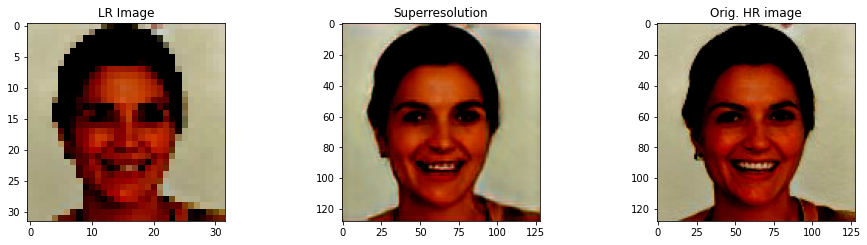

In [56]:
from keras.models import load_model
from numpy.random import randint
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

generator = load_model('gen_e_5.h5', compile=False)

[X1, X2] = [lr_train, hr_train]

ix =int( randint(0, len(X1), 1))
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image.reshape((1,32,32,3)))

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[:,:,:])

plt.show()
